In [1]:
%matplotlib inline

In [129]:
import pandas as pd
import os
import re
from Bio import SeqIO
from Bio import SeqUtils
import pysam
from Bio.SeqRecord import SeqRecord
from pybedtools import BedTool
import numpy as np
import pybedtools
import time
import matplotlib.pyplot as plt
import sys
import subprocess
import shutil
from Bio.Seq import Seq
import pysam
from Bio import SearchIO
import json
import glob
import scipy.stats as stats
import statsmodels as sms
import statsmodels.sandbox.stats.multicomp
import distance
import seaborn as sns
from pybedtools import BedTool
import matplotlib
from sklearn.externals.joblib import Parallel, delayed
import itertools as it
import tempfile
from scipy.signal import argrelextrema
import scipy
from IPython.display import Image
from PIL import Image
from collections import OrderedDict

In [3]:
#now do some folder as input
BASEFOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp'
GENOME_FOLDER = os.path.join(BASEFOLDER, 'genomes')
OUTFOLDER = os.path.join(BASEFOLDER, 'output')
if not os.path.exists(OUTFOLDER):
    os.makedirs(OUTFOLDER)
DK0911_p = 'DK_0911_v04_p_ctg.fa'
DK0911_h = 'DK_0911_v04_h_ctg.fa'
DK0911_ph = 'DK_0911_v04_ph_ctg.fa'
PST_104E_p = 'Pst_104E_v13_p_ctg.fa'
PST_104E_h = 'Pst_104E_v13_h_ctg.fa'
PST_104E_ph = 'Pst_104E_v13_ph_ctg.fa'

In [119]:
def run_command(command, v=False):
    #print('\nRunnning now!\n')
    if v == True:
        print(command)
    try:
        output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError as ex:
        o = ex.output
        returncode = ex.returncode
        if returncode == 25:
            next
        else:
            raise
    #print("Done with it!")
    #print('\nDone\nWith ouput:\n%s' % output)
    #print(output)

In [5]:
def run_nucmer(ref, query,maxmatch=True, l=100, c=500):
    '''Run nucmer with three options.'''
    #print(os.path.basename(ref)[:-3])
    delta = os.path.join(OUTFOLDER, '%s.%s.l%s.c%s.delta' % (os.path.basename(ref)[:-3], os.path.basename(query)[:-3], l,c))
    command='/home/benjamin/anaconda3/mummer-4.0.0/bin/nucmer -l %s -c %s -t 10 %s %s --prefix=%s' % (l, c, ref, query, delta.replace('.delta', ''))
    if maxmatch == True:
        delta = os.path.join(OUTFOLDER, '%s.%s.l%s.c%s.mm.delta' % (os.path.basename(ref)[:-3], os.path.basename(query)[:-3], l,c))
        command='nucmer --maxmatch -l %s -c %s %s %s --prefix=%s' % (l, c, ref, query, delta.replace('.delta', ''))
    if not os.path.exists(delta):
        run_command(command)
    return delta

In [70]:
def run_delta_filter(delta, v=False, **kwargs):
    filter_string = ''
    if kwargs is not None:
        for key,value in kwargs.items():
            if v == True:
                print('Used following delta filter option: %s %s' % (key,value))
            filter_string = '%s %s' % (filter_string, value)
    delta_filter = delta.replace('.delta', '.deltafilter_%s' %(filter_string.replace(' ', '').replace('-','')))
    command = '/home/benjamin/anaconda3/mummer-4.0.0/bin/delta-filter %s % s > %s' % (filter_string, delta, delta_filter)
    run_command(command)
    return delta_filter

In [197]:
def run_show_coords(delta_filter,v=False, **kwargs):
    filter_string = ''
    if kwargs is not None:
        for key,value in kwargs.items():
            if v==True:
                print('Used following show-coords option: %s %s' % (key,value))
            filter_string = '%s %s' % (filter_string, value)
    #print(delta_filter.index('.delta'))
    showcoords = '%s_%s.coords' % (delta_filter, filter_string.replace(' ', '').replace('-',''))
    command = '/home/benjamin/anaconda3/mummer-4.0.0/bin/show-coords -T %s %s > %s' % (filter_string, delta_filter, showcoords)
    run_command(command)
    return showcoords

In [79]:
def run_mummerplot(delta_filter,v=False, **kwargs):
    filter_string = ''
    if kwargs is not None:
        for key,value in kwargs.items():
            if v == True:
                print('Used following mummerplot option: %s %s' % (key,value))
            filter_string = '%s %s' % (filter_string, value)
    mummerplot = os.path.basename(delta_filter)
    if 'r' in kwargs.keys():
            mummerplot = mummerplot + kwargs['r'].replace('-r ','_')
    previous_dir = os.getcwd()
    os.chdir(OUTFOLDER)
    command = '/home/benjamin/anaconda3/mummer-4.0.0/bin/mummerplot %s -p %s --png %s' % (filter_string, mummerplot, delta_filter)
    run_command(command)
    os.chdir(previous_dir)
    return '%s.png' % (os.path.join(OUTFOLDER, mummerplot))

In [121]:
def show_cov_plot(mummerplot, show=False):
    if not os.path.exists(mummerplot):
        return None
    image = Image.open(mummerplot)
    image = image.crop((10,500,800,800))
    print('\n##########\n')
    print('This is the coverage plot %s!' % os.path.basename(mummerplot))
    print('\n##########\n')
    if show==True:
        image
    return image

In [123]:
def show_align_plot(mummerplot, show=False):
    if not os.path.exists(mummerplot):
        return None
    image = Image.open(mummerplot)
    print('\n##########\n')
    print('This is the alignment plot %s!' % os.path.basename(mummerplot))
    print('\n##########\n')
    if show==True:
        image
    return image

In [188]:
def coords_to_nrbed(coords_fn):
    with open(coords_fn, 'r') as fh:
        counter = 0
        for line in fh:
            #if line.startswith('['):
                #counter = 1
            #if counter == 1:
            n_columns = len(line.split('\t'))
    column_names = ['r_start','r_stop', 'q_start', 'q_stop', 'aln_len_r', 'aln_len_q', 'pc_id', 'len_r', 'len_q', 'ref_name', 'query_name']

    if len(columns) != n_columns:
        column_names.remove('len_r' )
        column_names.remove('len_q')

    df = pd.read_csv(coords_fn, sep='\t', skiprows=4, names=column_names )
    tmp_bed_fn = coords_fn.replace('.coords', '.tmpbed')
    df['r_bed_start'] = df.r_start - 1
    df['r_bed_stop'] = df.r_stop - 1
    df.loc[:, ['ref_name', 'r_bed_start', 'r_bed_stop']].to_csv(tmp_bed_fn, header=None, index=None, sep='\t')
    BedTool(tmp_bed_fn).sort().merge().saveas(tmp_bed_fn.replace('.tmpbed', '.nr.bed'))
    return tmp_bed_fn.replace('.tmpbed', '.nr.bed')

In [189]:
def count_bases_in_bed(fn):
    """Function that sums the interval size of bedfile."""
    header = ['contig', 'start', 'stop']
    df = pd.read_csv(fn, sep='\t', header=None, names=header)
    df['interval'] = df.stop - df.start
    return df.interval.sum()

In [13]:
delta_DK0911_self_nmm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, DK0911_h), maxmatch=False)
delta_DK0911_Pst_104Ep_nmm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, PST_104E_p), maxmatch=False)
delta_DK0911_Pst_104Eph_nmm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, PST_104E_ph), maxmatch=False)
delta_Pst_104E_DK0911ph_nmm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, DK0911_ph), maxmatch=False)
delta_Pst_104E_self_nmm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, PST_104E_h), maxmatch=False)
delta_Pst_104E_DK0911p_nmm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, DK0911_p), maxmatch=False)

In [14]:
delta_Pst_104Eph_DK0911ph_mm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_ph), os.path.join(GENOME_FOLDER, DK0911_ph))
delta_DK0911ph_Pst_104Eph_mm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_ph), os.path.join(GENOME_FOLDER, PST_104E_ph))

In [15]:
#run a couple of delta mapping for mummer
delta_DK0911_self_mm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, DK0911_h))
delta_DK0911_Pst_104Ep_mm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, PST_104E_p))
delta_DK0911_Pst_104Eph_mm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, PST_104E_ph))

In [16]:
delta_Pst_104E_DK0911p_mm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, DK0911_p))
delta_Pst_104E_DK0911ph_mm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, DK0911_ph))
delta_Pst_104E_self_mm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, PST_104E_h))


##########

This is the coverage plot DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m_pcontig_000.png!

##########



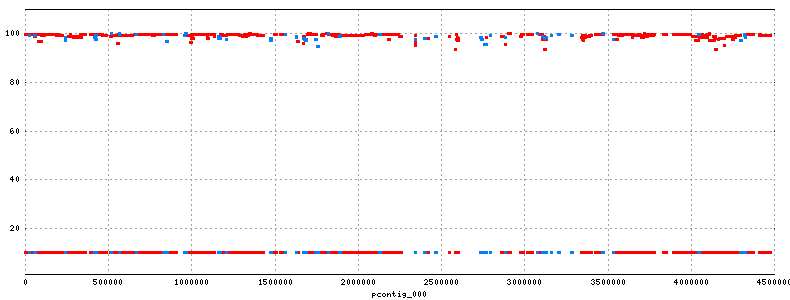

In [80]:
show_cov_plot(run_mummerplot(run_delta_filter(delta_DK0911_self_mm, **{'m':'-m'}), **{'c': '-c', 'r': '-r pcontig_000'}))


##########

This is the coverage plot DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.deltafilter_m_pcontig_000.png!

##########



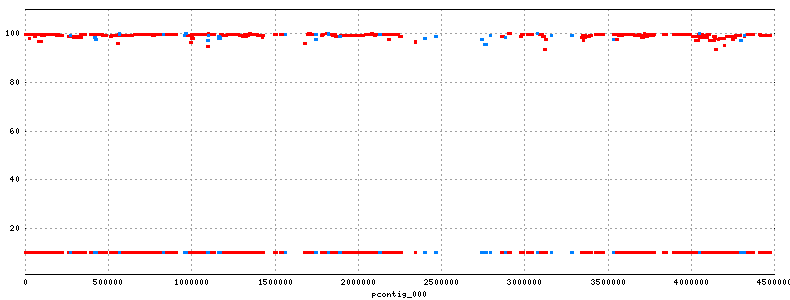

In [81]:
show_cov_plot(run_mummerplot(run_delta_filter(delta_DK0911_self_nmm, **{'m':'-m'}), **{'c': '-c', 'r': '-r pcontig_000'}))


##########

This is the coverage plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_m_pcontig_000.png!

##########



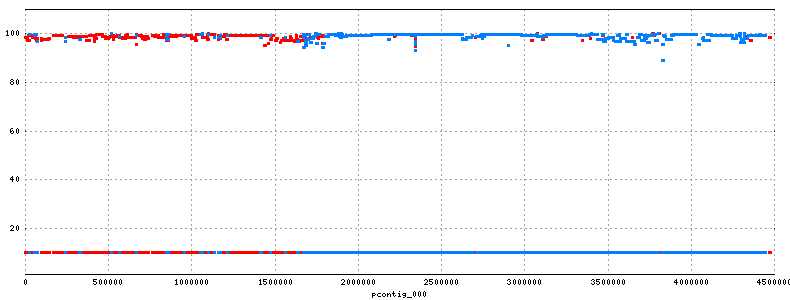

In [82]:
show_cov_plot(run_mummerplot(run_delta_filter(delta_DK0911_Pst_104Ep_mm, **{'m':'-m'}), **{'c': '-c', 'r': '-r pcontig_000'}))


##########

This is the coverage plot DK_0911_v04_p_ctg.Pst_104E_v13_ph_ctg.l100.c500.mm.deltafilter_m_pcontig_000.png!

##########



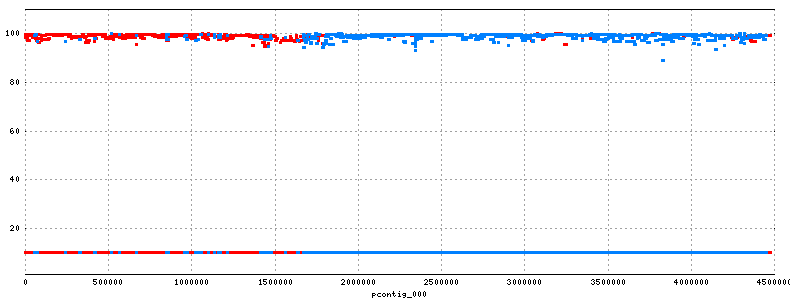

In [108]:
show_cov_plot(run_mummerplot(run_delta_filter(delta_DK0911_Pst_104Eph_mm, **{'m':'-m'}), **{'c': '-c', 'r': '-r pcontig_000'}))


##########

This is the coverage plot DK_0911_v04_p_ctg.Pst_104E_v13_ph_ctg.l100.c500.mm.deltafilter_mi80_pcontig_002.png!

##########



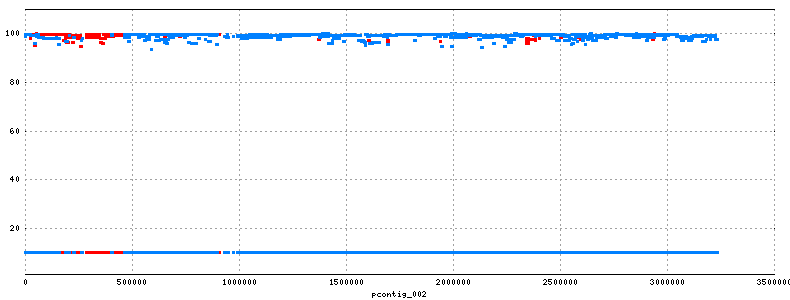

In [126]:
show_cov_plot(run_mummerplot(run_delta_filter(delta_DK0911_Pst_104Eph_mm, **{'m':'-m', 'i': '-i 80'}), **{'c': '-c', 'r': '-r pcontig_002'}))

Used following delta filter option: m -m
Used following delta filter option: i -i 80
/home/benjamin/anaconda3/mummer-4.0.0/bin/delta-filter  -m -i 80 /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.Pst_104E_v13_ph_ctg.l100.c500.mm.delta > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.Pst_104E_v13_ph_ctg.l100.c500.mm.deltafilter_mi80
Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_020
/home/benjamin/anaconda3/mummer-4.0.0/bin/mummerplot  -c -r pcontig_020 -p DK_0911_v04_p_ctg.Pst_104E_v13_ph_ctg.l100.c500.mm.deltafilter_mi80 --png /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.Pst_104E_v13_ph_ctg.l100.c500.mm.deltafilter_mi80

##########

This is the coverage plot DK_0911_v04_p_ctg.Pst_104E_v13_ph_ctg.l10

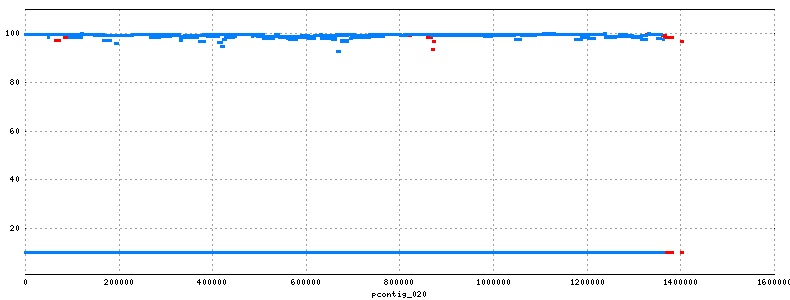

In [30]:
show_cov_plot(run_mummerplot(run_delta_filter(delta_DK0911_Pst_104Eph_mm, **{'m':'-m', 'i': '-i 80'}), **{'c': '-c', 'r': '-r pcontig_020'}))

Used following delta filter option: m -m
Used following delta filter option: i -i 98
/home/benjamin/anaconda3/mummer-4.0.0/bin/delta-filter  -m -i 98 /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/Pst_104E_v13_p_ctg.DK_0911_v04_ph_ctg.l100.c500.mm.delta > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/Pst_104E_v13_p_ctg.DK_0911_v04_ph_ctg.l100.c500.mm.deltafilter_mi98
Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_010
/home/benjamin/anaconda3/mummer-4.0.0/bin/mummerplot  -c -r pcontig_010 -p Pst_104E_v13_p_ctg.DK_0911_v04_ph_ctg.l100.c500.mm.deltafilter_mi98 --png /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/Pst_104E_v13_p_ctg.DK_0911_v04_ph_ctg.l100.c500.mm.deltafilter_mi98

##########

This is the coverage plot Pst_104E_v13_p_ctg.DK_0911_v04_ph_ctg.l10

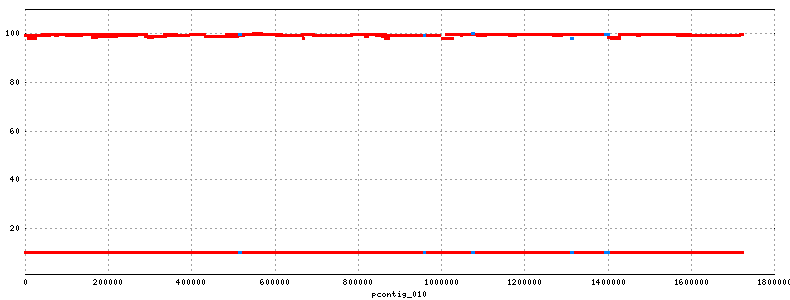

In [41]:
show_cov_plot(run_mummerplot(run_delta_filter(delta_Pst_104E_DK0911ph_mm, **{'m':'-m', 'i': '-i 98'}), **{'c': '-c', 'r': '-r pcontig_010'}))

contig pcontig_000 of DK0911p with 3073024 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_000.png!

##########



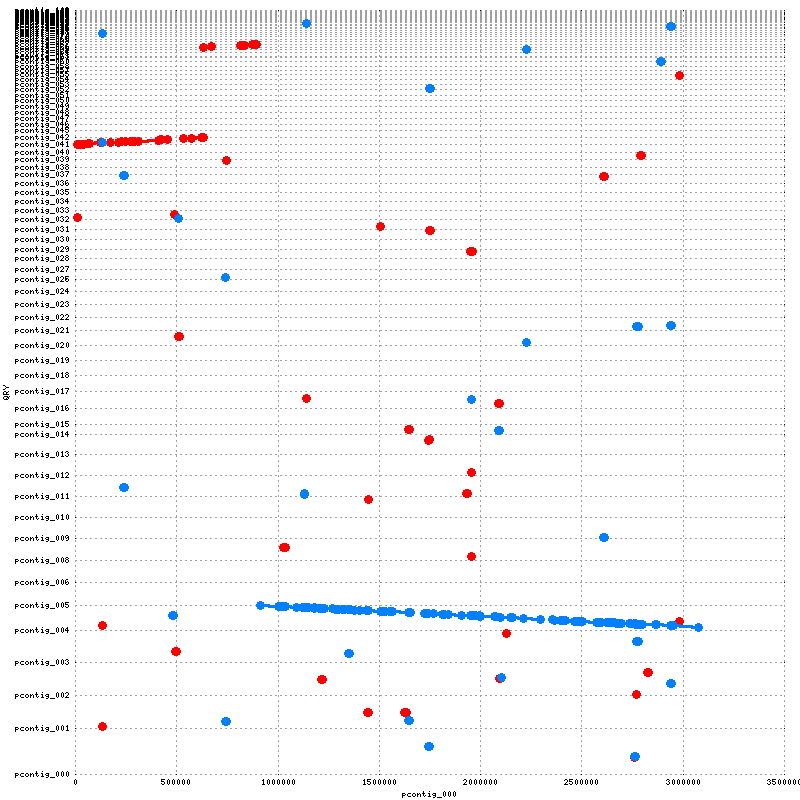

contig pcontig_001 of DK0911p with 2856984 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_001.png!

##########



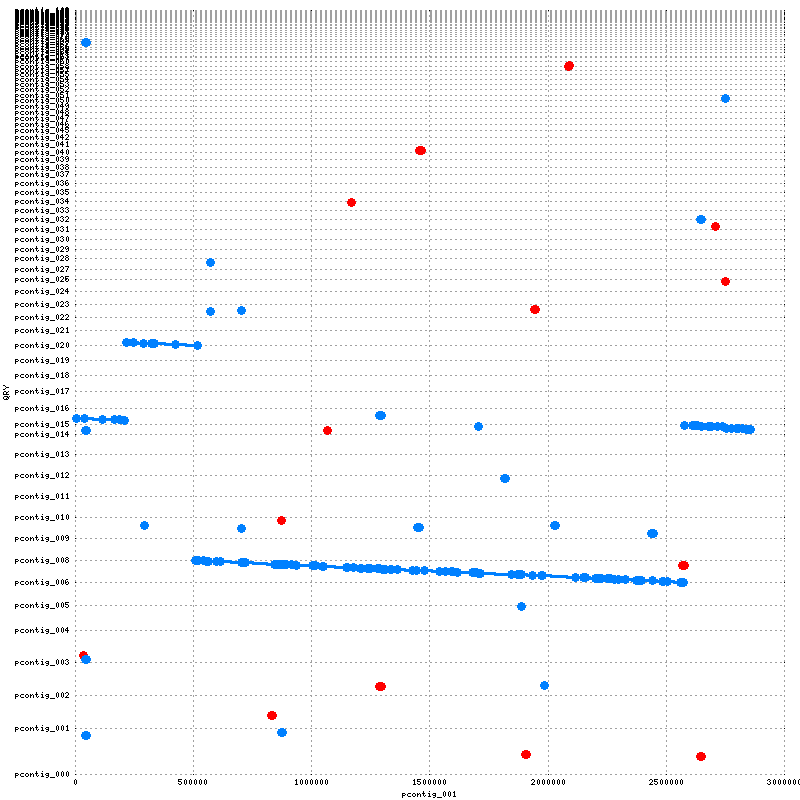

contig pcontig_002 of DK0911p with 2342972 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_002.png!

##########



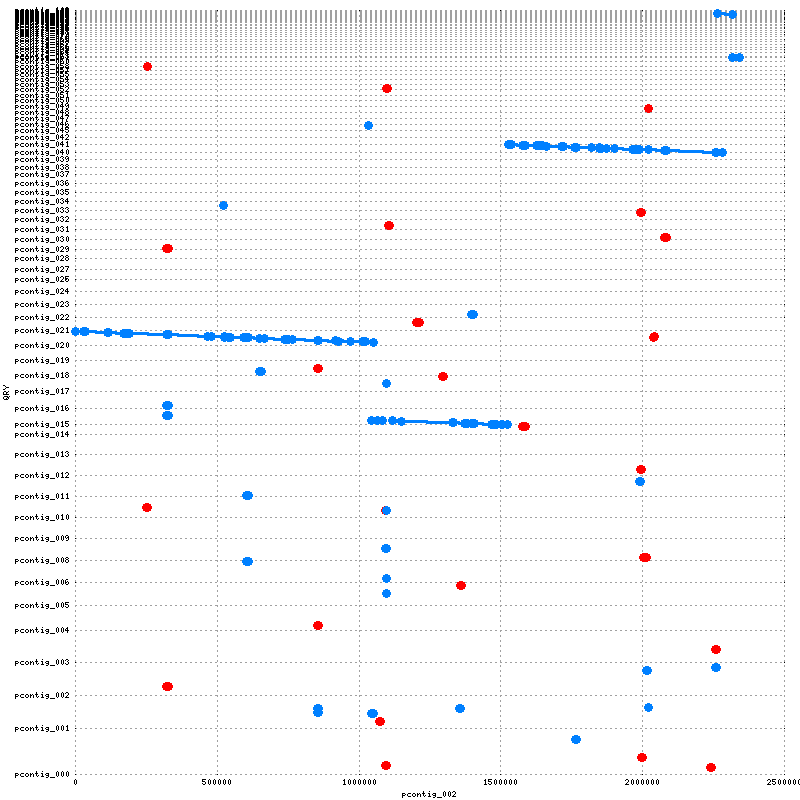

contig pcontig_003 of DK0911p with 2392543 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_003.png!

##########



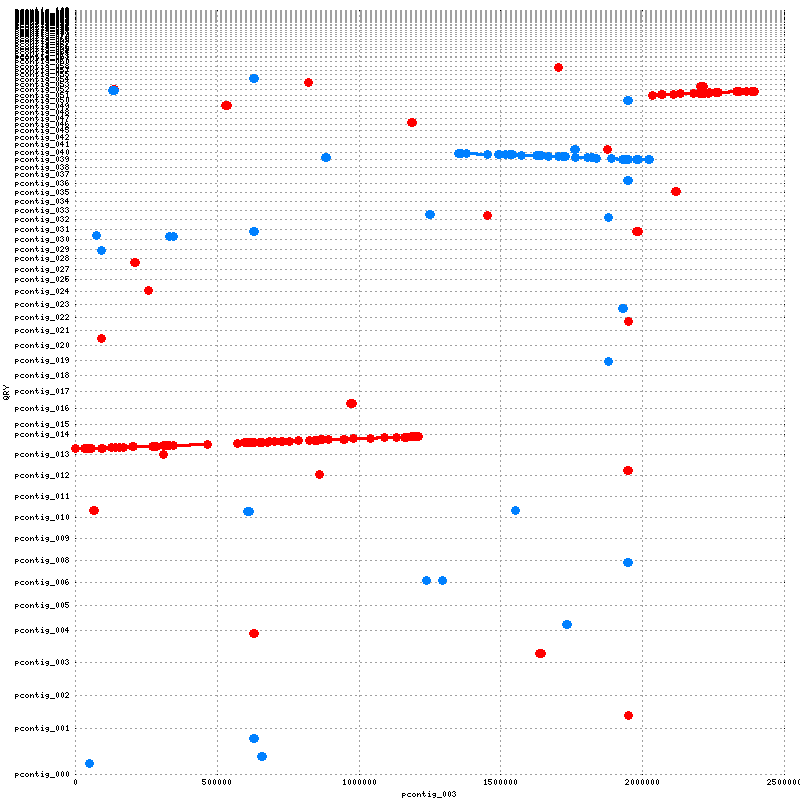

contig pcontig_004 of DK0911p with 2094696 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_004.png!

##########



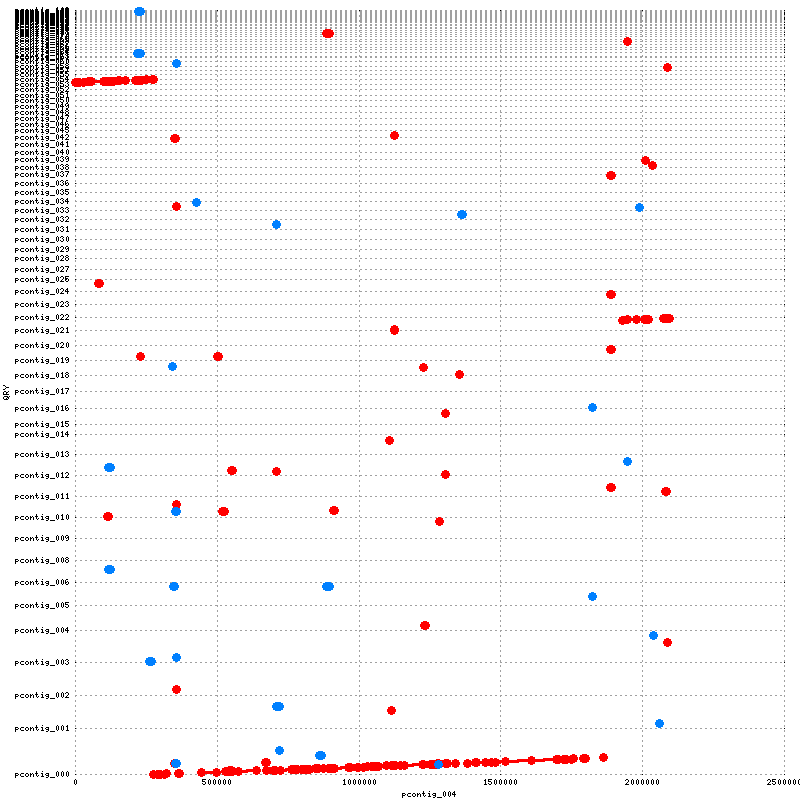

contig pcontig_005 of DK0911p with 2199355 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_005.png!

##########



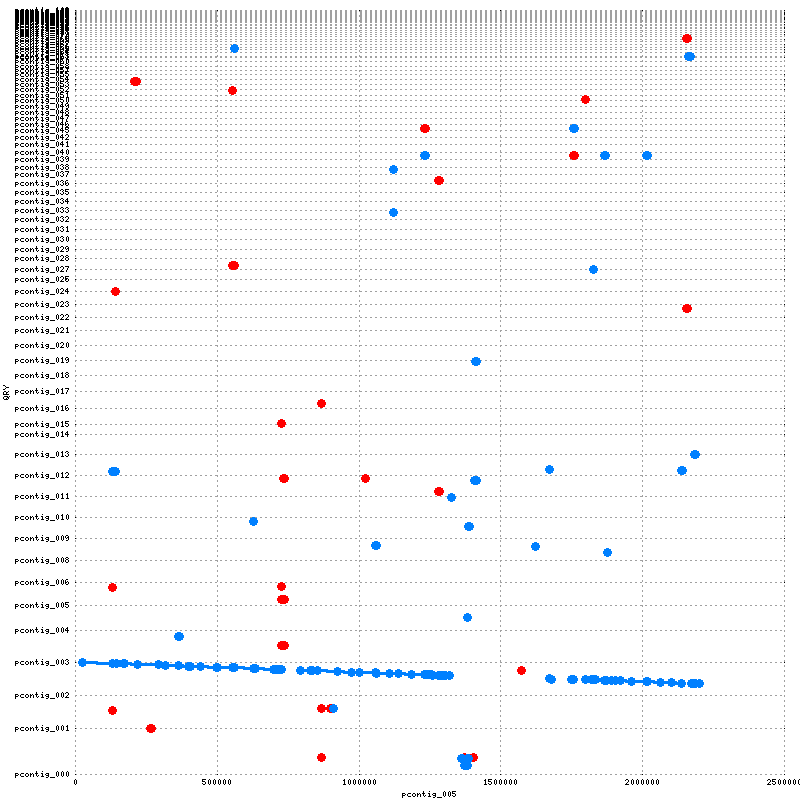

contig pcontig_006 of DK0911p with 2041788 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_006.png!

##########



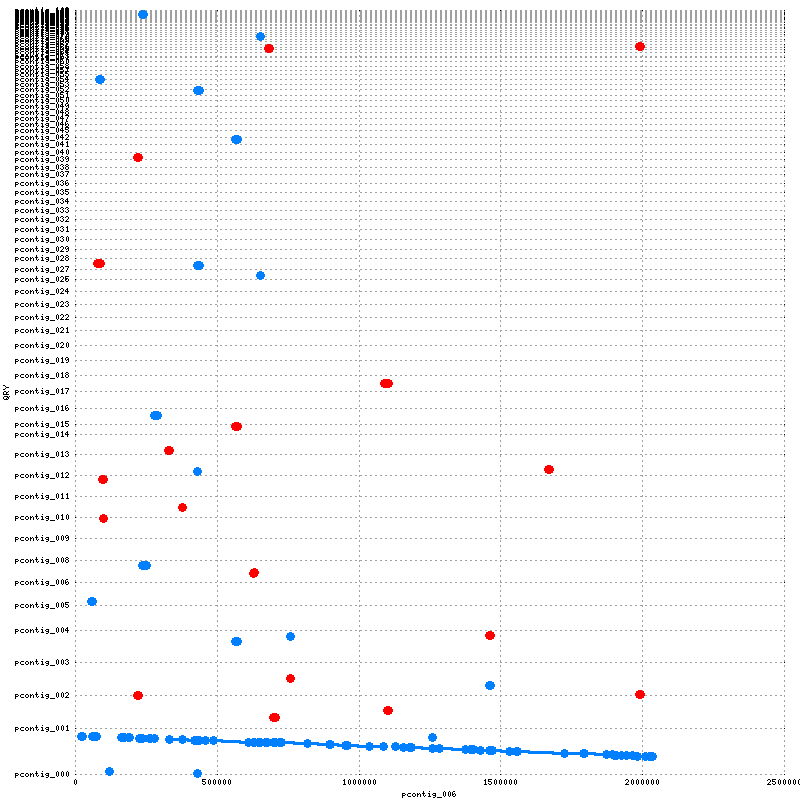

contig pcontig_007 of DK0911p with 2002714 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_007.png!

##########



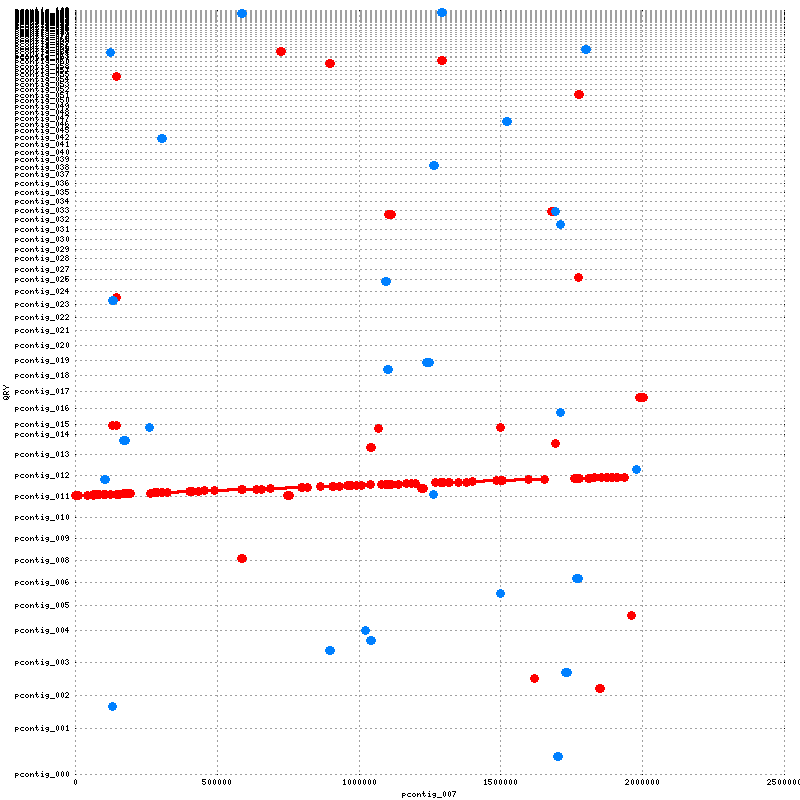

contig pcontig_008 of DK0911p with 1839735 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_008.png!

##########



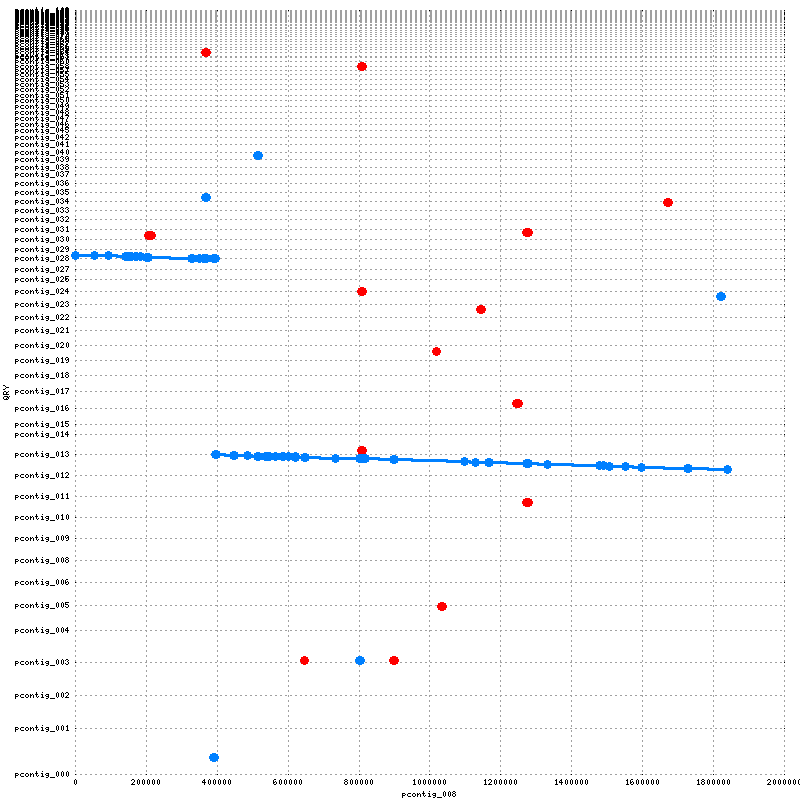

contig pcontig_009 of DK0911p with 1774686 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_009.png!

##########



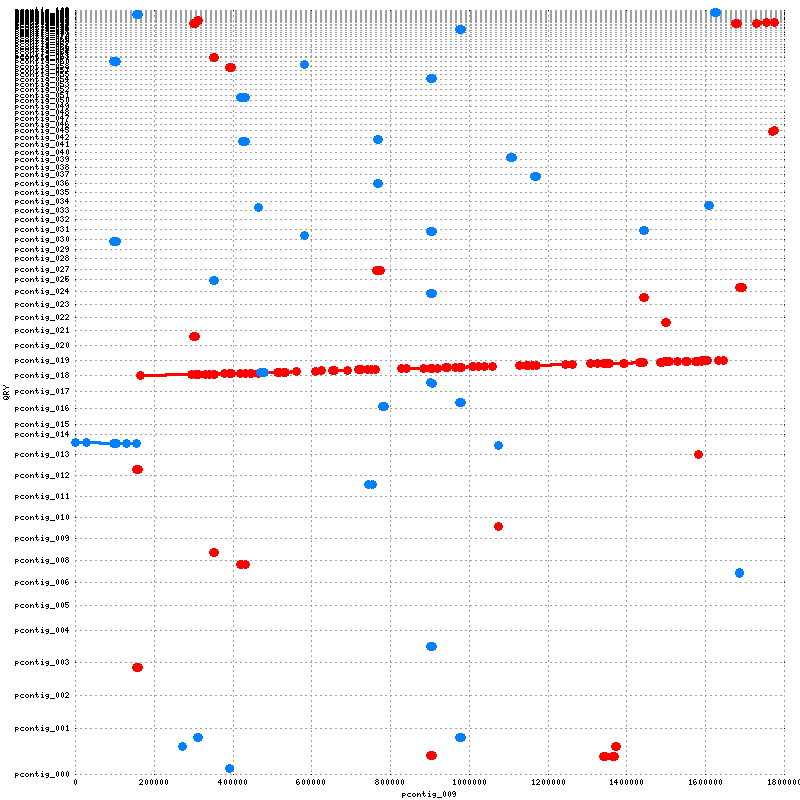

contig pcontig_010 of DK0911p with 1722002 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_010.png!

##########



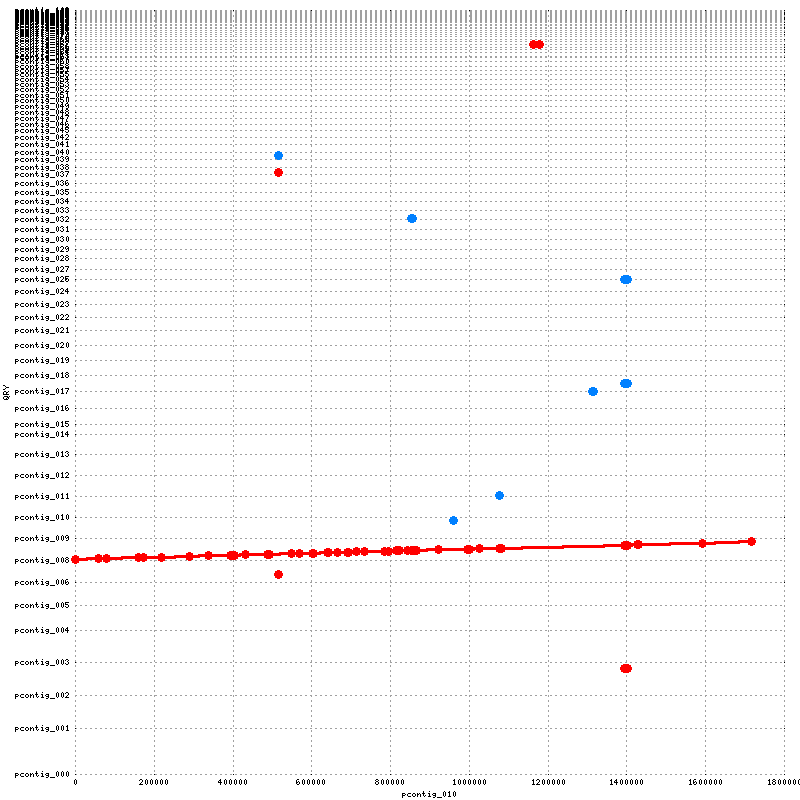

contig pcontig_011 of DK0911p with 1802533 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_011.png!

##########



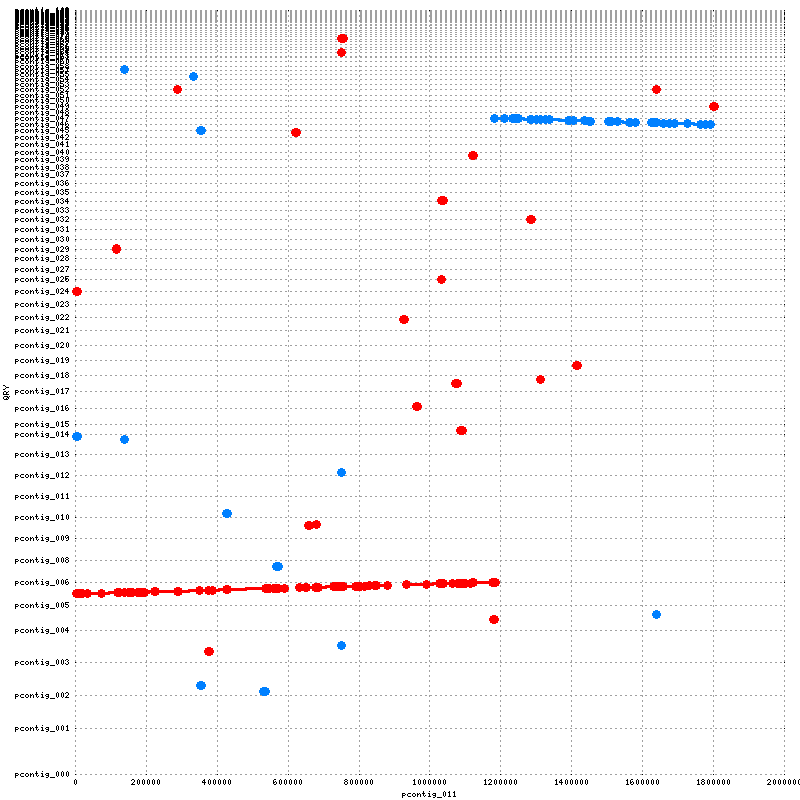

contig pcontig_012 of DK0911p with 1597242 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_012.png!

##########



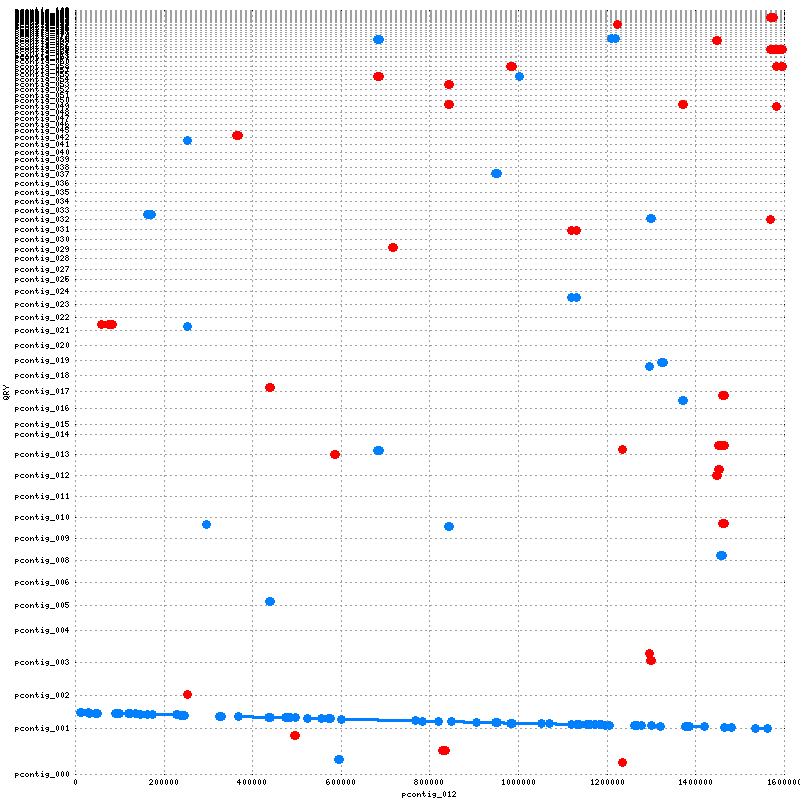

contig pcontig_013 of DK0911p with 1628568 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_013.png!

##########



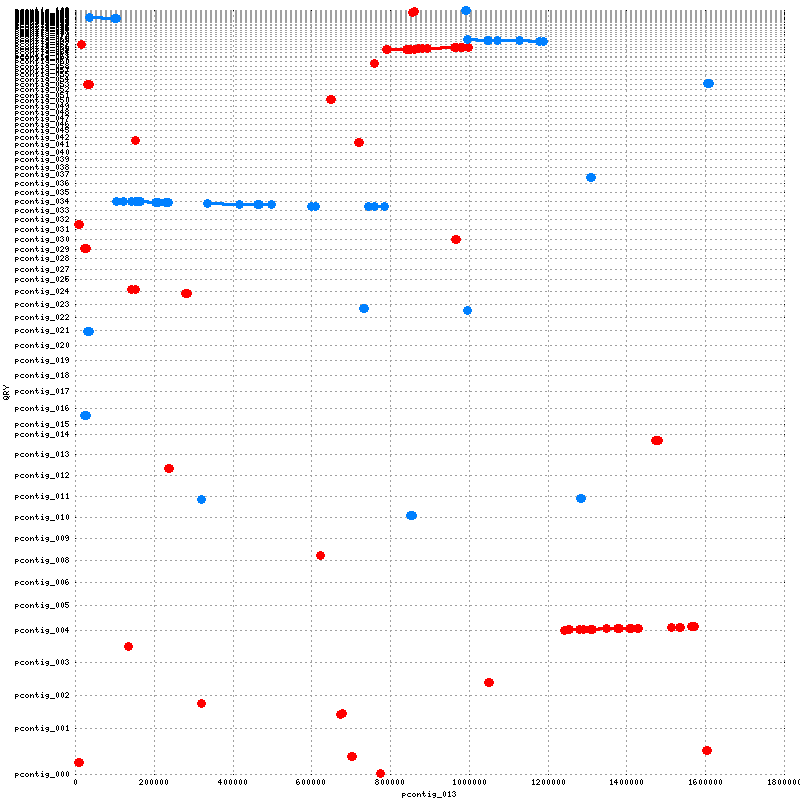

contig pcontig_014 of DK0911p with 1609765 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_014.png!

##########



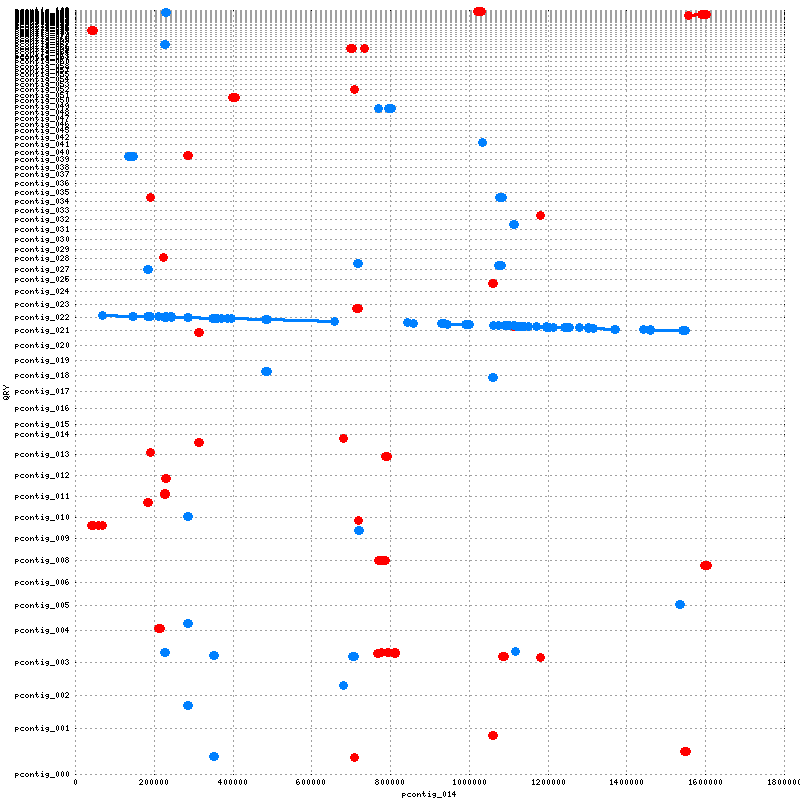

contig pcontig_015 of DK0911p with 65823 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_015.png!

##########



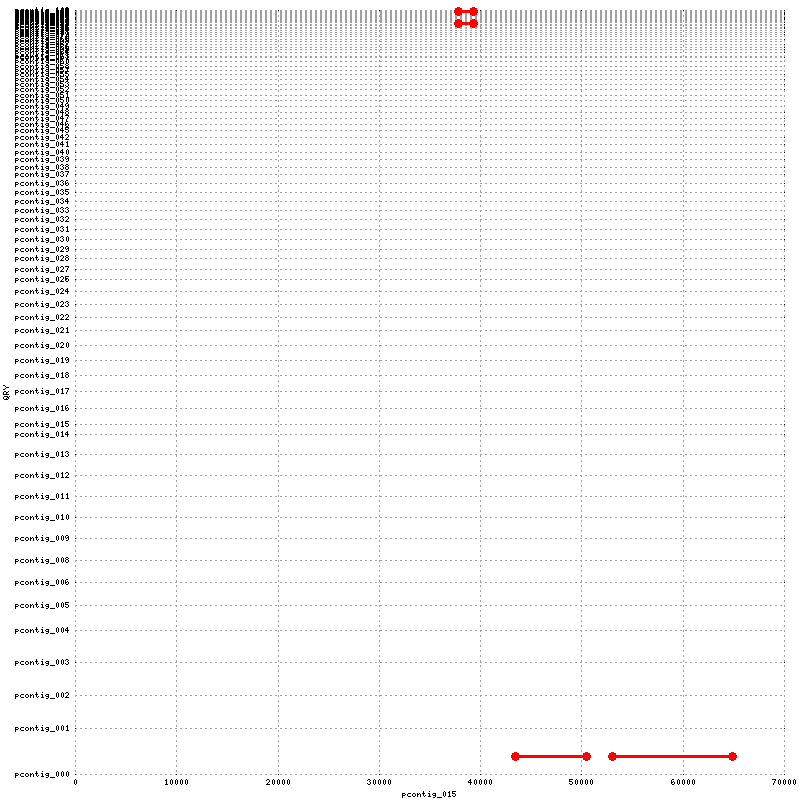

contig pcontig_016 of DK0911p with 1526403 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_016.png!

##########



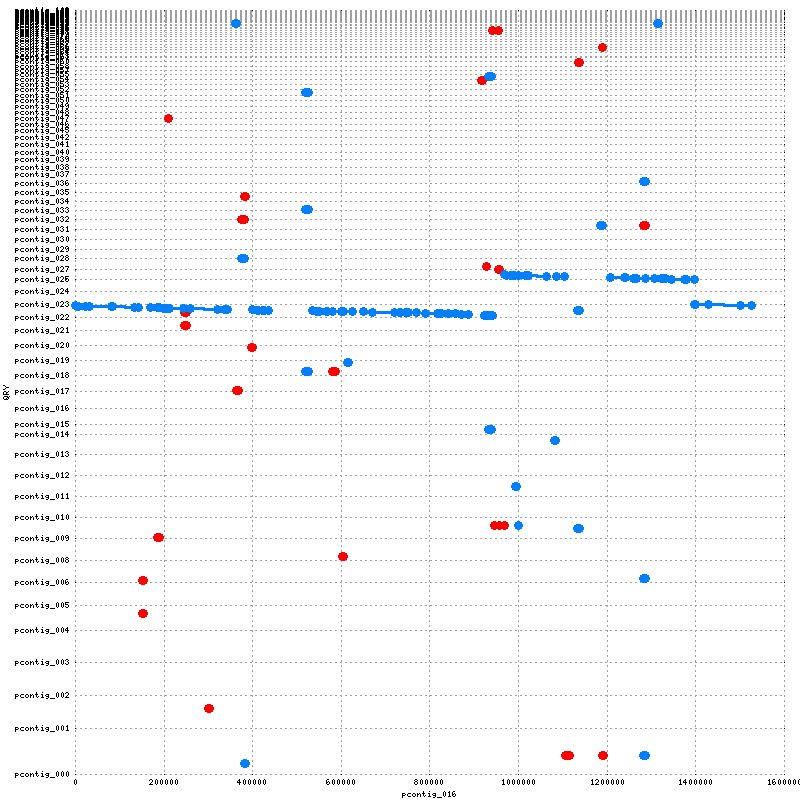

contig pcontig_017 of DK0911p with 1401865 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_017.png!

##########



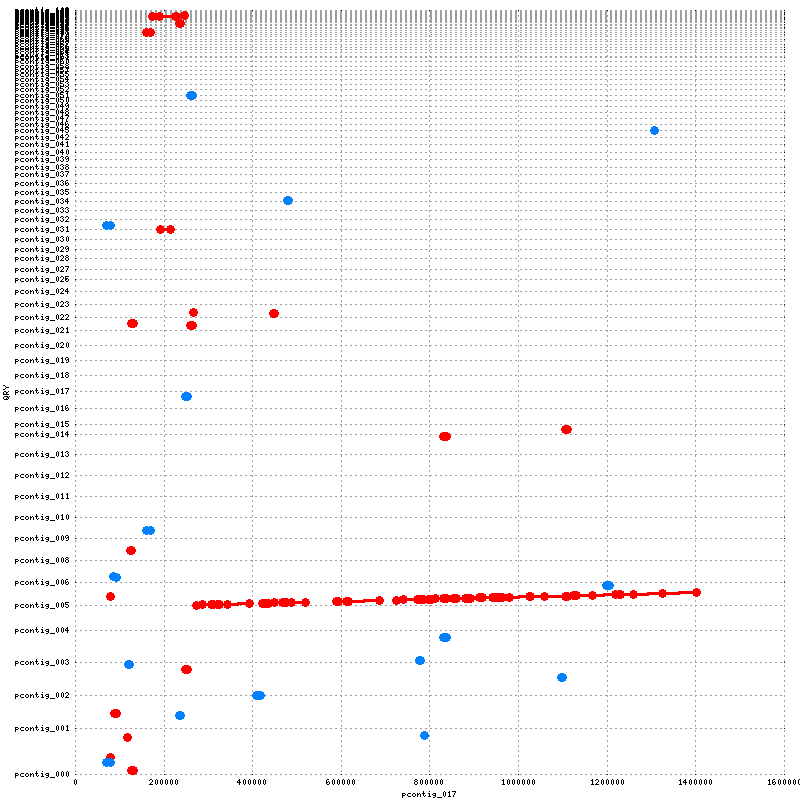

contig pcontig_018 of DK0911p with 1460823 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_018.png!

##########



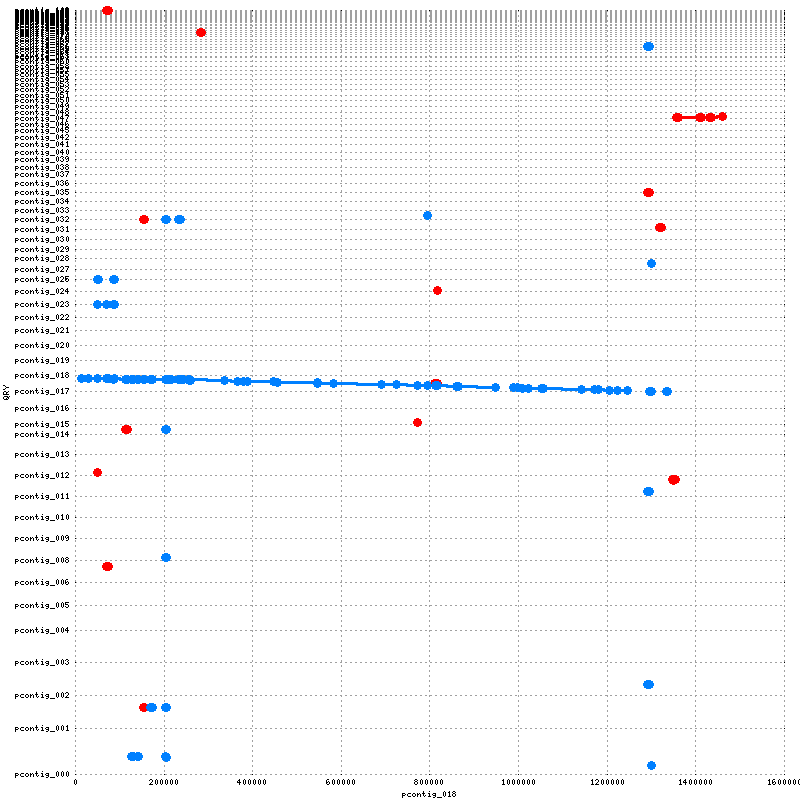

contig pcontig_019 of DK0911p with 1435105 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_019.png!

##########



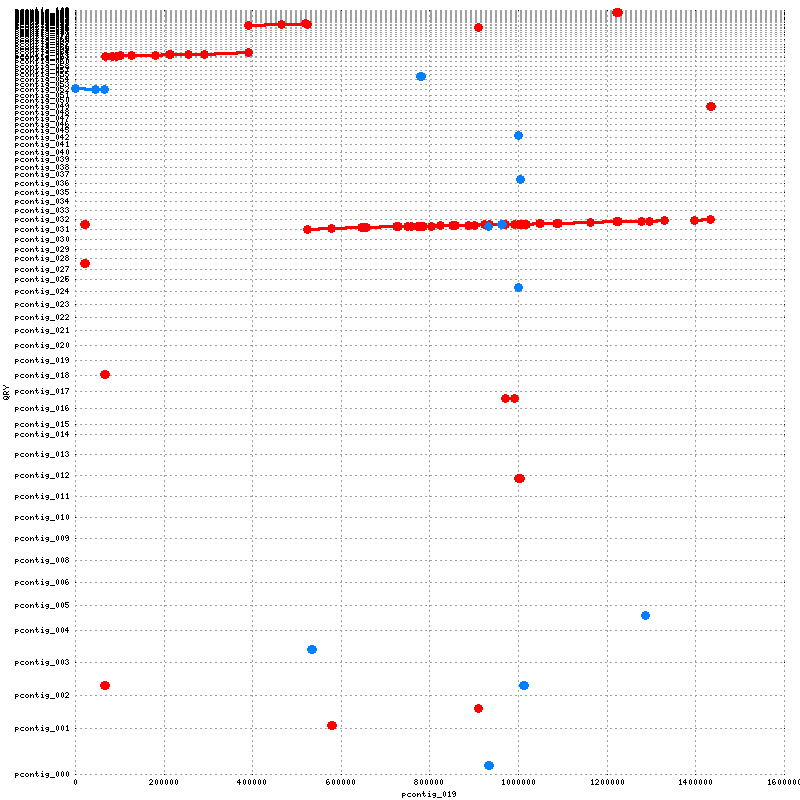

contig pcontig_020 of DK0911p with 1494258 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_020.png!

##########



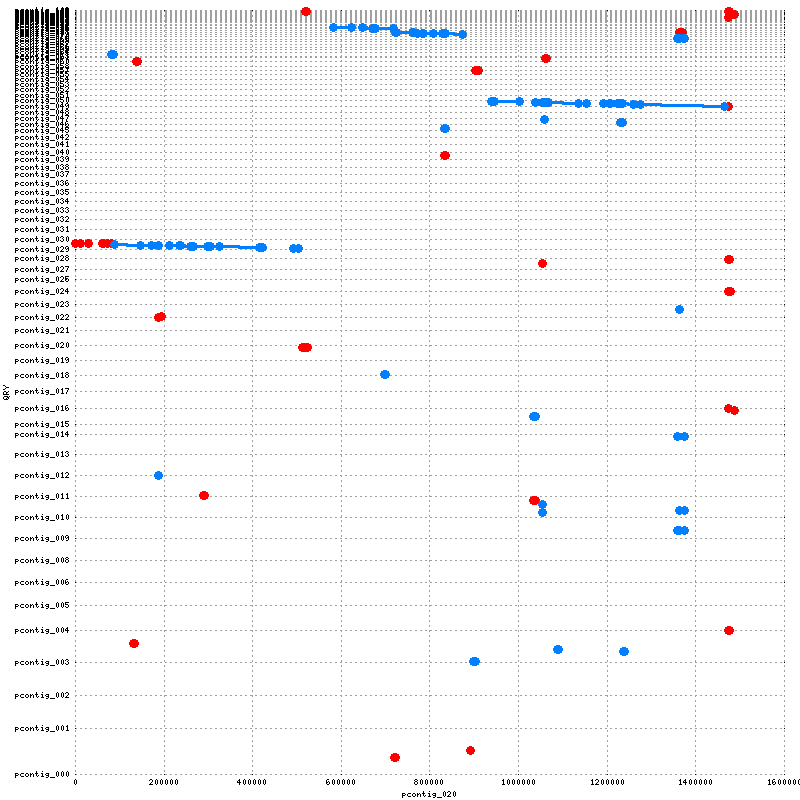

contig pcontig_021 of DK0911p with 1422847 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_021.png!

##########



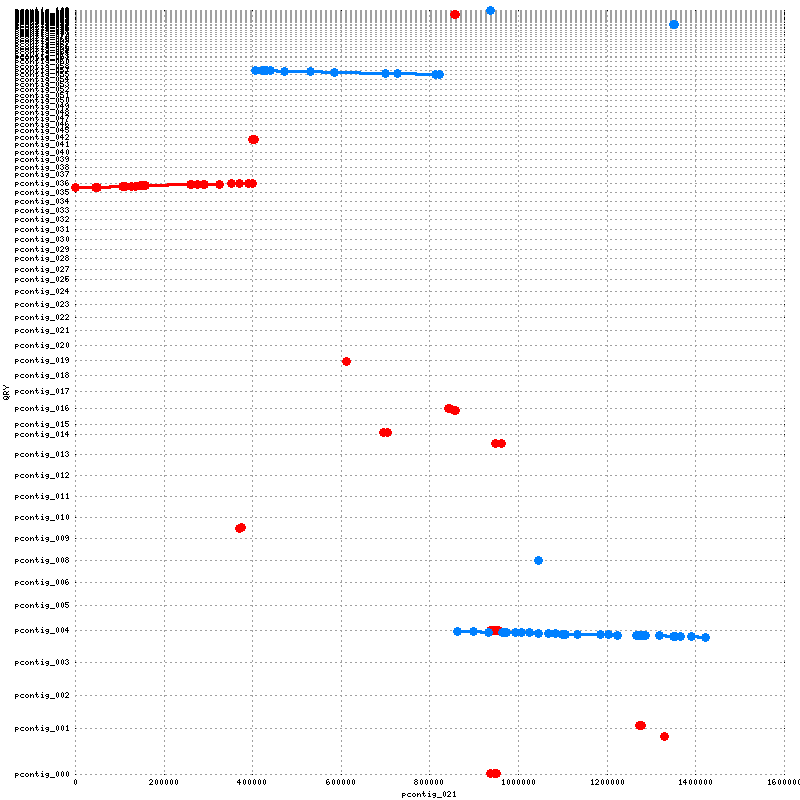

contig pcontig_022 of DK0911p with 1277105 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_022.png!

##########



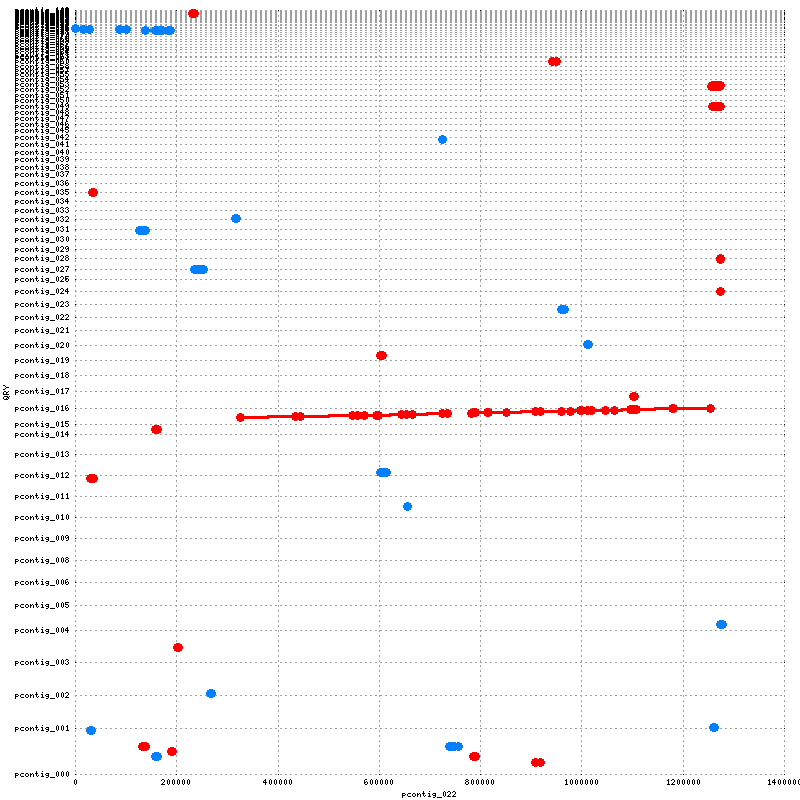

contig pcontig_023 of DK0911p with 1304018 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_023.png!

##########



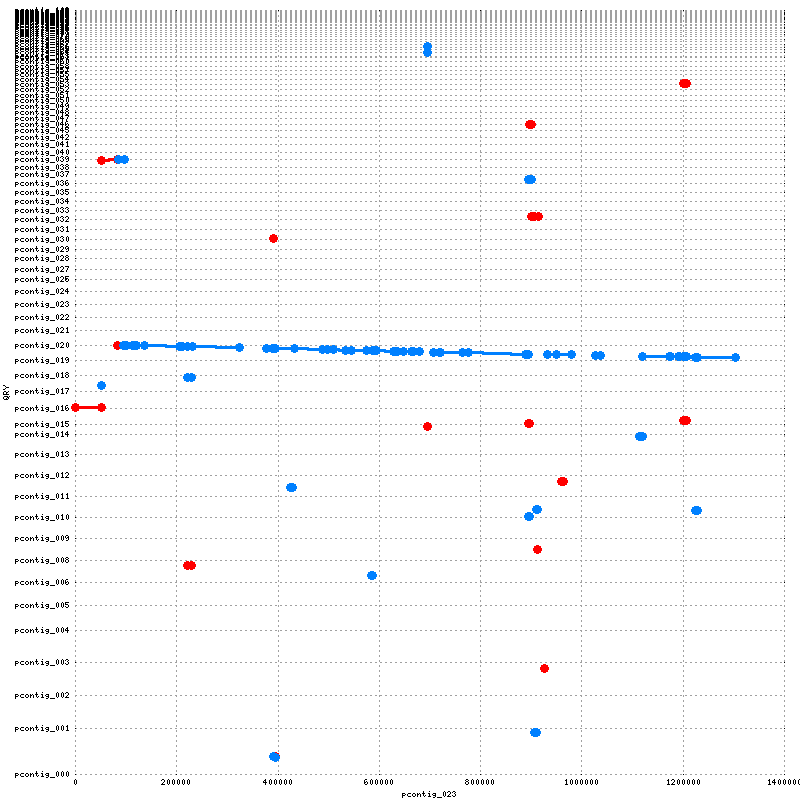

contig pcontig_024 of DK0911p with 64141 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_024.png!

##########



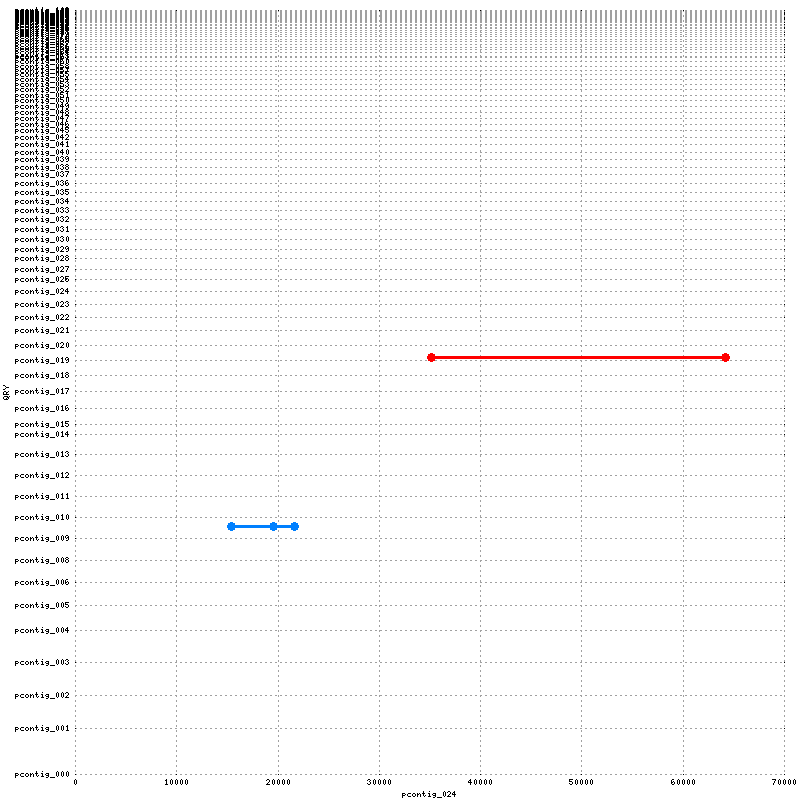

contig pcontig_025 of DK0911p with 741903 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_025.png!

##########



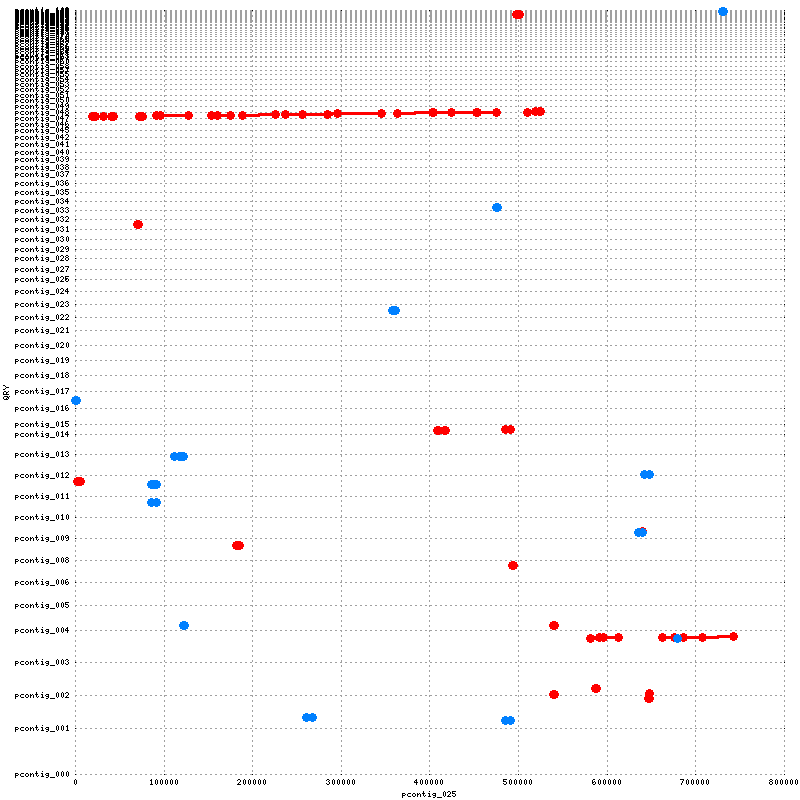

contig pcontig_026 of DK0911p with 1360396 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_026.png!

##########



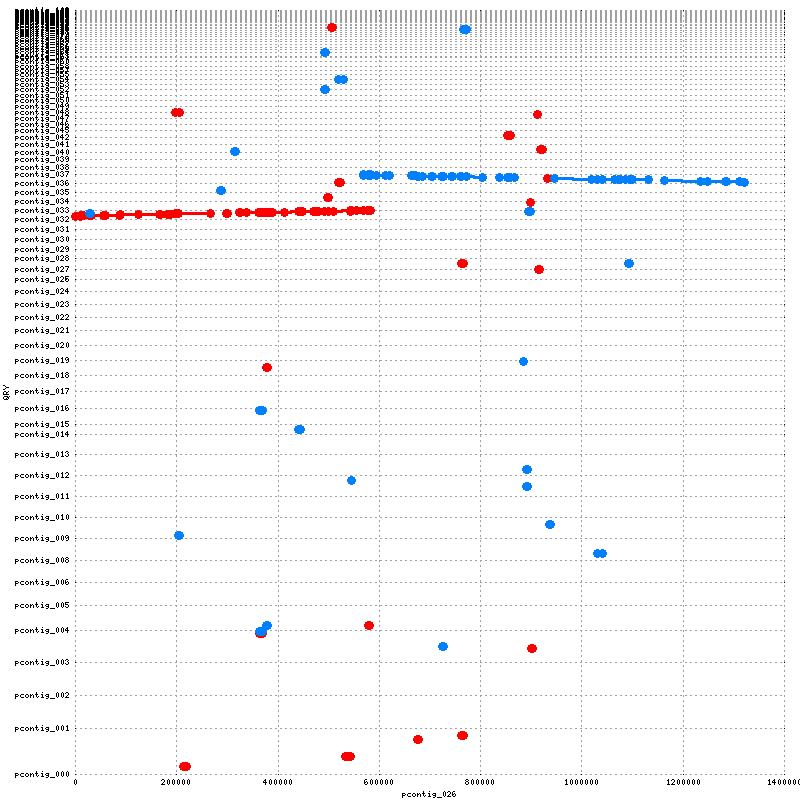

contig pcontig_027 of DK0911p with 1172540 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_027.png!

##########



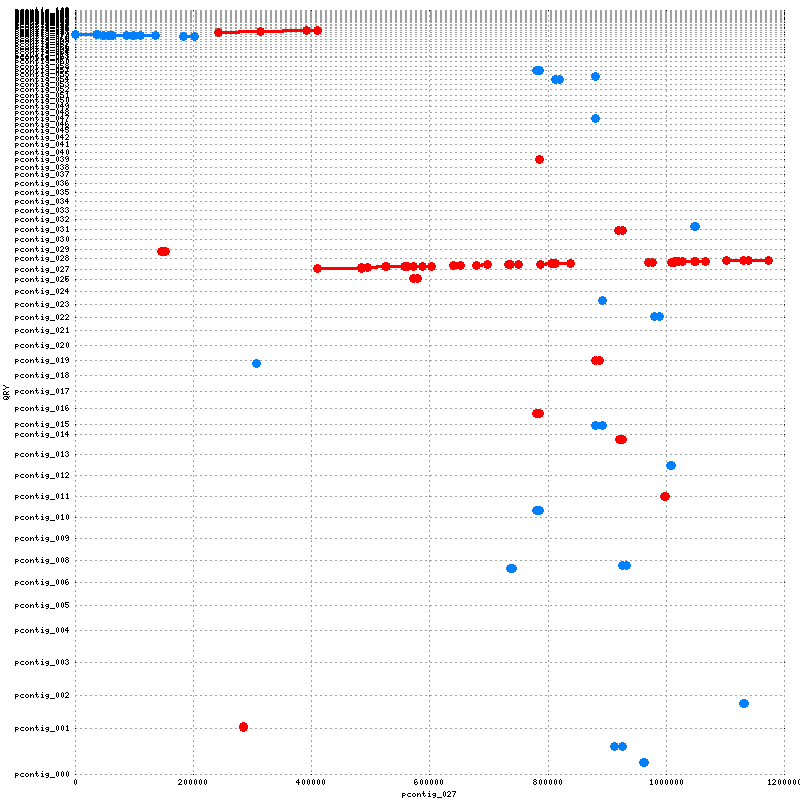

contig pcontig_028 of DK0911p with 1135311 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_028.png!

##########



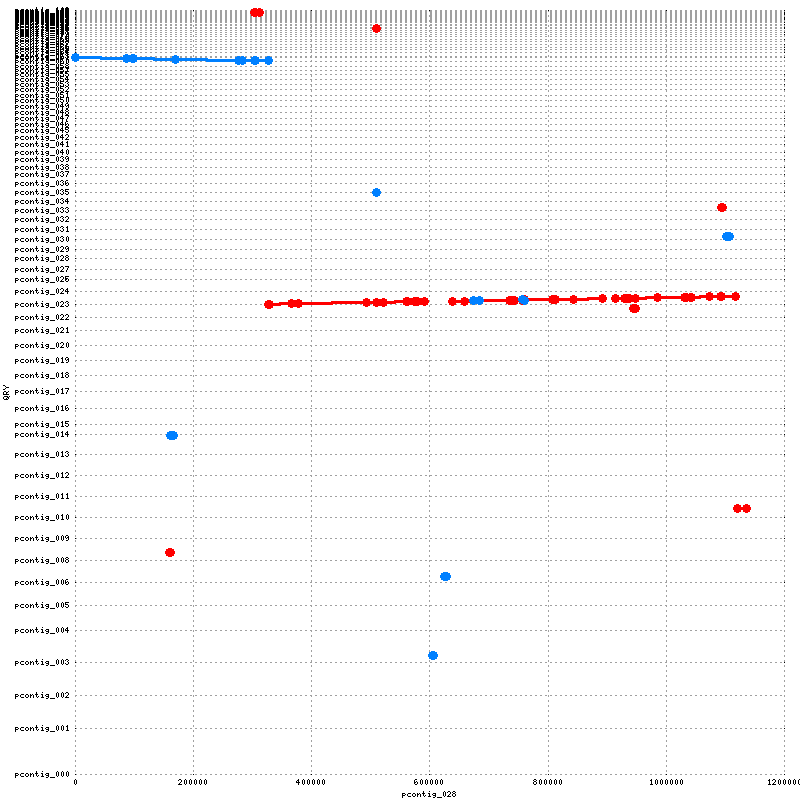

contig pcontig_029 of DK0911p with 1216508 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_029.png!

##########



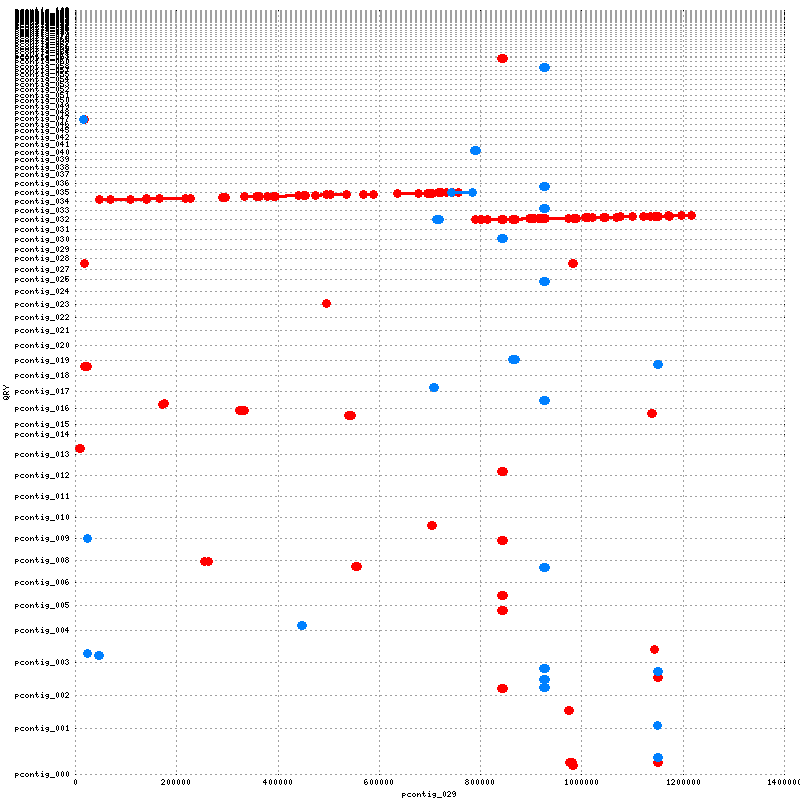

contig pcontig_030 of DK0911p with 1171460 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_030.png!

##########



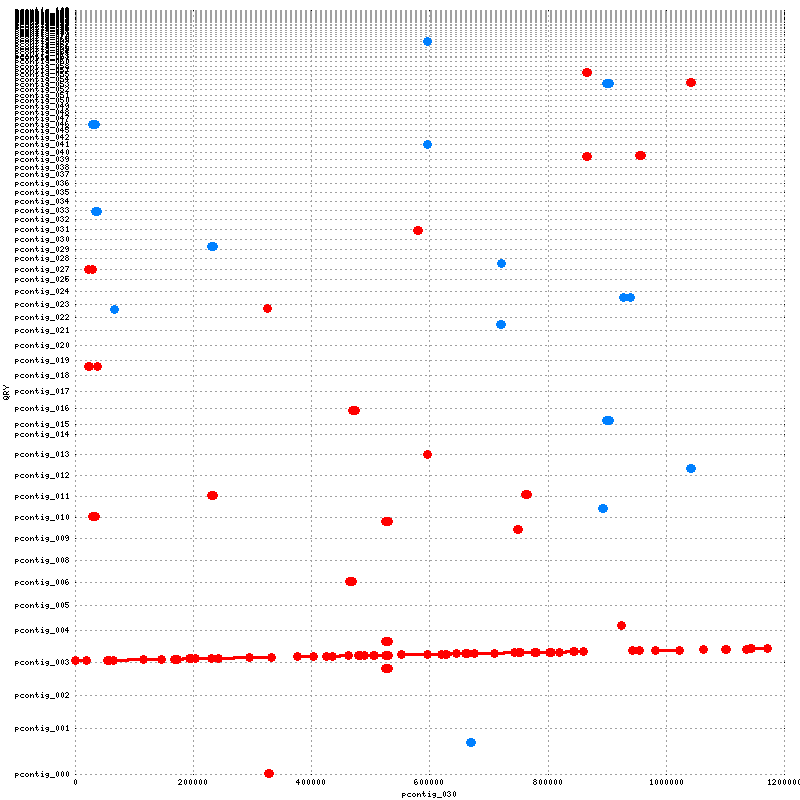

contig pcontig_031 of DK0911p with 876354 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_031.png!

##########



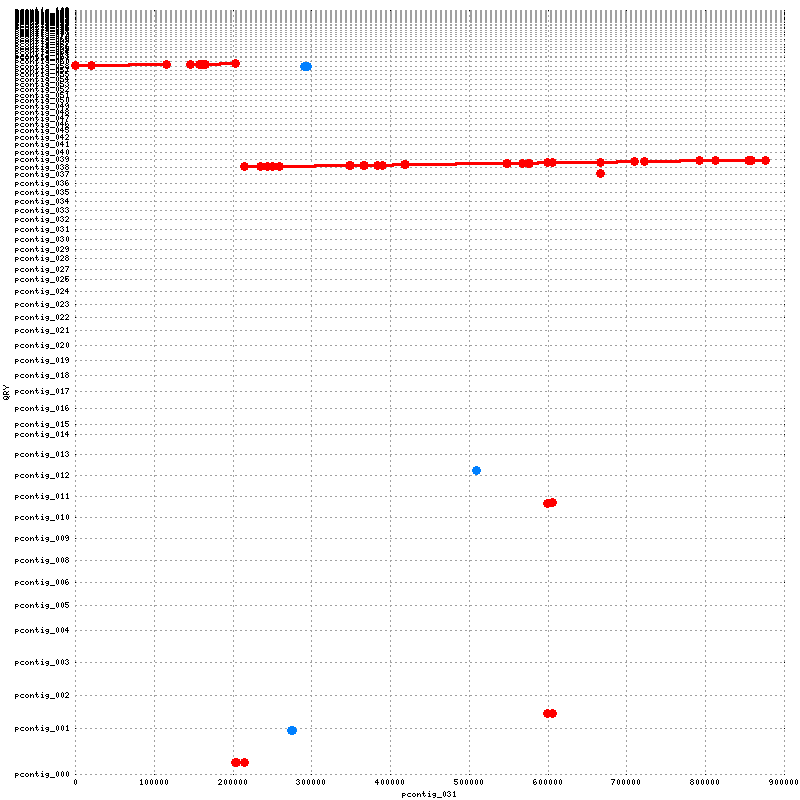

contig pcontig_032 of DK0911p with 59756 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_032.png!

##########



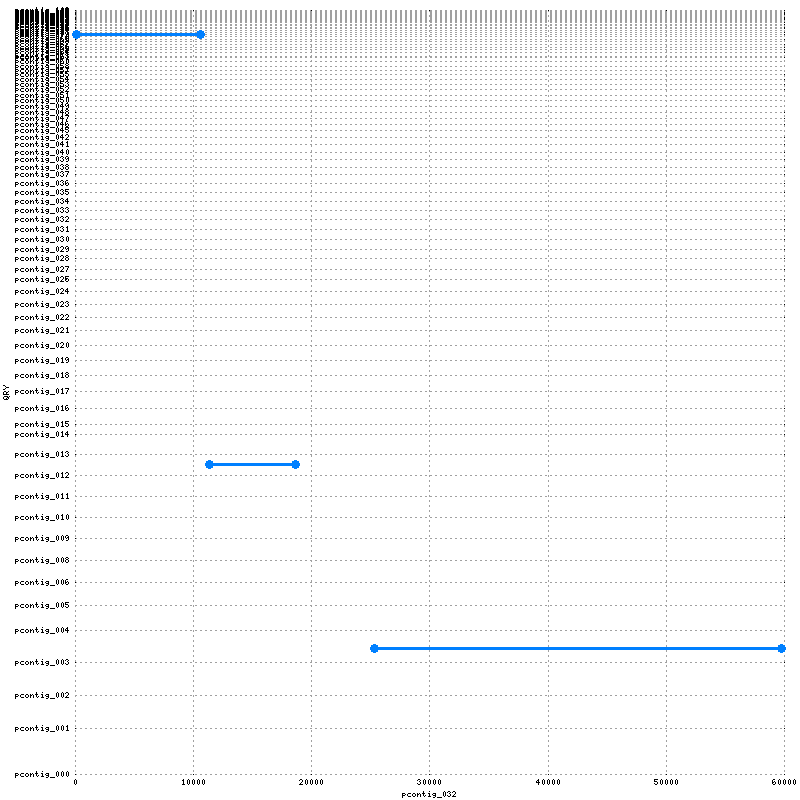

contig pcontig_033 of DK0911p with 1133857 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_033.png!

##########



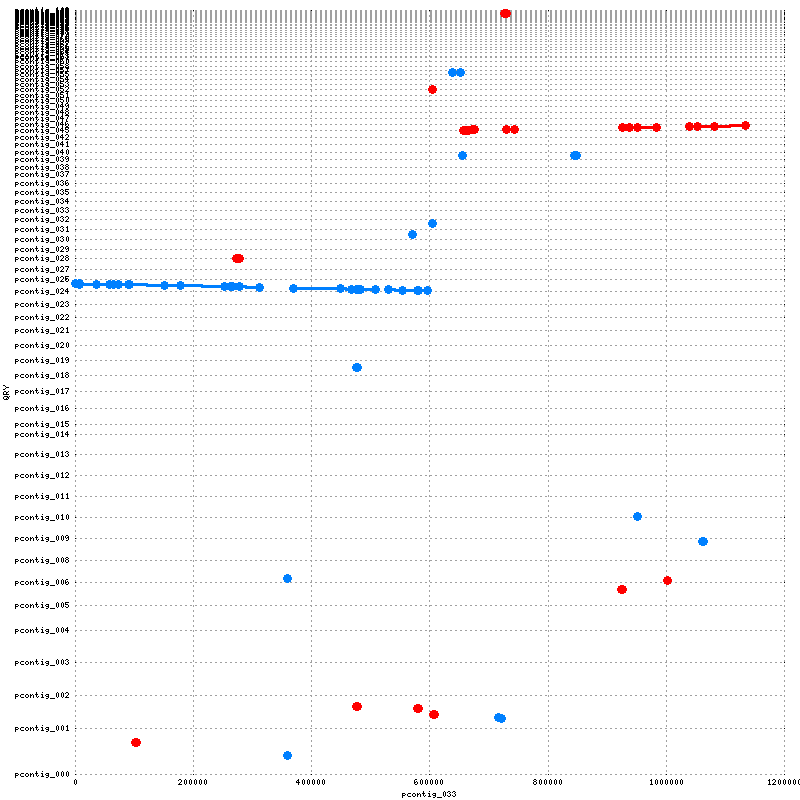

contig pcontig_034 of DK0911p with 1087912 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_034.png!

##########



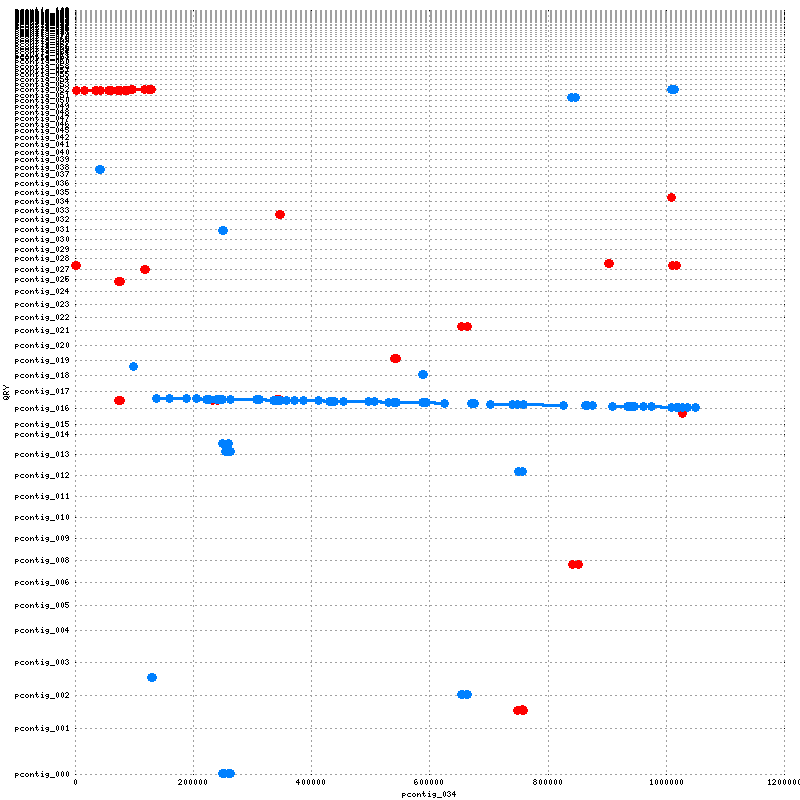

contig pcontig_035 of DK0911p with 1053446 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_035.png!

##########



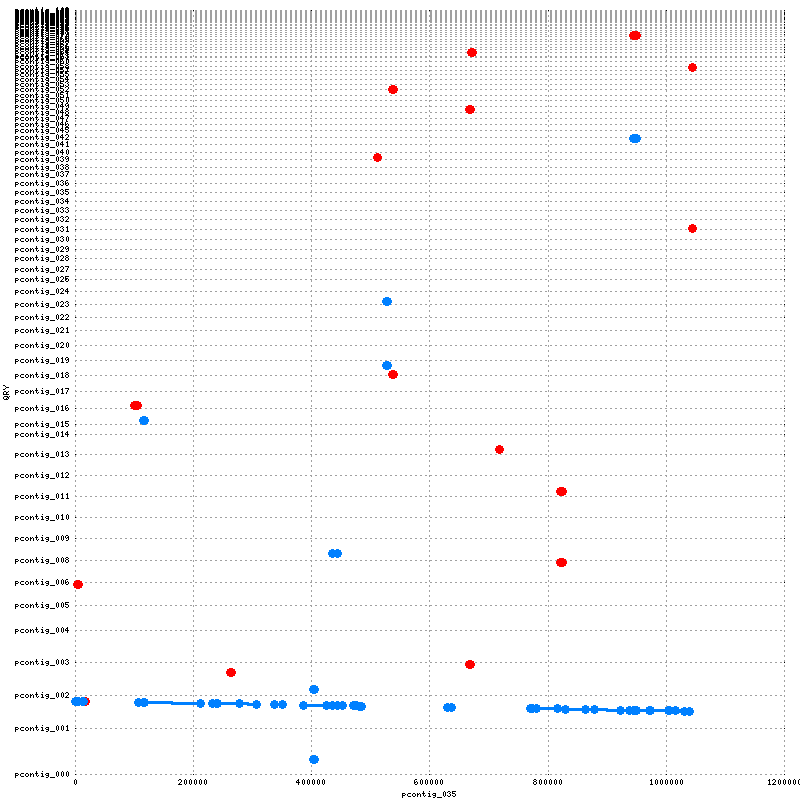

contig pcontig_036 of DK0911p with 908615 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_036.png!

##########



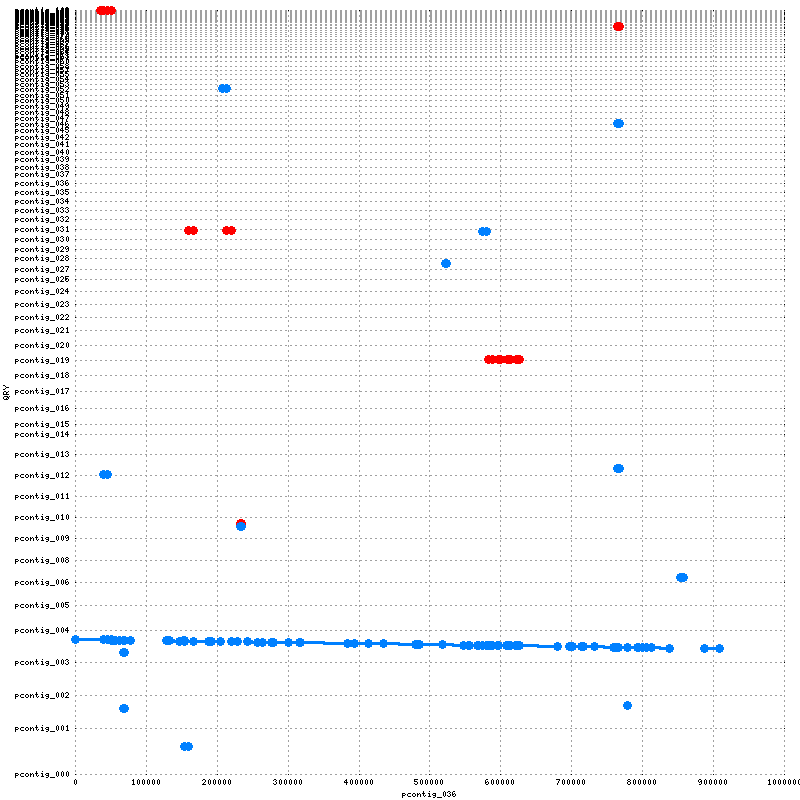

contig pcontig_037 of DK0911p with 935604 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_037.png!

##########



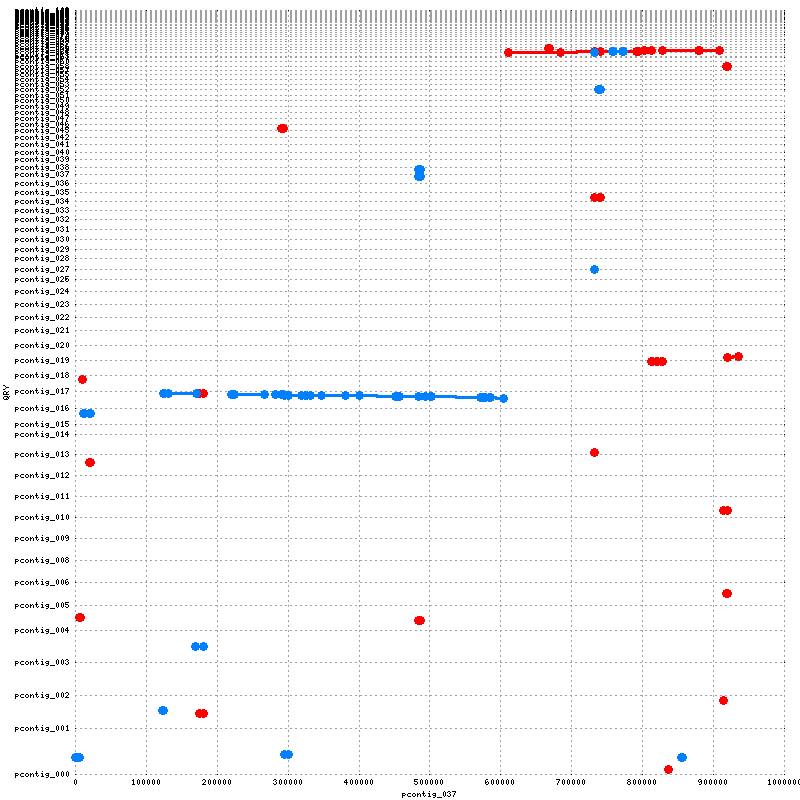

contig pcontig_039 of DK0911p with 918002 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_039.png!

##########



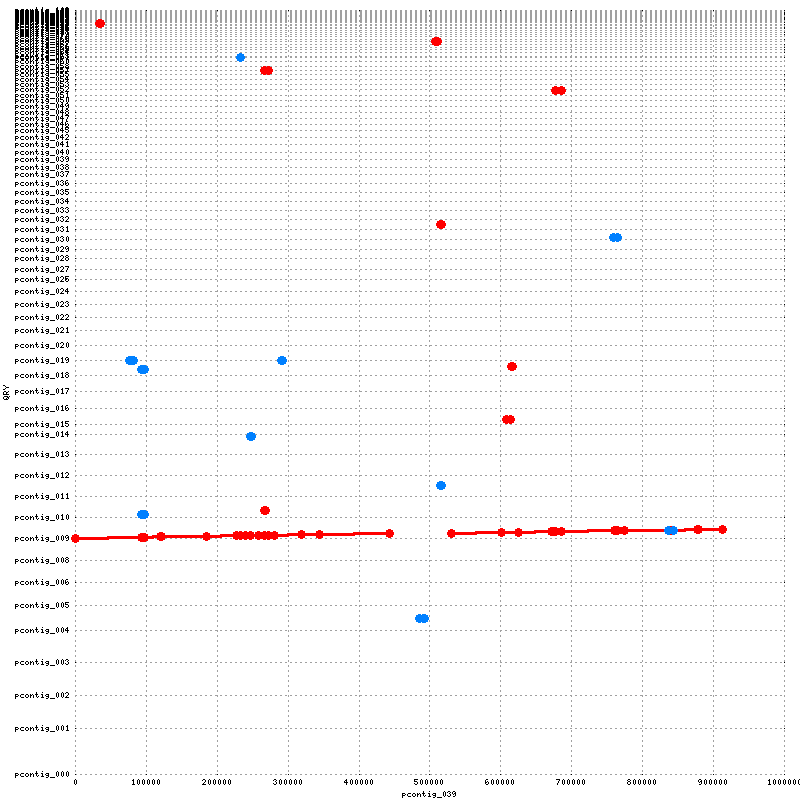

contig pcontig_040 of DK0911p with 867730 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_040.png!

##########



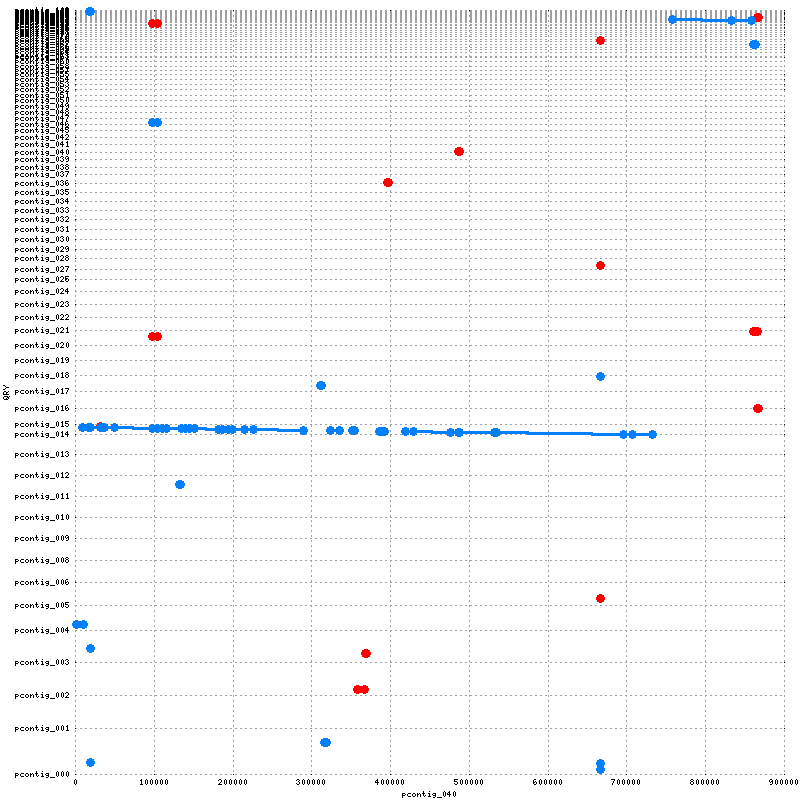

contig pcontig_041 of DK0911p with 819694 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_041.png!

##########



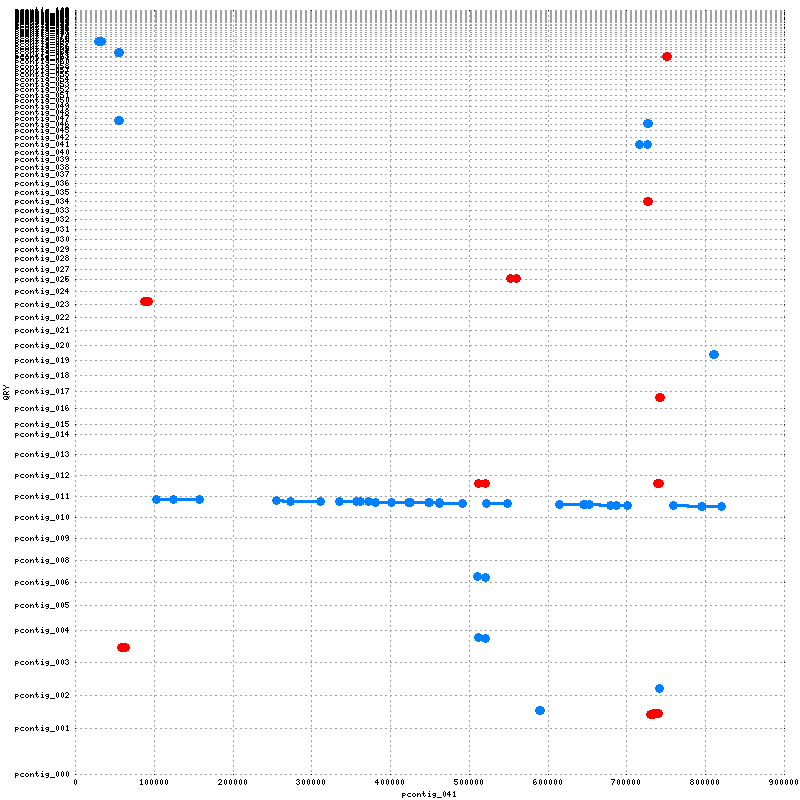

contig pcontig_042 of DK0911p with 784538 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_042.png!

##########



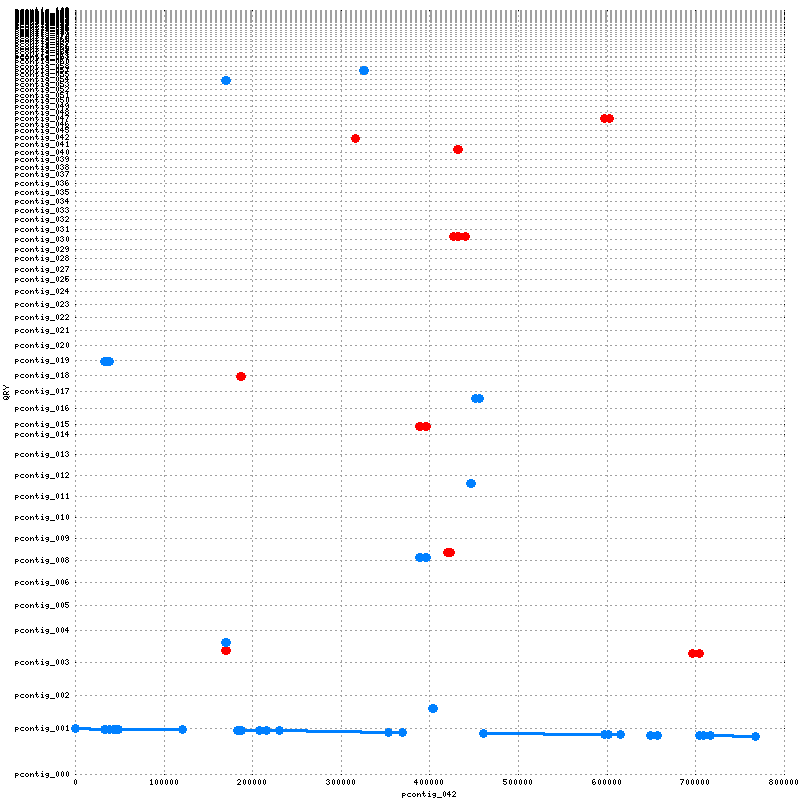

contig pcontig_043 of DK0911p with 807464 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_043.png!

##########



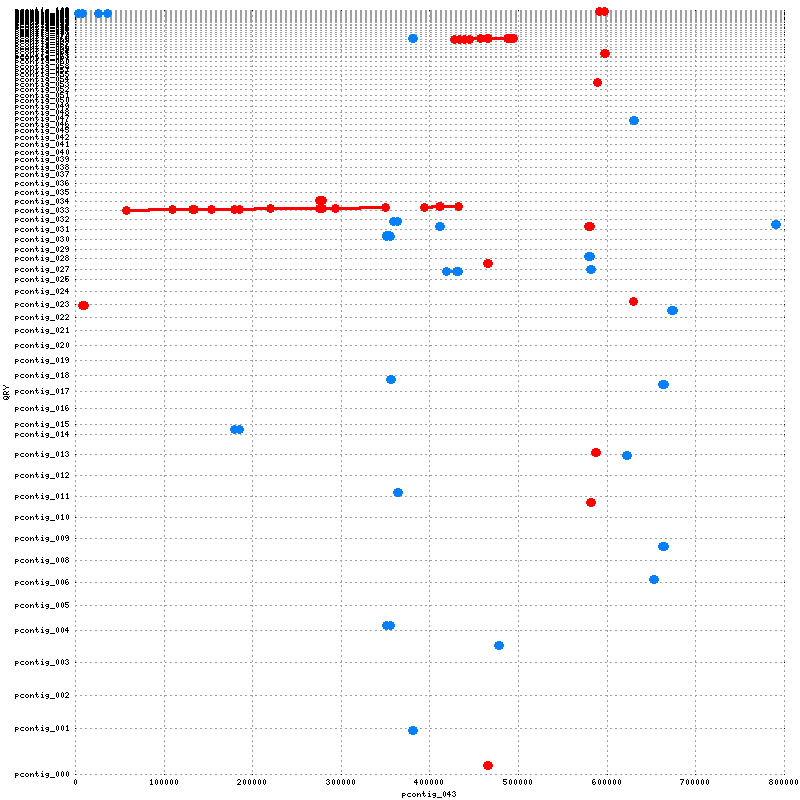

contig pcontig_044 of DK0911p with 737706 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_044.png!

##########



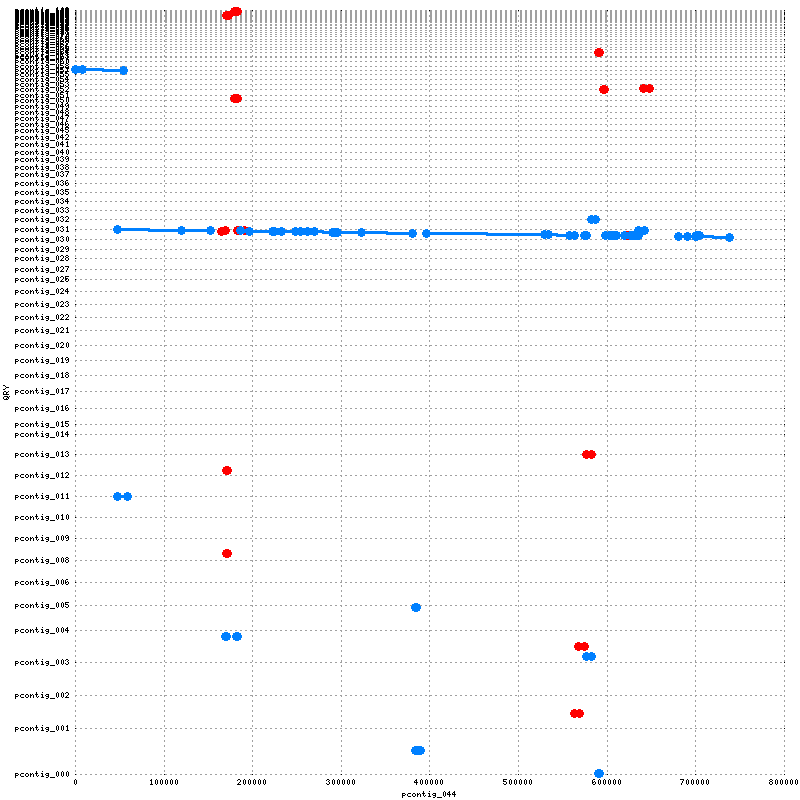

contig pcontig_045 of DK0911p with 705192 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_045.png!

##########



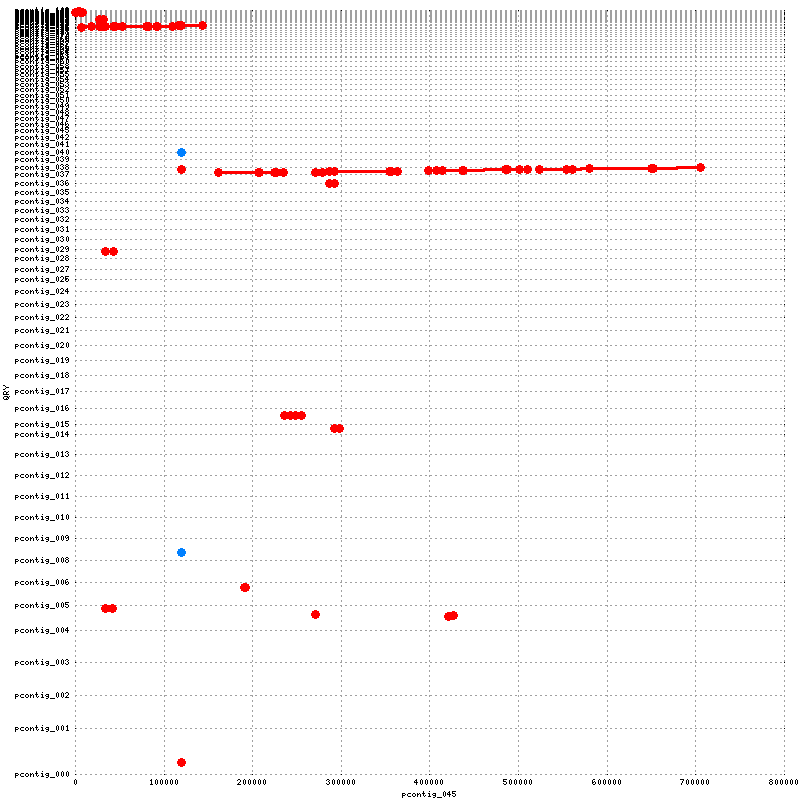

contig pcontig_046 of DK0911p with 720353 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_046.png!

##########



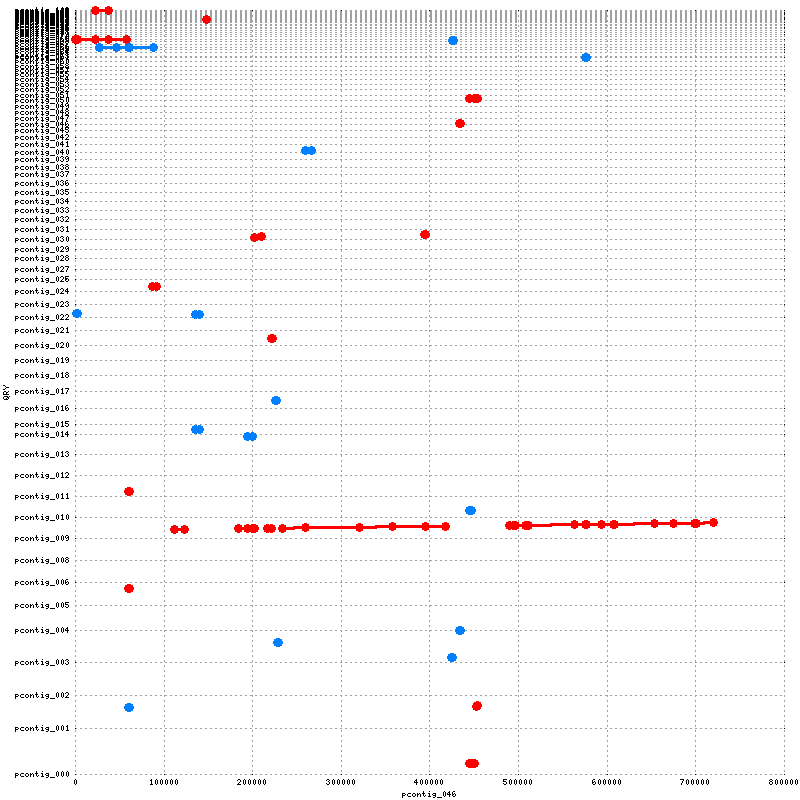

contig pcontig_047 of DK0911p with 695048 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_047.png!

##########



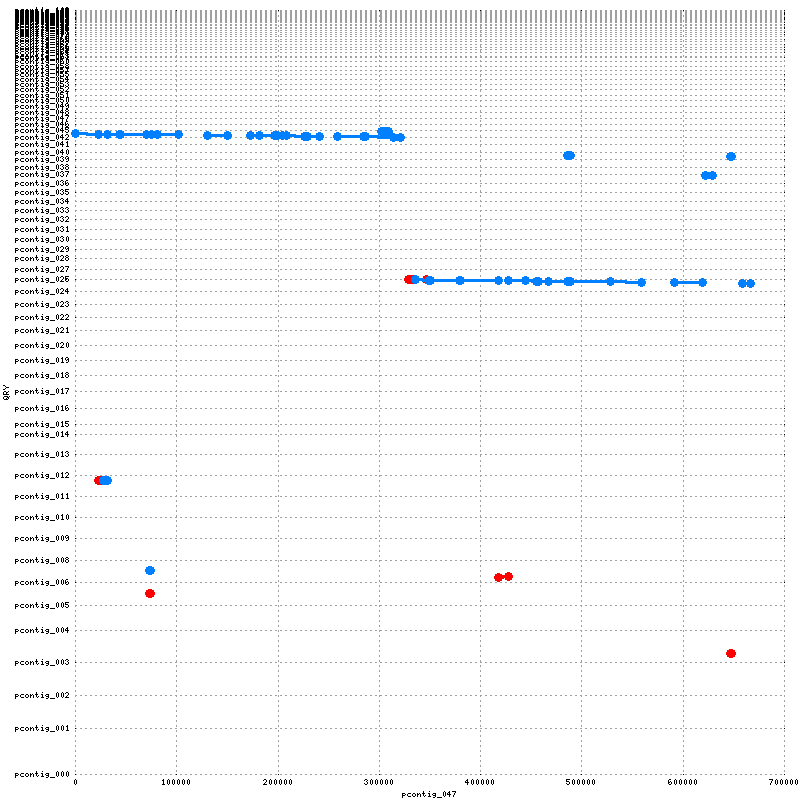

contig pcontig_048 of DK0911p with 667660 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_048.png!

##########



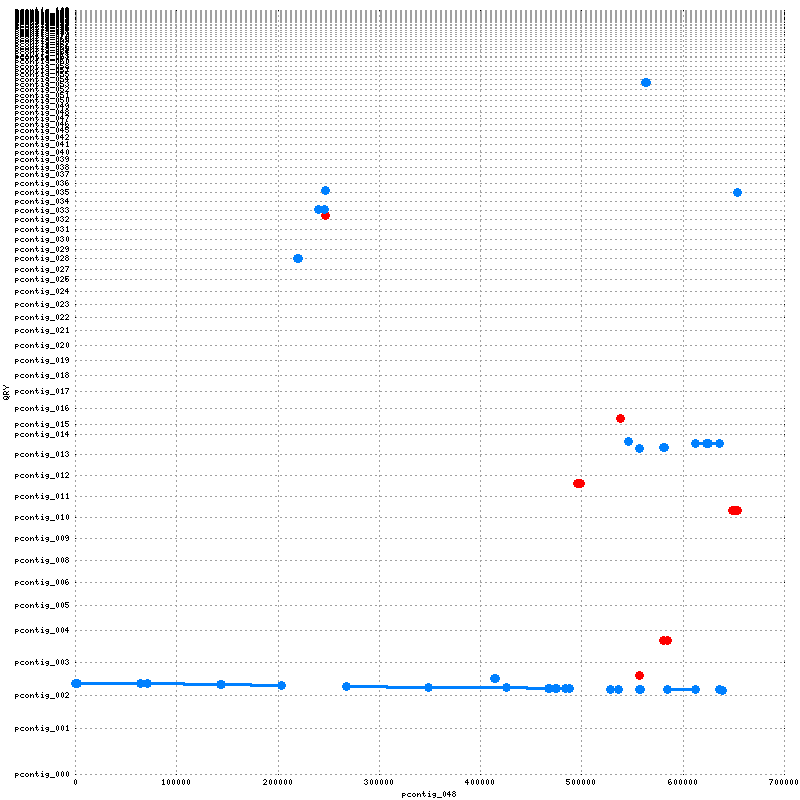

contig pcontig_049 of DK0911p with 666927 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_049.png!

##########



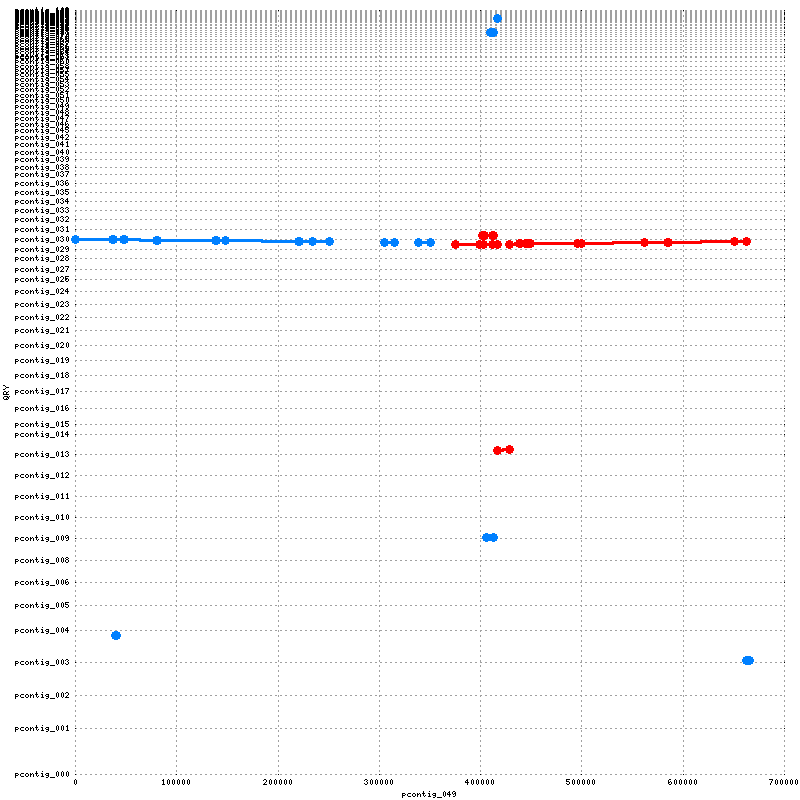

contig pcontig_050 of DK0911p with 688464 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_050.png!

##########



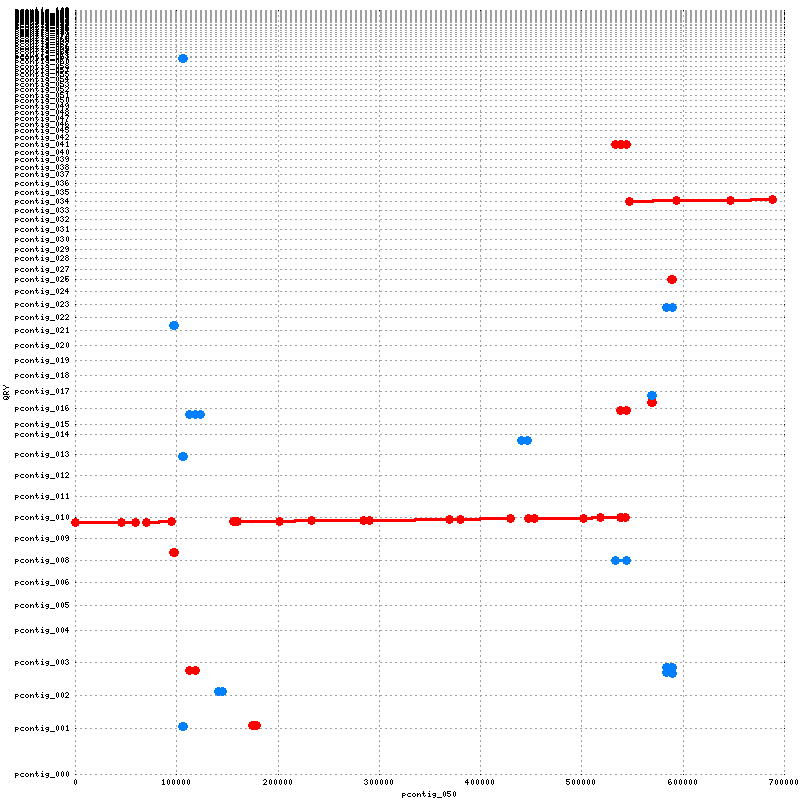

contig pcontig_051 of DK0911p with 224201 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_051.png!

##########



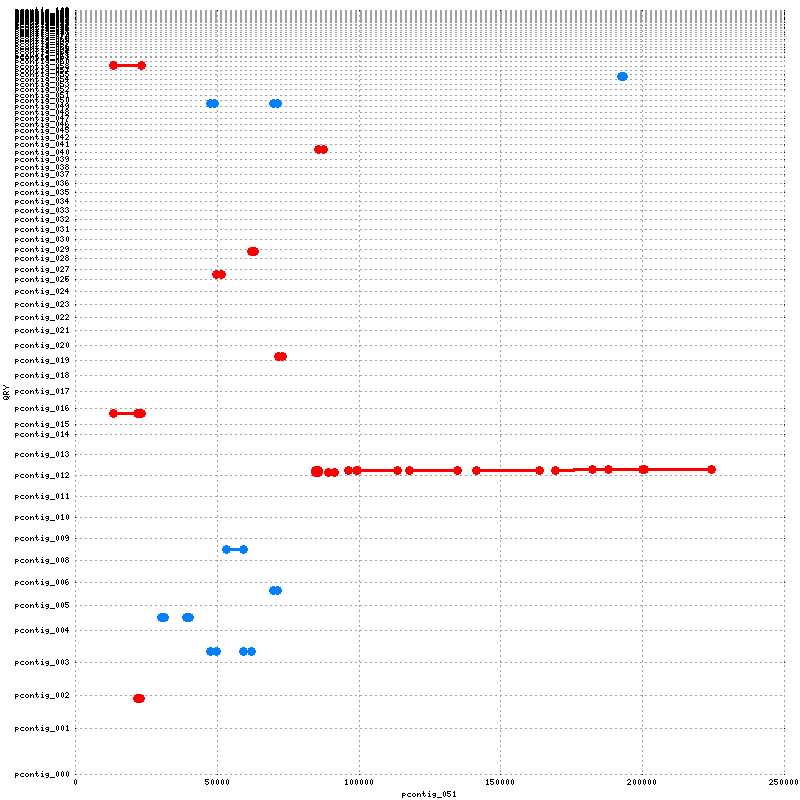

contig pcontig_052 of DK0911p with 670632 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_052.png!

##########



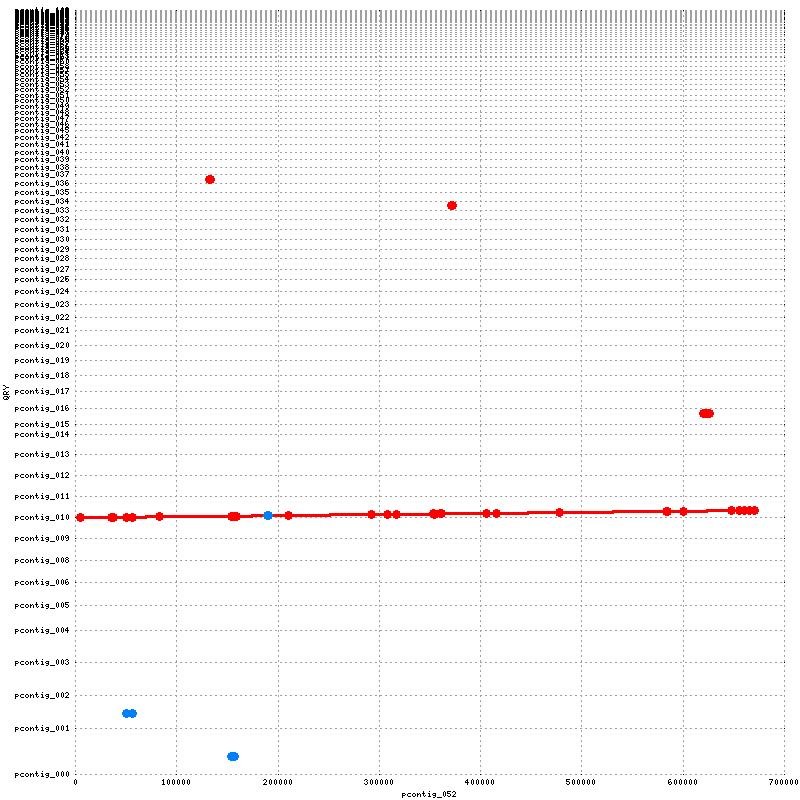

contig pcontig_054 of DK0911p with 591919 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_054.png!

##########



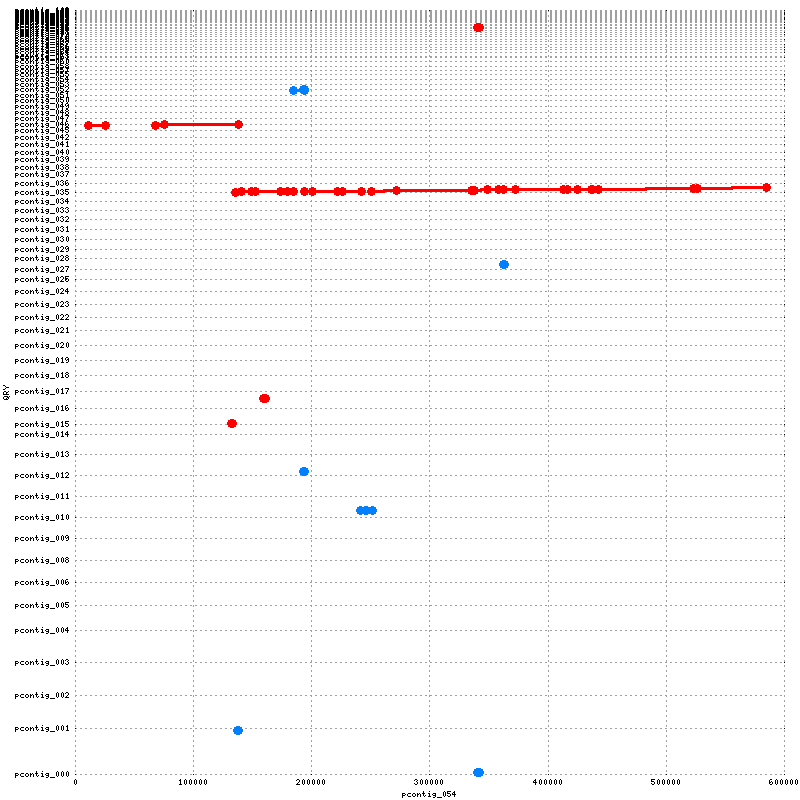

contig pcontig_055 of DK0911p with 638026 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_055.png!

##########



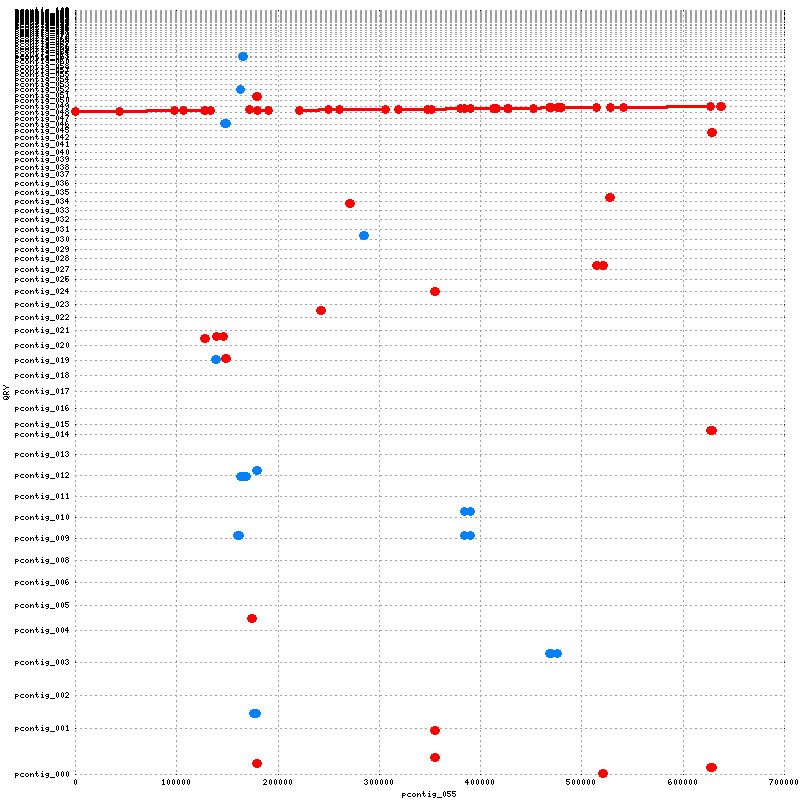

contig pcontig_056 of DK0911p with 611609 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_056.png!

##########



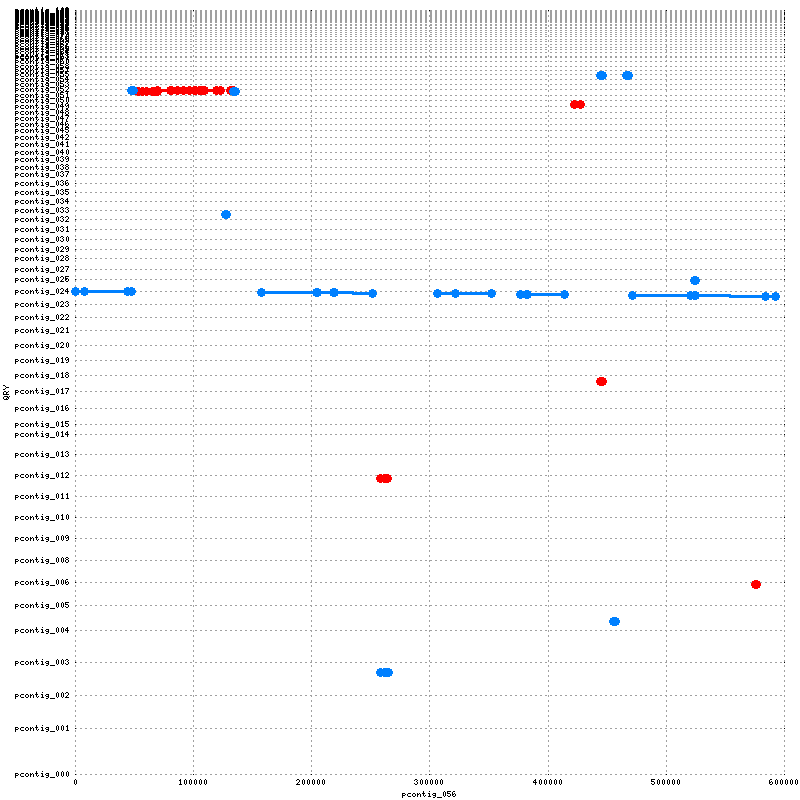

contig pcontig_057 of DK0911p with 561118 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_057.png!

##########



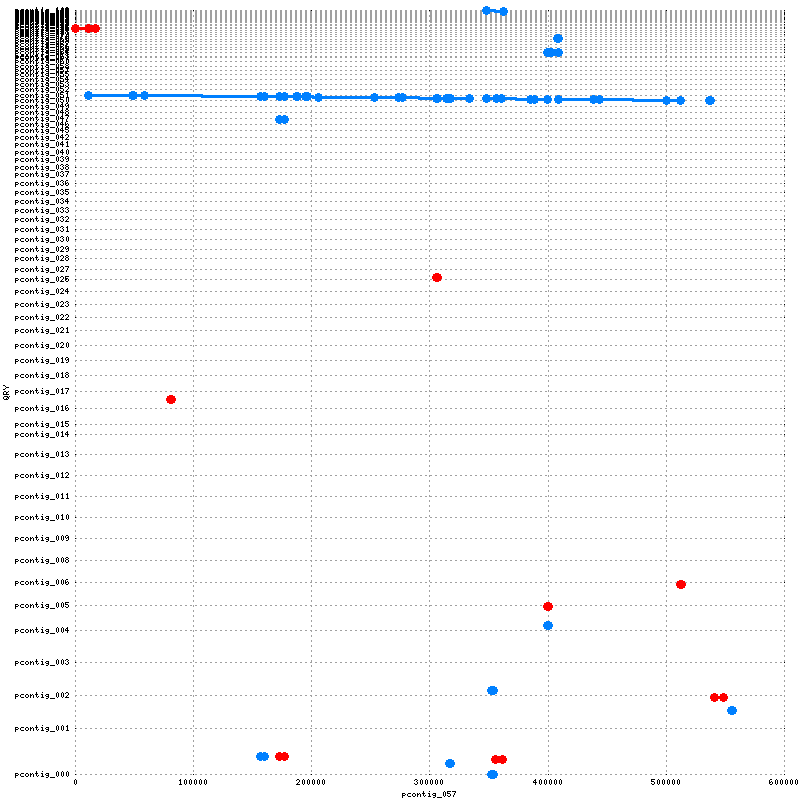

contig pcontig_058 of DK0911p with 572617 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_058.png!

##########



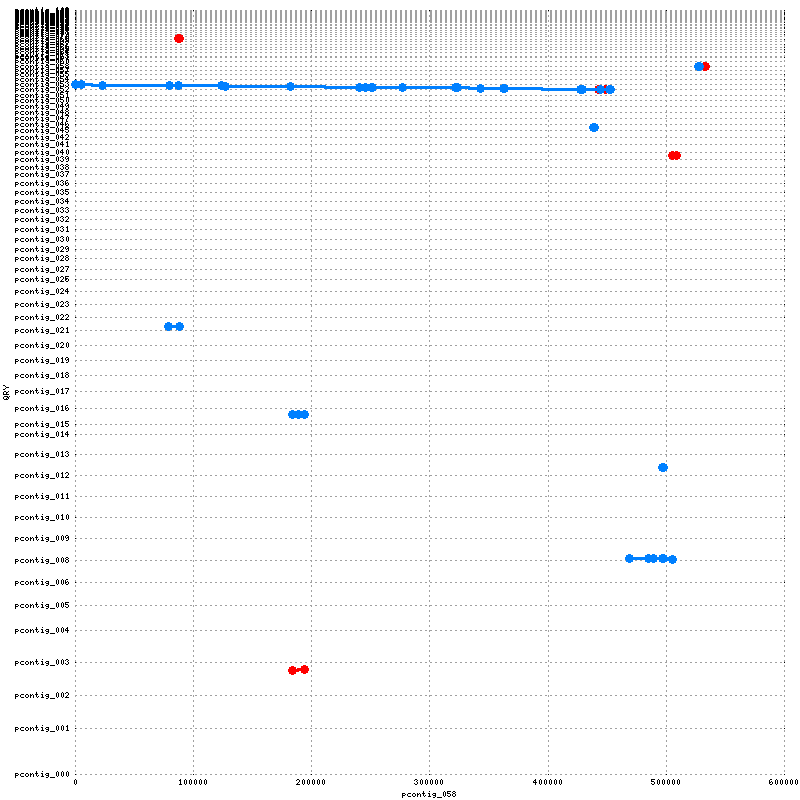

contig pcontig_059 of DK0911p with 473515 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_059.png!

##########



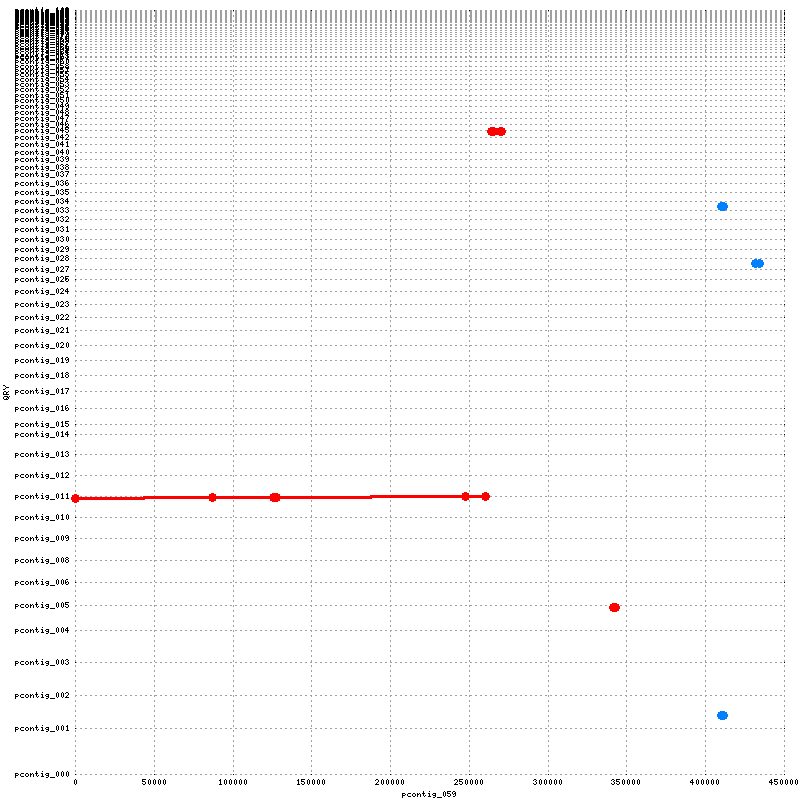

contig pcontig_060 of DK0911p with 524137 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_060.png!

##########



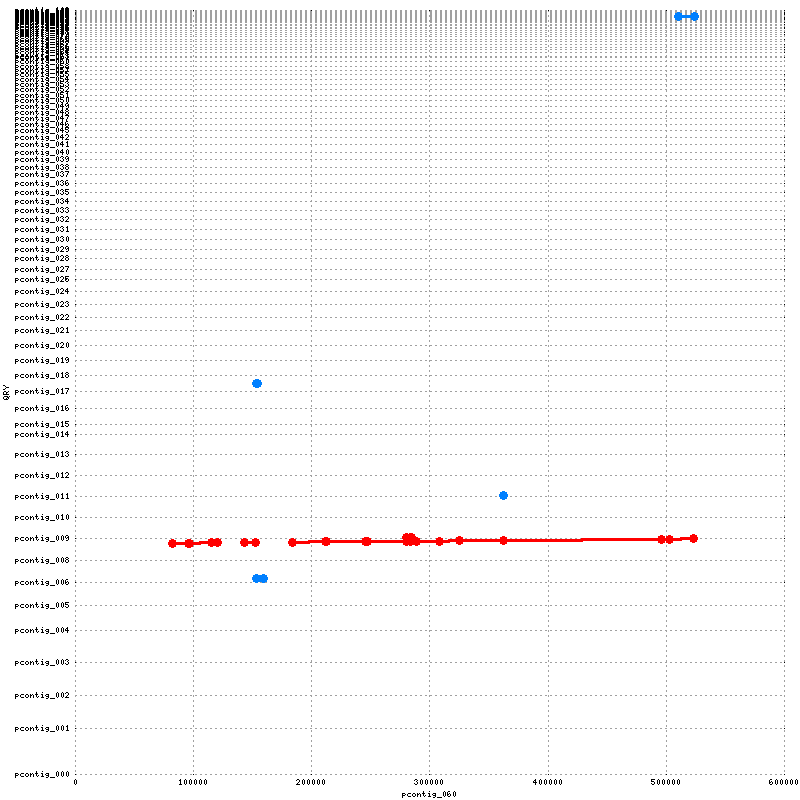

contig pcontig_062 of DK0911p with 503905 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_062.png!

##########



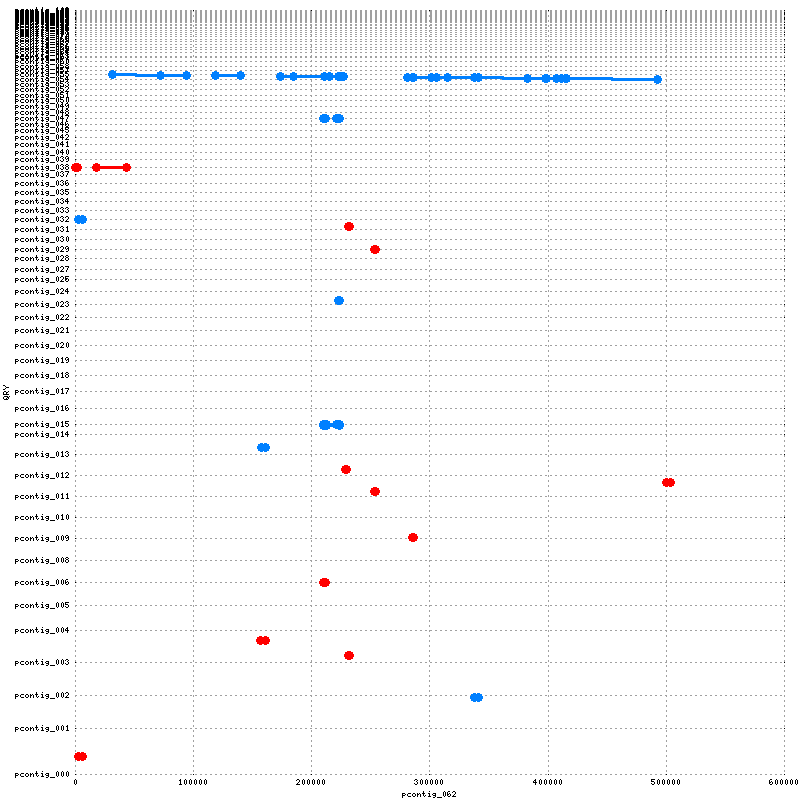

contig pcontig_063 of DK0911p with 73798 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_063.png!

##########



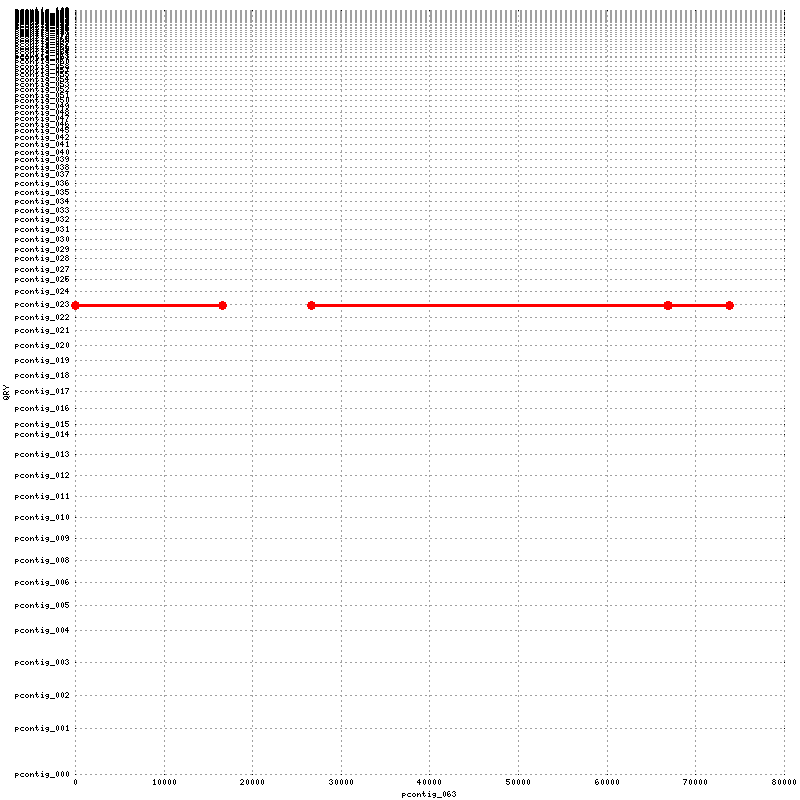

contig pcontig_064 of DK0911p with 485233 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_064.png!

##########



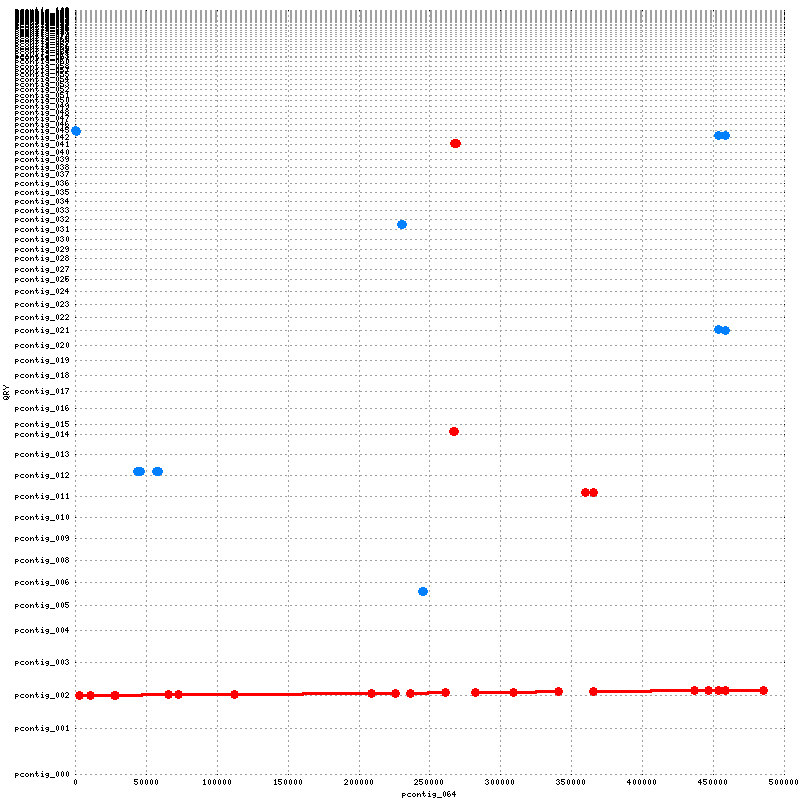

contig pcontig_065 of DK0911p with 509653 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_065.png!

##########



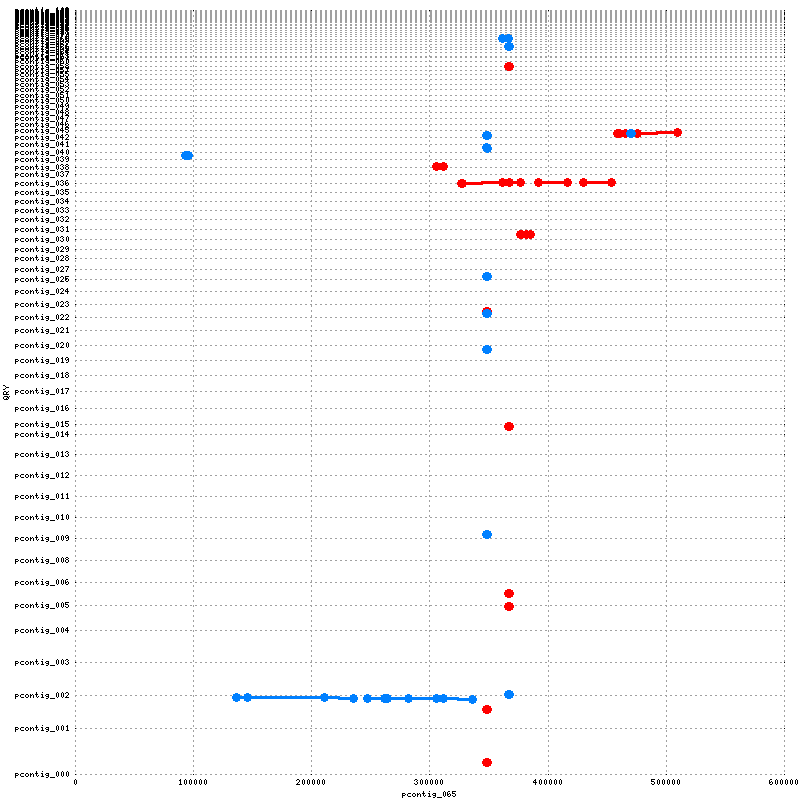

contig pcontig_066 of DK0911p with 479201 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_066.png!

##########



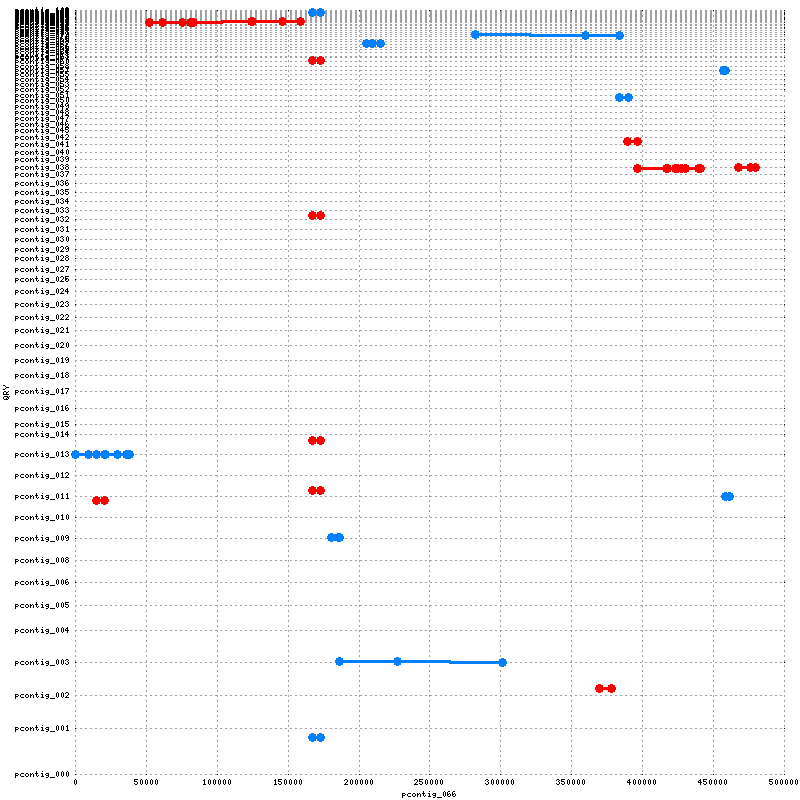

contig pcontig_067 of DK0911p with 472876 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_067.png!

##########



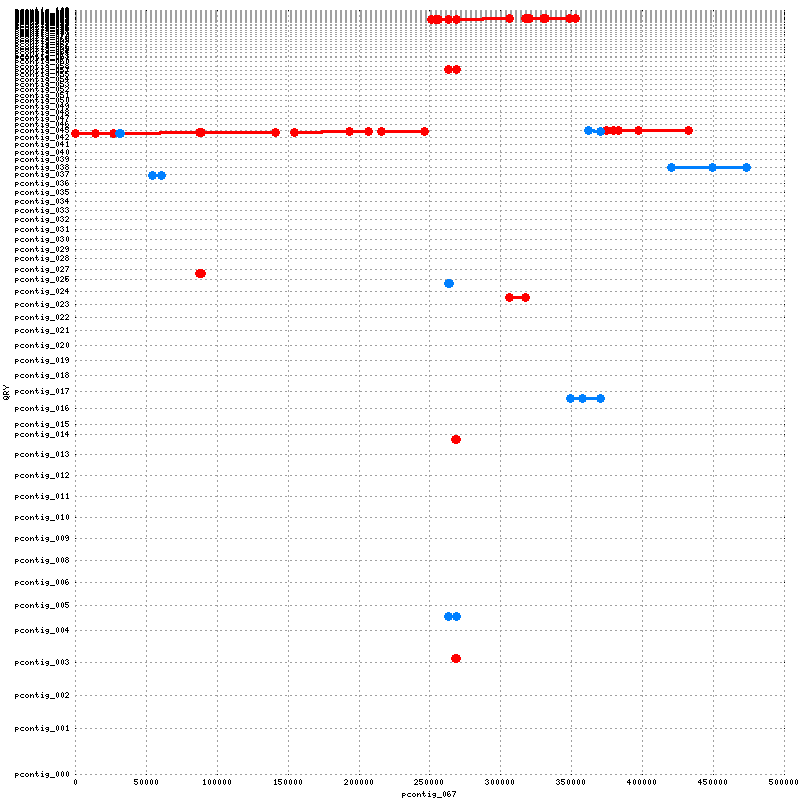

contig pcontig_068 of DK0911p with 468292 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_068.png!

##########



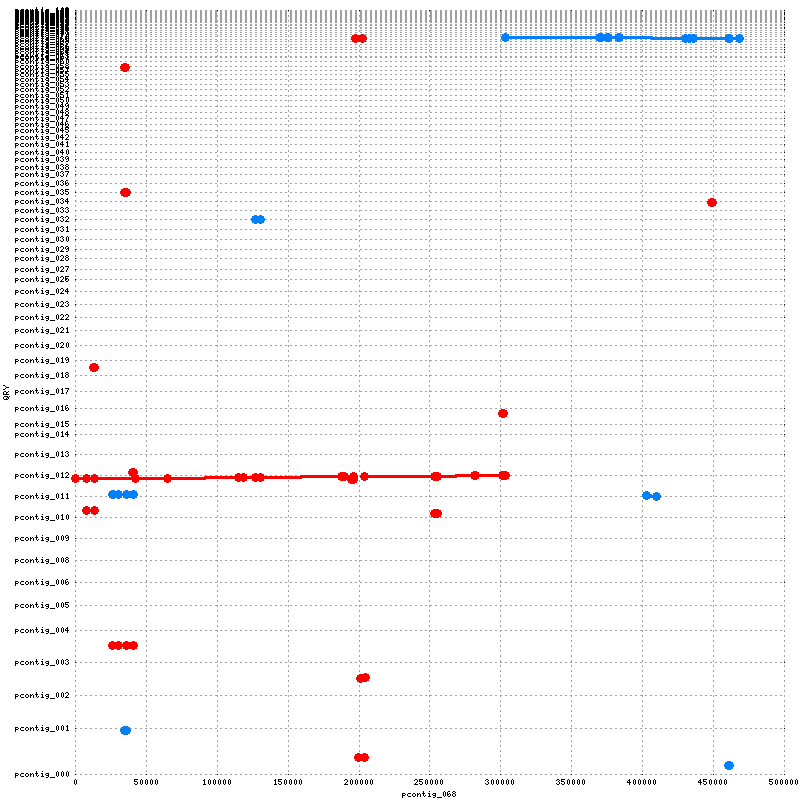

contig pcontig_069 of DK0911p with 455598 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_069.png!

##########



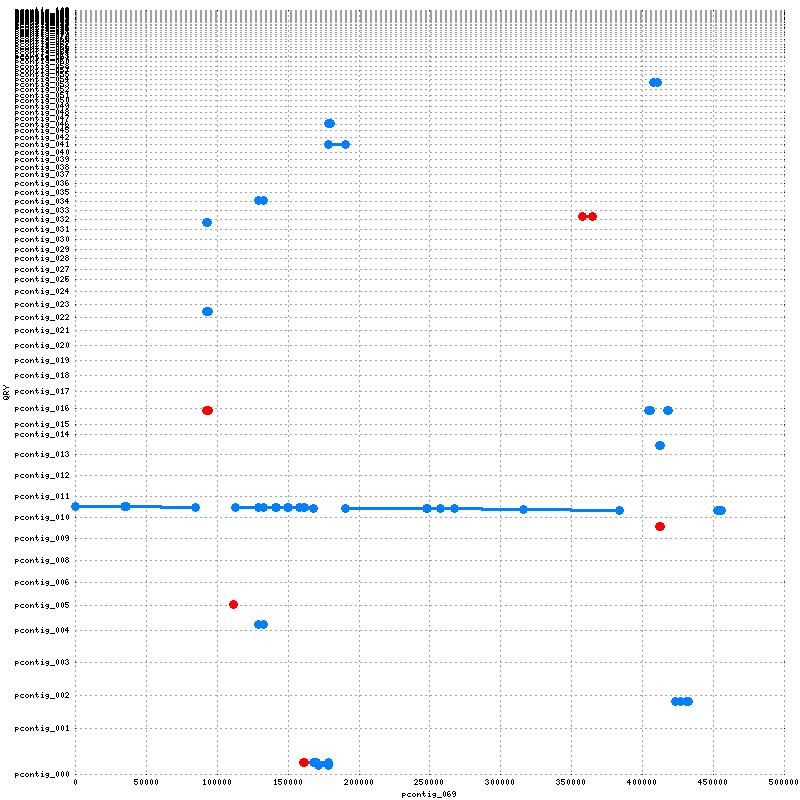

contig pcontig_070 of DK0911p with 479229 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_070.png!

##########



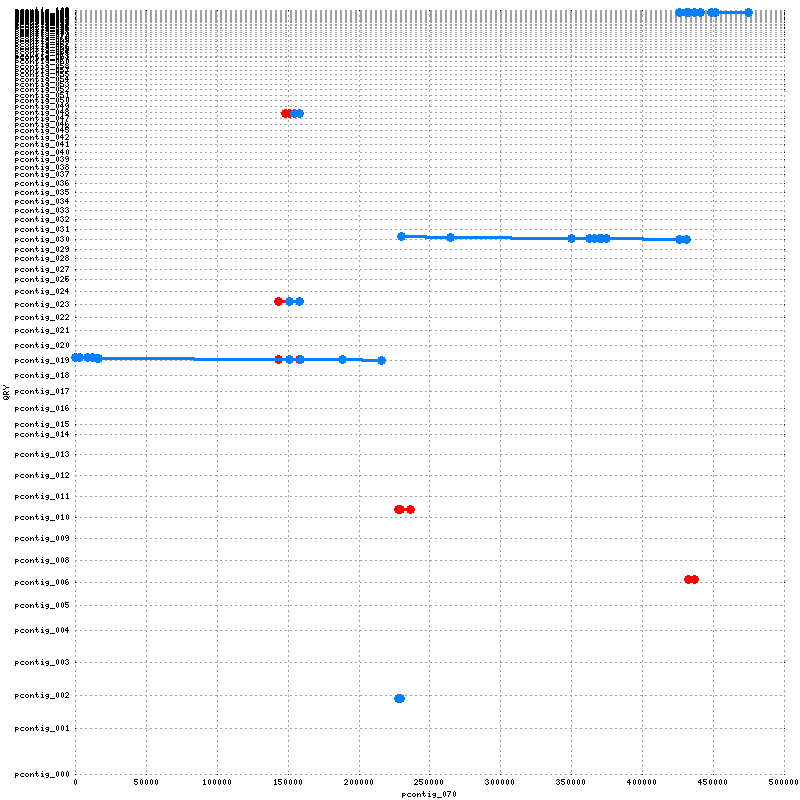

contig pcontig_072 of DK0911p with 435429 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_072.png!

##########



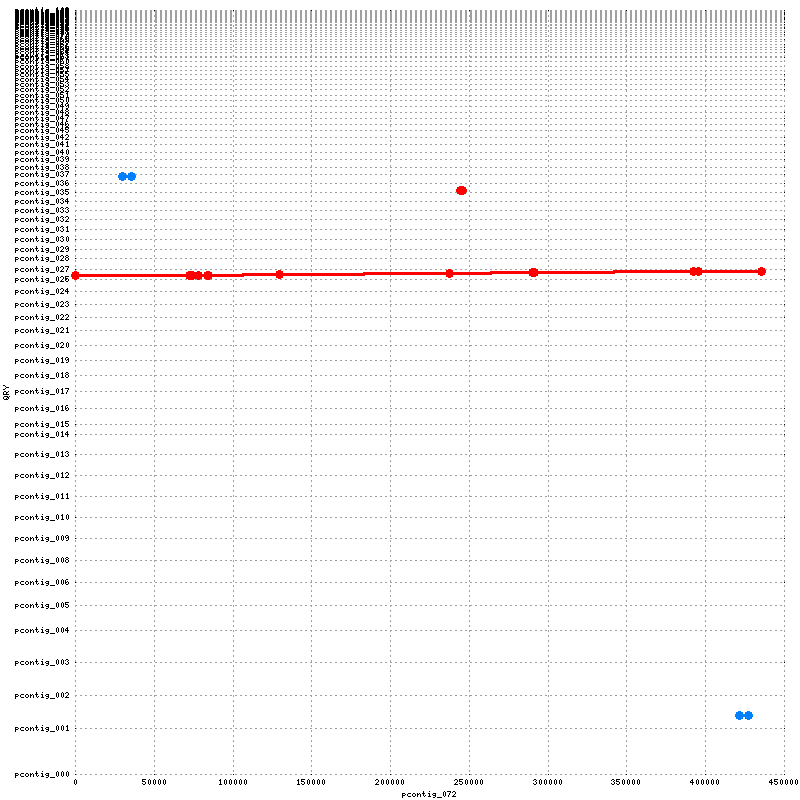

contig pcontig_073 of DK0911p with 432775 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_073.png!

##########



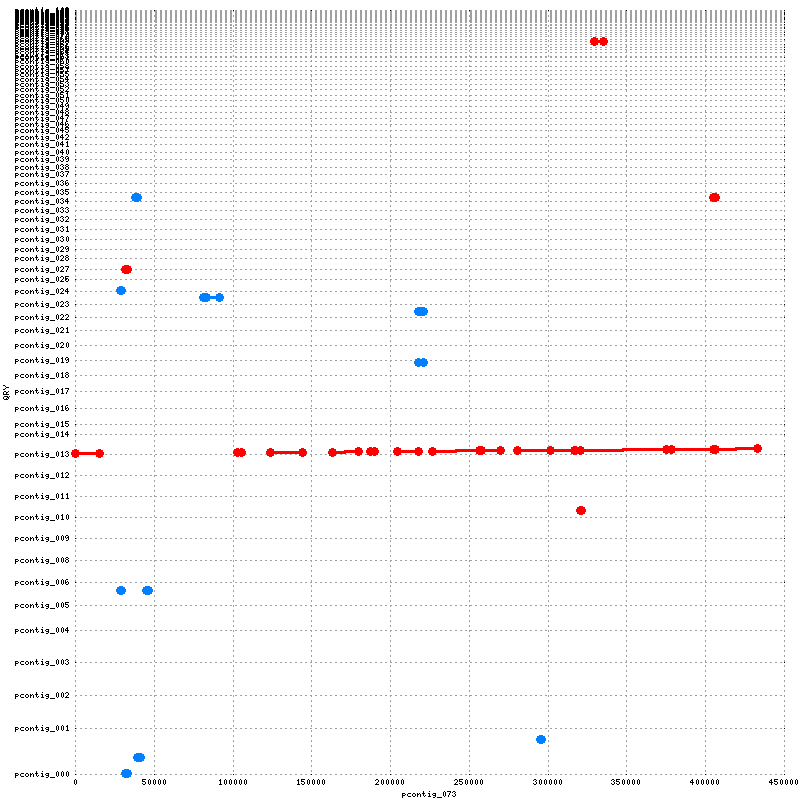

contig pcontig_074 of DK0911p with 427065 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_074.png!

##########



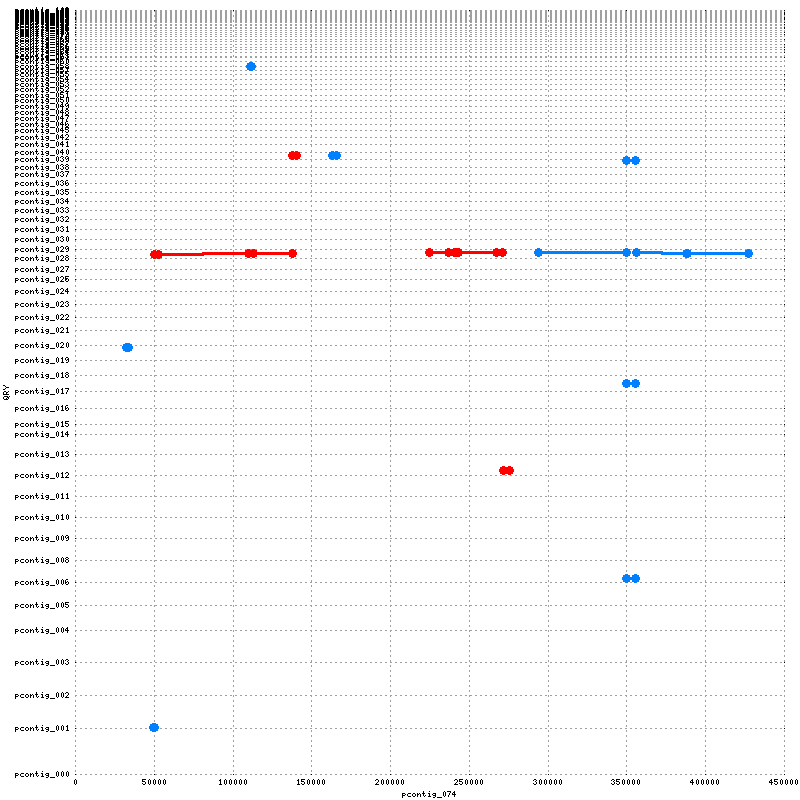

contig pcontig_075 of DK0911p with 411118 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_075.png!

##########



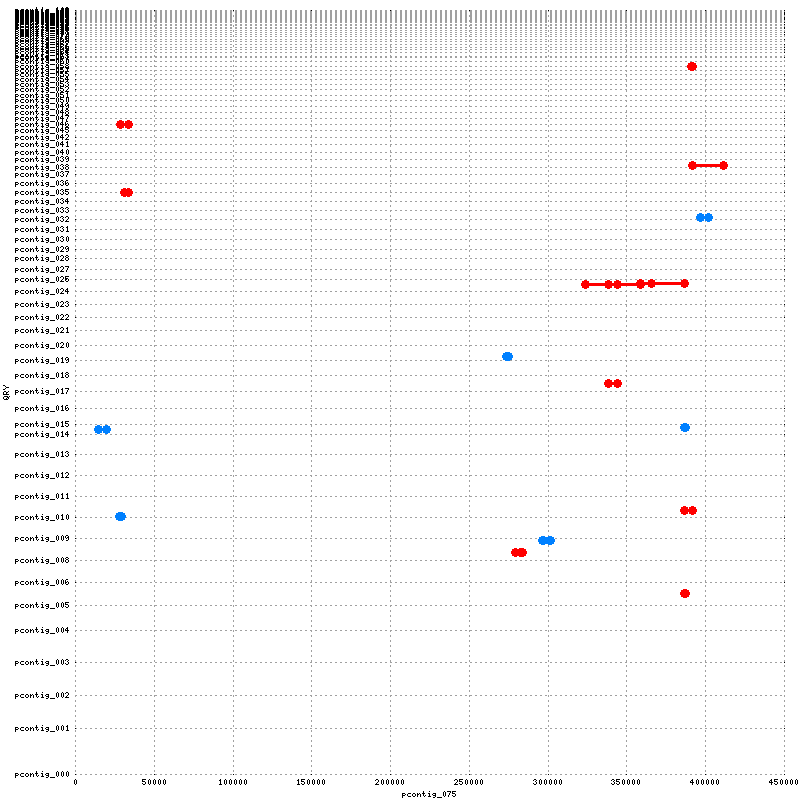

contig pcontig_077 of DK0911p with 371300 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_077.png!

##########



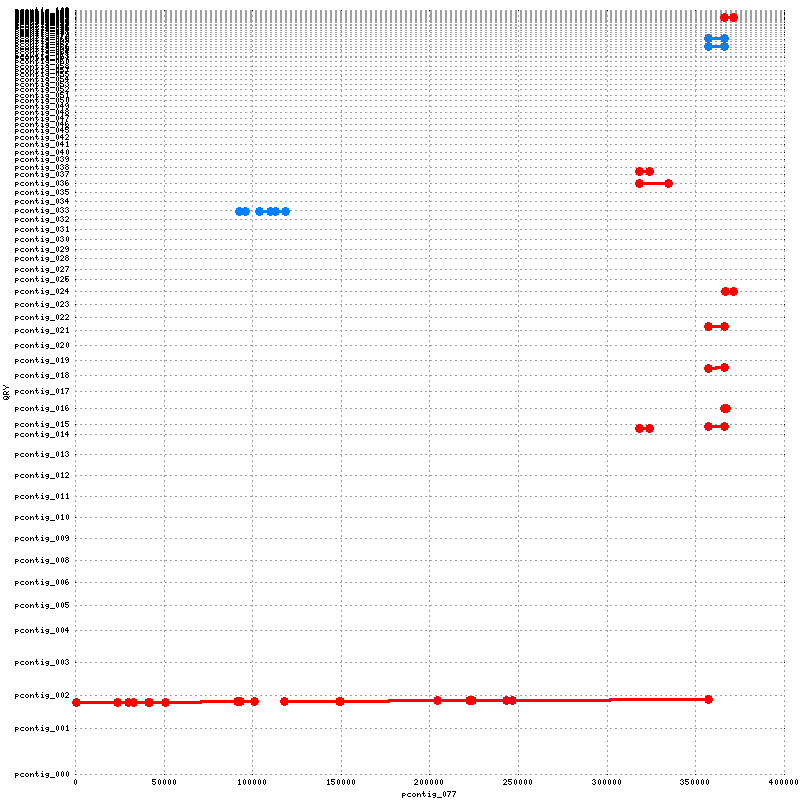

contig pcontig_078 of DK0911p with 341960 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_078.png!

##########



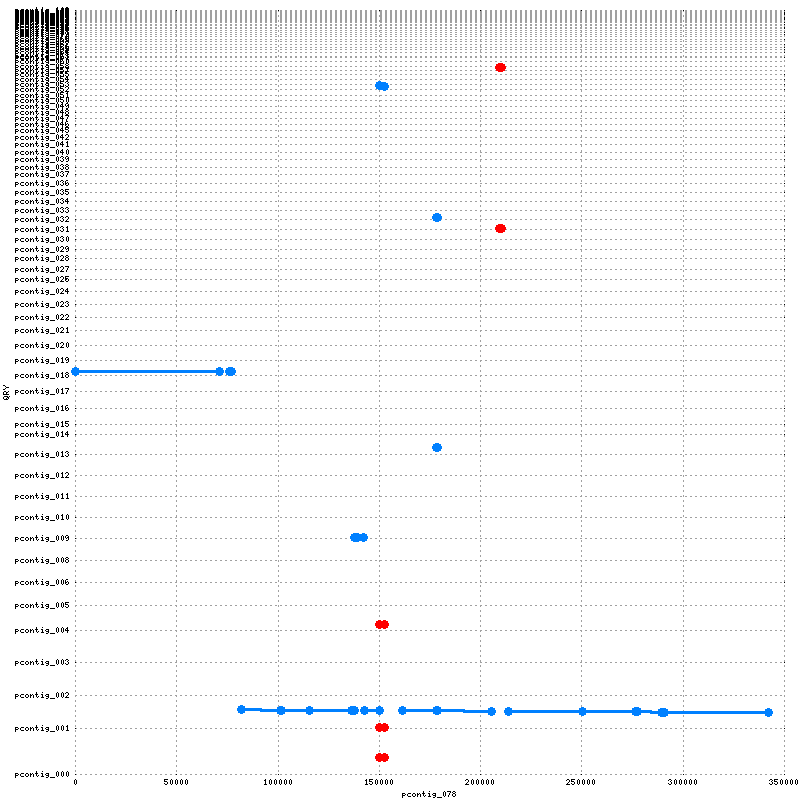

contig pcontig_079 of DK0911p with 40338 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_079.png!

##########



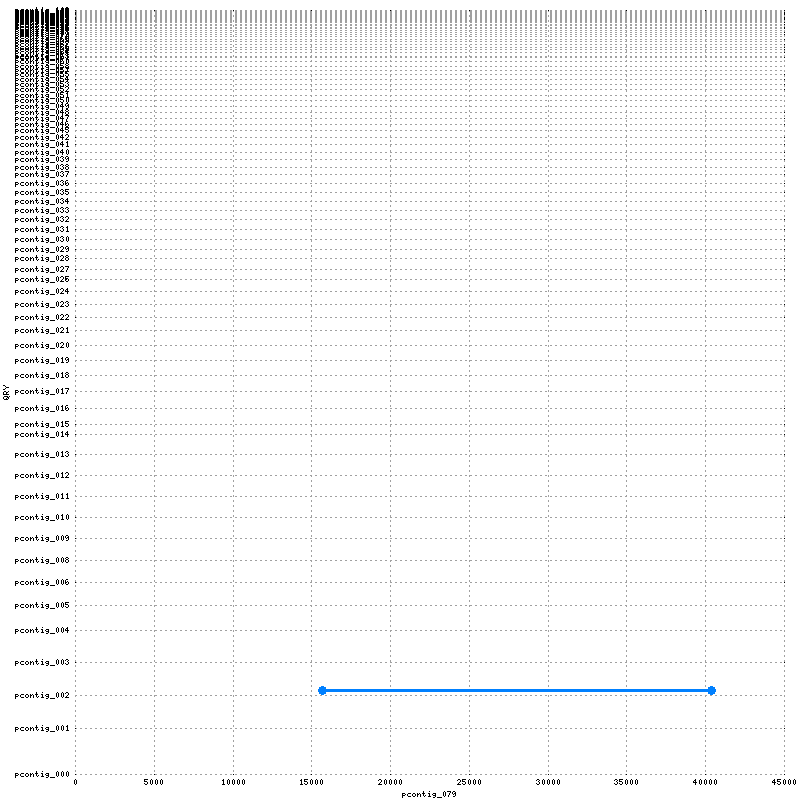

contig pcontig_080 of DK0911p with 330108 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_080.png!

##########



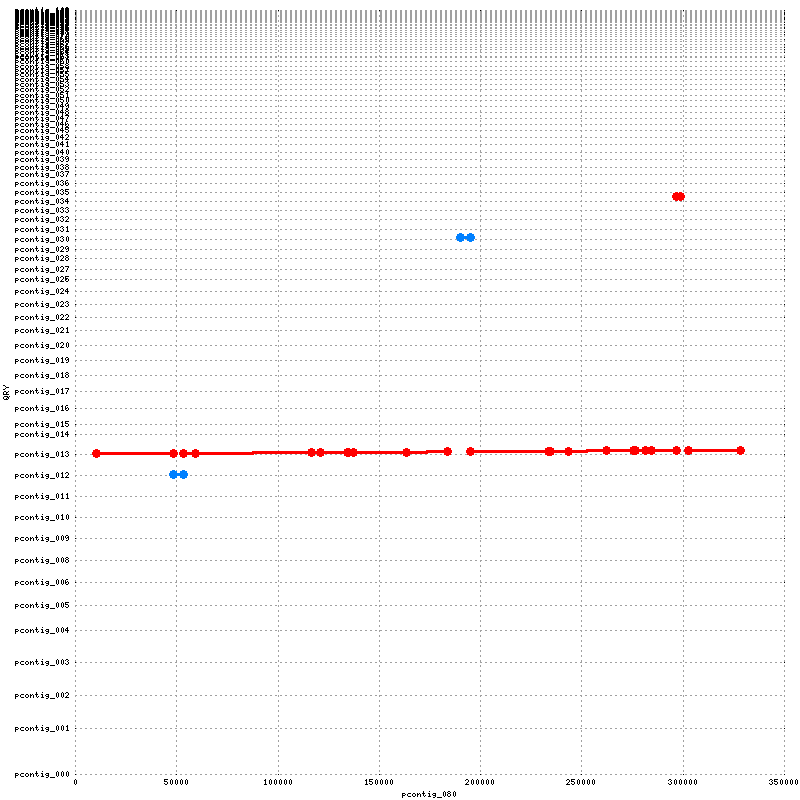

contig pcontig_081 of DK0911p with 308416 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_081.png!

##########



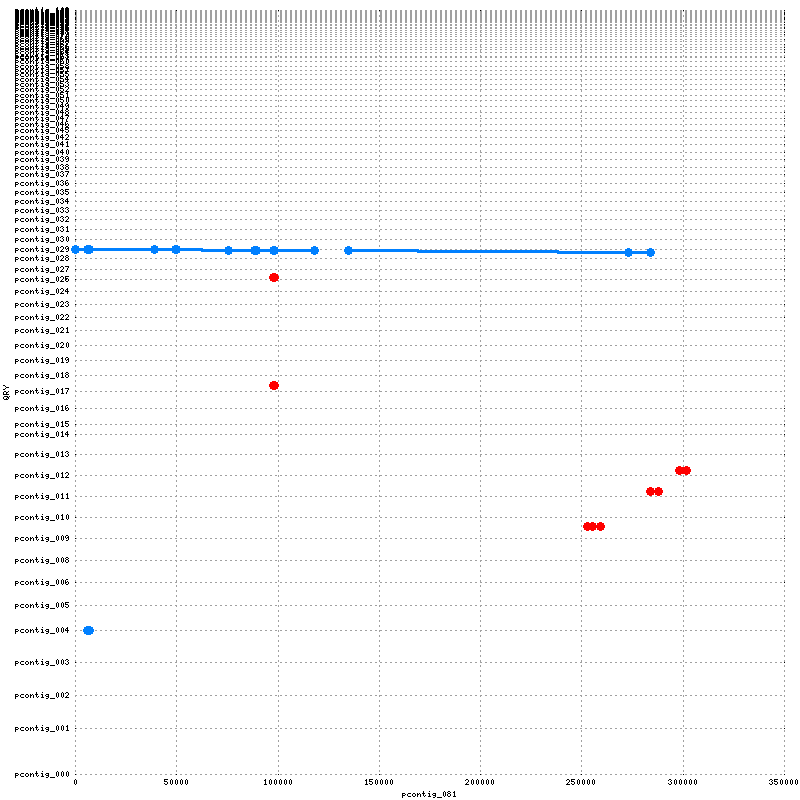

contig pcontig_082 of DK0911p with 305091 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_082.png!

##########



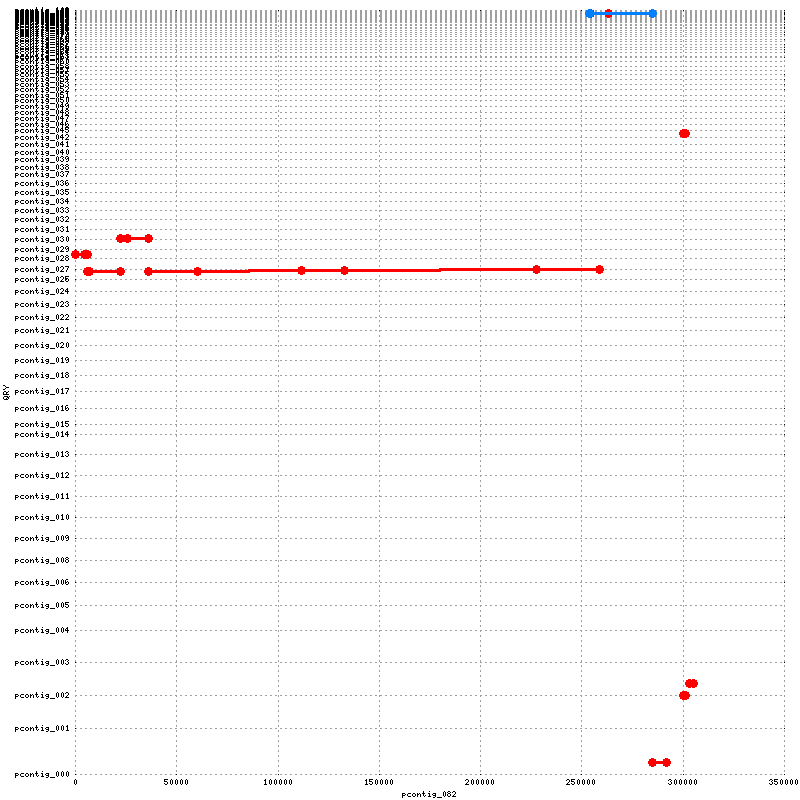

contig pcontig_083 of DK0911p with 312556 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_083.png!

##########



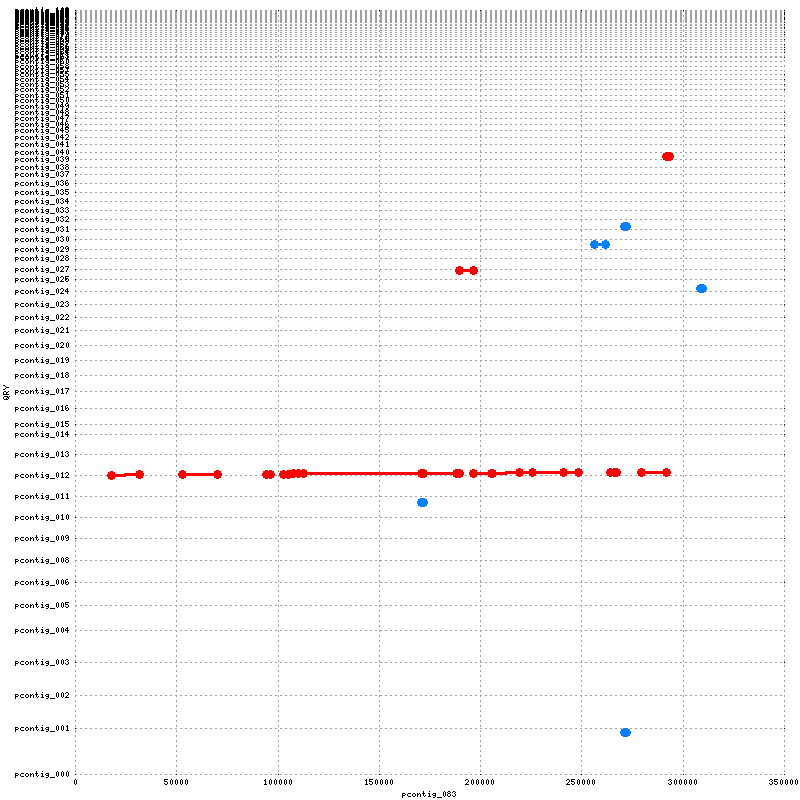

contig pcontig_084 of DK0911p with 269151 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_084.png!

##########



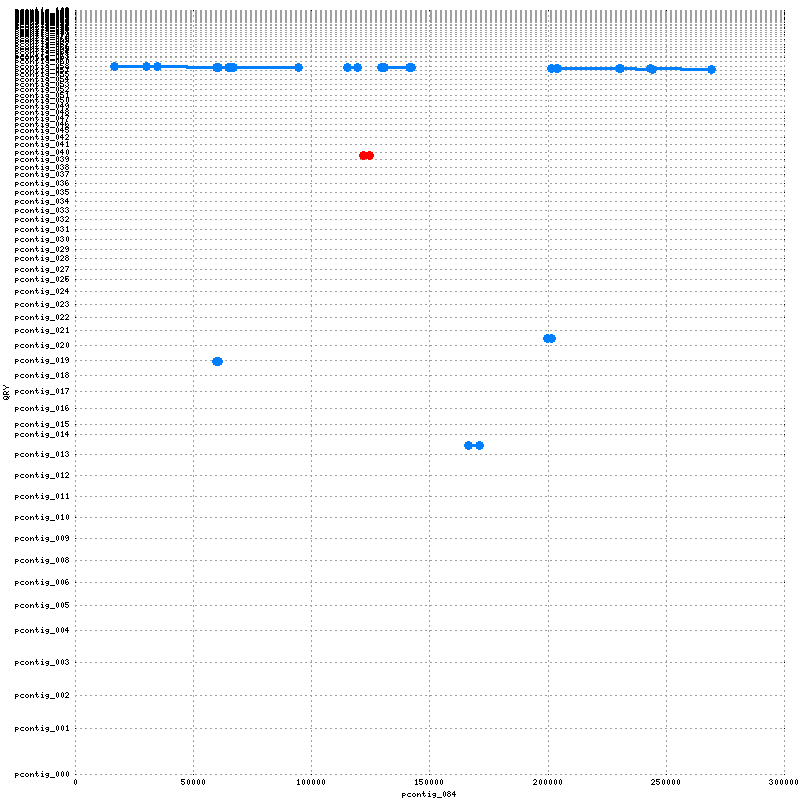

contig pcontig_086 of DK0911p with 273674 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_086.png!

##########



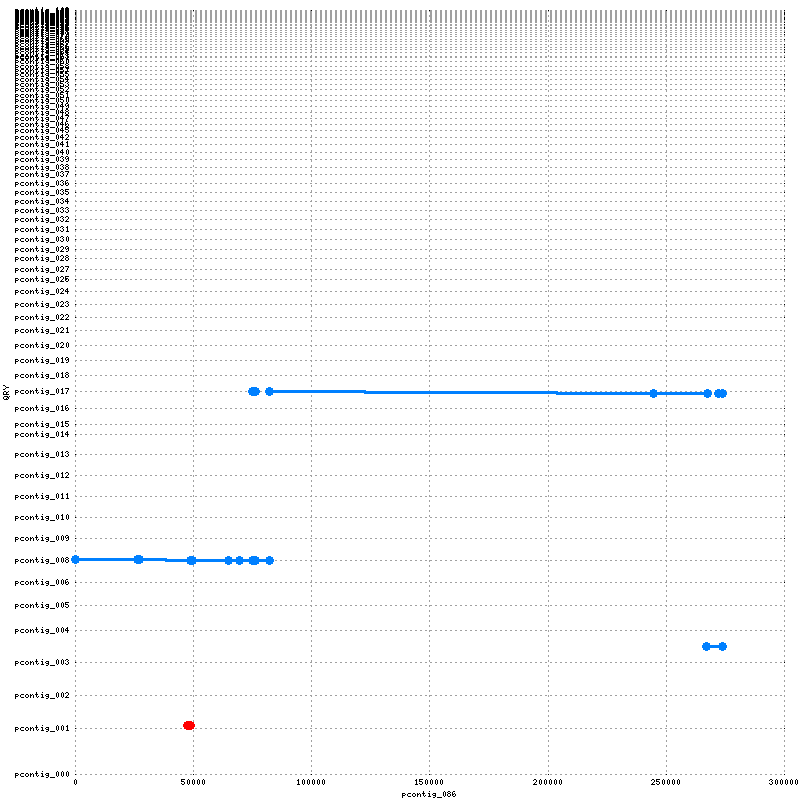

contig pcontig_087 of DK0911p with 279112 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_087.png!

##########



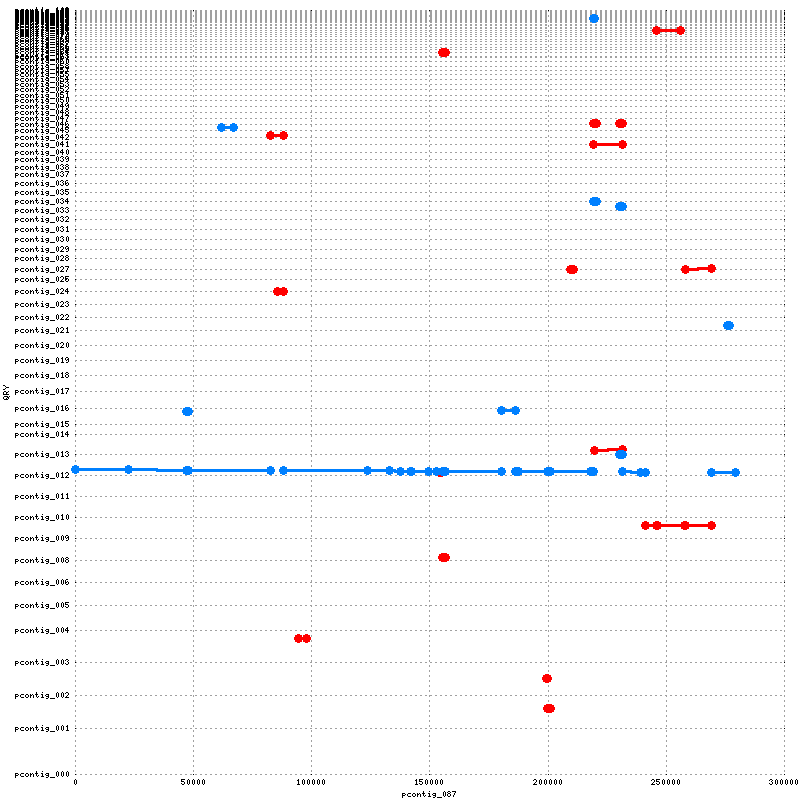

contig pcontig_088 of DK0911p with 268281 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_088.png!

##########



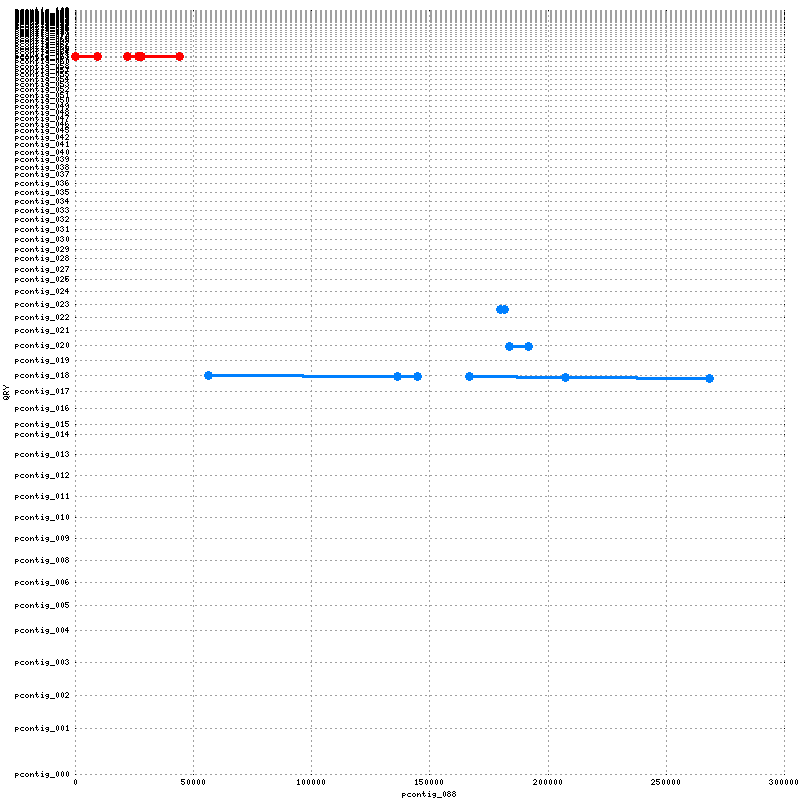

contig pcontig_089 of DK0911p with 251630 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_089.png!

##########



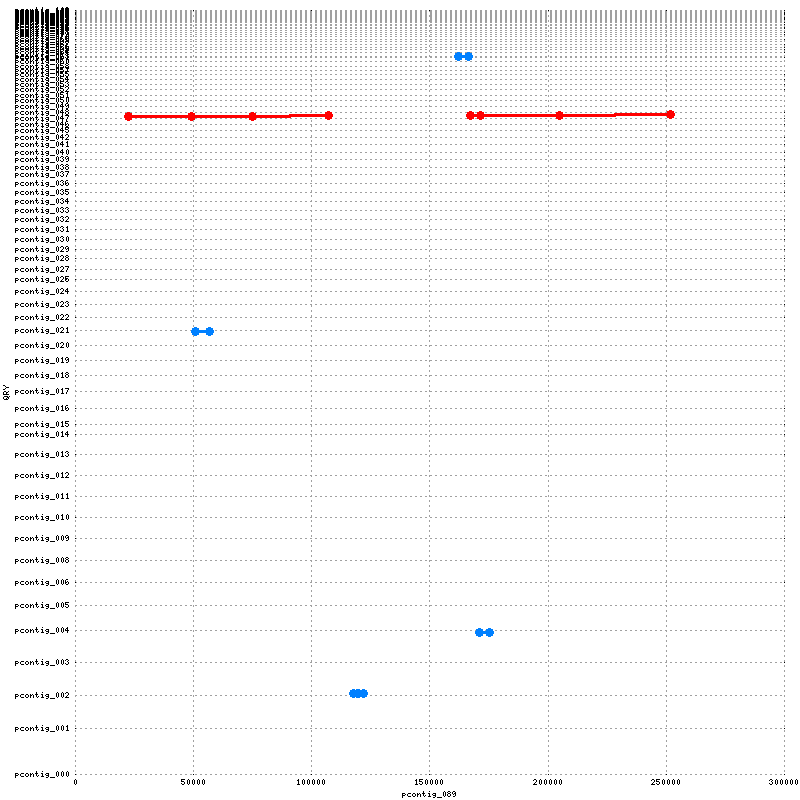

contig pcontig_090 of DK0911p with 226444 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_090.png!

##########



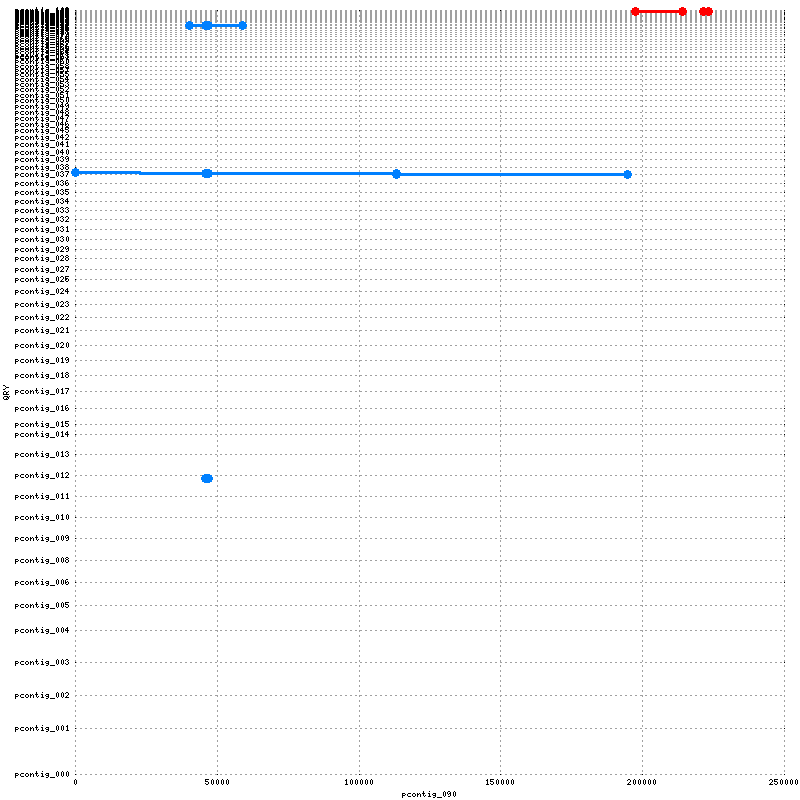

contig pcontig_091 of DK0911p with 218692 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_091.png!

##########



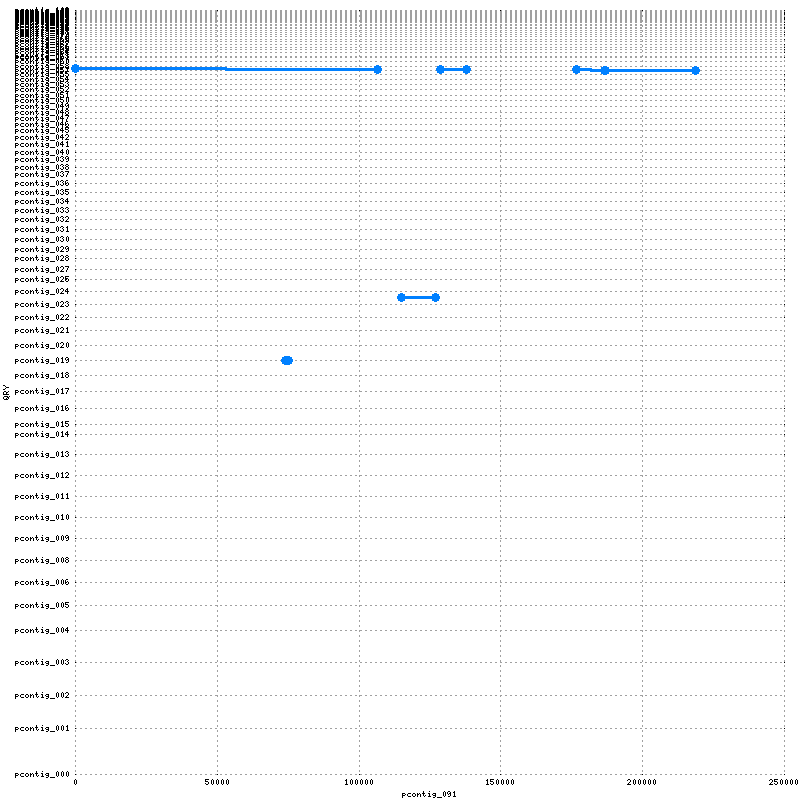

contig pcontig_092 of DK0911p with 199070 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_092.png!

##########



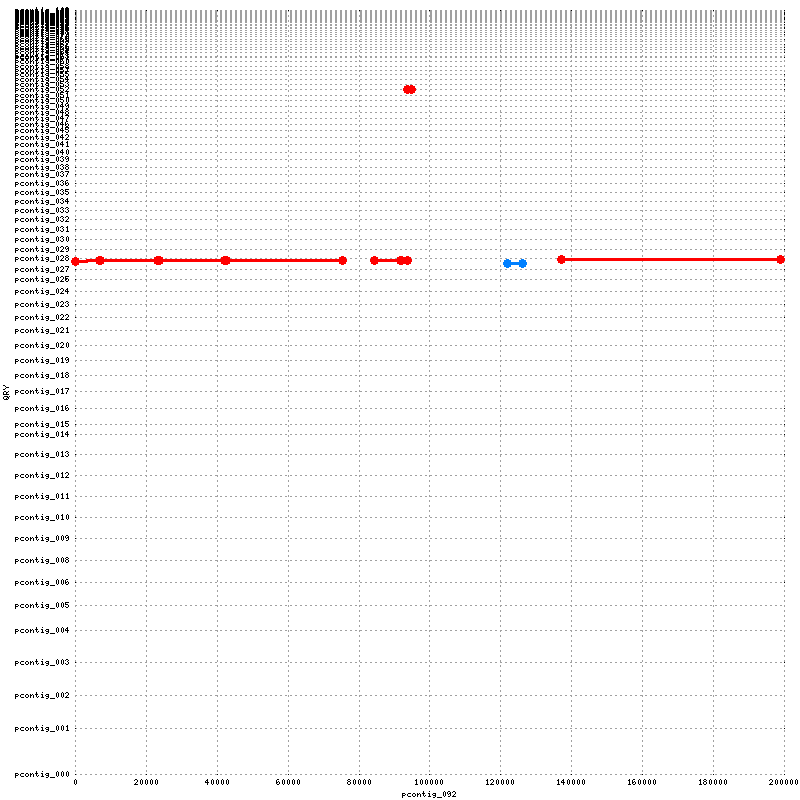

contig pcontig_095 of DK0911p with 195314 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_095.png!

##########



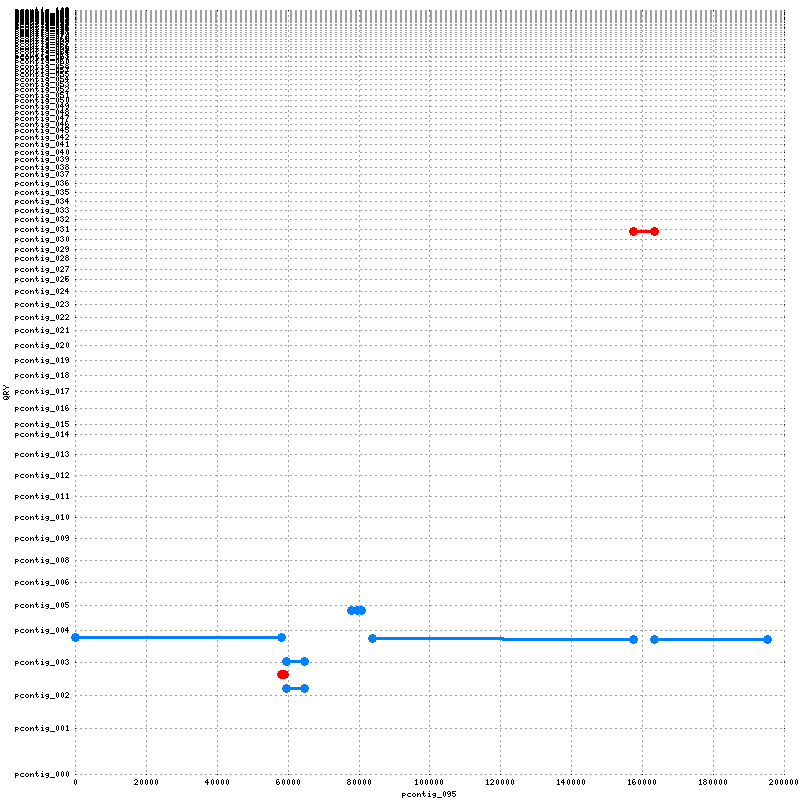

contig pcontig_096 of DK0911p with 66278 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_096.png!

##########



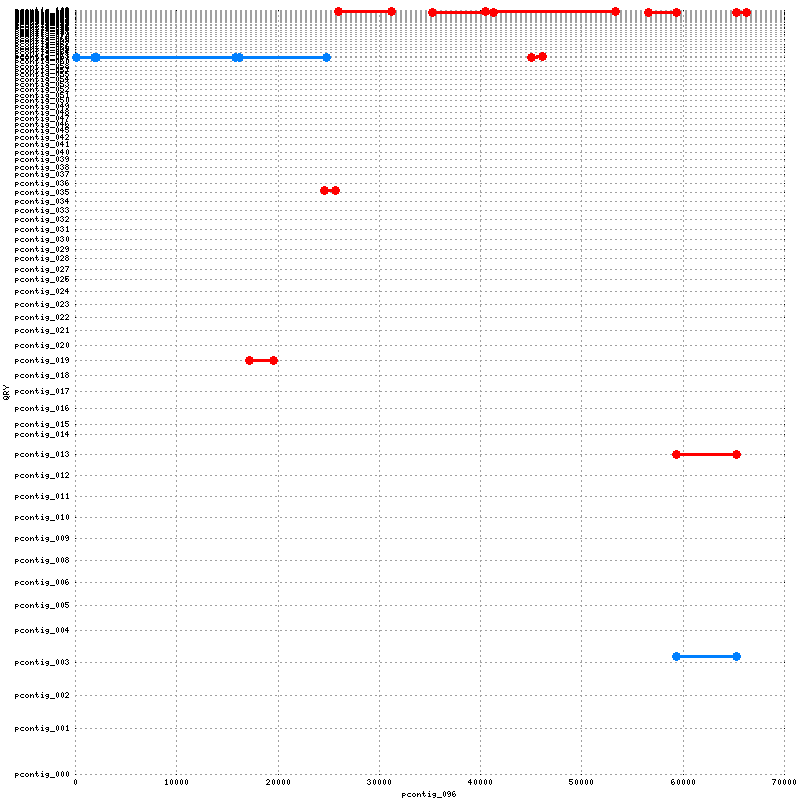

contig pcontig_097 of DK0911p with 190410 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_097.png!

##########



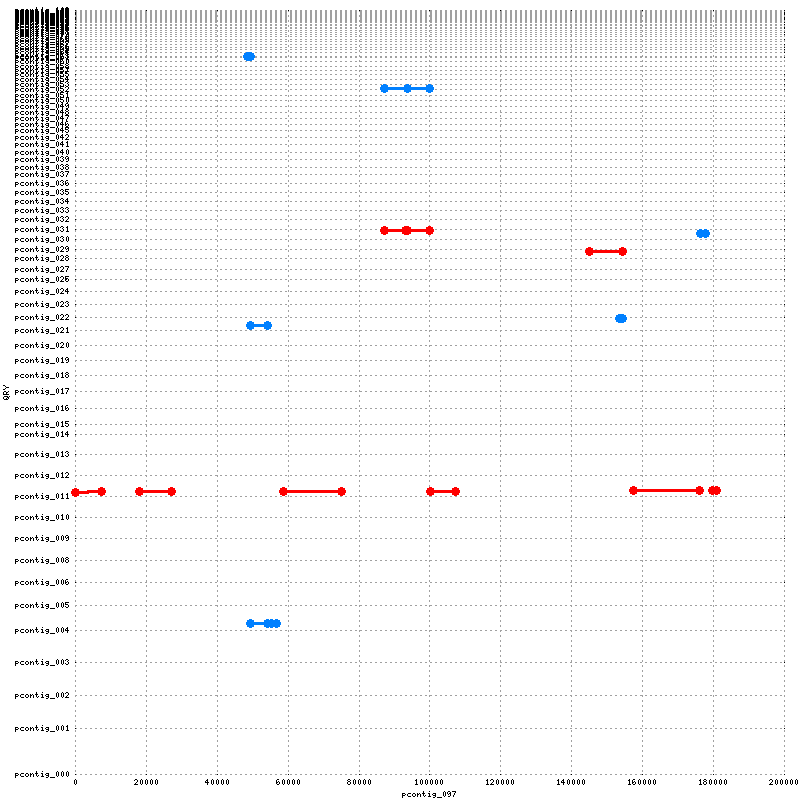

contig pcontig_100 of DK0911p with 172017 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_100.png!

##########



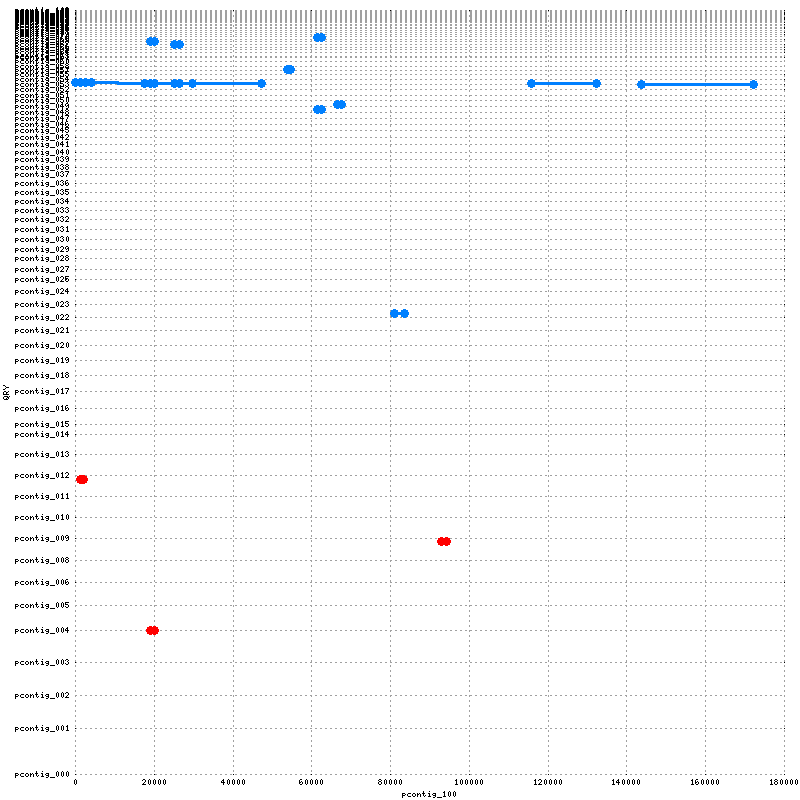

contig pcontig_103 of DK0911p with 158164 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_103.png!

##########



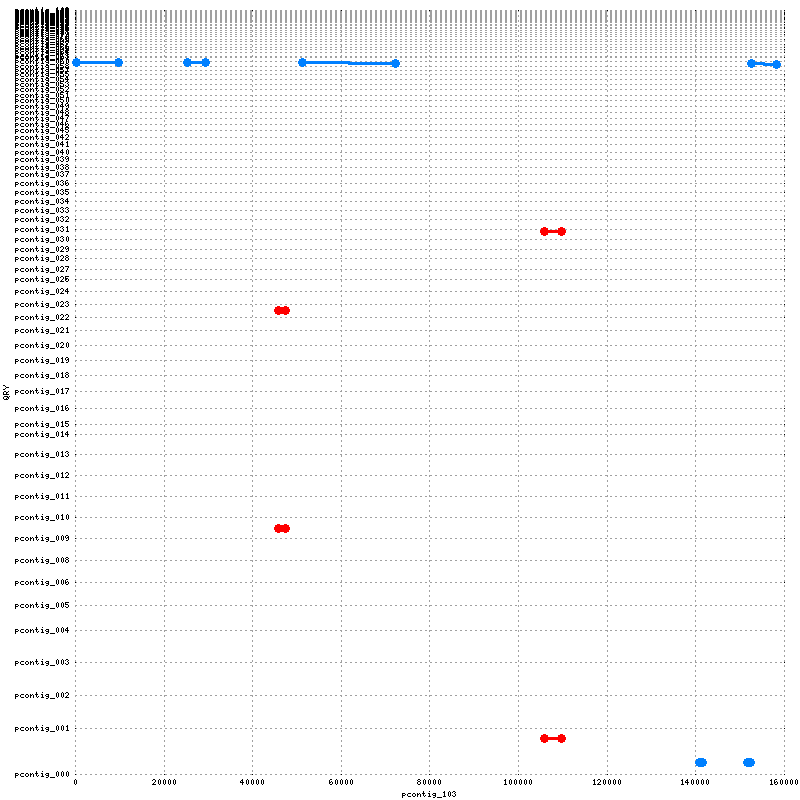

contig pcontig_104 of DK0911p with 155501 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_104.png!

##########



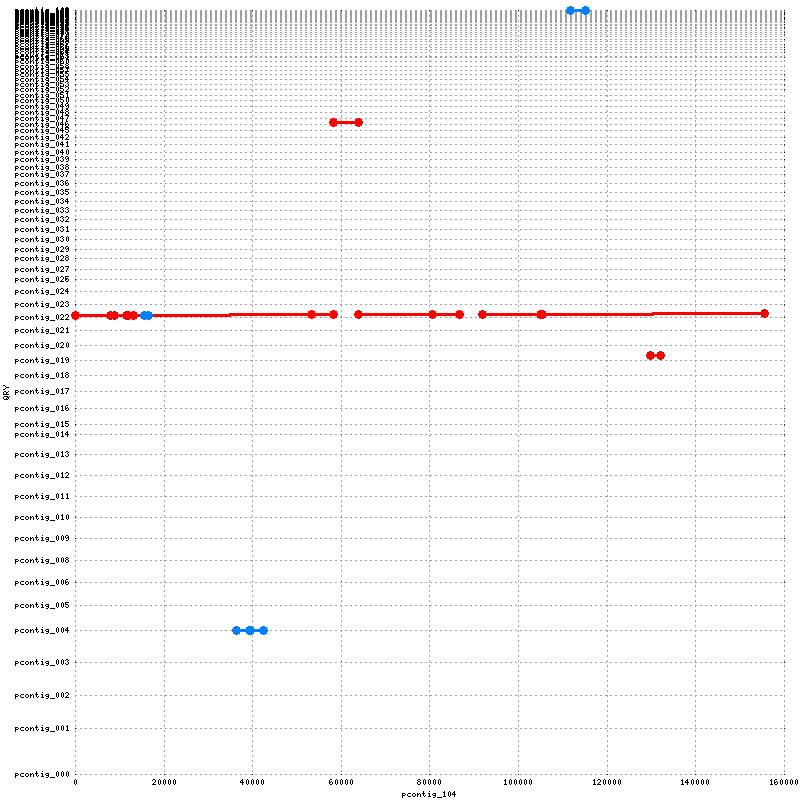

contig pcontig_106 of DK0911p with 144779 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_106.png!

##########



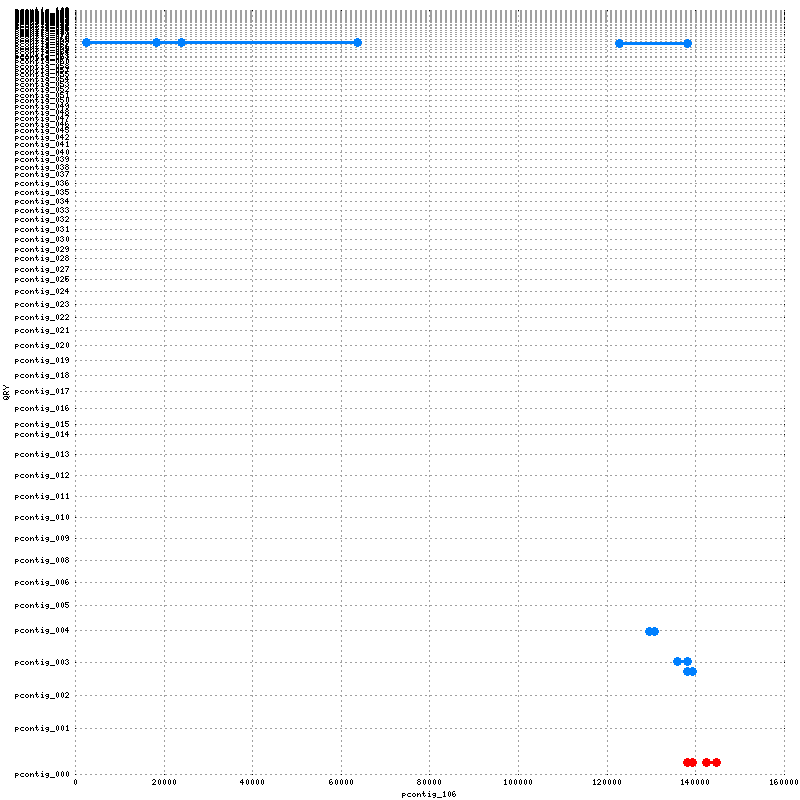

contig pcontig_110 of DK0911p with 126689 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_110.png!

##########



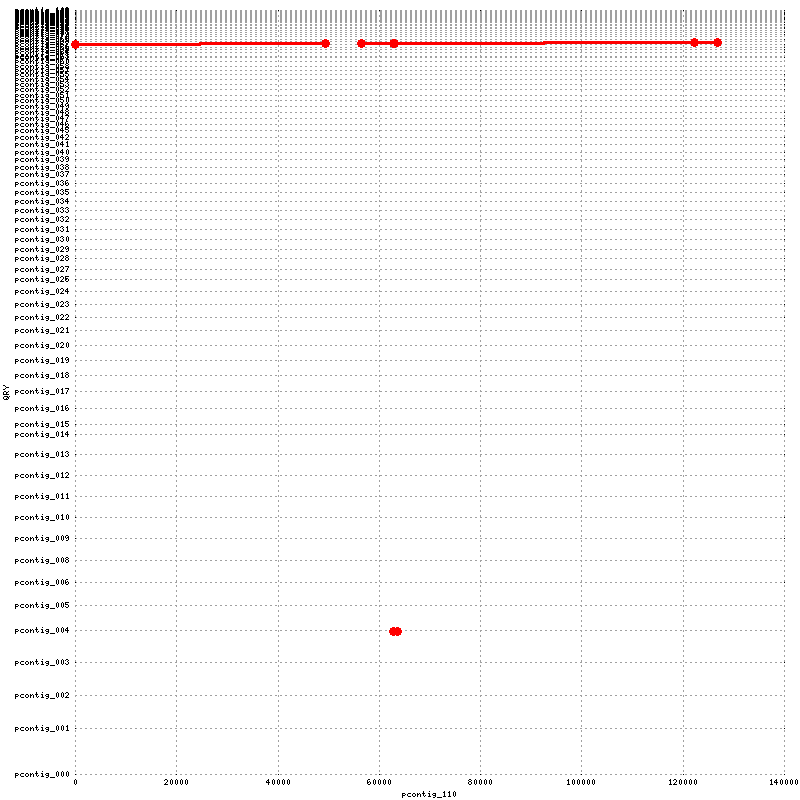

contig pcontig_112 of DK0911p with 128103 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_112.png!

##########



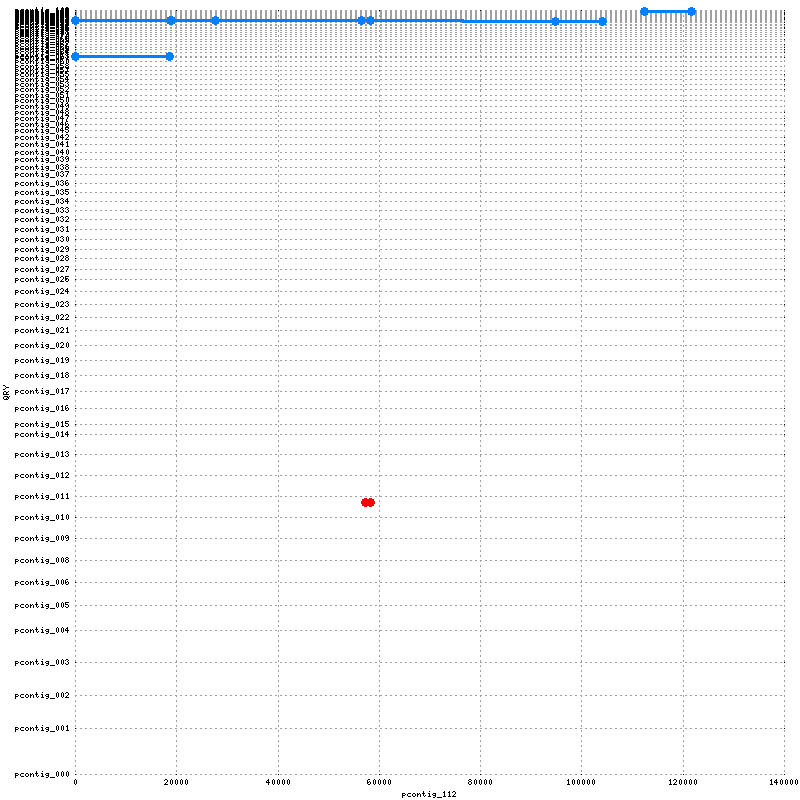

contig pcontig_115 of DK0911p with 119262 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_115.png!

##########



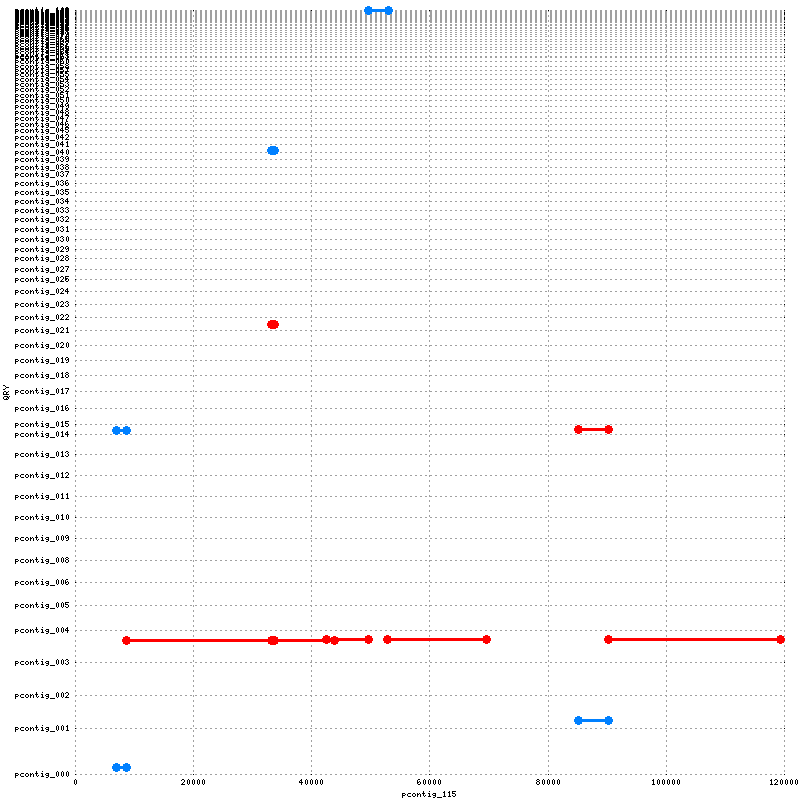

contig pcontig_118 of DK0911p with 112693 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_118.png!

##########



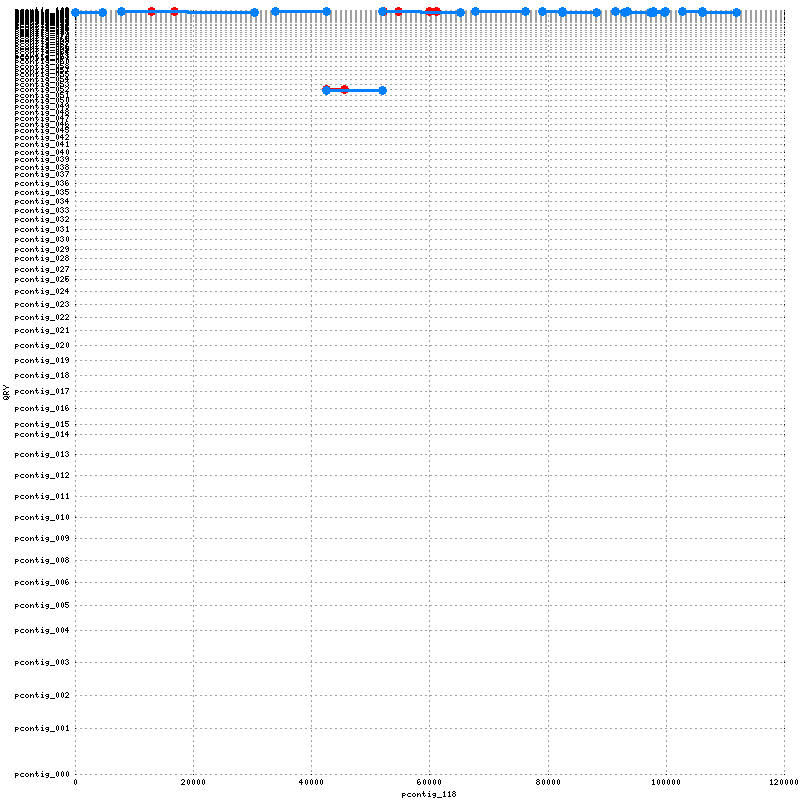

contig pcontig_120 of DK0911p with 103122 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_120.png!

##########



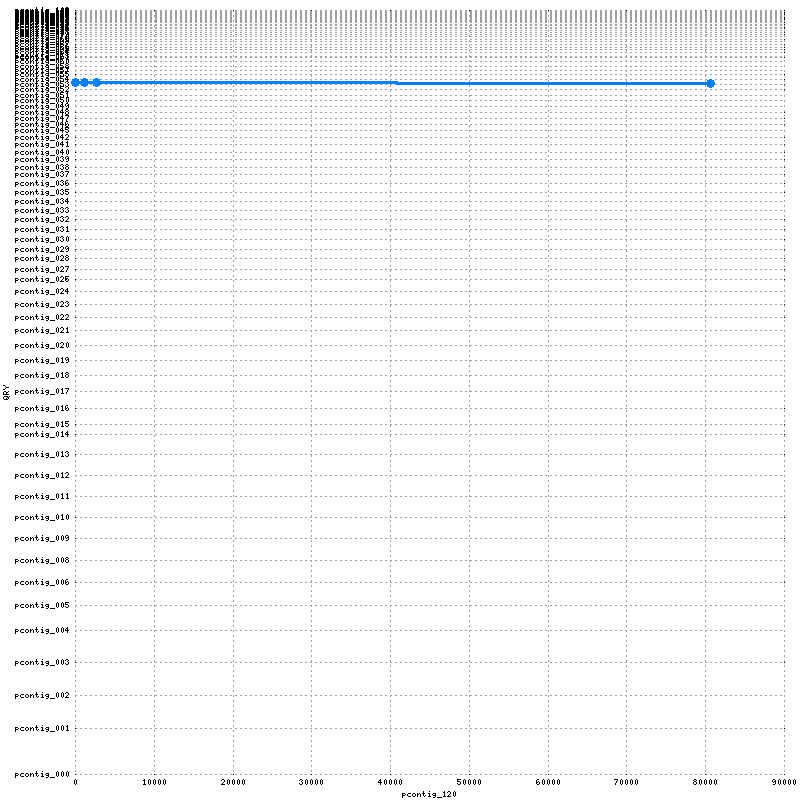

contig pcontig_128 of DK0911p with 93678 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_128.png!

##########



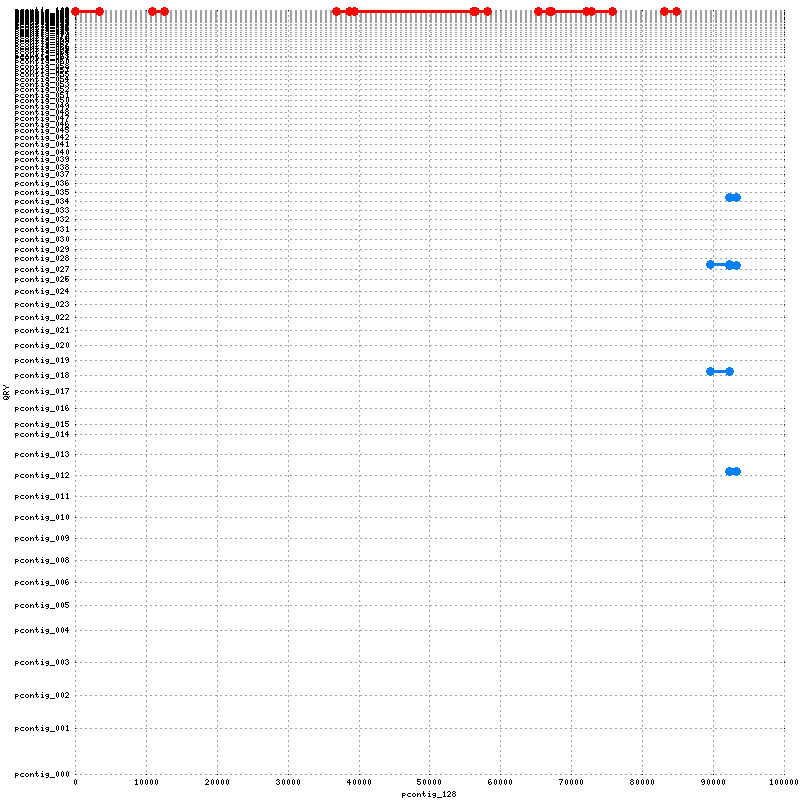

contig pcontig_129 of DK0911p with 88466 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_129.png!

##########



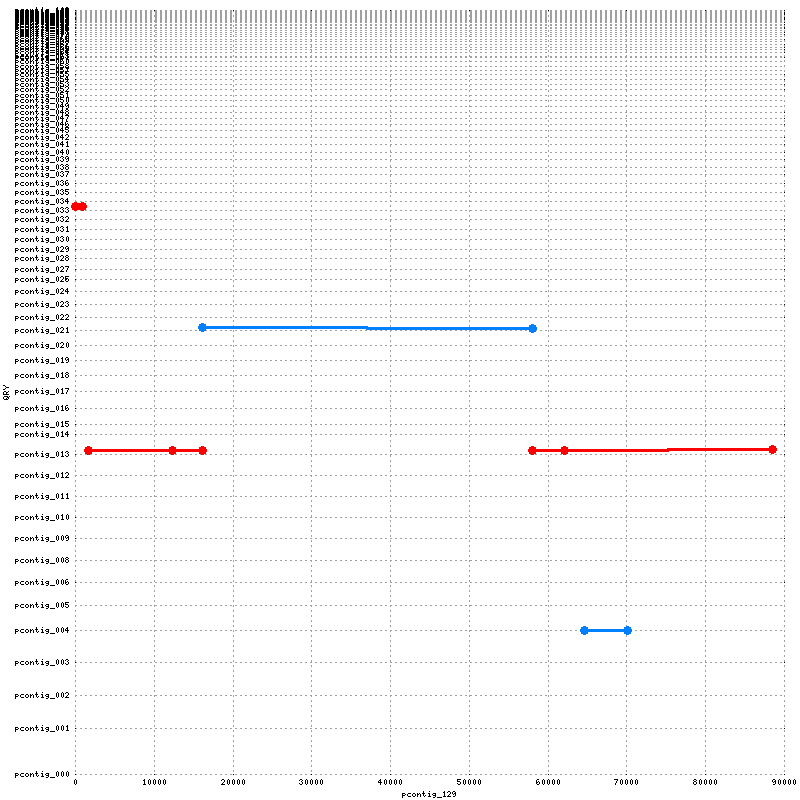

contig pcontig_130 of DK0911p with 91650 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_130.png!

##########



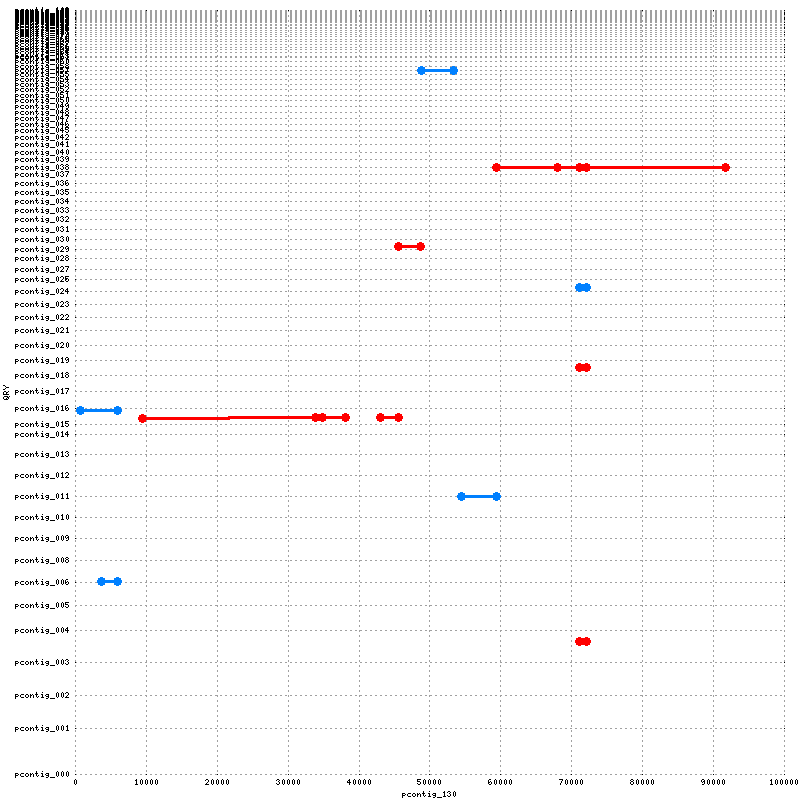

contig pcontig_134 of DK0911p with 88575 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_134.png!

##########



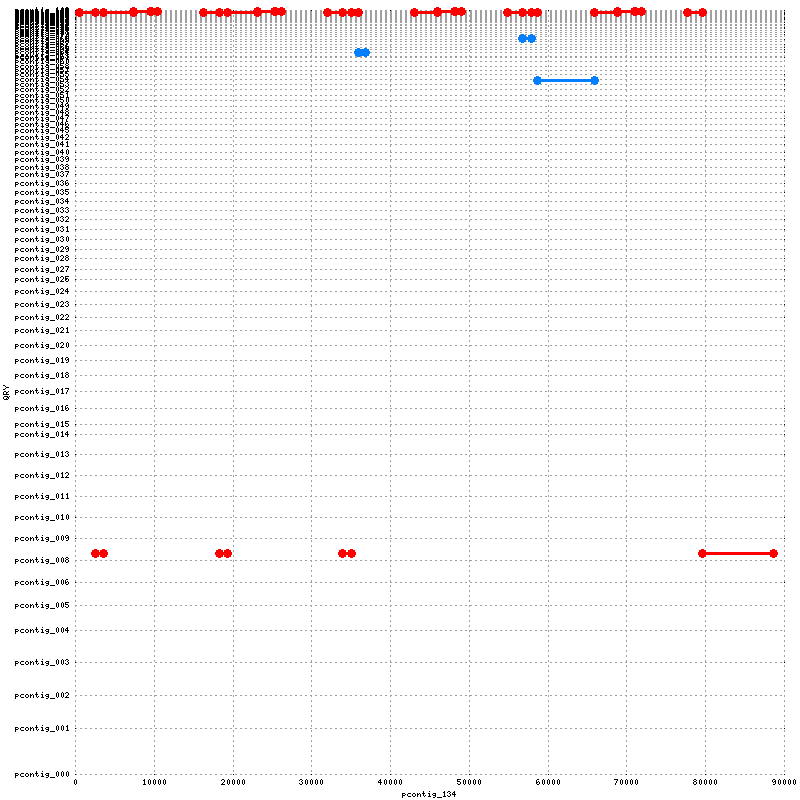

contig pcontig_138 of DK0911p with 81827 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_138.png!

##########



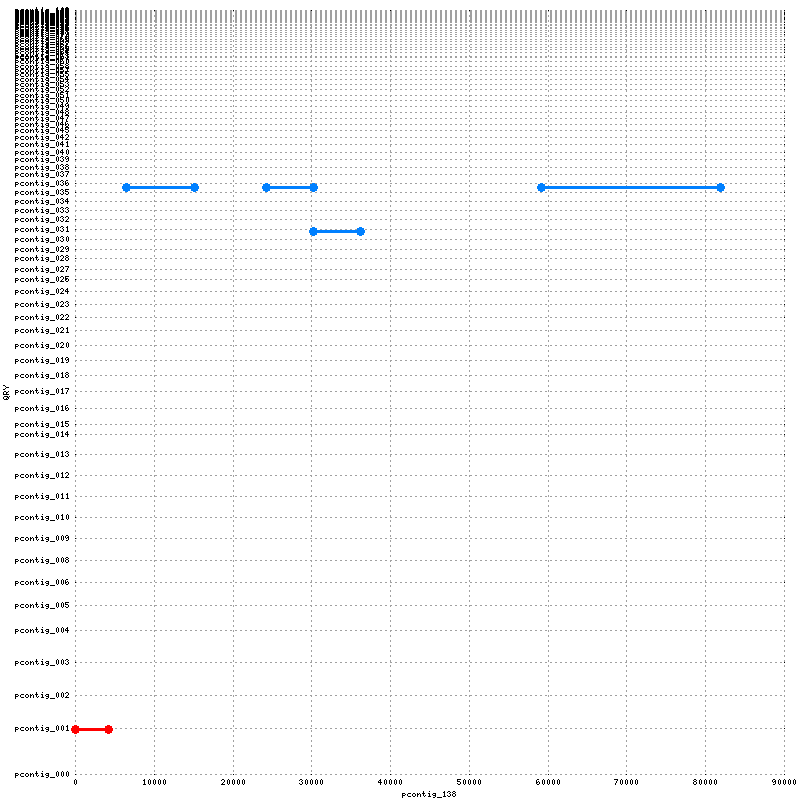

contig pcontig_139 of DK0911p with 80660 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_139.png!

##########



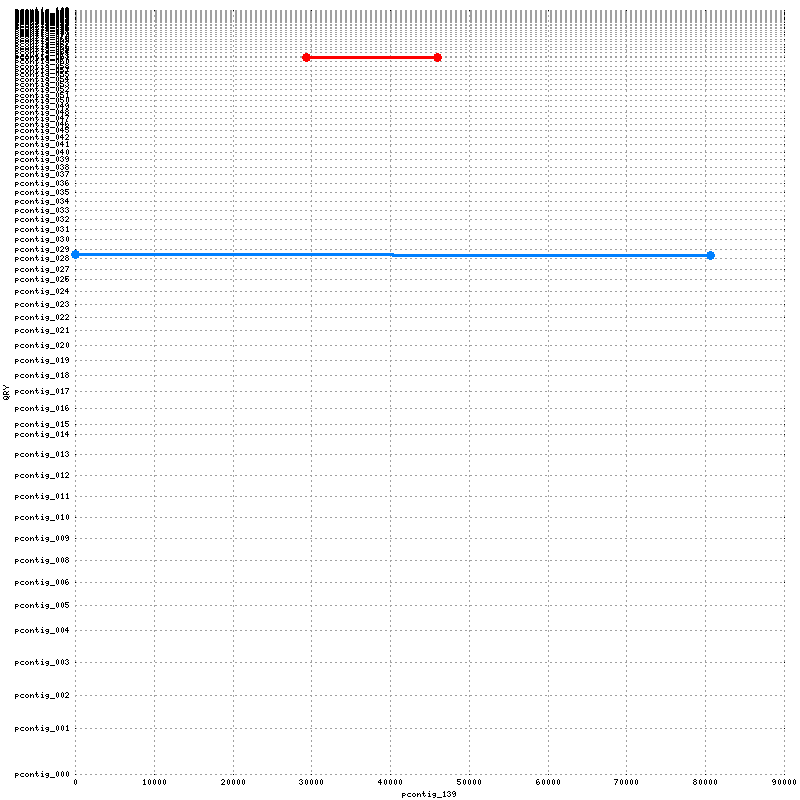

contig pcontig_140 of DK0911p with 78701 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_140.png!

##########



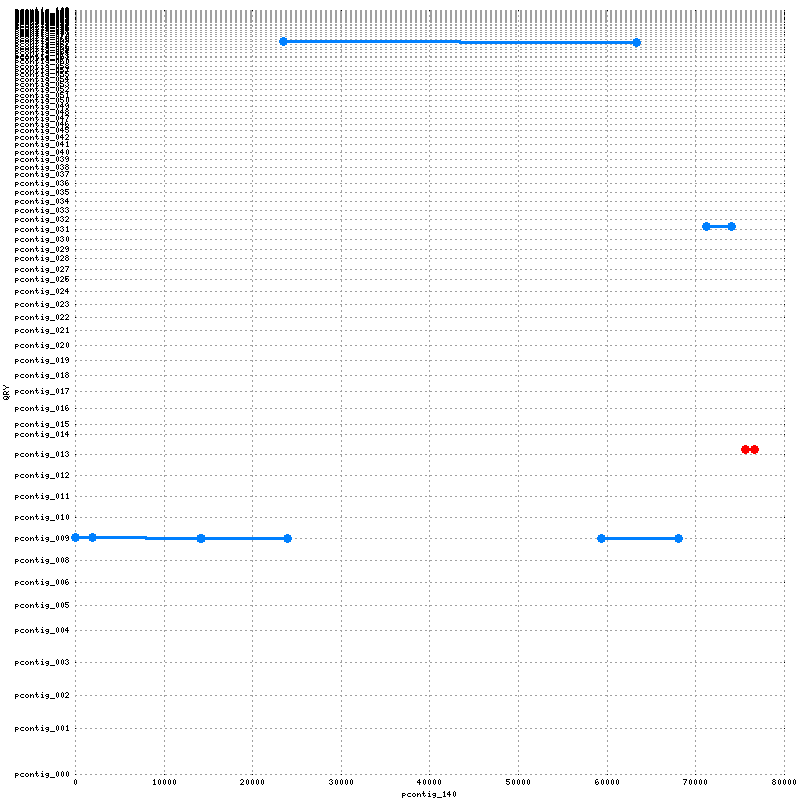

contig pcontig_146 of DK0911p with 72539 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_146.png!

##########



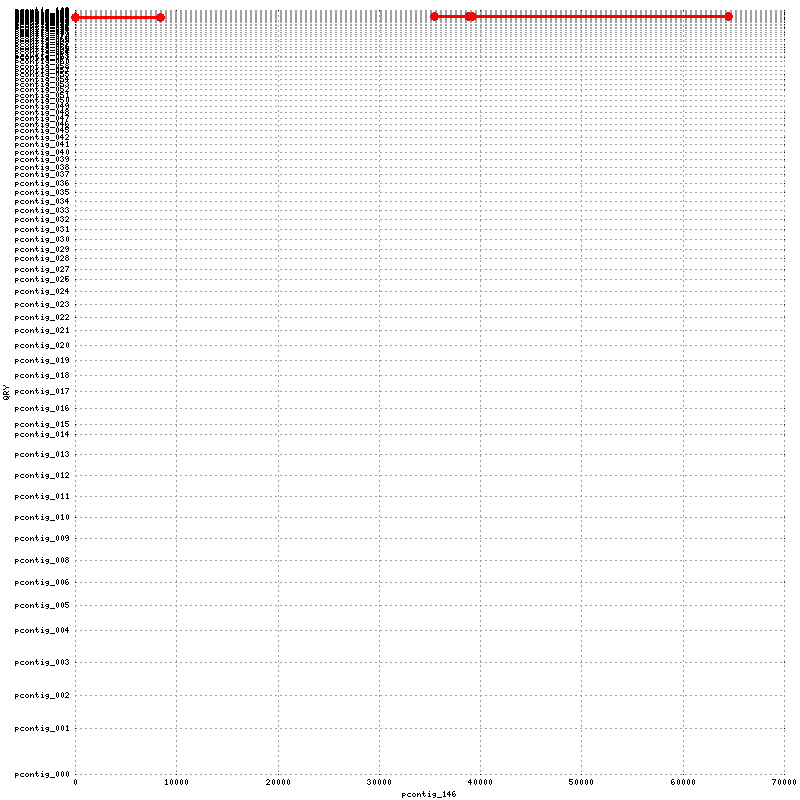

contig pcontig_147 of DK0911p with 71497 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_147.png!

##########



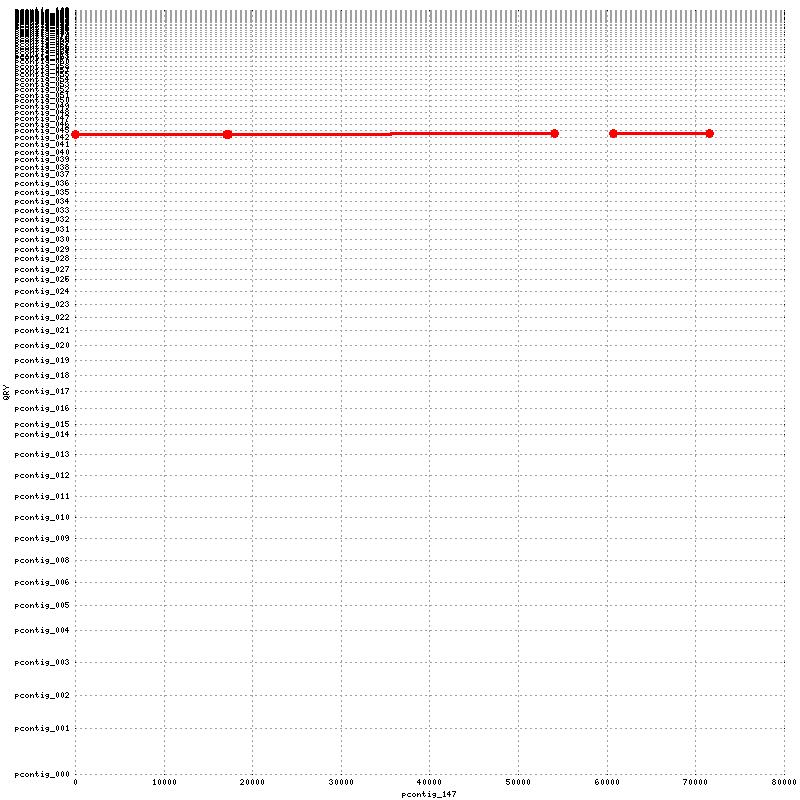

contig pcontig_148 of DK0911p with 71429 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_148.png!

##########



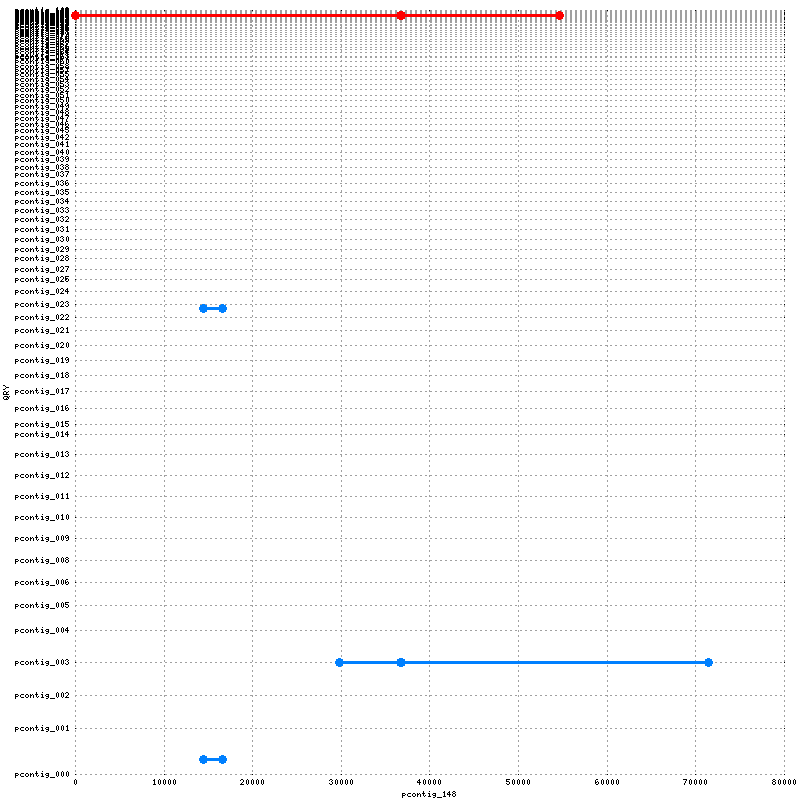

contig pcontig_149 of DK0911p with 69876 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_149.png!

##########



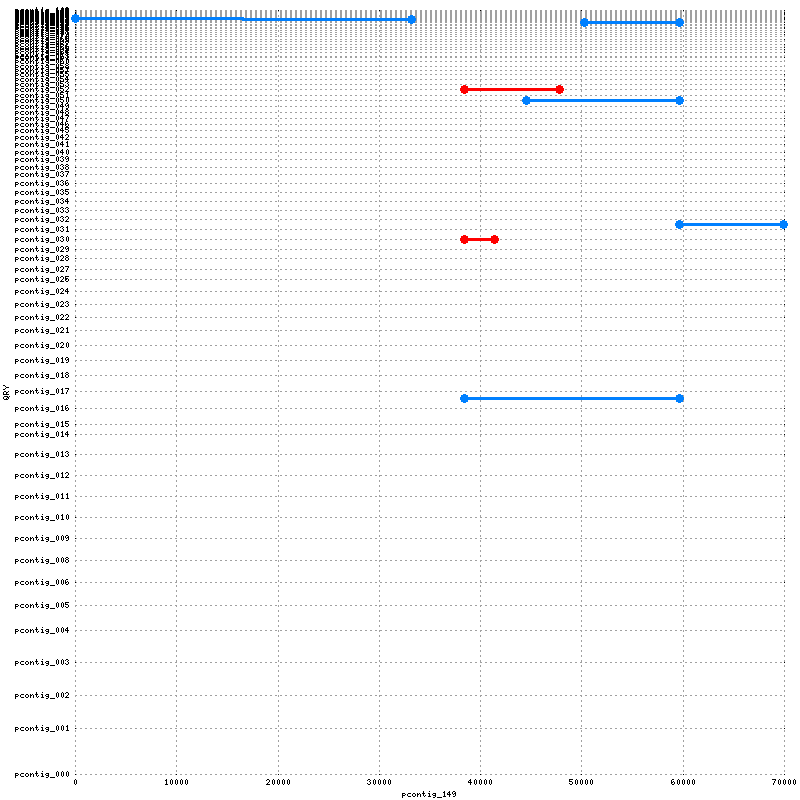

contig pcontig_150 of DK0911p with 68905 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_150.png!

##########



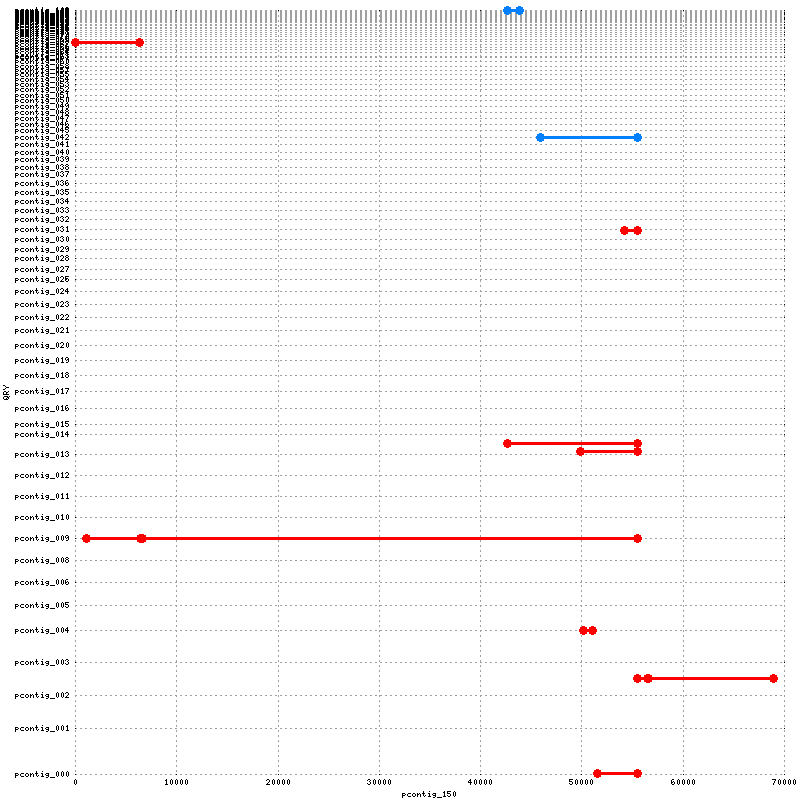

contig pcontig_152 of DK0911p with 66715 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_152.png!

##########



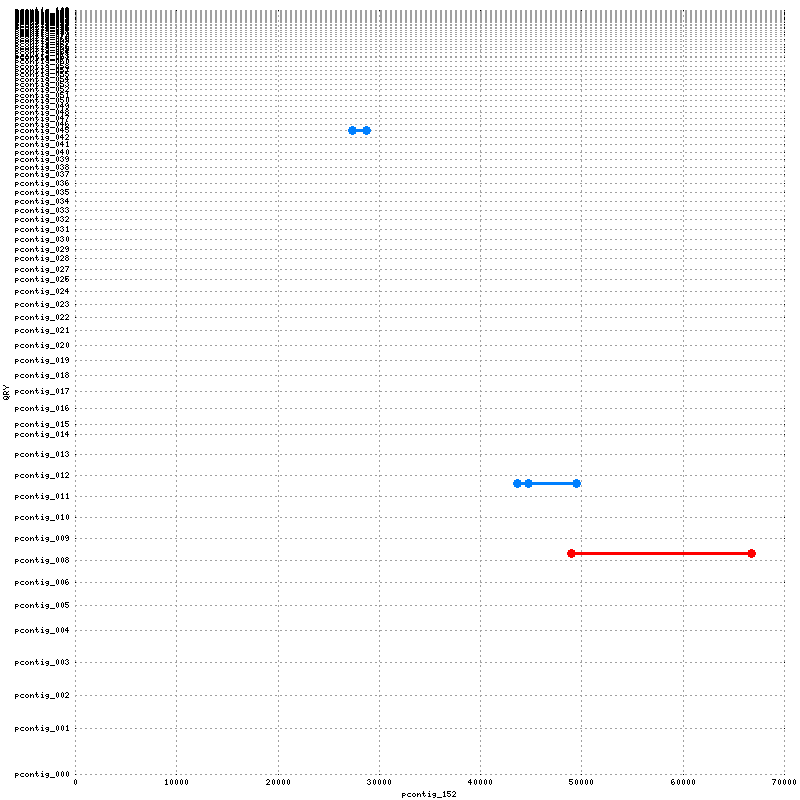

contig pcontig_153 of DK0911p with 66638 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_153.png!

##########



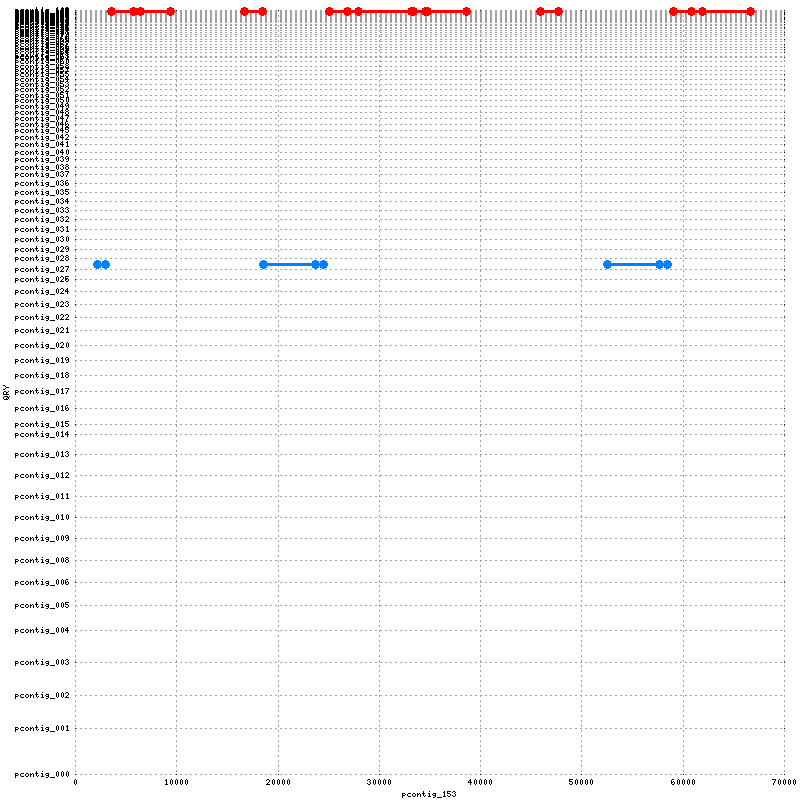

contig pcontig_154 of DK0911p with 44564 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_154.png!

##########



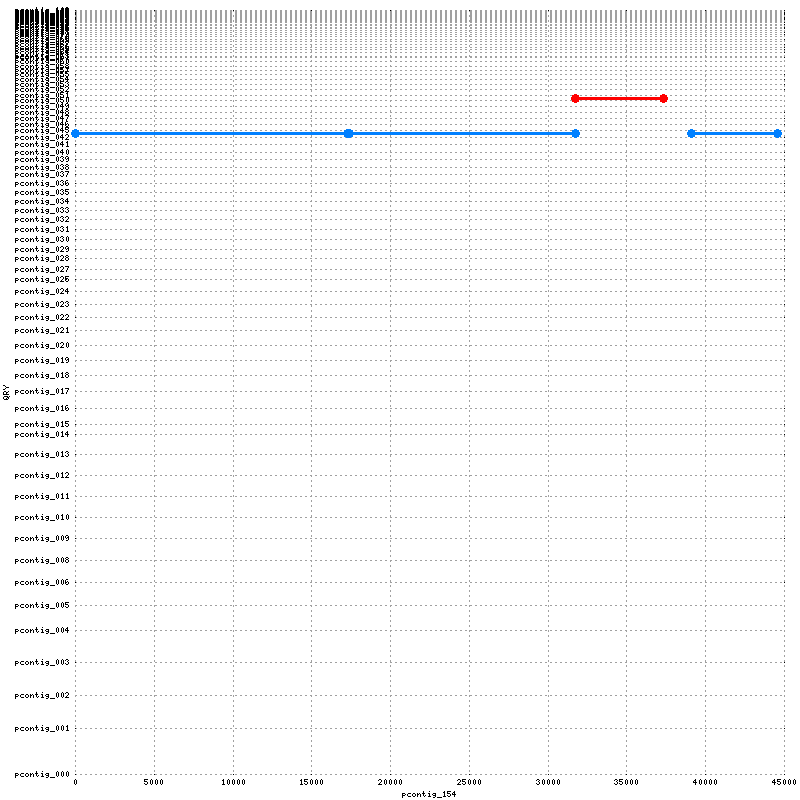

contig pcontig_157 of DK0911p with 62650 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_157.png!

##########



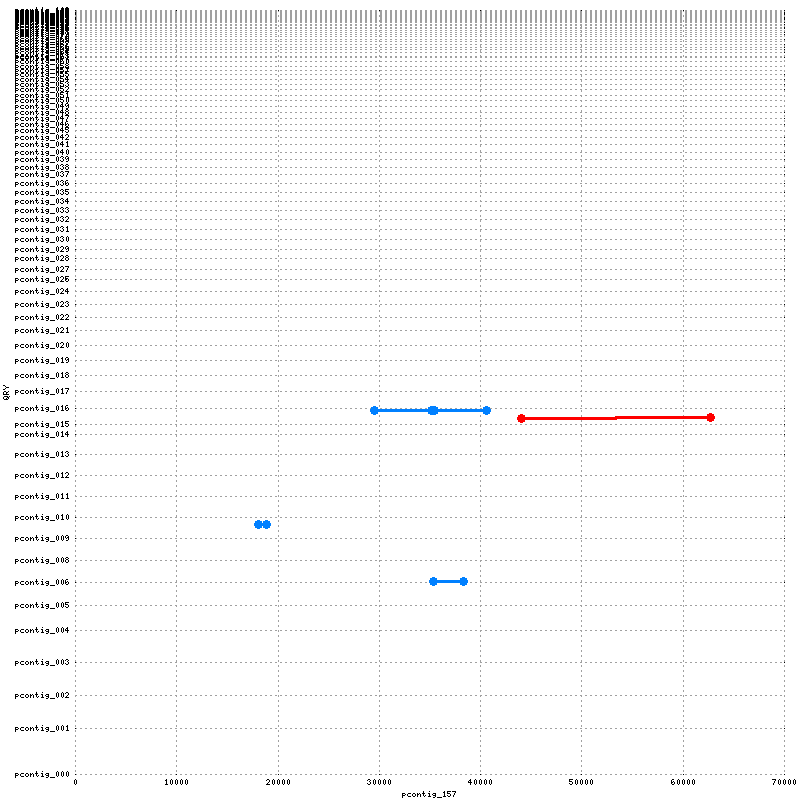

contig pcontig_163 of DK0911p with 54930 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_163.png!

##########



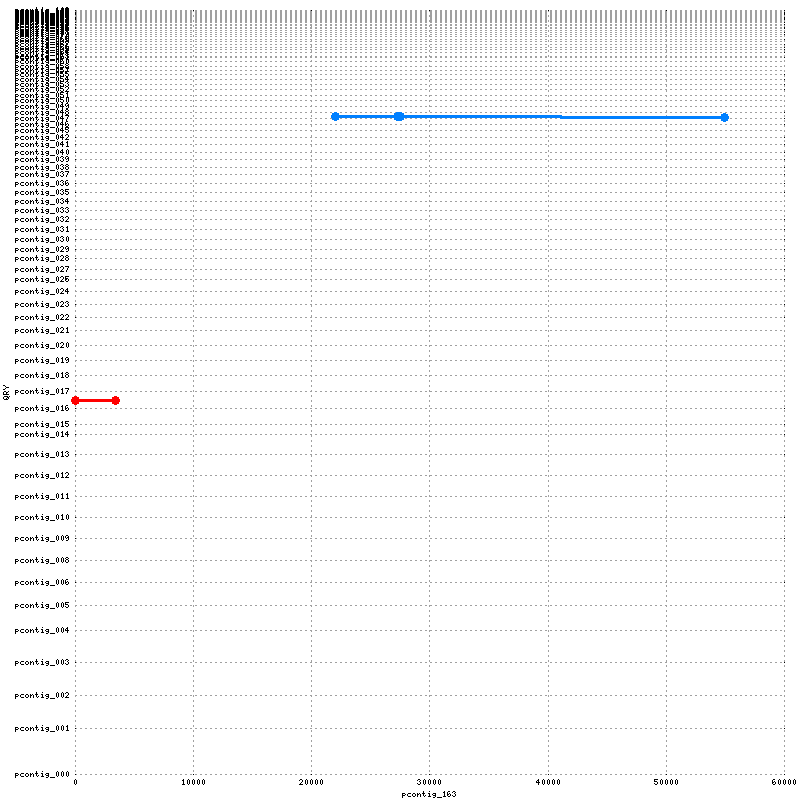

contig pcontig_164 of DK0911p with 54539 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_164.png!

##########



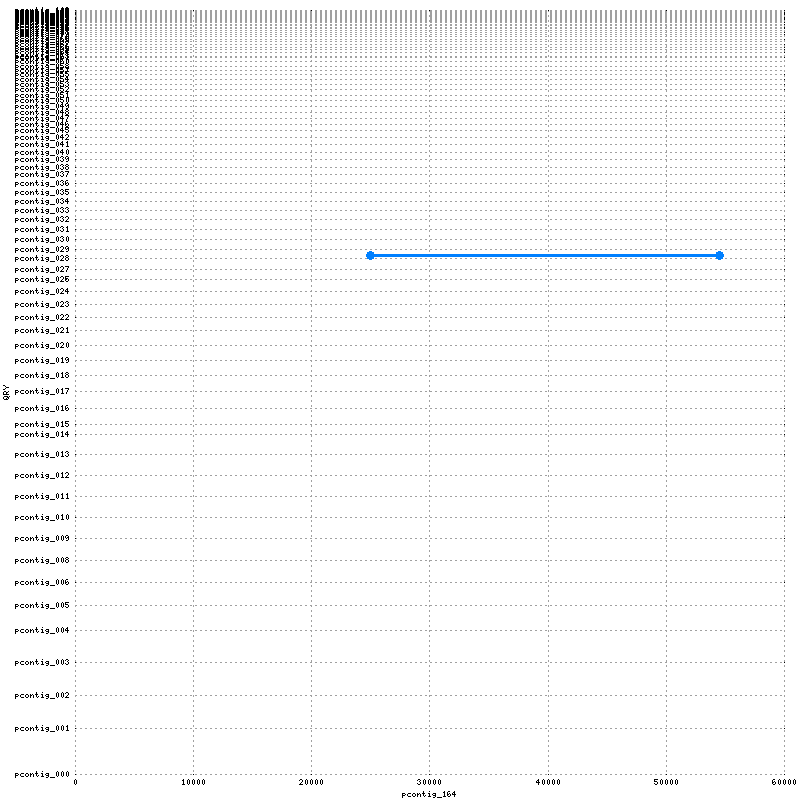

contig pcontig_165 of DK0911p with 51467 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_165.png!

##########



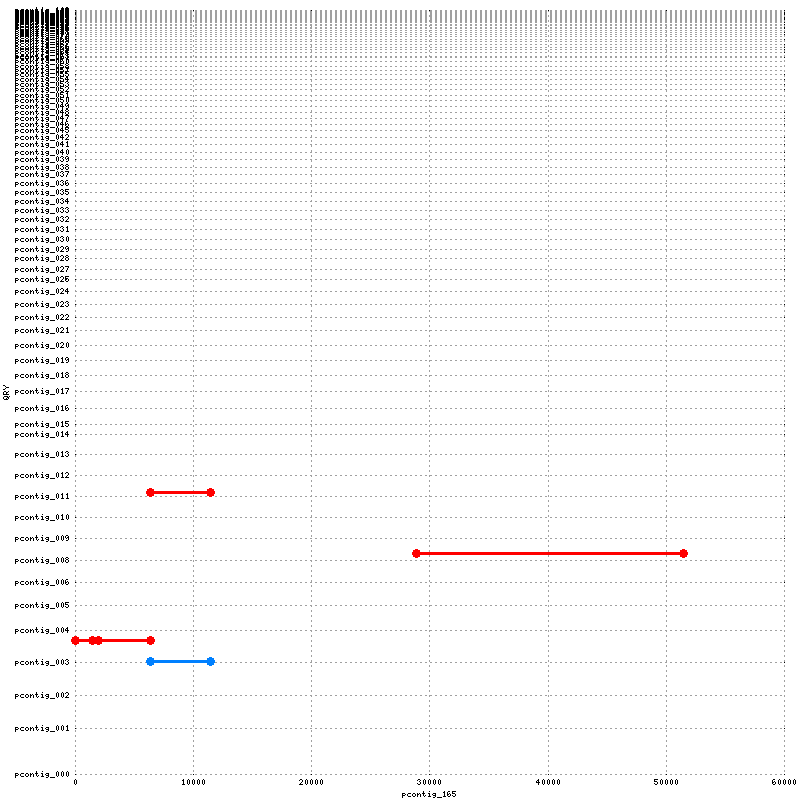

contig pcontig_166 of DK0911p with 53330 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_166.png!

##########



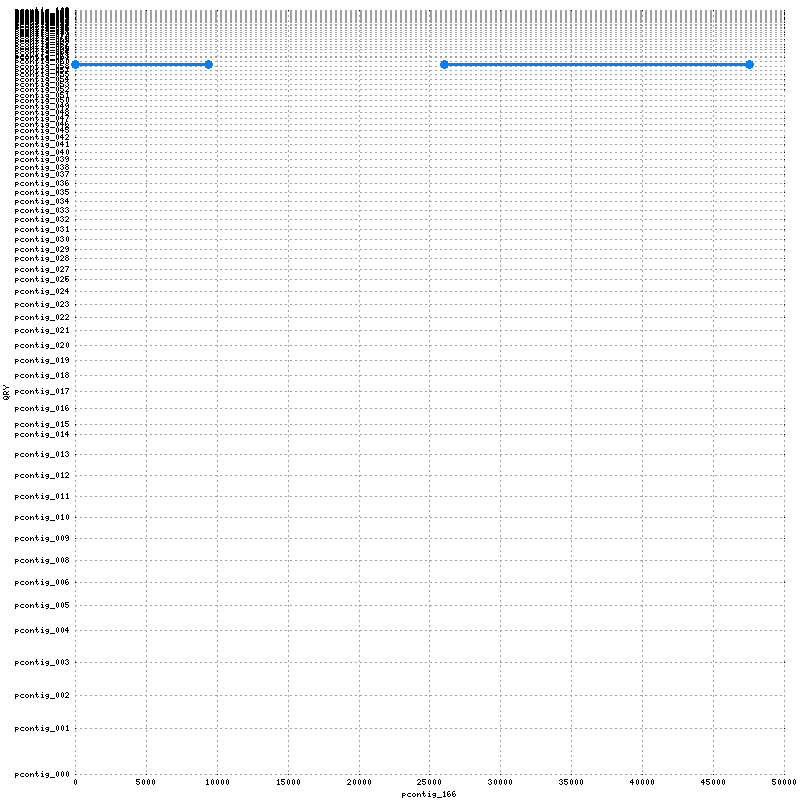

contig pcontig_170 of DK0911p with 52390 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_170.png!

##########



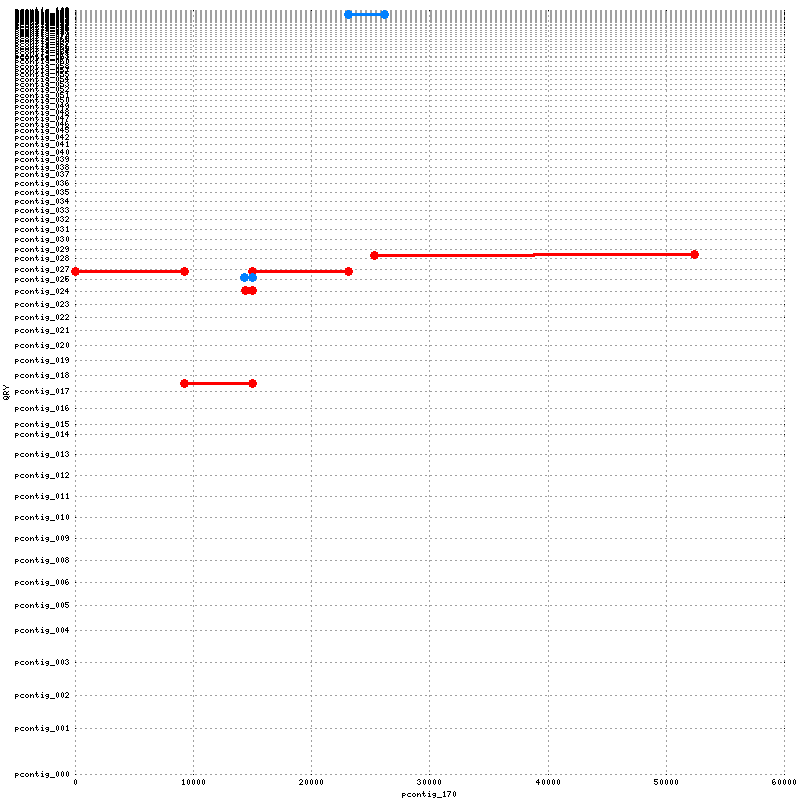

contig pcontig_171 of DK0911p with 31775 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_171.png!

##########



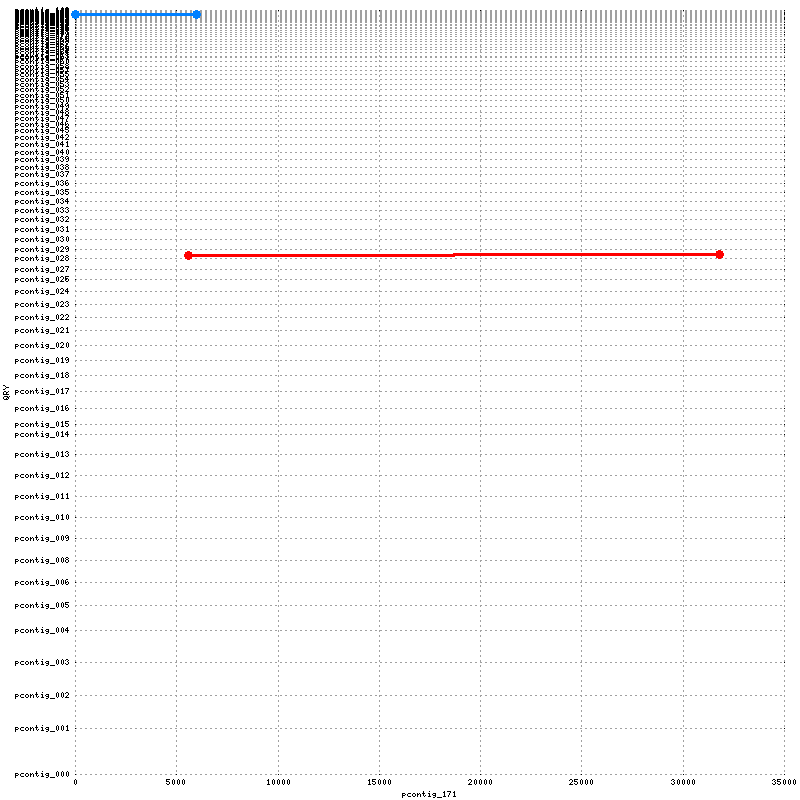

contig pcontig_172 of DK0911p with 51361 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_172.png!

##########



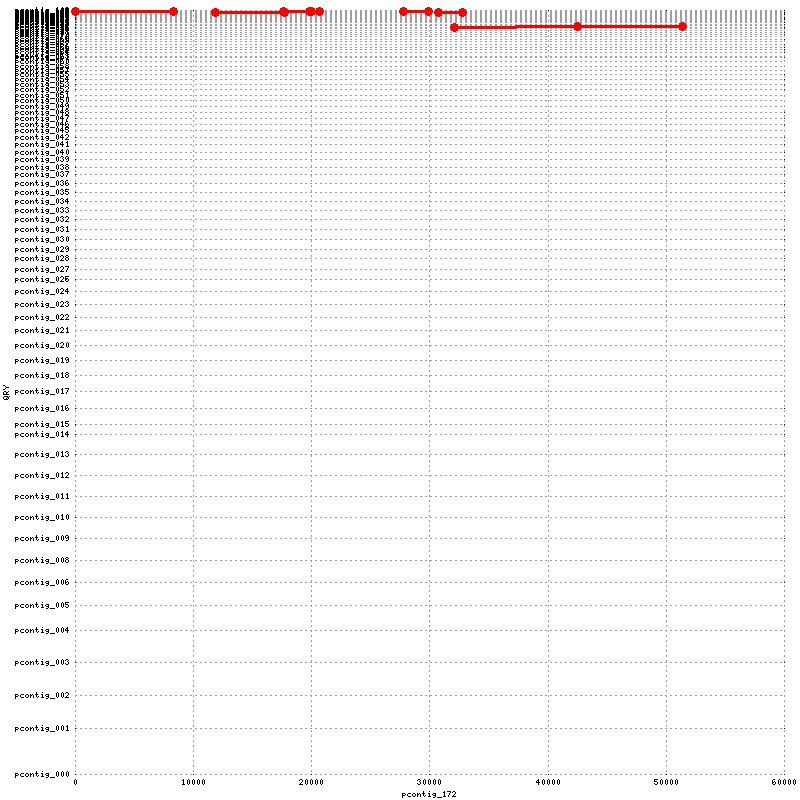

contig pcontig_173 of DK0911p with 51394 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_173.png!

##########



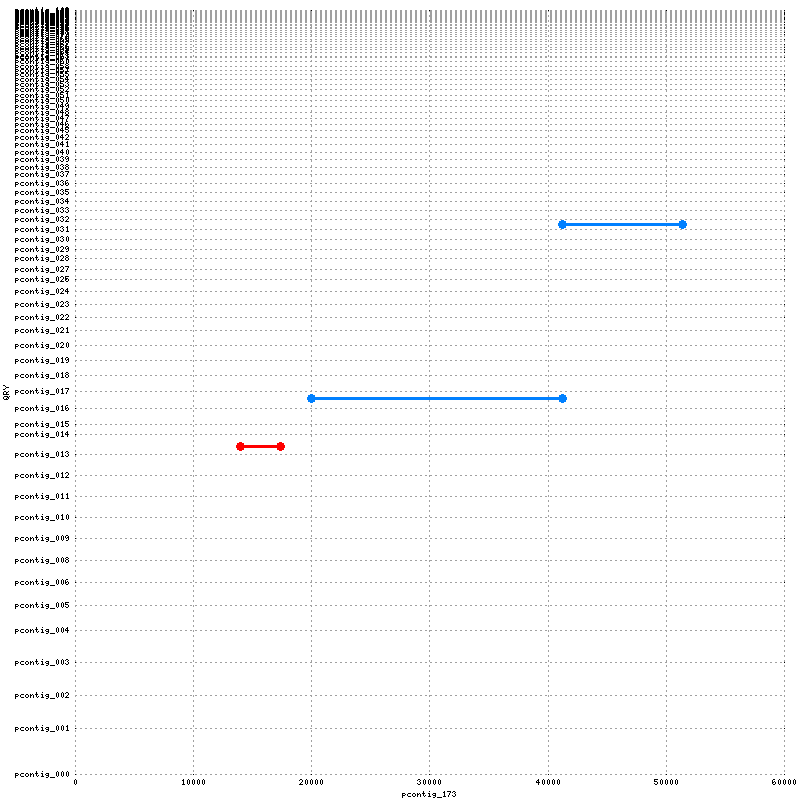

contig pcontig_174 of DK0911p with 51086 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_174.png!

##########



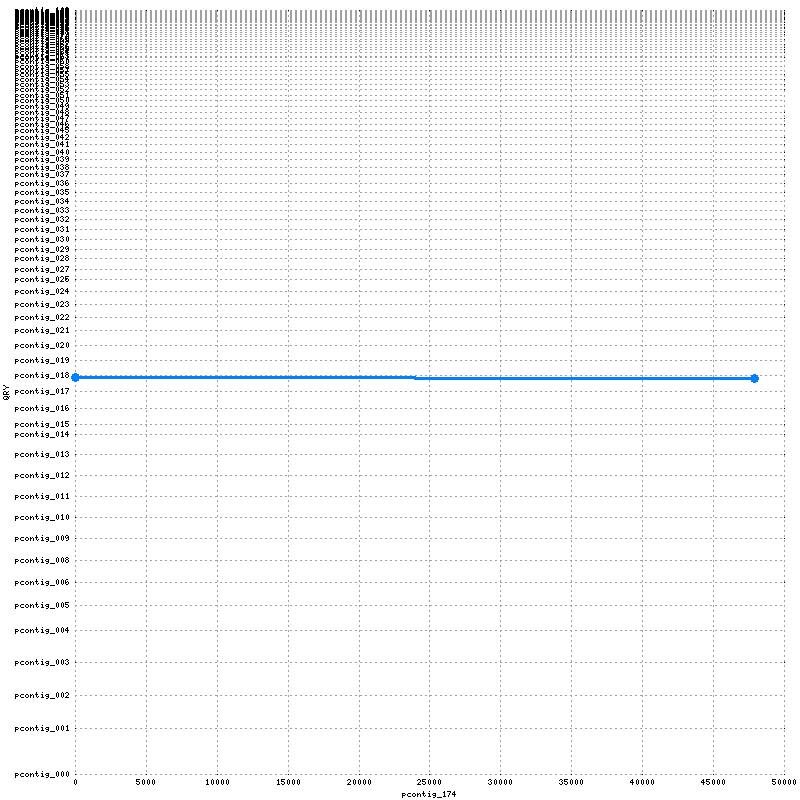

contig pcontig_176 of DK0911p with 50076 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_176.png!

##########



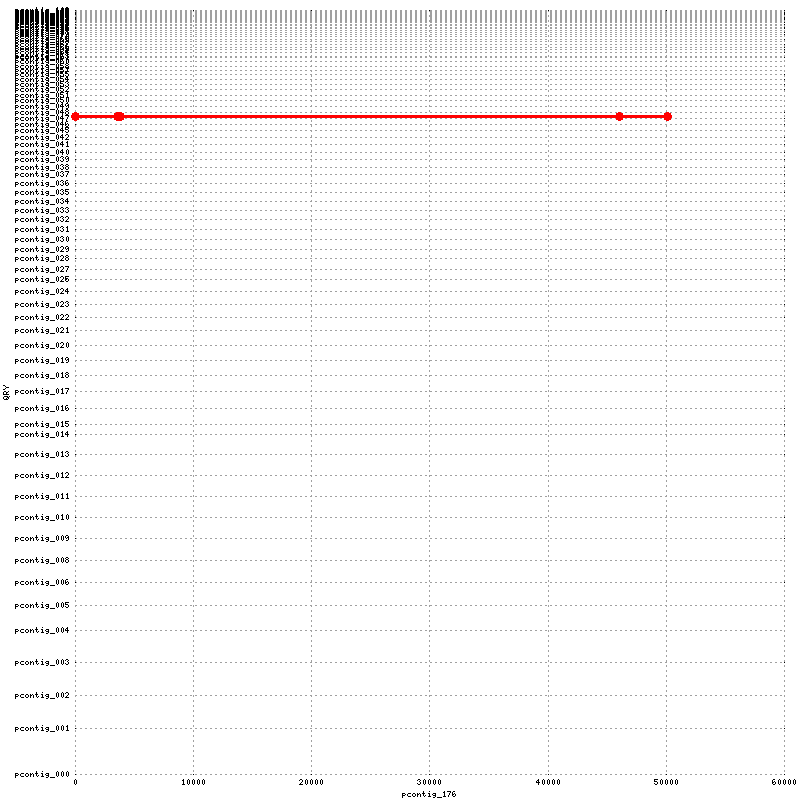

contig pcontig_177 of DK0911p with 48666 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_177.png!

##########



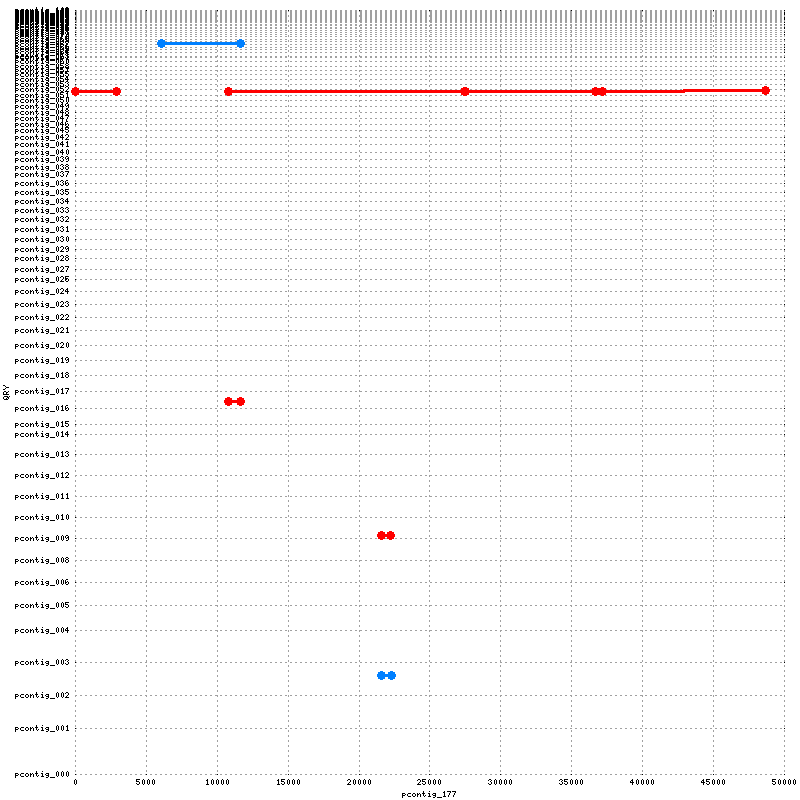

contig pcontig_179 of DK0911p with 47175 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_179.png!

##########



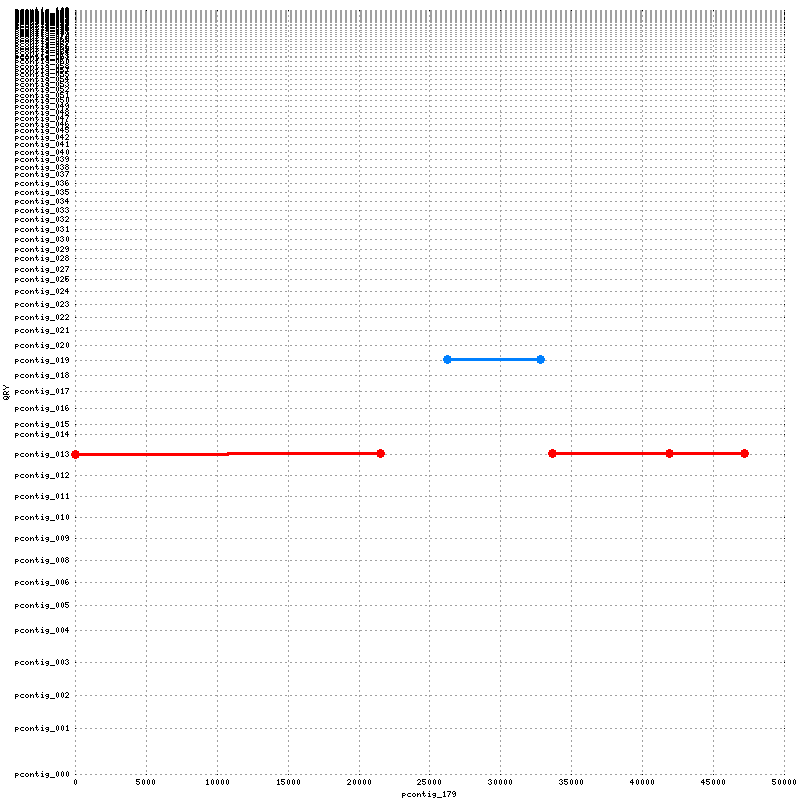

contig pcontig_181 of DK0911p with 46783 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_181.png!

##########



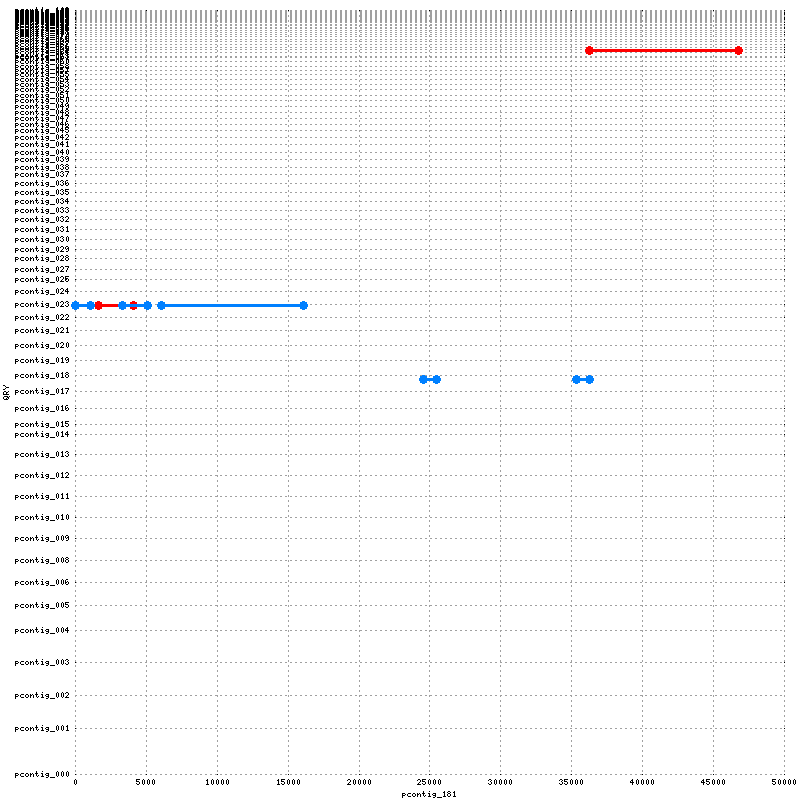

contig pcontig_182 of DK0911p with 45869 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_182.png!

##########



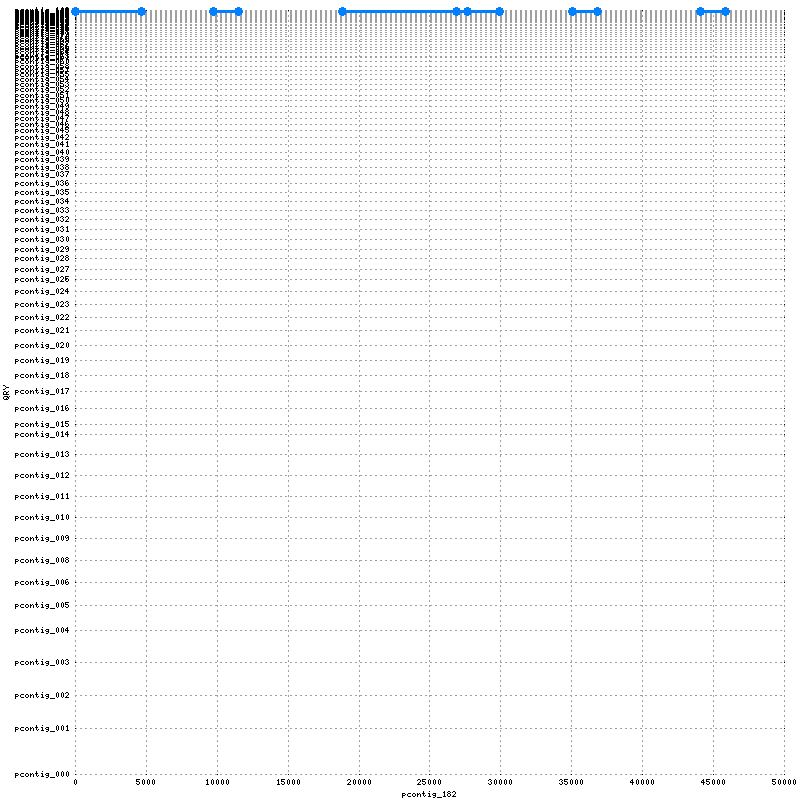

contig pcontig_184 of DK0911p with 44246 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_184.png!

##########



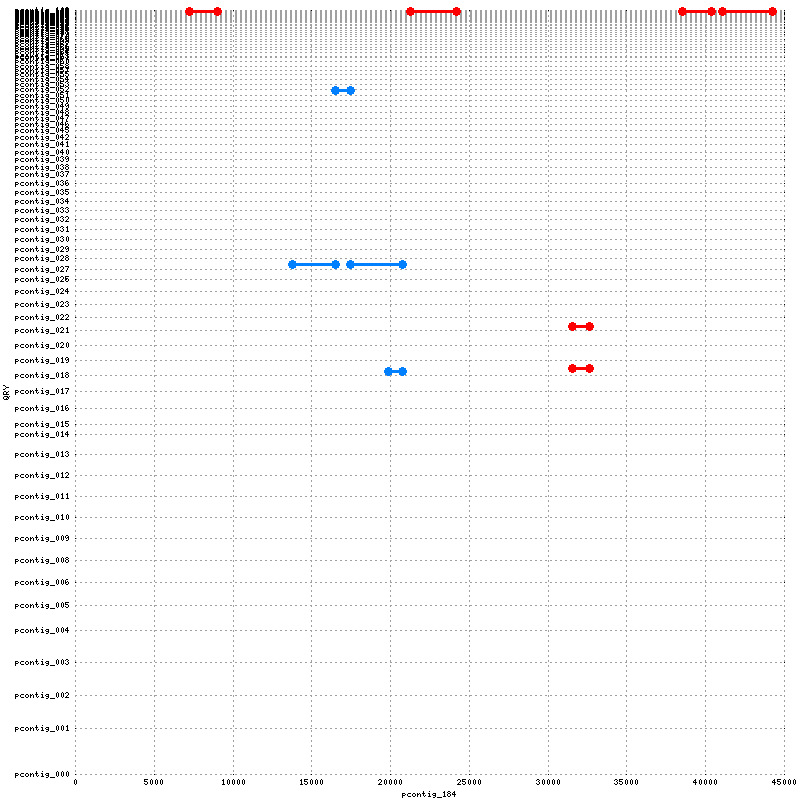

contig pcontig_185 of DK0911p with 25036 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_185.png!

##########



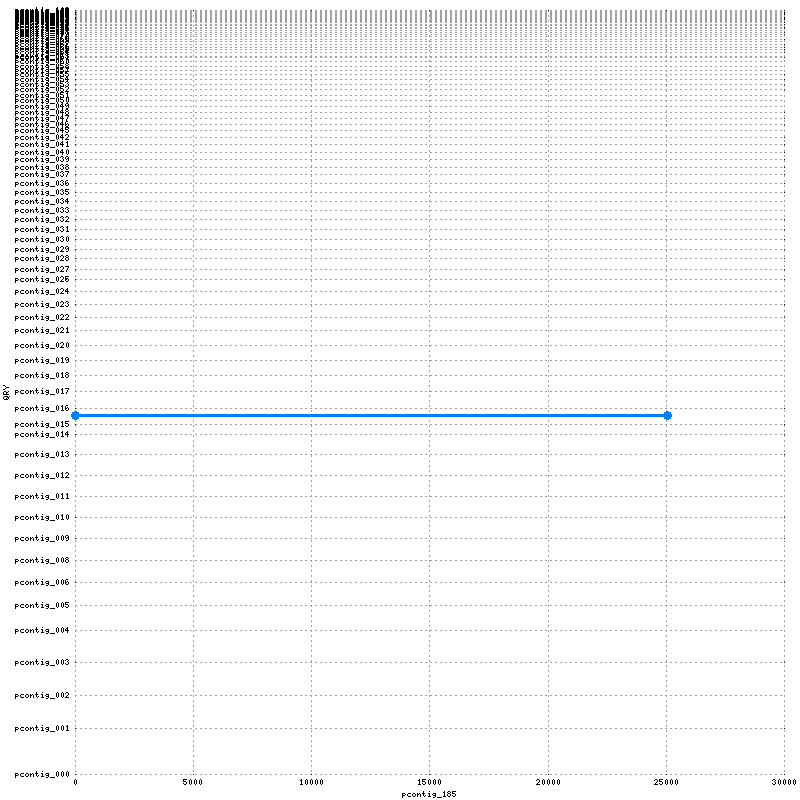

contig pcontig_186 of DK0911p with 41595 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_186.png!

##########



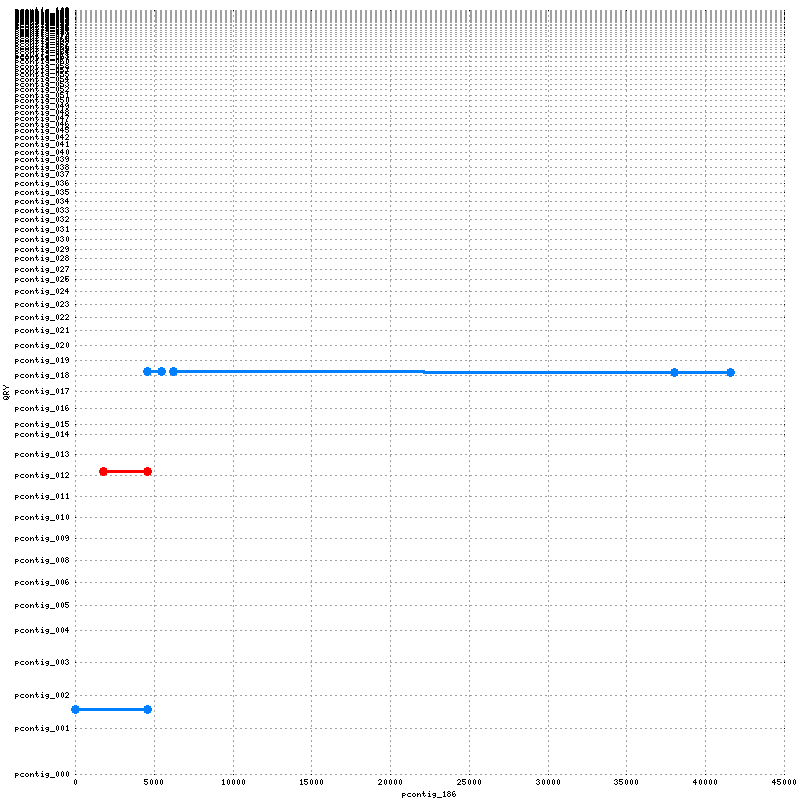

contig pcontig_187 of DK0911p with 41213 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_187.png!

##########



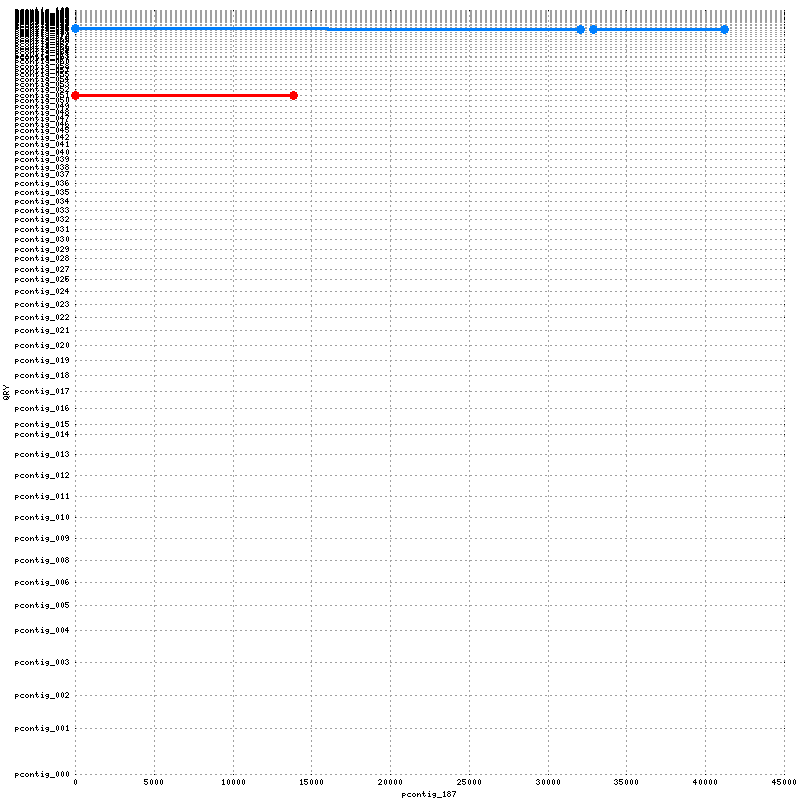

contig pcontig_188 of DK0911p with 41113 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_188.png!

##########



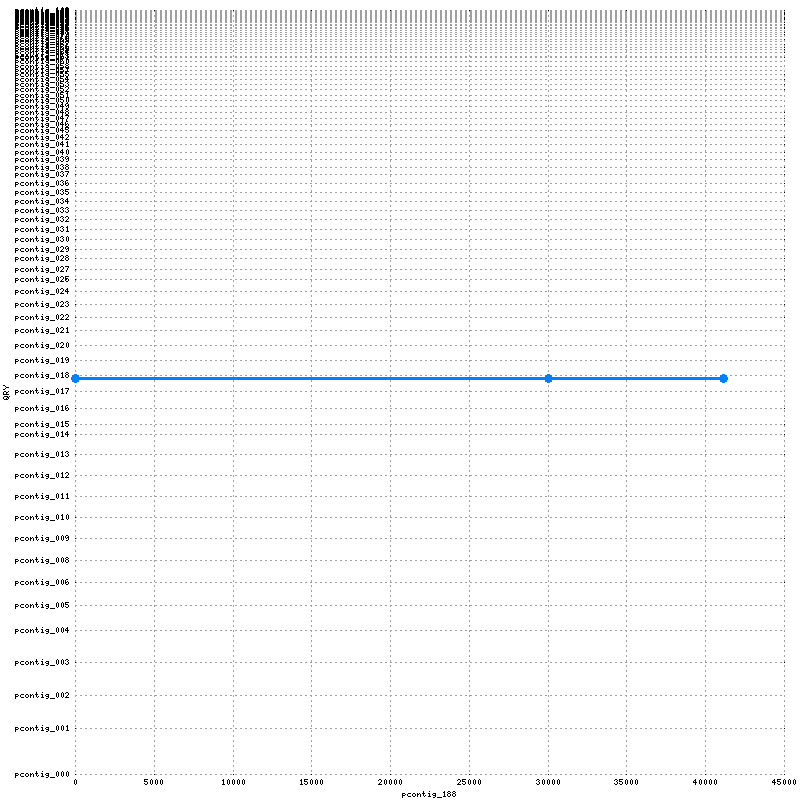

contig pcontig_189 of DK0911p with 31458 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_189.png!

##########



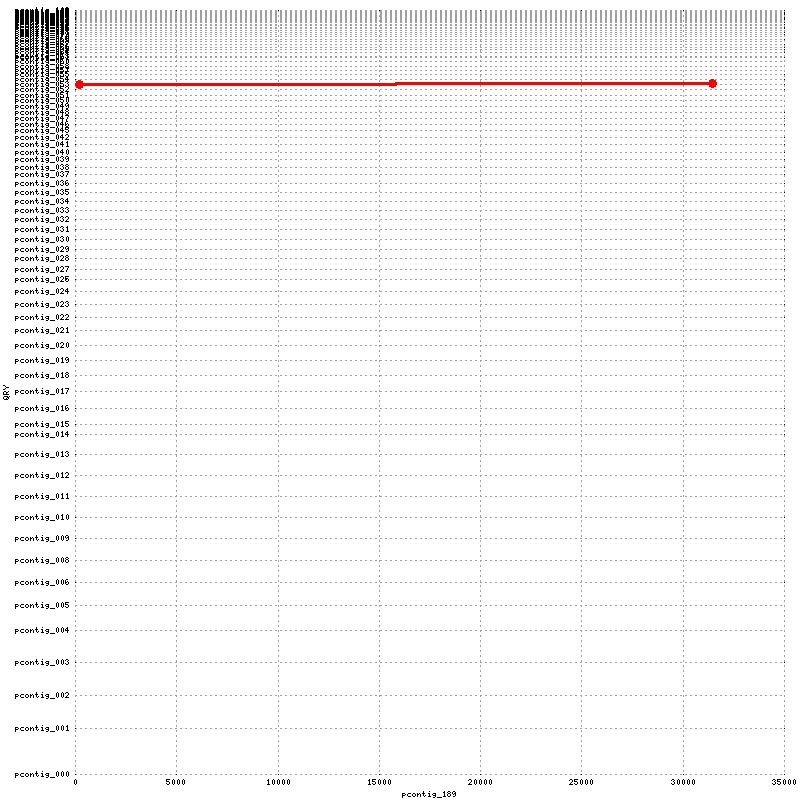

contig pcontig_191 of DK0911p with 39111 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_191.png!

##########



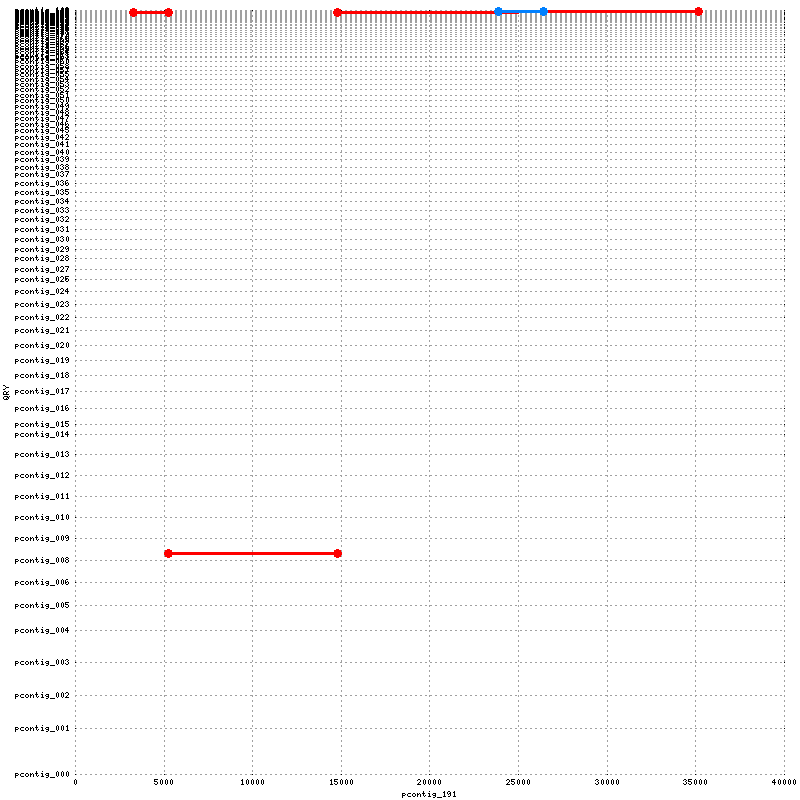

contig pcontig_193 of DK0911p with 63102 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_193.png!

##########



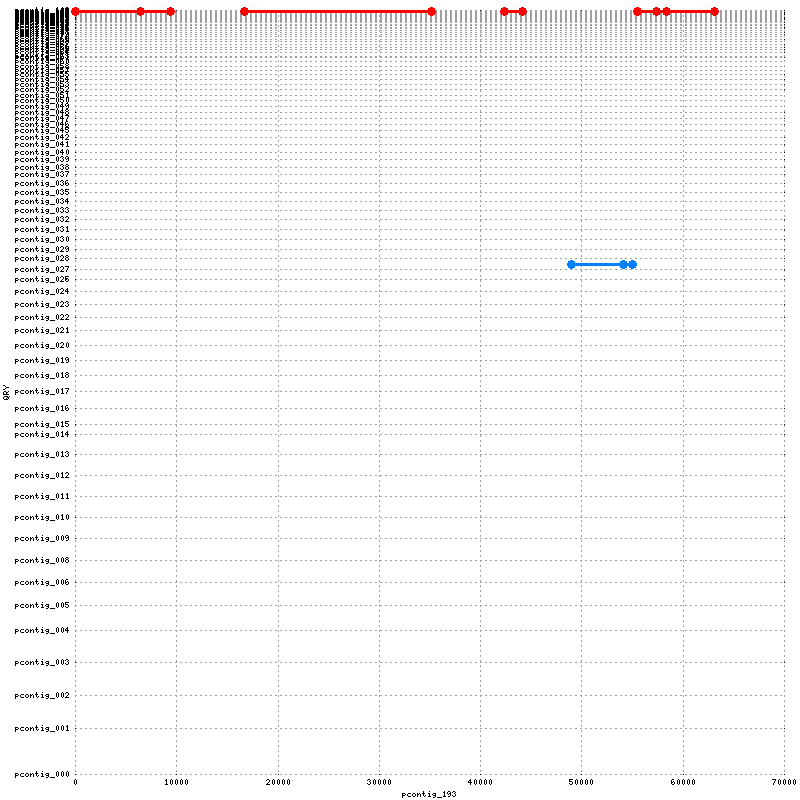

contig pcontig_195 of DK0911p with 37300 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_195.png!

##########



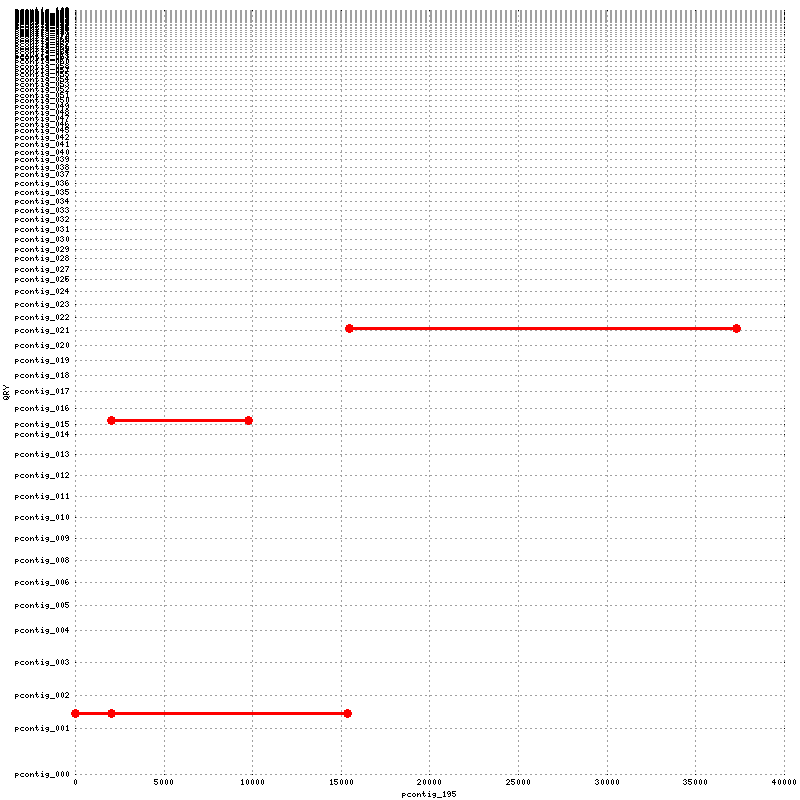

contig pcontig_200 of DK0911p with 35888 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_200.png!

##########



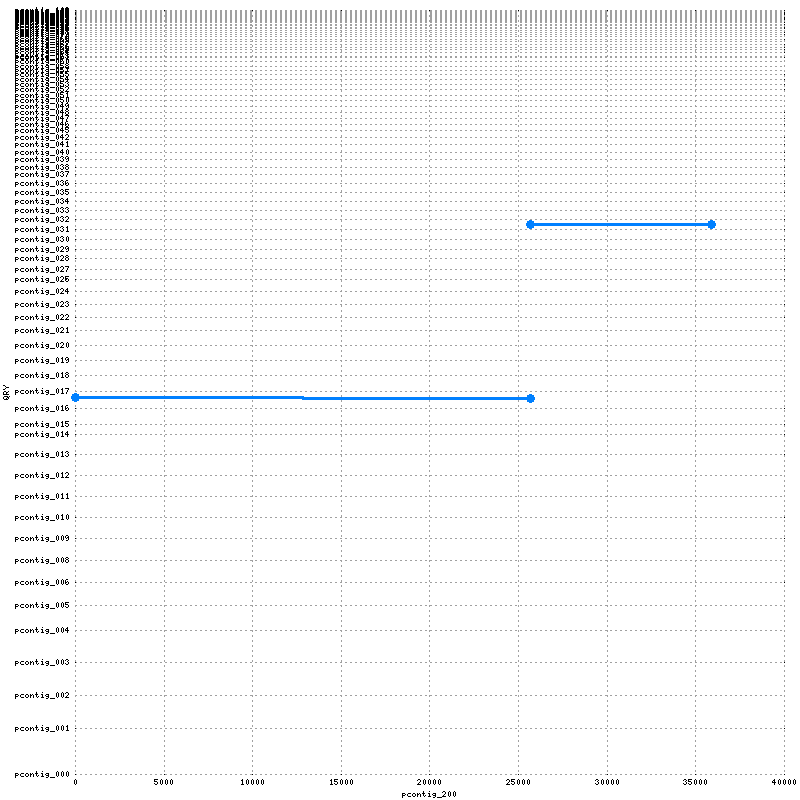

contig pcontig_202 of DK0911p with 35475 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_202.png!

##########



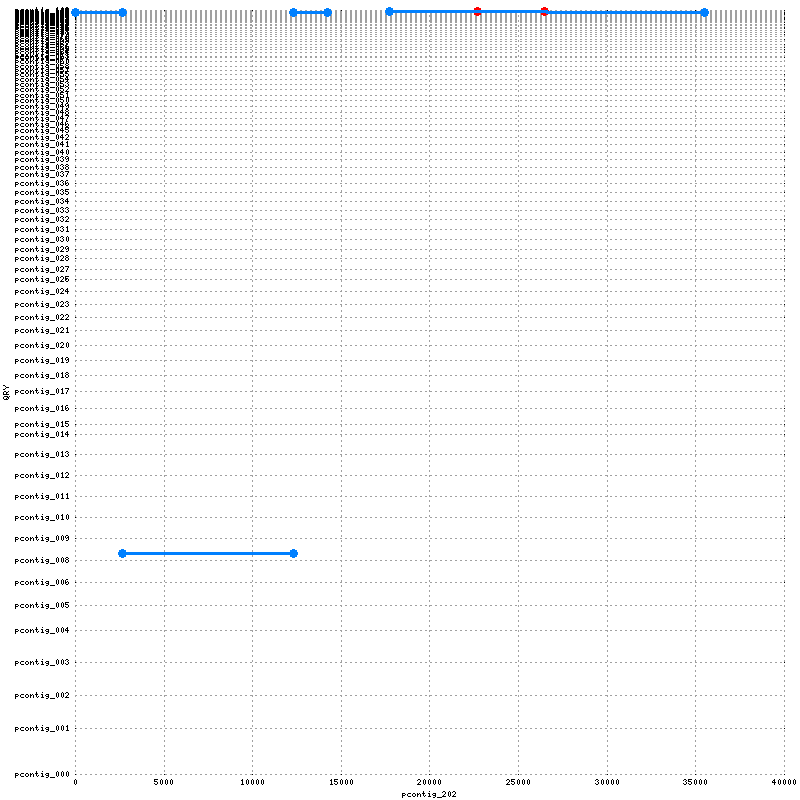

contig pcontig_203 of DK0911p with 35395 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_203.png!

##########



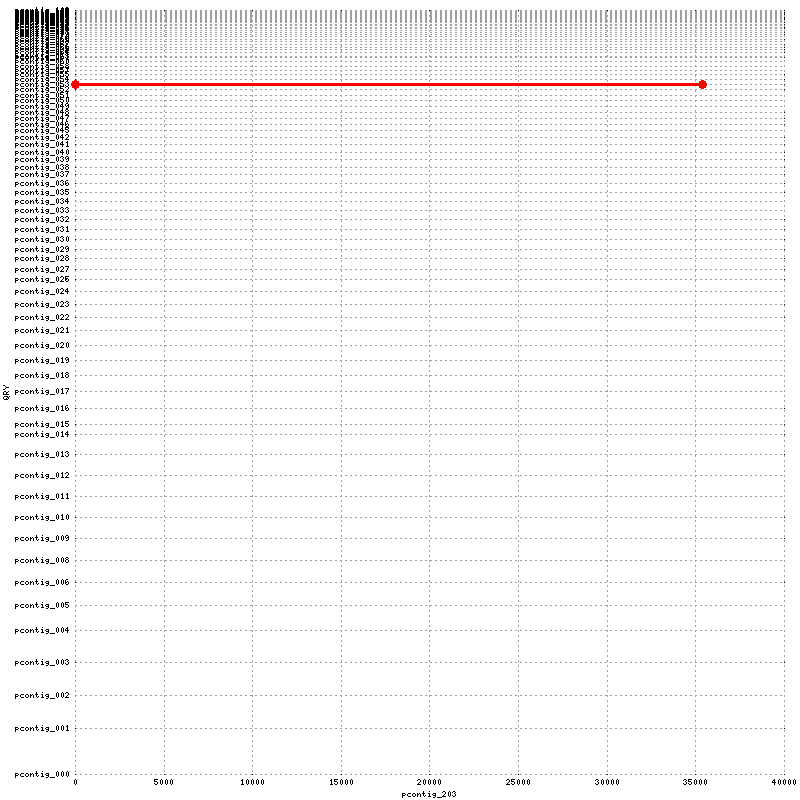

contig pcontig_204 of DK0911p with 35359 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_204.png!

##########



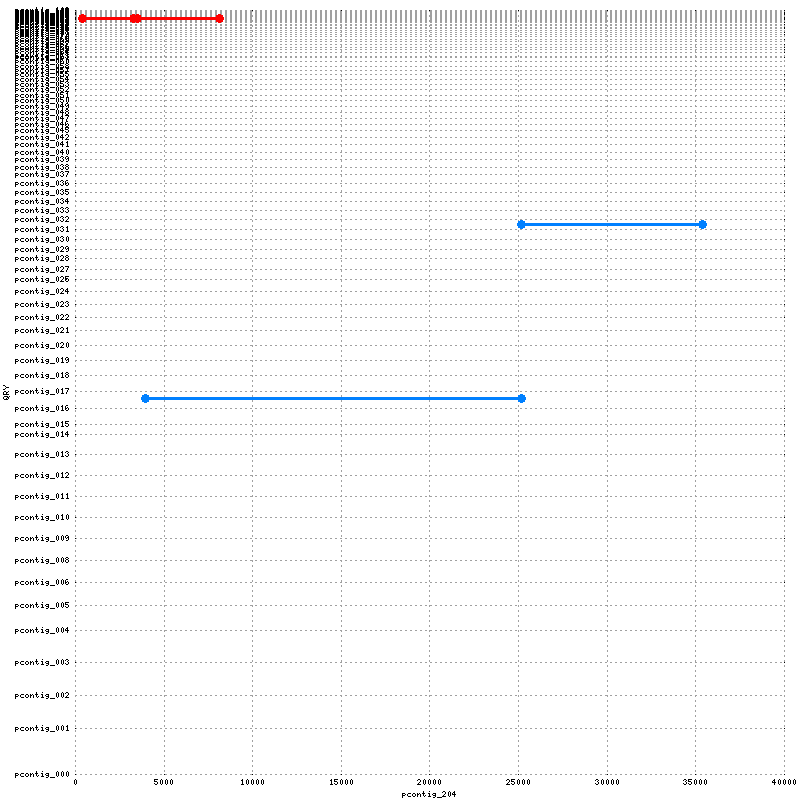

contig pcontig_205 of DK0911p with 35090 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_205.png!

##########



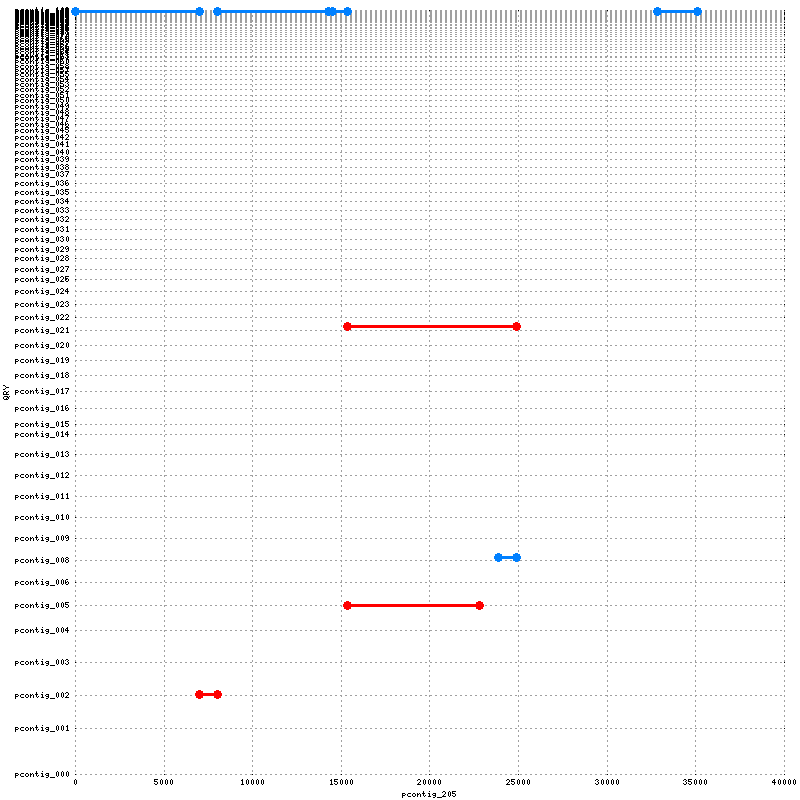

contig pcontig_207 of DK0911p with 34621 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_207.png!

##########



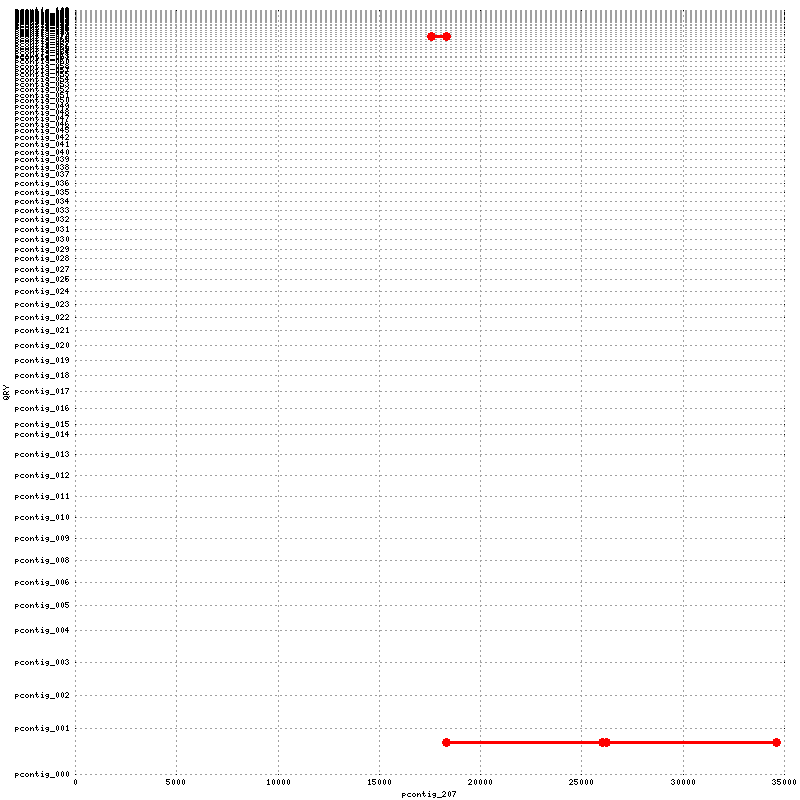

contig pcontig_210 of DK0911p with 34080 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_210.png!

##########



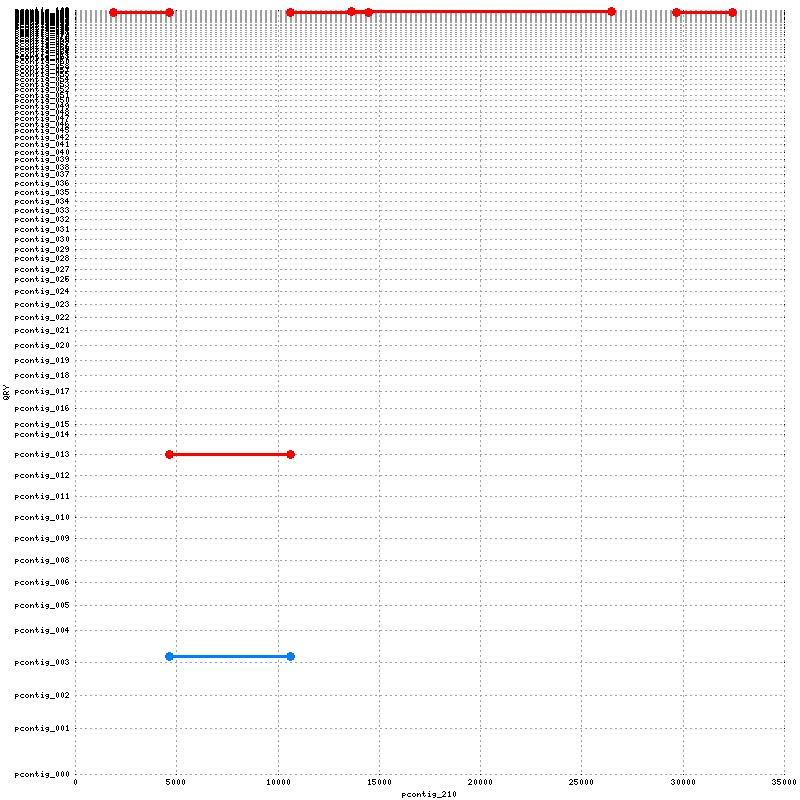

contig pcontig_214 of DK0911p with 32848 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_214.png!

##########



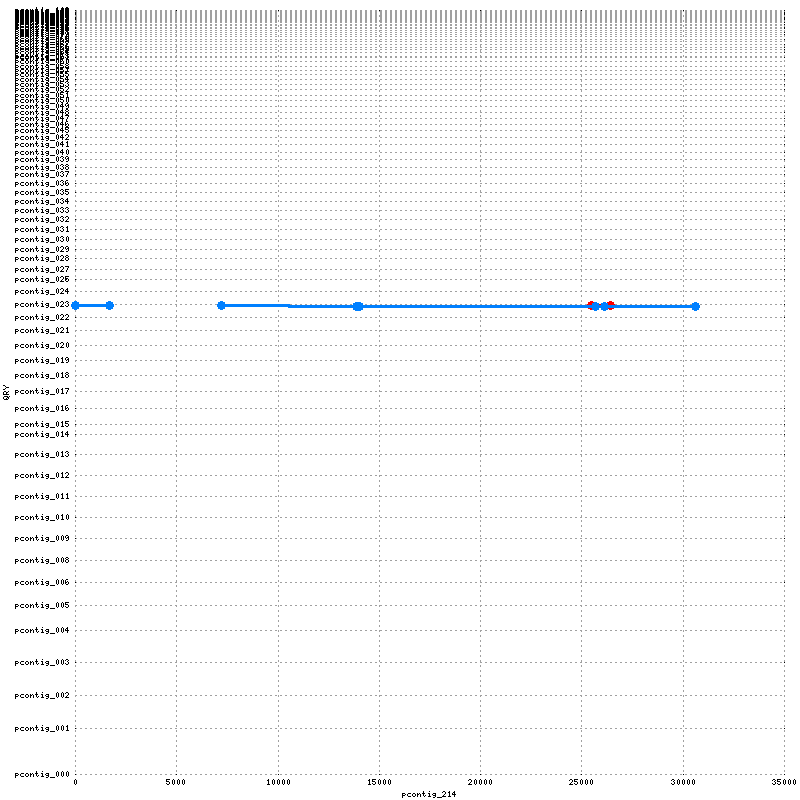

contig pcontig_218 of DK0911p with 26536 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_218.png!

##########



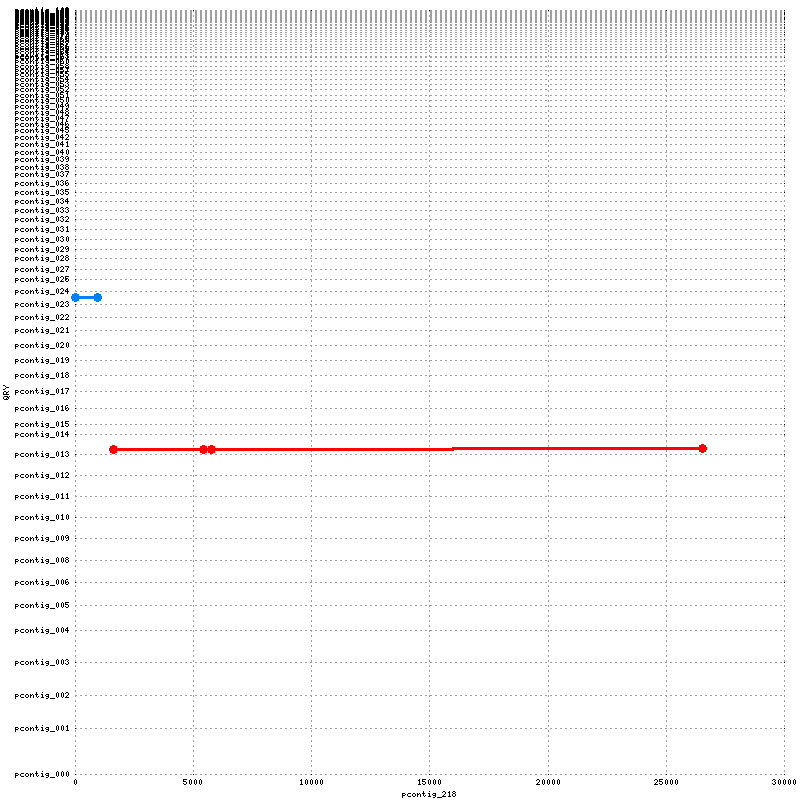

contig pcontig_221 of DK0911p with 29333 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_221.png!

##########



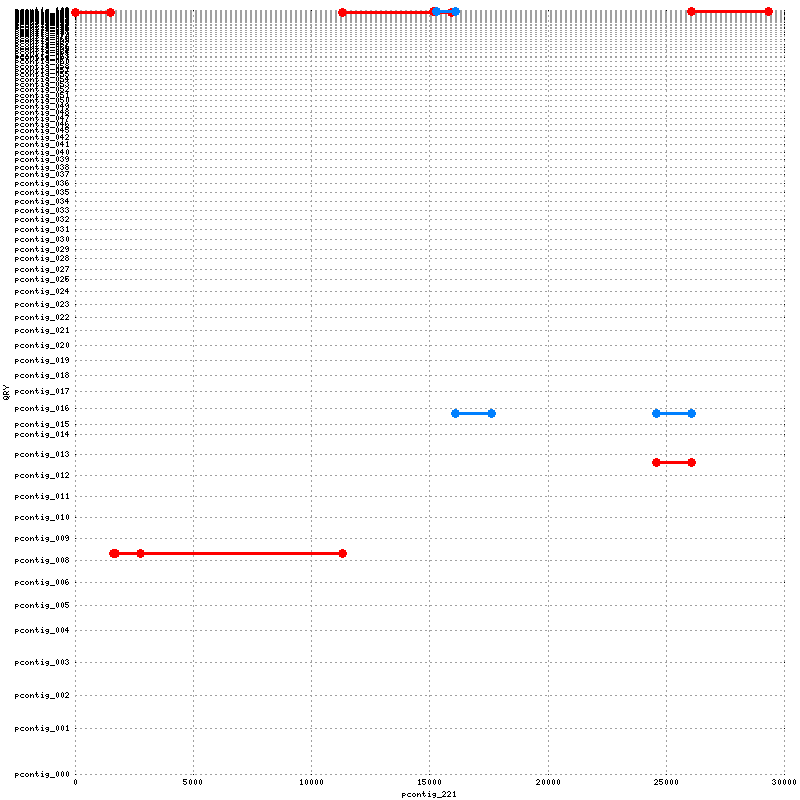

contig pcontig_223 of DK0911p with 27963 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_223.png!

##########



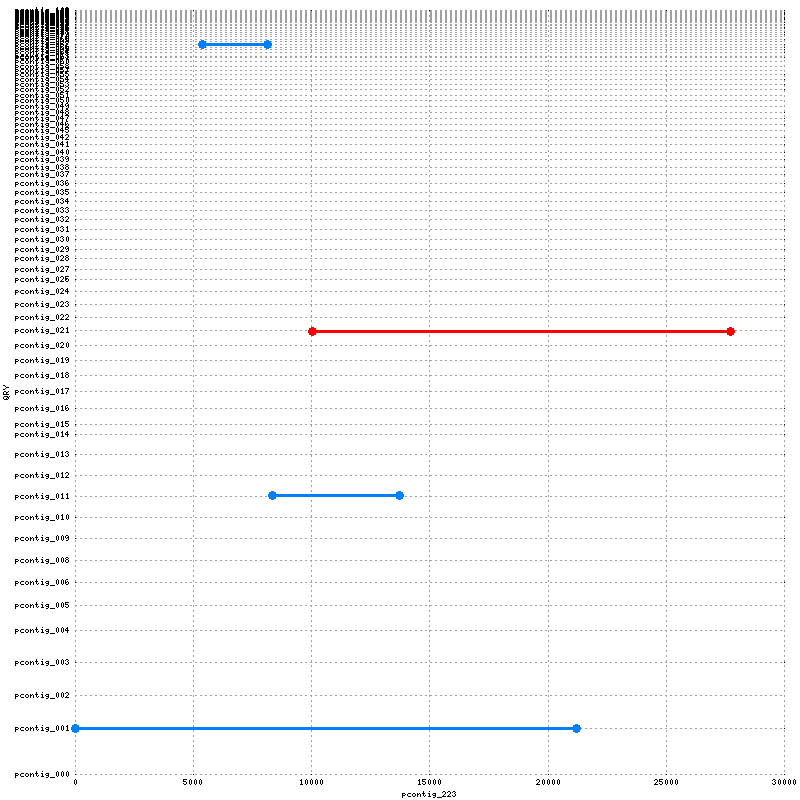

contig pcontig_225 of DK0911p with 27482 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_225.png!

##########



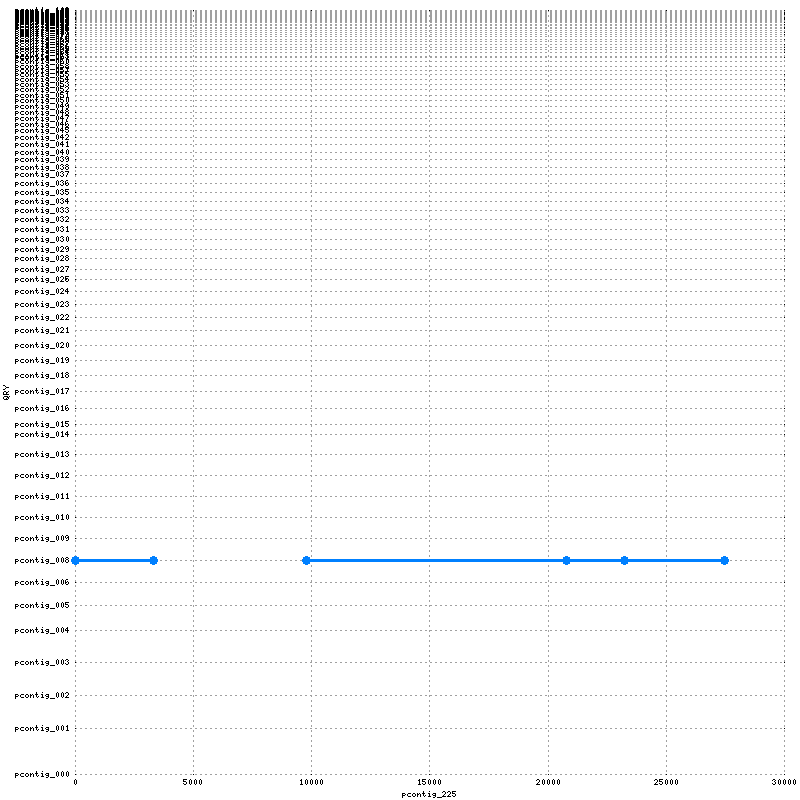

contig pcontig_228 of DK0911p with 27290 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_228.png!

##########



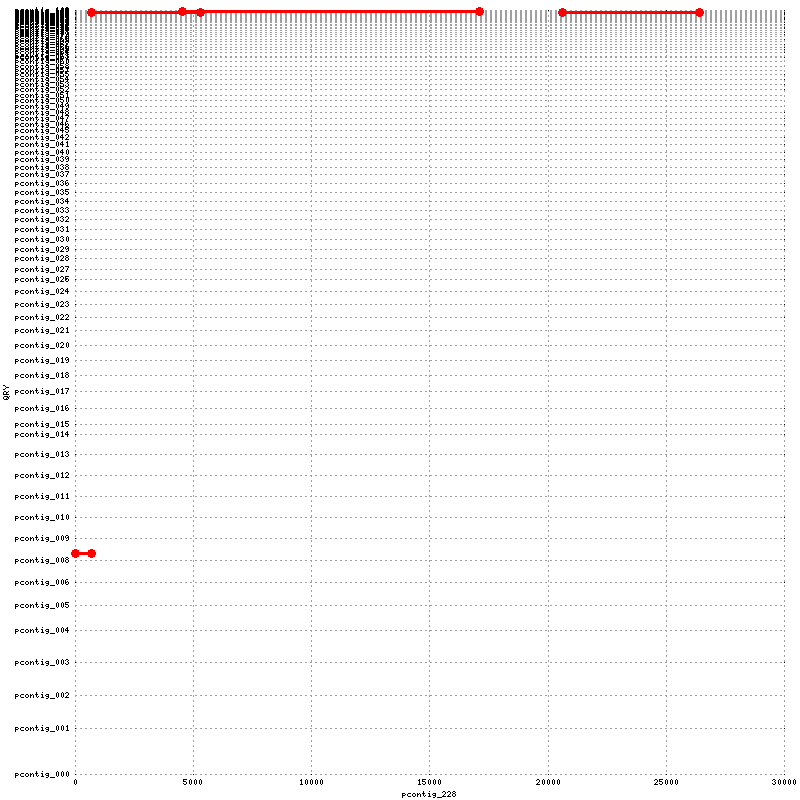

contig pcontig_230 of DK0911p with 50754 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_230.png!

##########



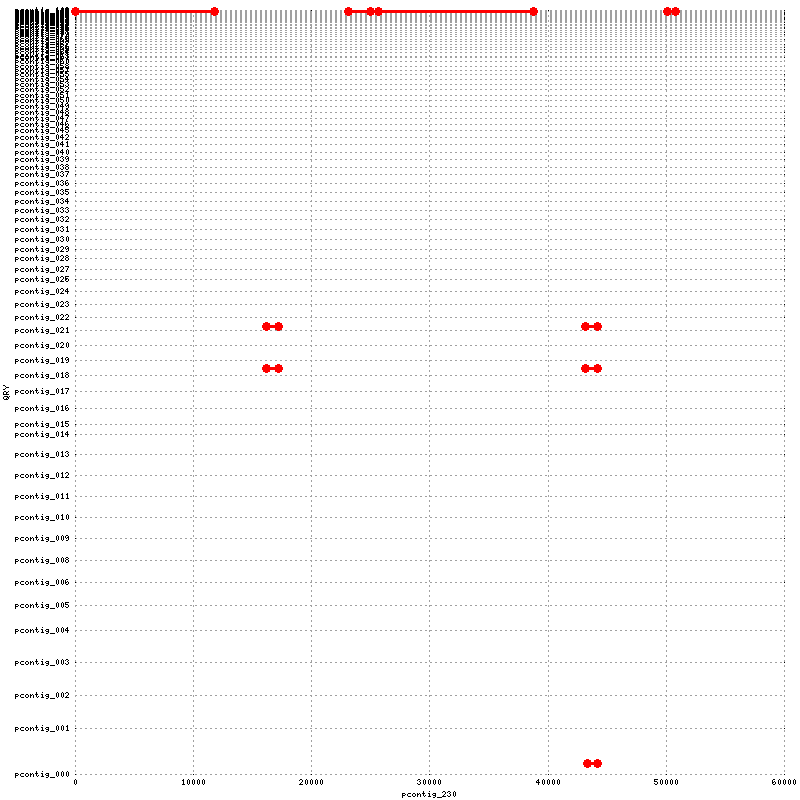

contig pcontig_231 of DK0911p with 26606 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_231.png!

##########



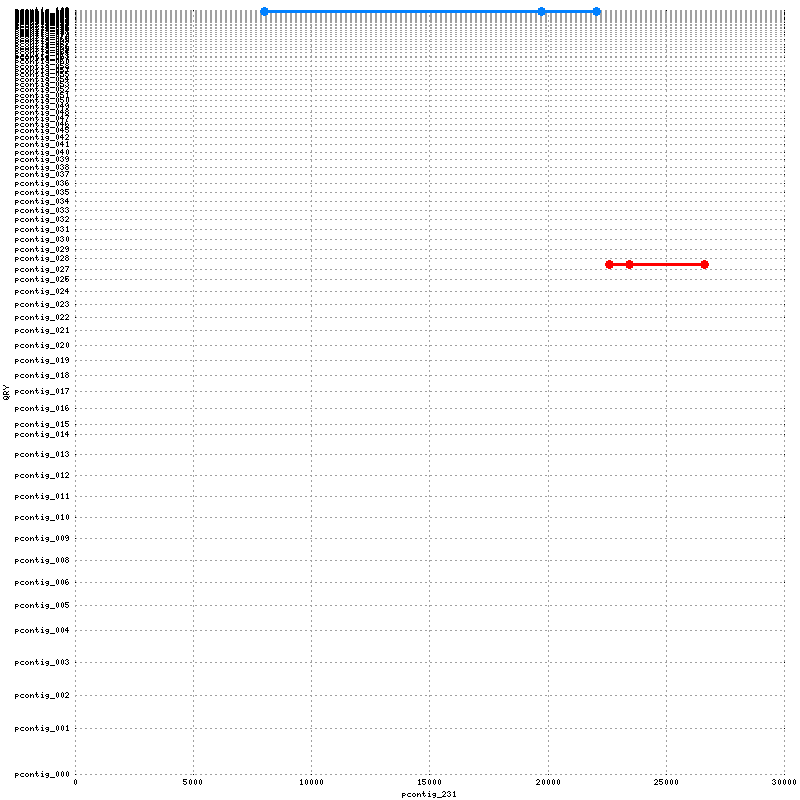

contig pcontig_233 of DK0911p with 26114 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_233.png!

##########



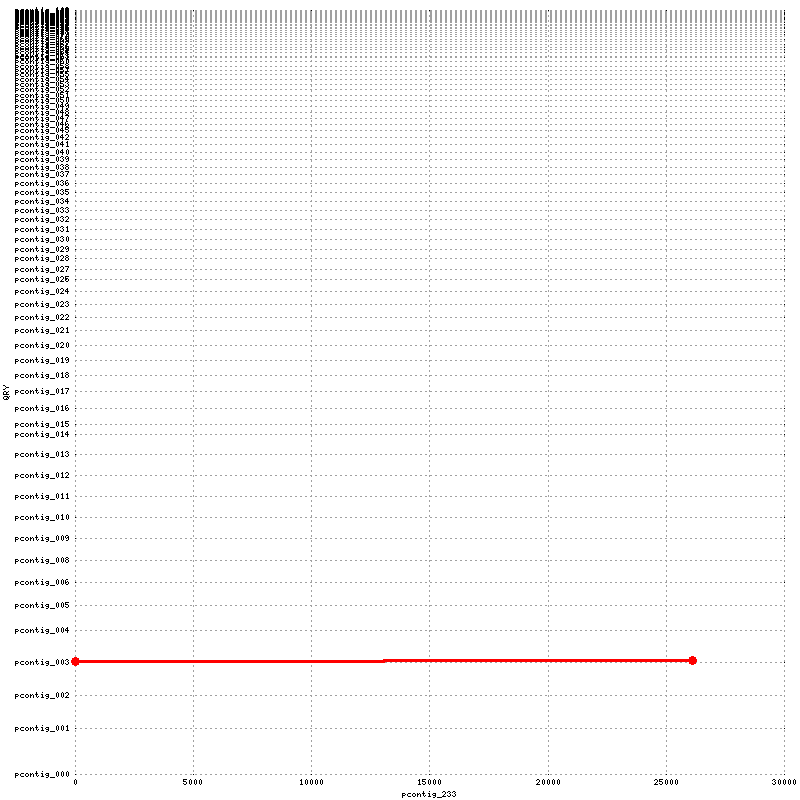

contig pcontig_235 of DK0911p with 25962 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_235.png!

##########



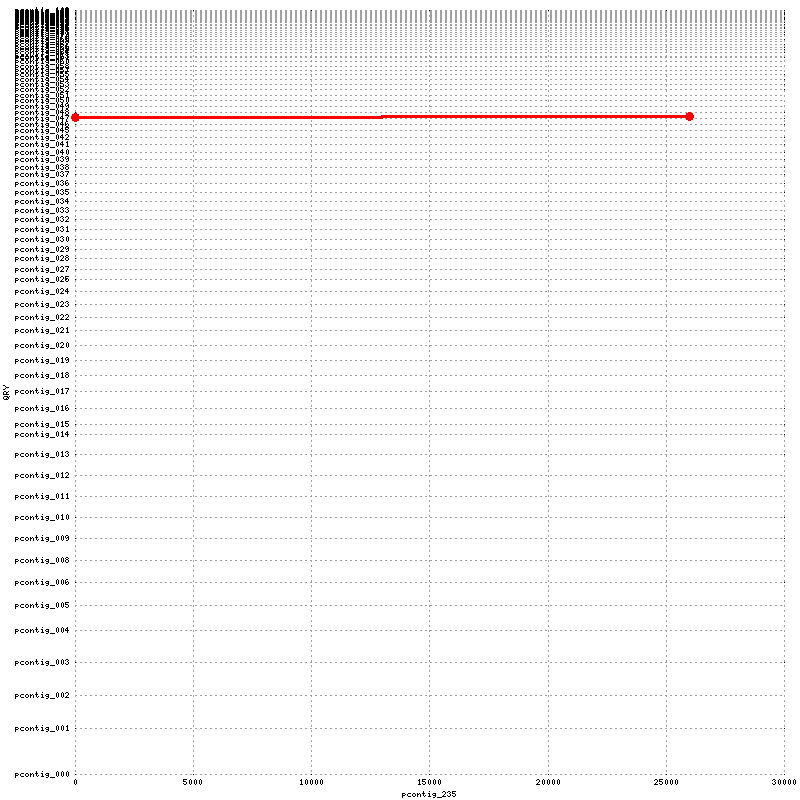

contig pcontig_248 of DK0911p with 21899 length.

##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_248.png!

##########



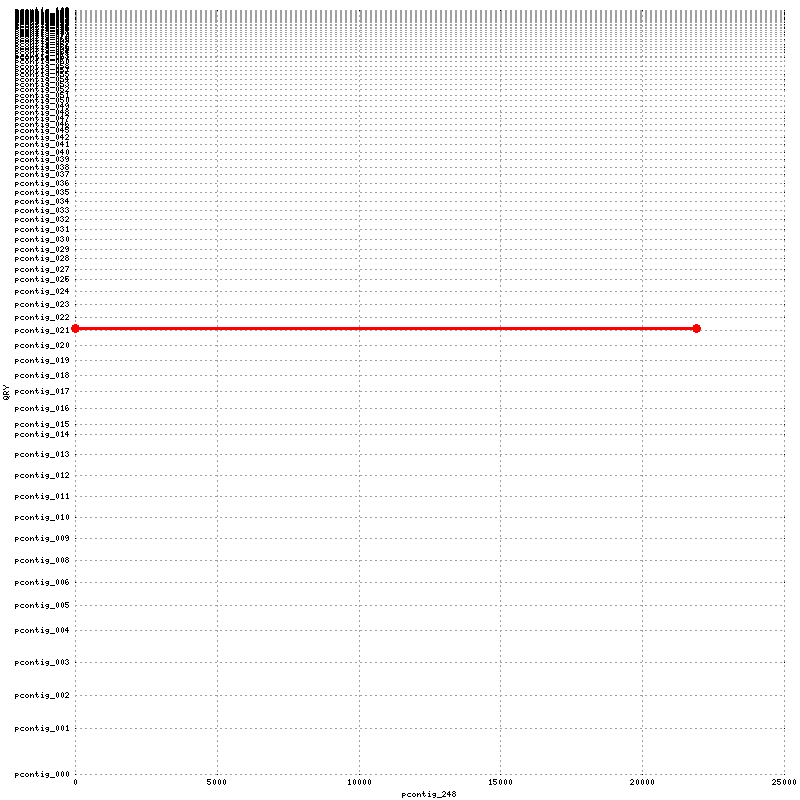

In [137]:
Pst_104_p_contig_dict = {}
for seq in SeqIO.parse(os.path.join(GENOME_FOLDER, PST_104E_p), 'fasta'):
    Pst_104_p_contig_dict[seq.id] = len(seq.seq)
Pst_104_p_contig_dict = OrderedDict(sorted(Pst_104_p_contig_dict.items()))
for seq, length in Pst_104_p_contig_dict.items():
    print('contig %s of DK0911p with %i length.' %(seq, length))
    image = show_align_plot(run_mummerplot(run_delta_filter(delta_Pst_104E_DK0911p_mm, **{'m':'-m', 'i': '-i 98', 'u': '-u 0'}), **{ 'r': '-r %s' % seq }))
    display(image)

contig pcontig_000 of Pst_104_p with 4476905 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_000.png!

##########



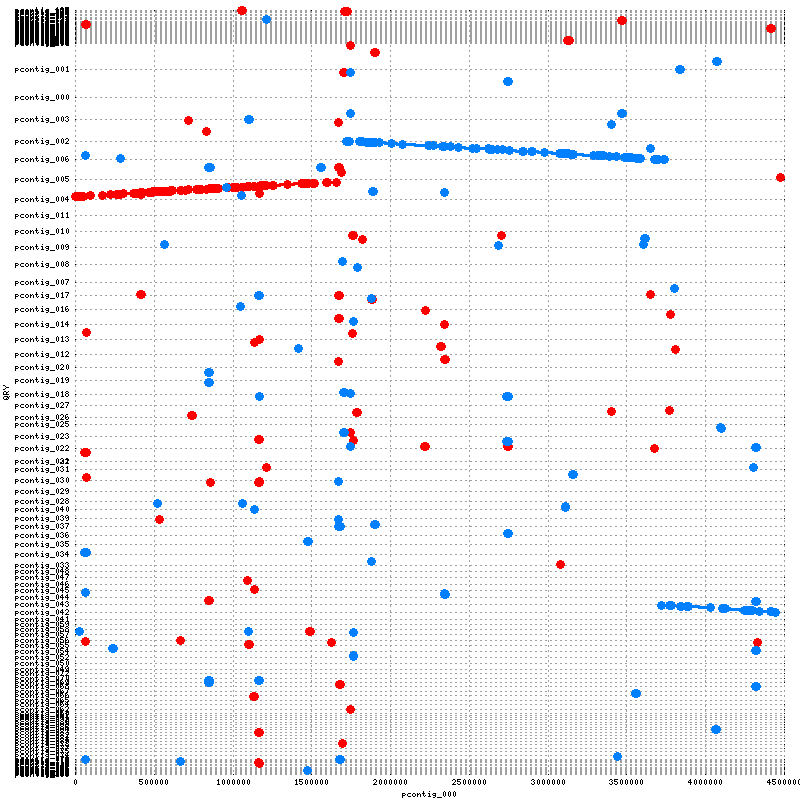

contig pcontig_001 of Pst_104_p with 3225106 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_001.png!

##########



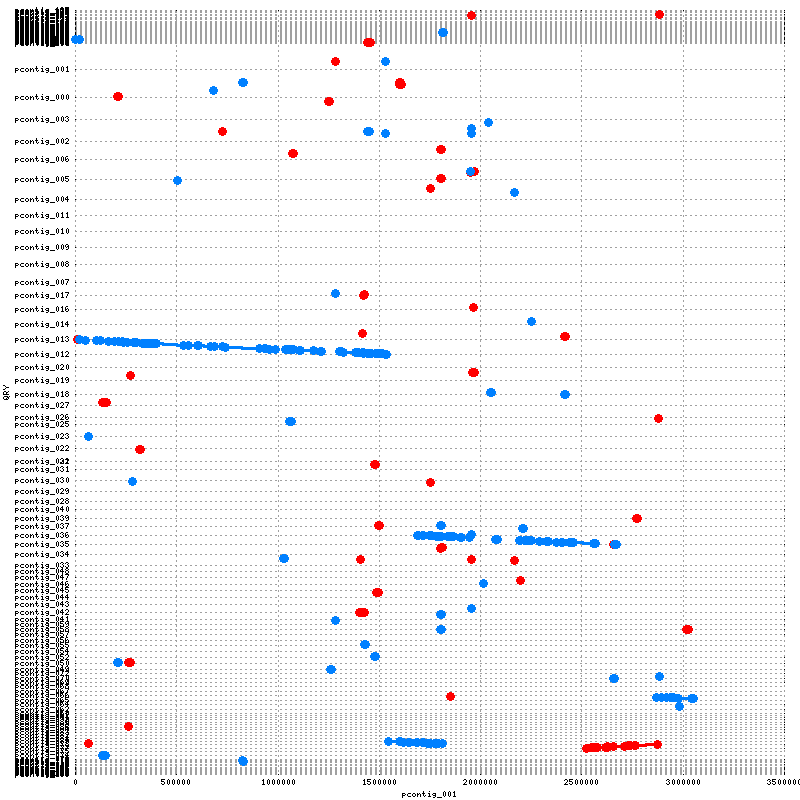

contig pcontig_002 of Pst_104_p with 3233114 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_002.png!

##########



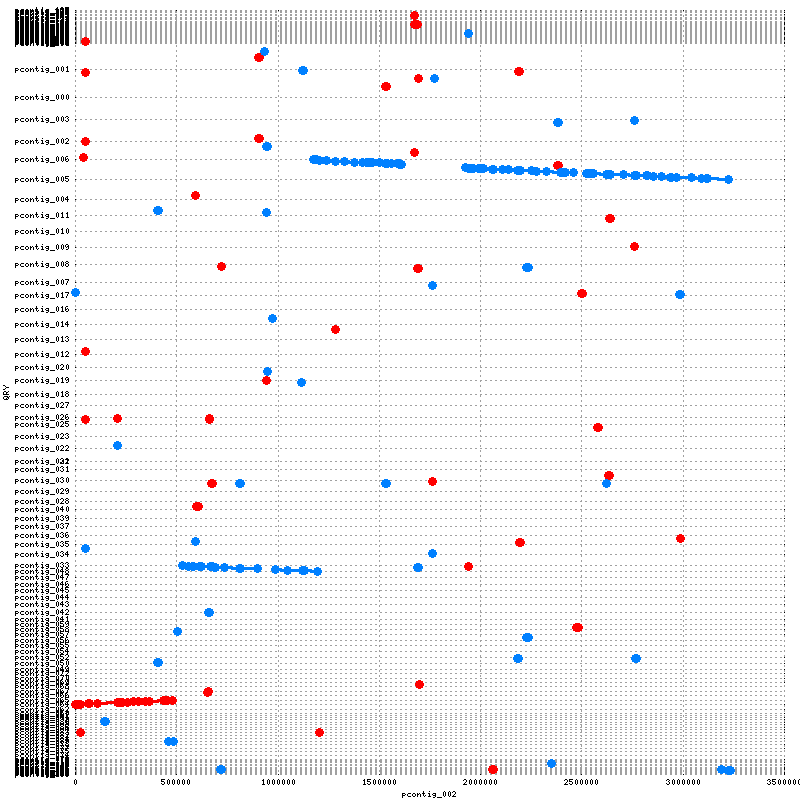

contig pcontig_003 of Pst_104_p with 3047366 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_003.png!

##########



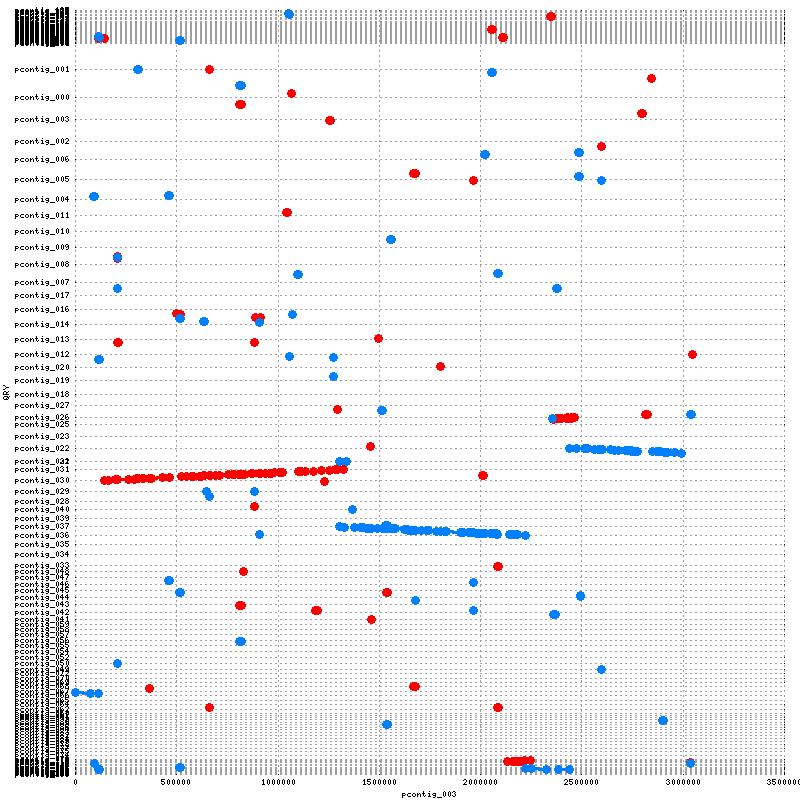

contig pcontig_004 of Pst_104_p with 2526366 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_004.png!

##########



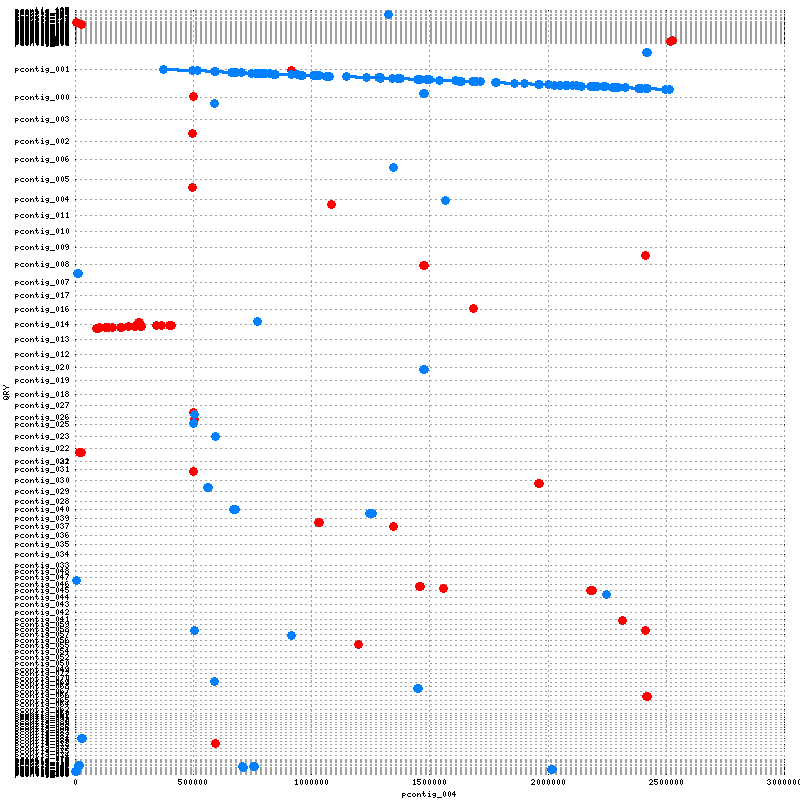

contig pcontig_005 of Pst_104_p with 2231549 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_005.png!

##########



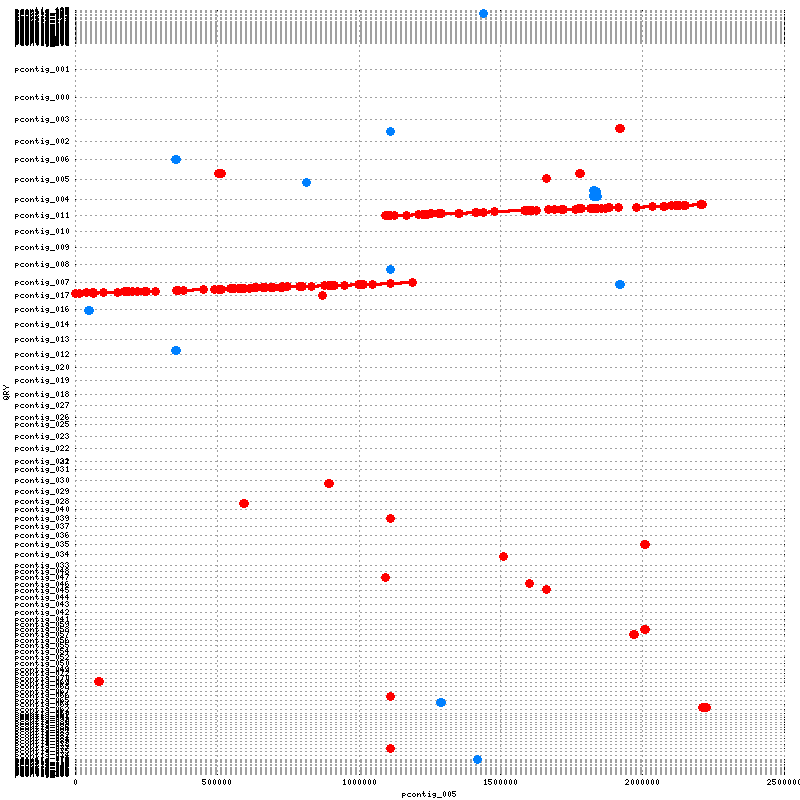

contig pcontig_006 of Pst_104_p with 2102132 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_006.png!

##########



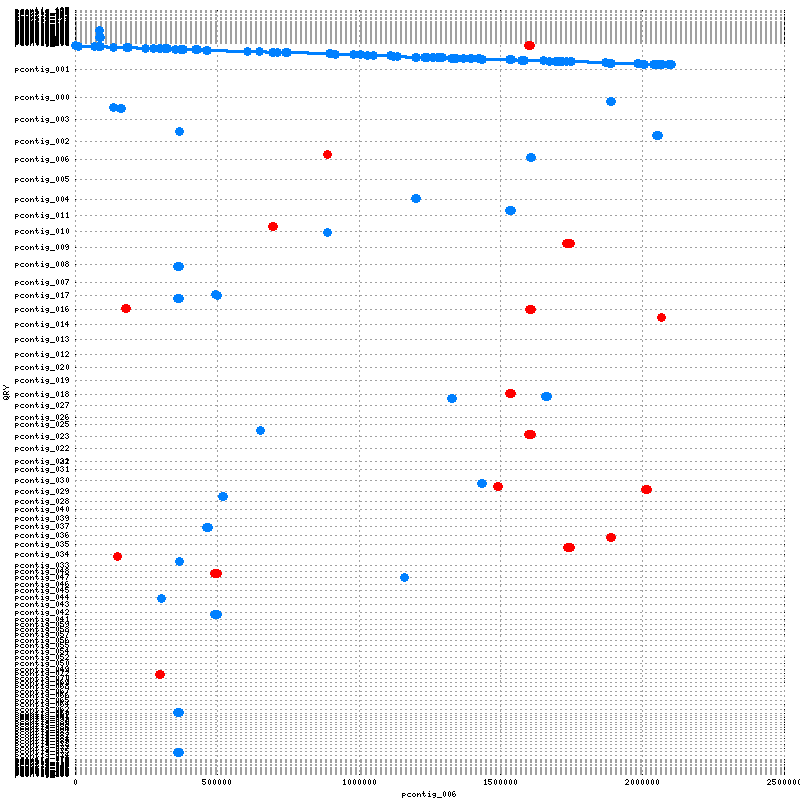

contig pcontig_008 of Pst_104_p with 2117500 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_008.png!

##########



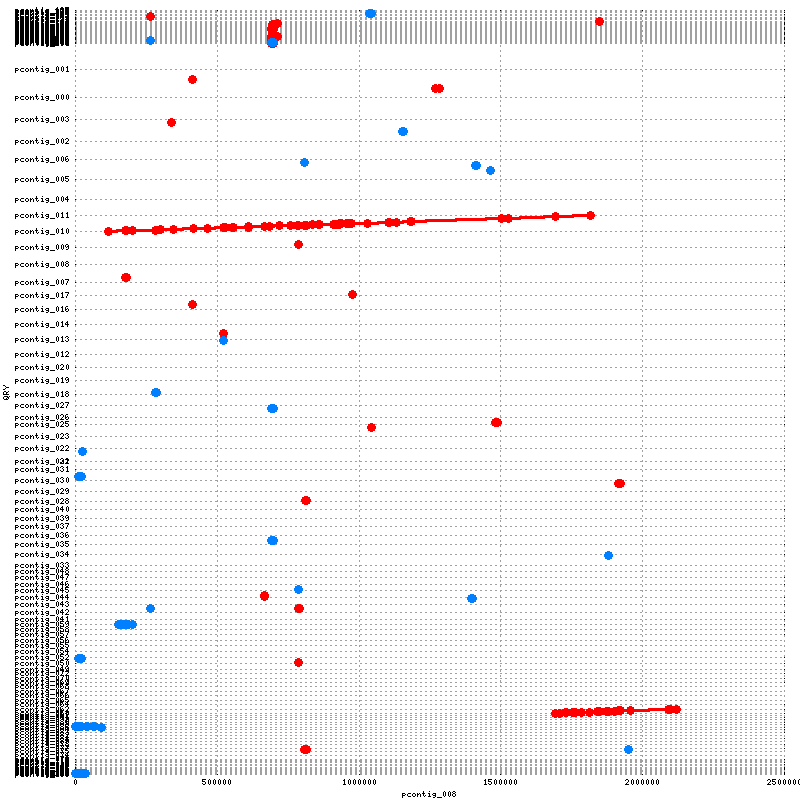

contig pcontig_009 of Pst_104_p with 2058895 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_009.png!

##########



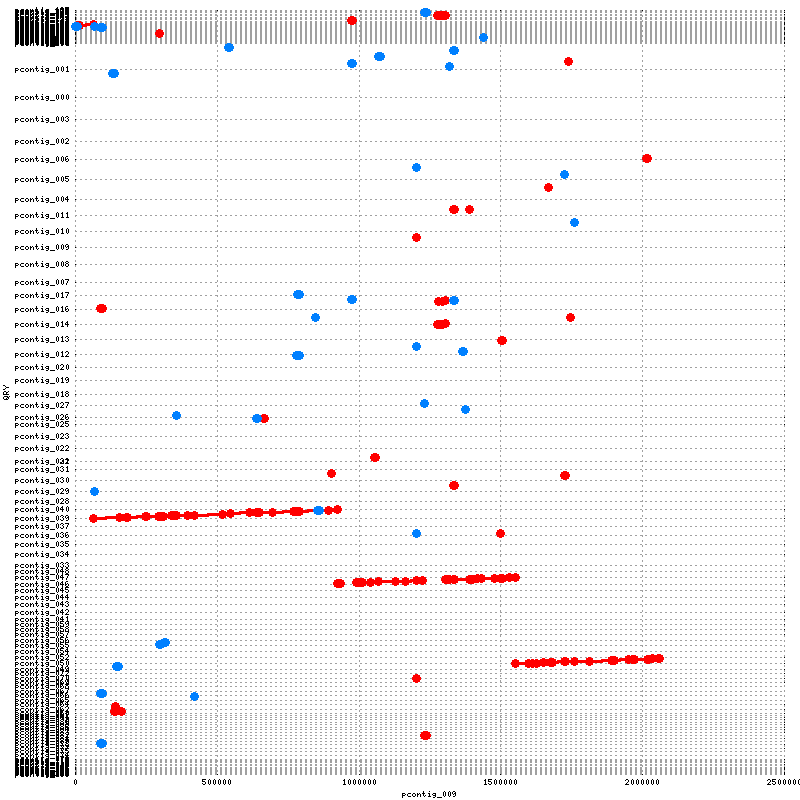

contig pcontig_010 of Pst_104_p with 2098236 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_010.png!

##########



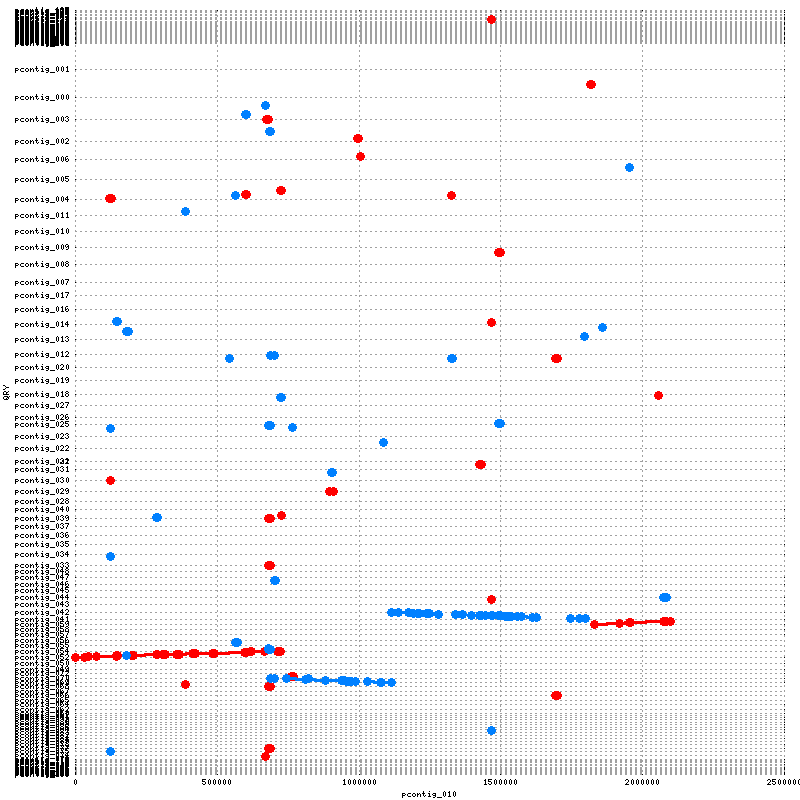

contig pcontig_011 of Pst_104_p with 2020461 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_011.png!

##########



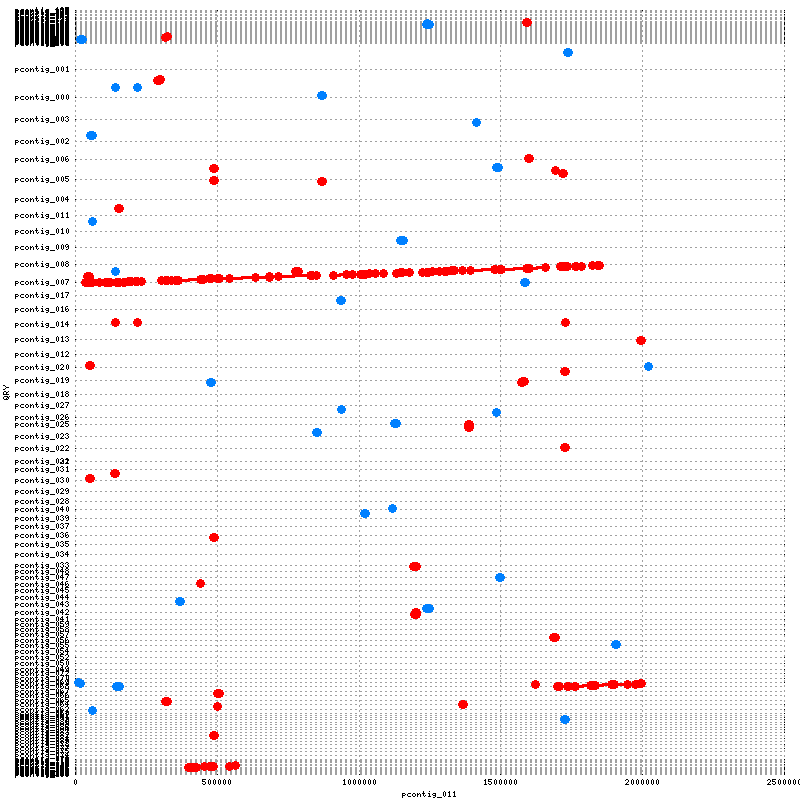

contig pcontig_012 of Pst_104_p with 2014747 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_012.png!

##########



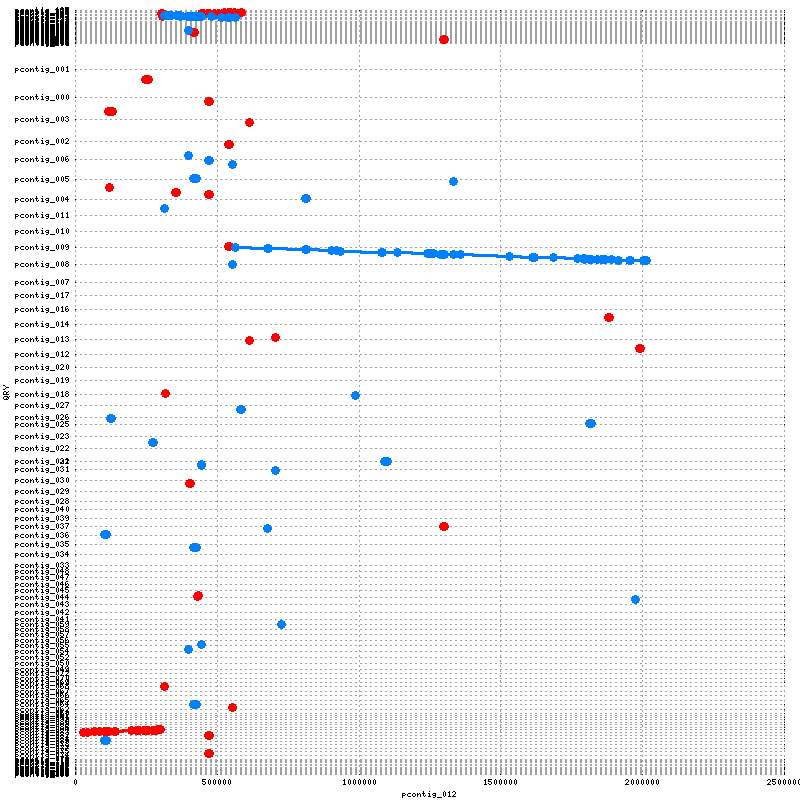

contig pcontig_013 of Pst_104_p with 1937580 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_013.png!

##########



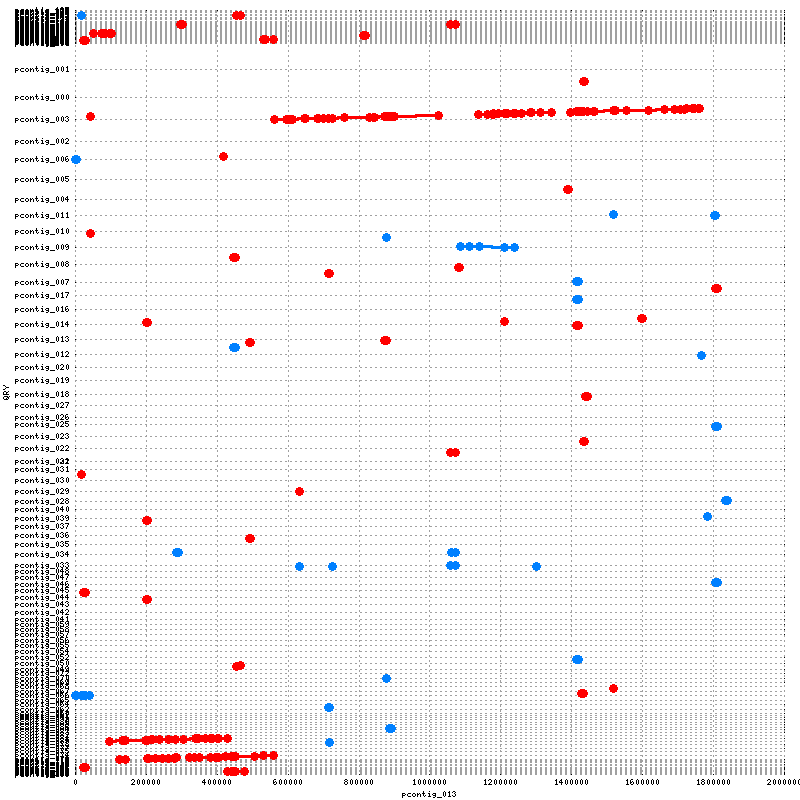

contig pcontig_014 of Pst_104_p with 975977 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_014.png!

##########



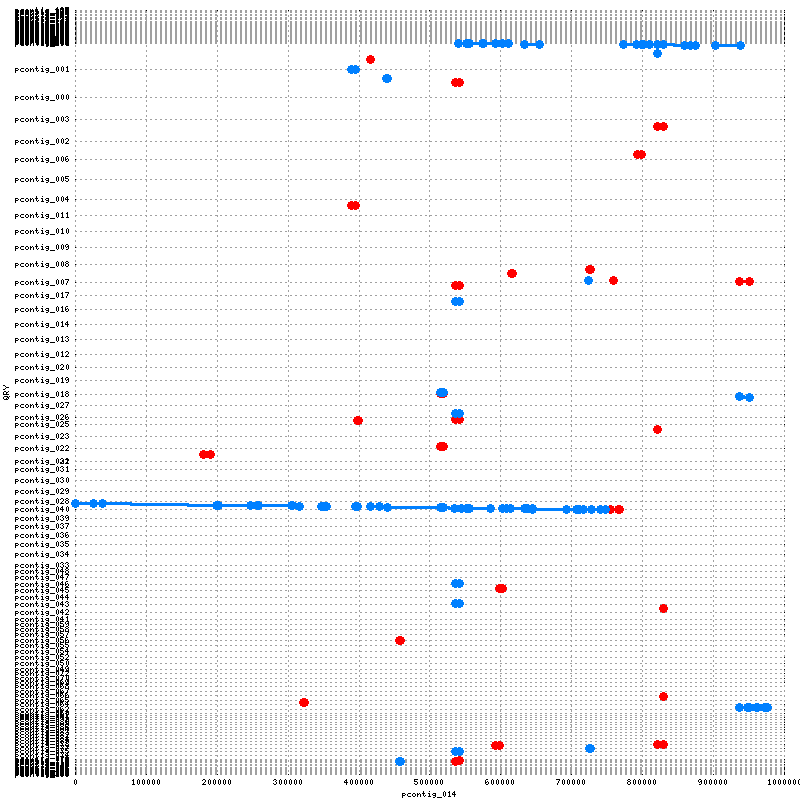

contig pcontig_015 of Pst_104_p with 1632307 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_015.png!

##########



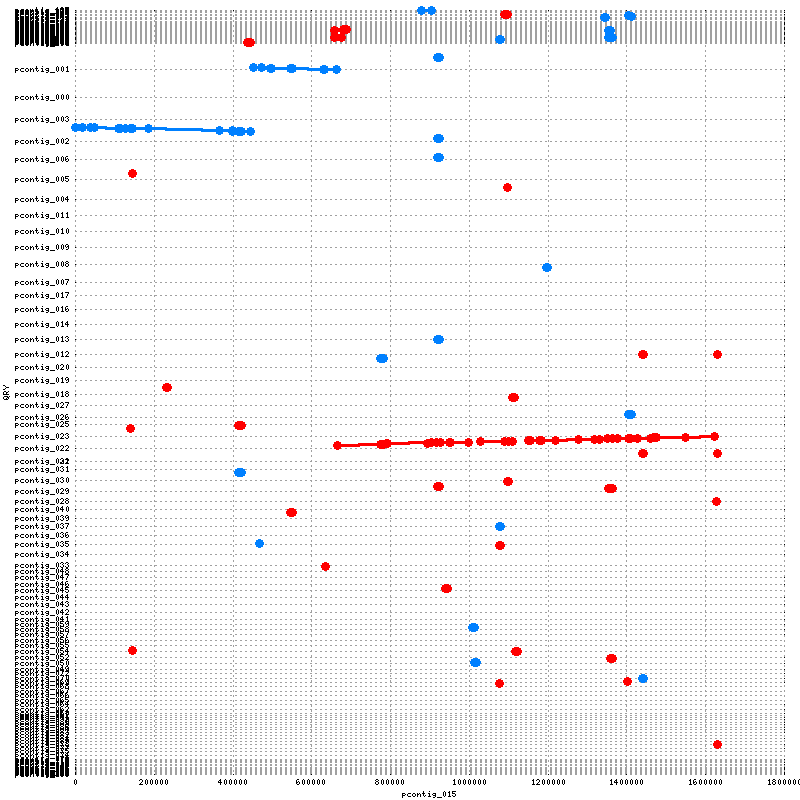

contig pcontig_016 of Pst_104_p with 1590105 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_016.png!

##########



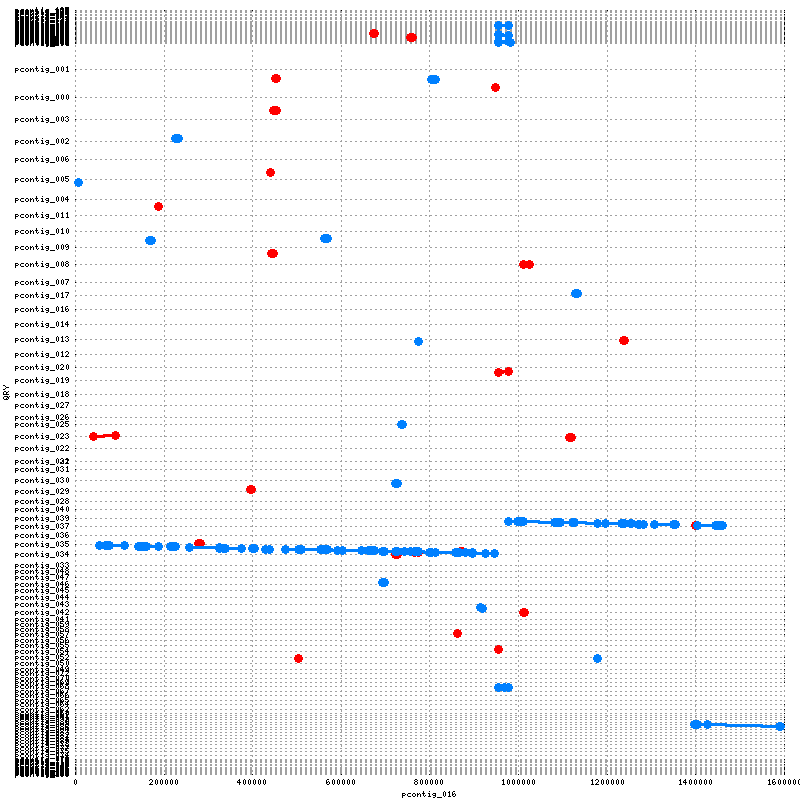

contig pcontig_017 of Pst_104_p with 1543748 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_017.png!

##########



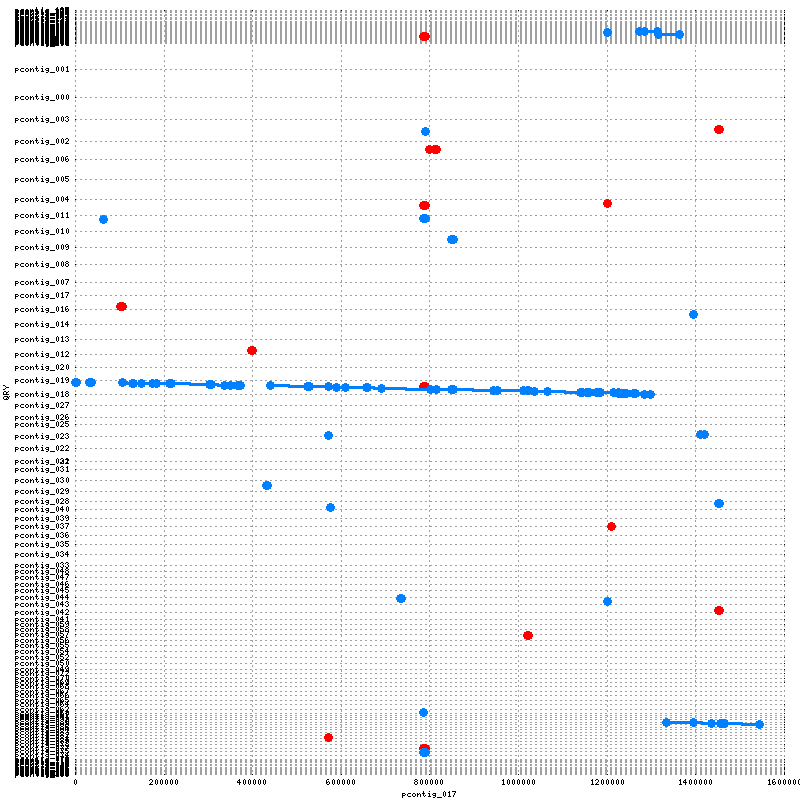

contig pcontig_018 of Pst_104_p with 1541929 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_018.png!

##########



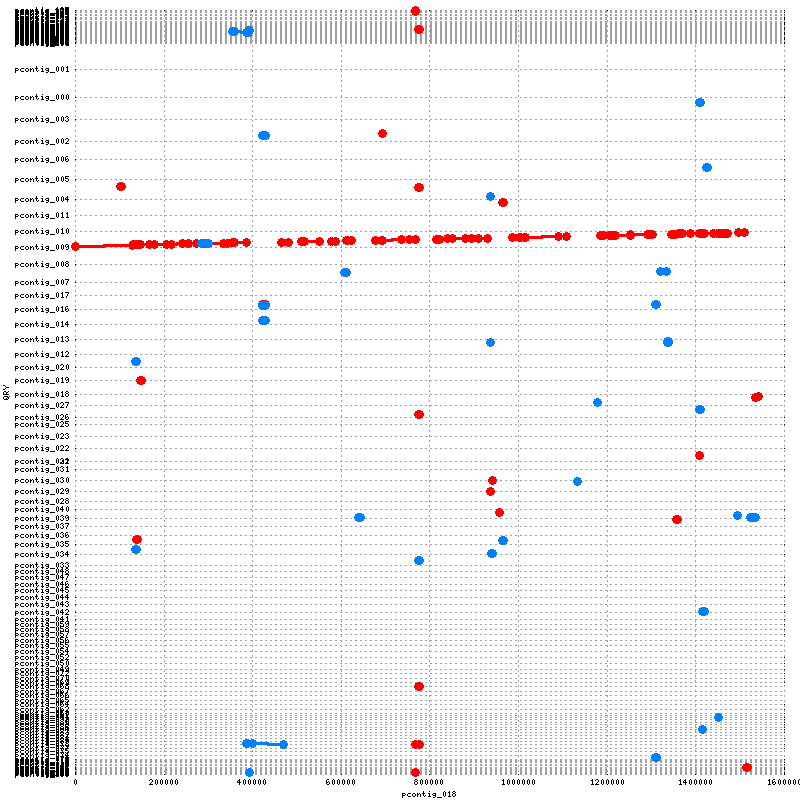

contig pcontig_019 of Pst_104_p with 1432633 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_019.png!

##########



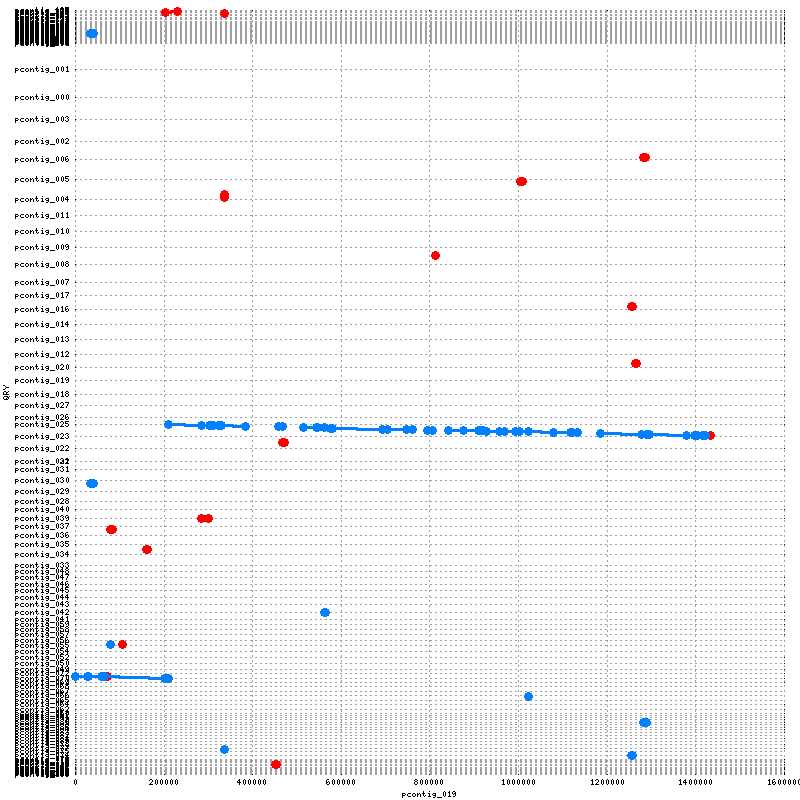

contig pcontig_020 of Pst_104_p with 1403510 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_020.png!

##########



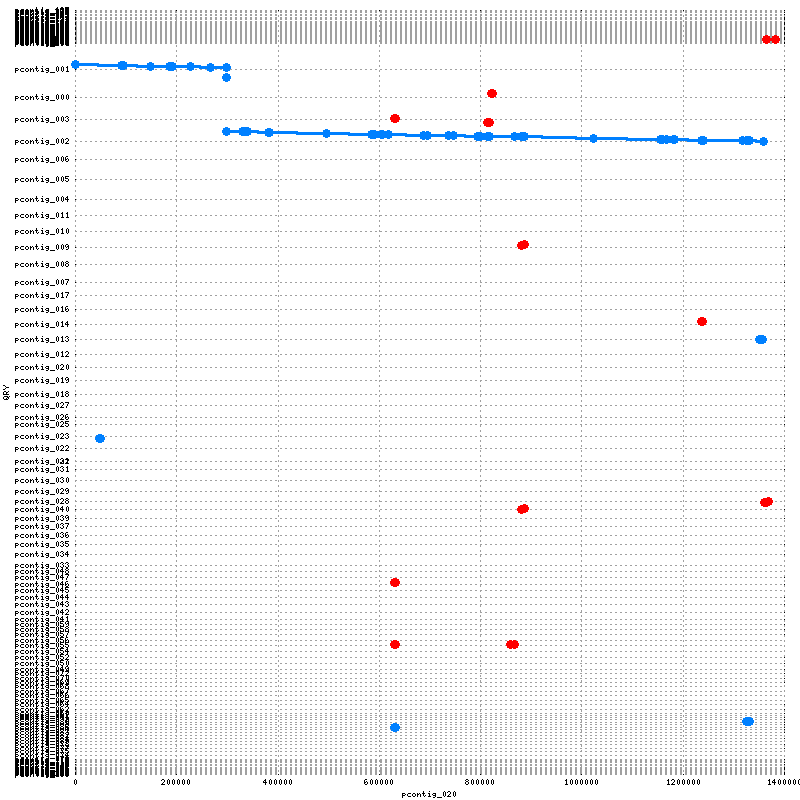

contig pcontig_021 of Pst_104_p with 1341714 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_021.png!

##########



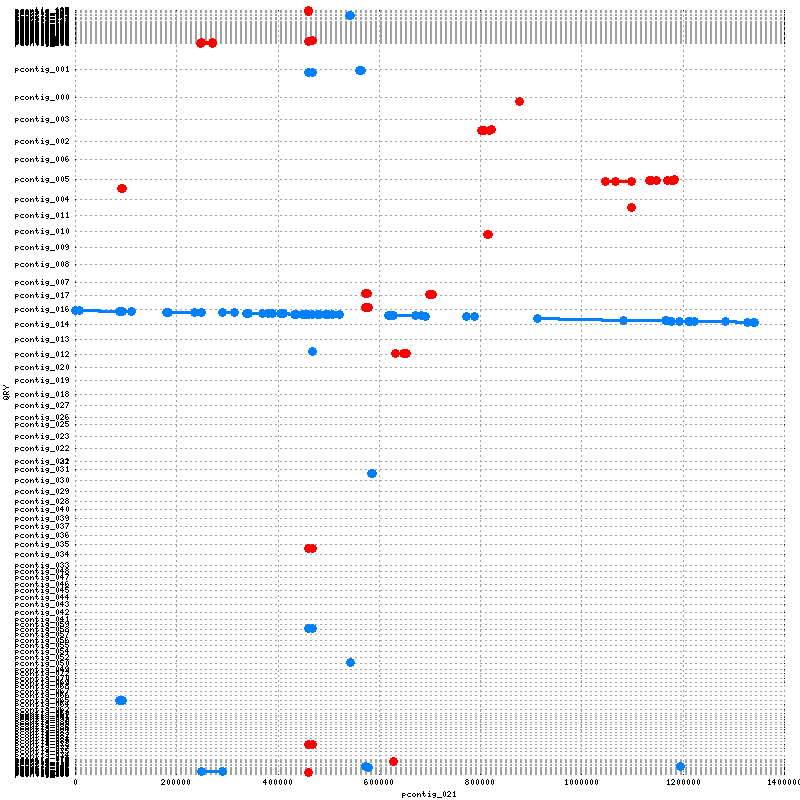

contig pcontig_022 of Pst_104_p with 1267121 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_022.png!

##########



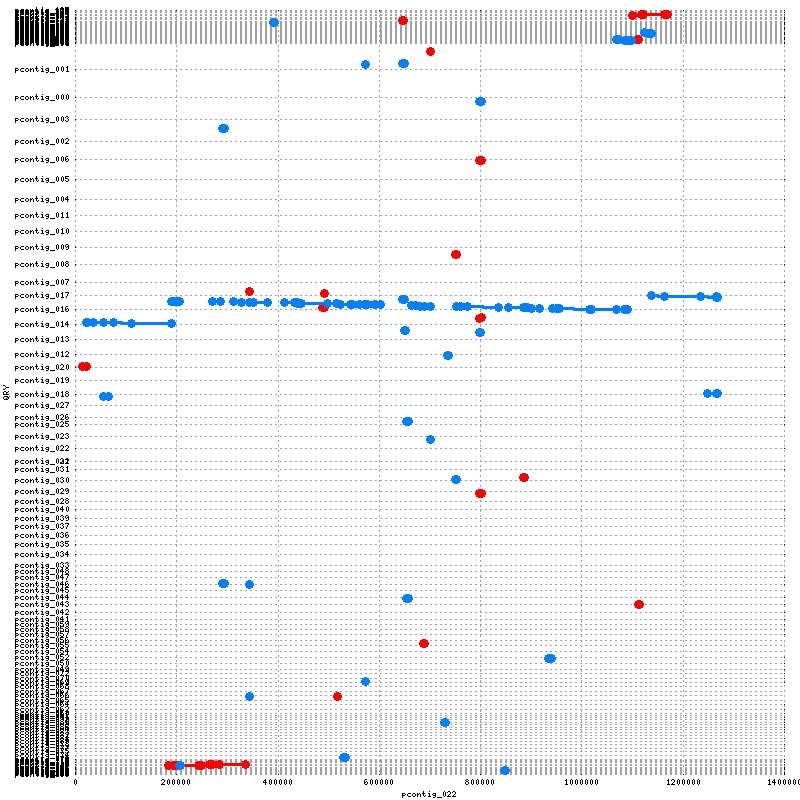

contig pcontig_023 of Pst_104_p with 1266820 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_023.png!

##########



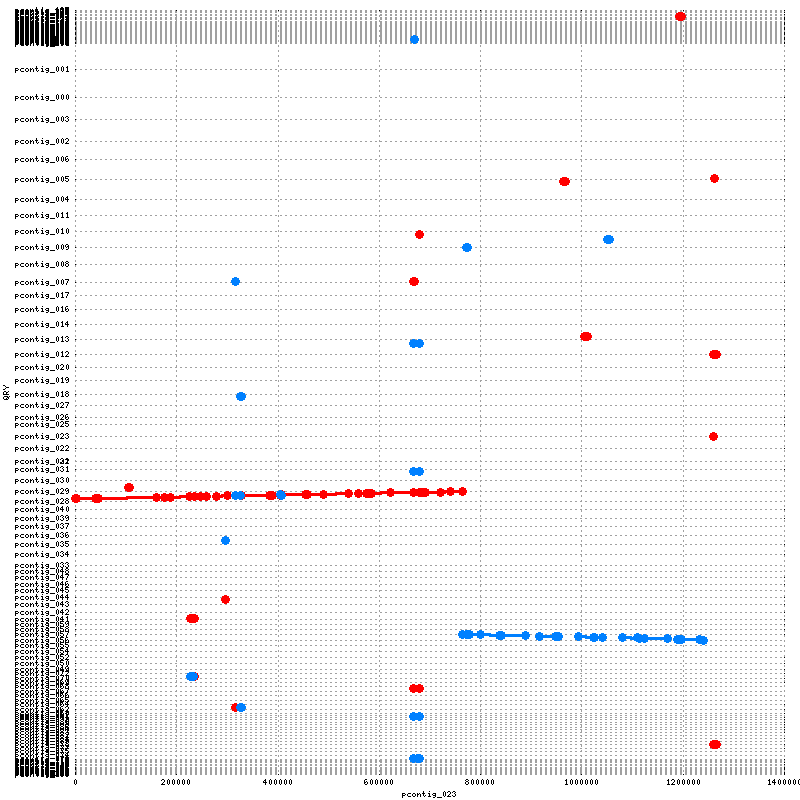

contig pcontig_024 of Pst_104_p with 1097733 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_024.png!

##########



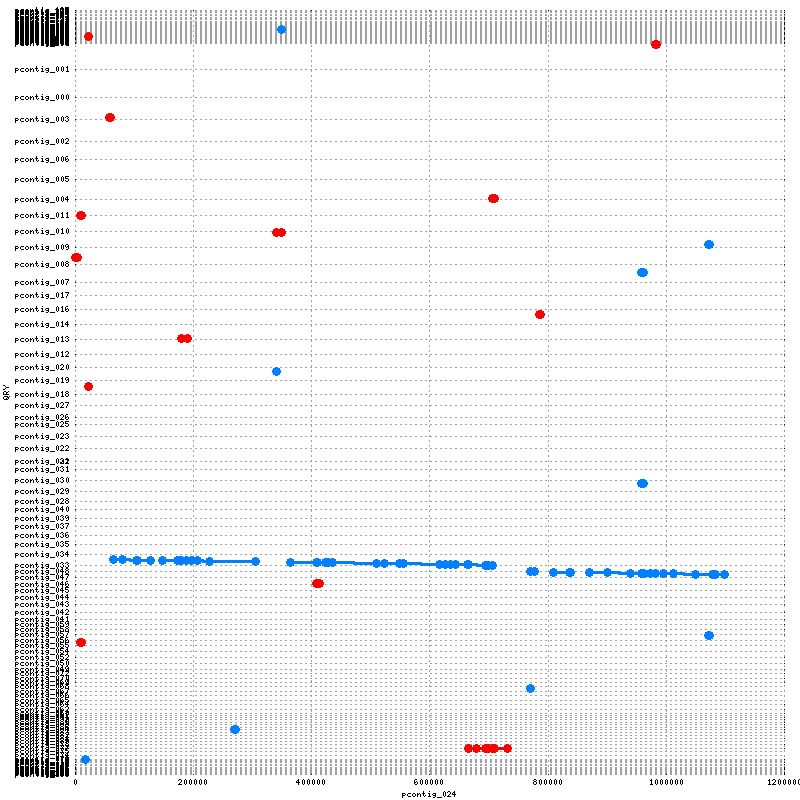

contig pcontig_025 of Pst_104_p with 25437 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_025.png!

##########



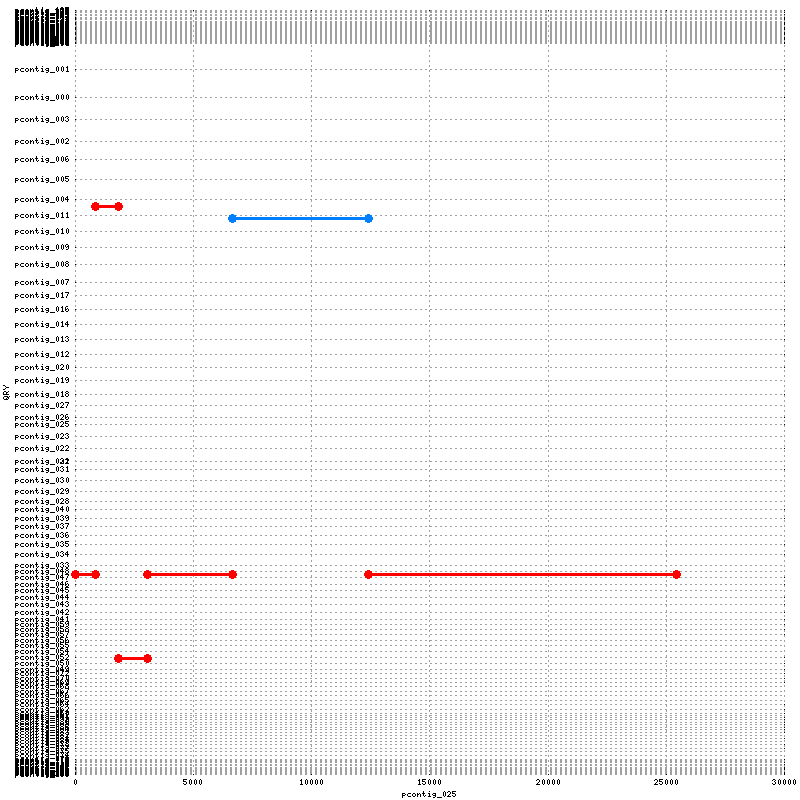

contig pcontig_026 of Pst_104_p with 1025863 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_026.png!

##########



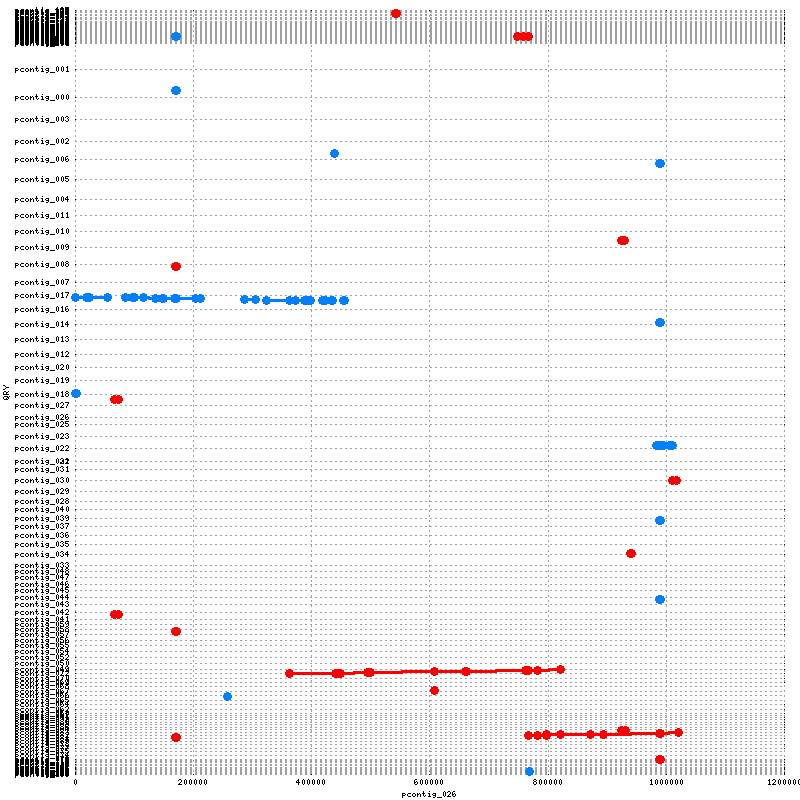

contig pcontig_027 of Pst_104_p with 985869 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_027.png!

##########



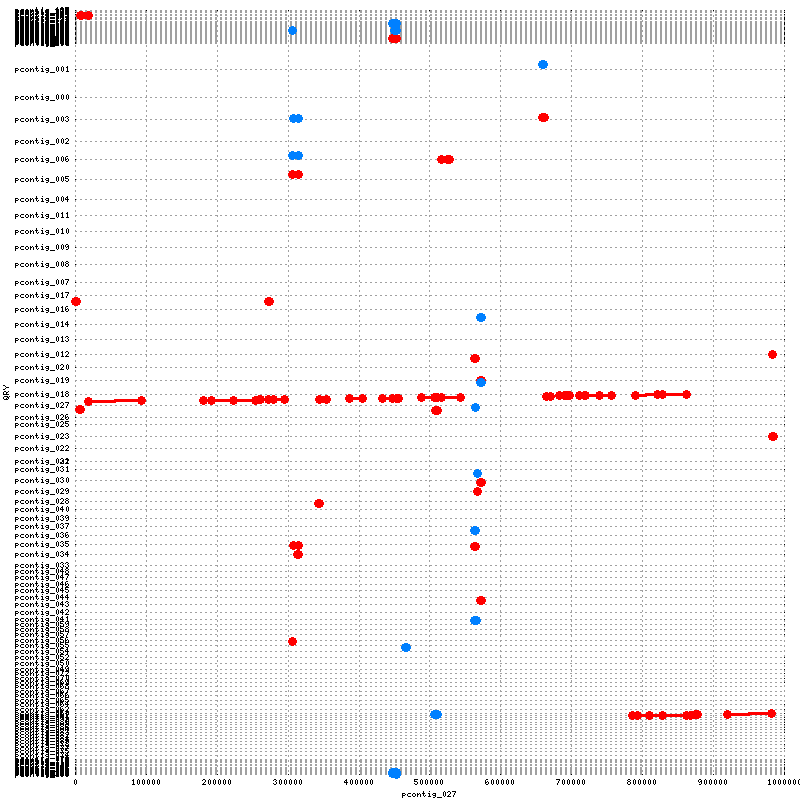

contig pcontig_028 of Pst_104_p with 970245 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_028.png!

##########



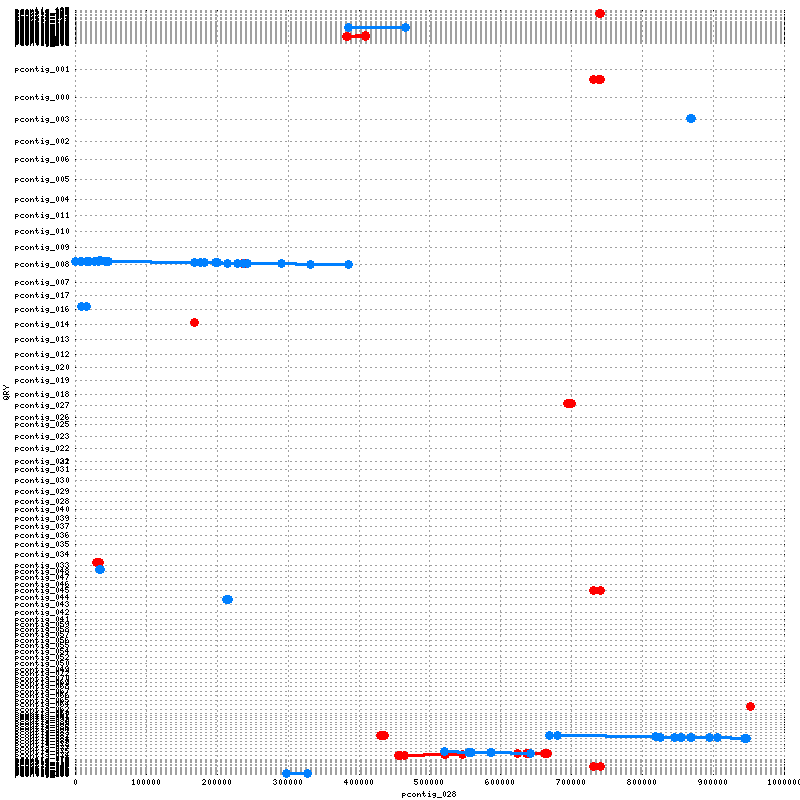

contig pcontig_029 of Pst_104_p with 971047 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_029.png!

##########



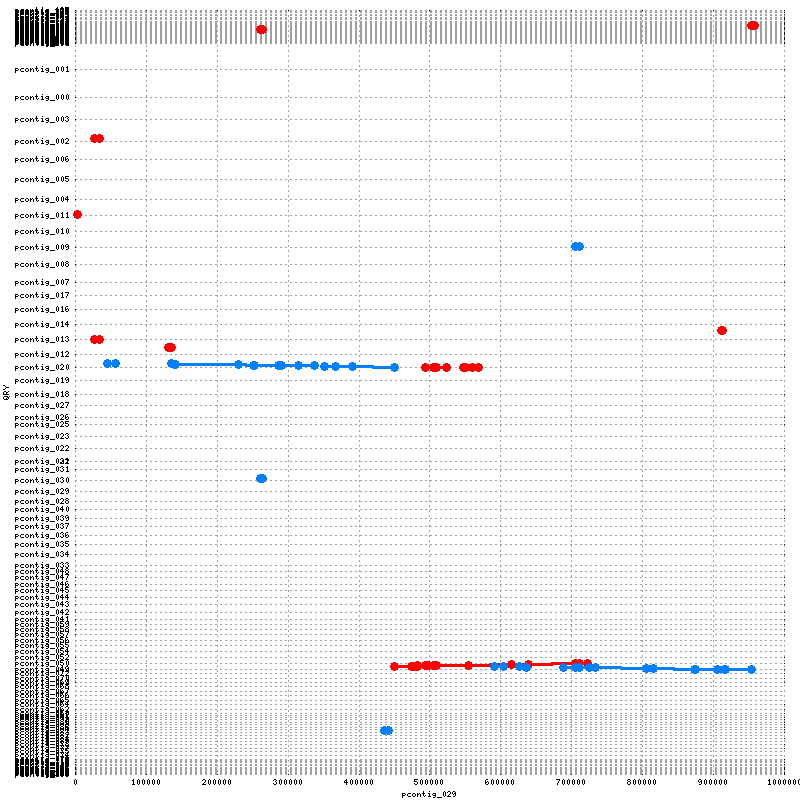

contig pcontig_030 of Pst_104_p with 968355 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_030.png!

##########



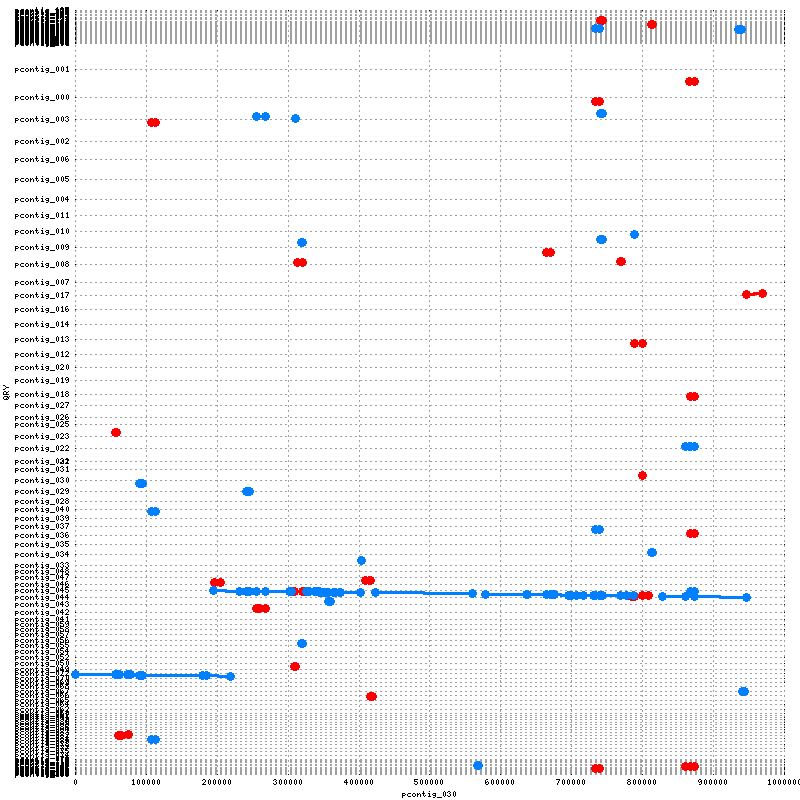

contig pcontig_031 of Pst_104_p with 910852 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_031.png!

##########



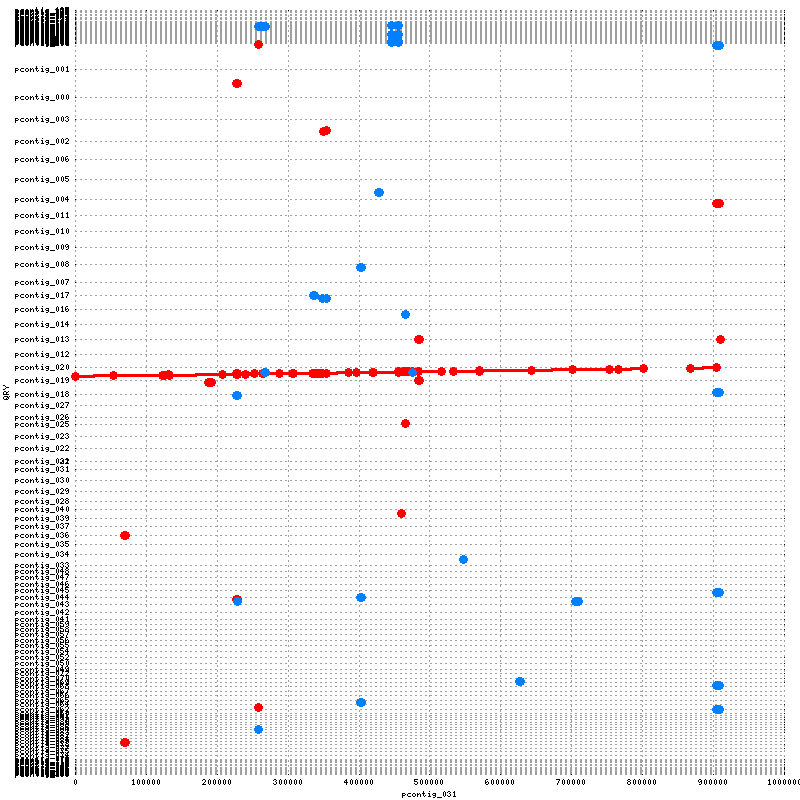

contig pcontig_032 of Pst_104_p with 900669 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_032.png!

##########



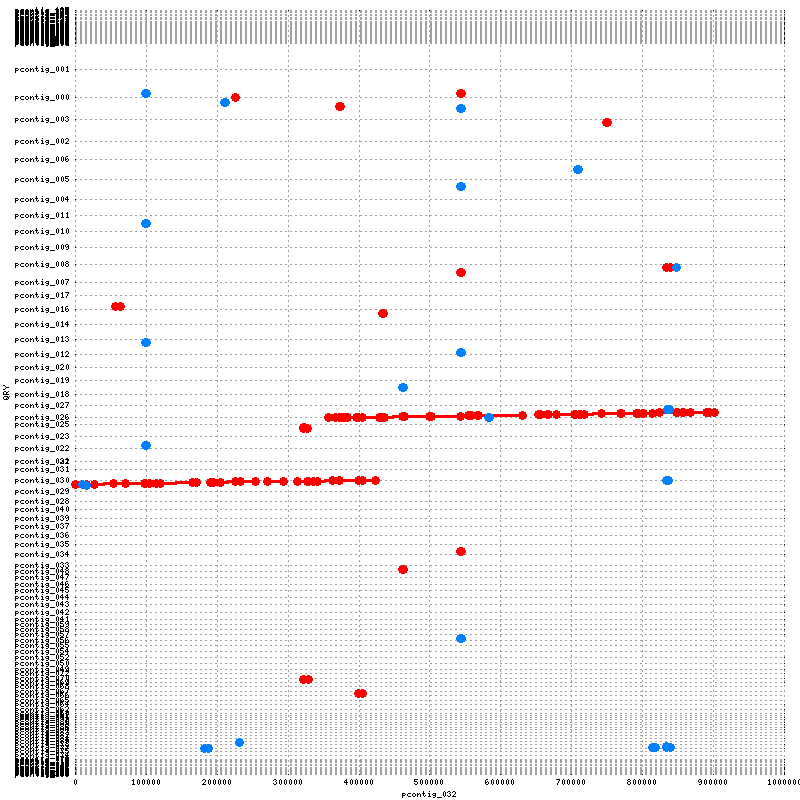

contig pcontig_033 of Pst_104_p with 905432 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_033.png!

##########



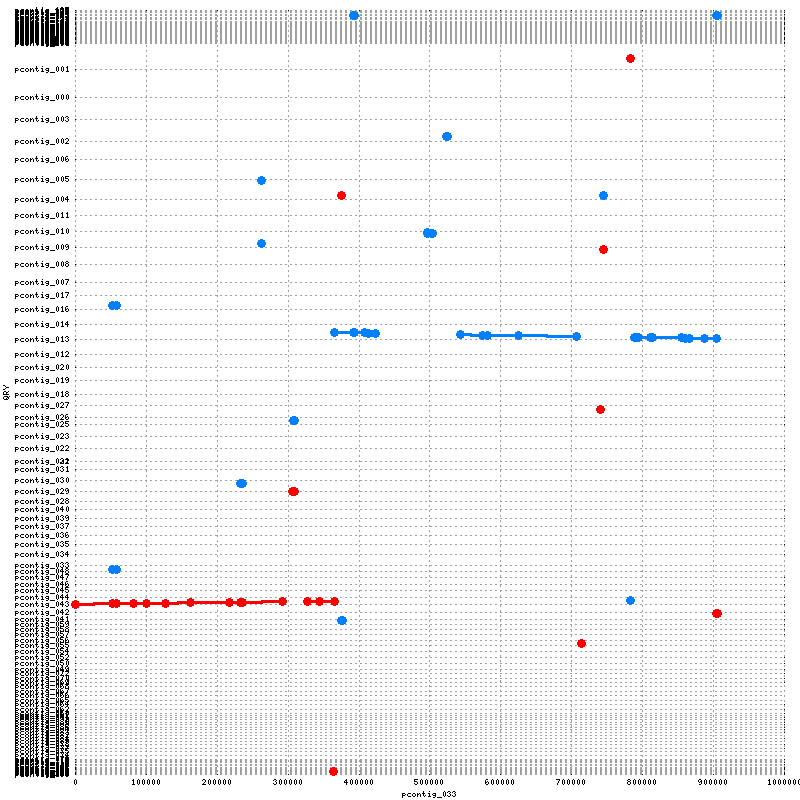

contig pcontig_034 of Pst_104_p with 883174 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_034.png!

##########



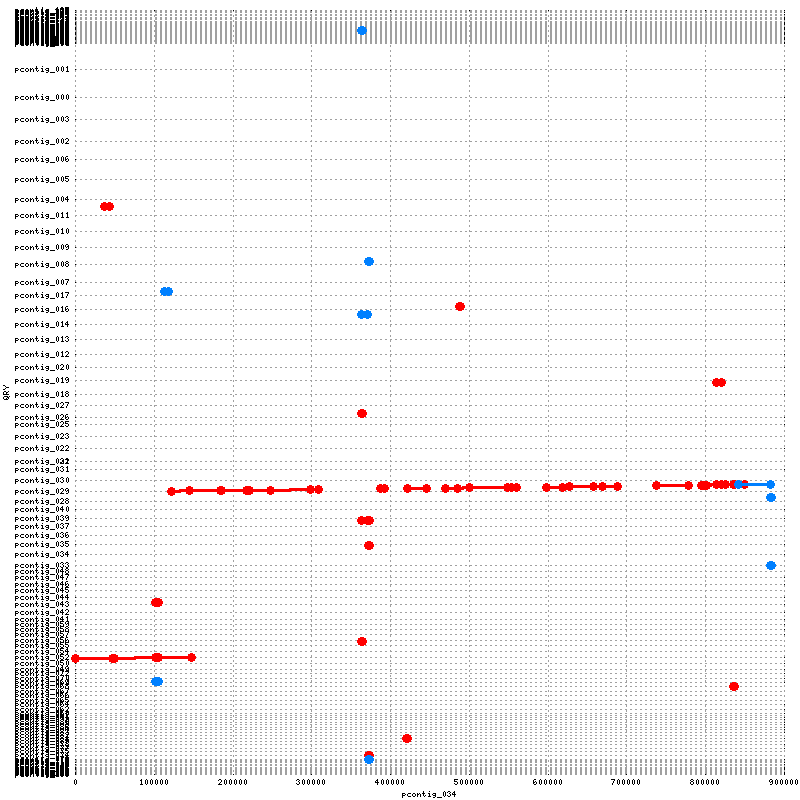

contig pcontig_035 of Pst_104_p with 873993 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_035.png!

##########



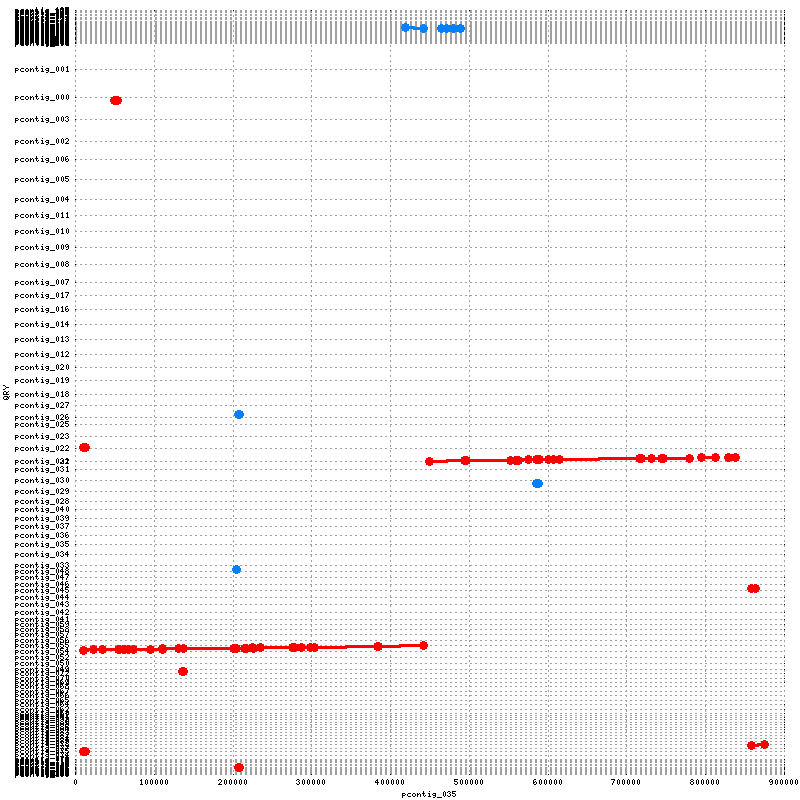

contig pcontig_036 of Pst_104_p with 811016 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_036.png!

##########



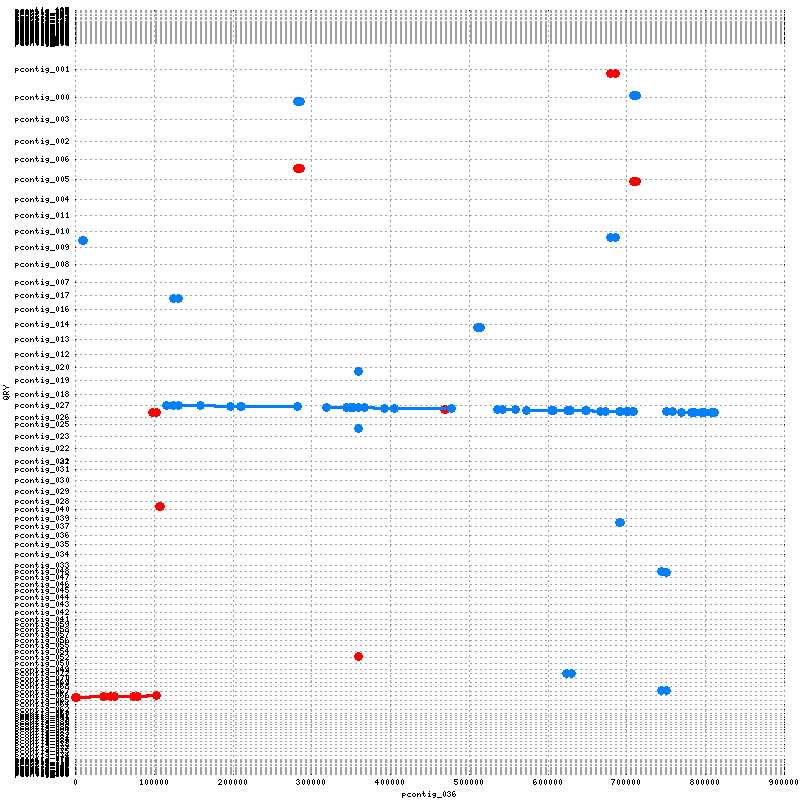

contig pcontig_037 of Pst_104_p with 736666 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_037.png!

##########



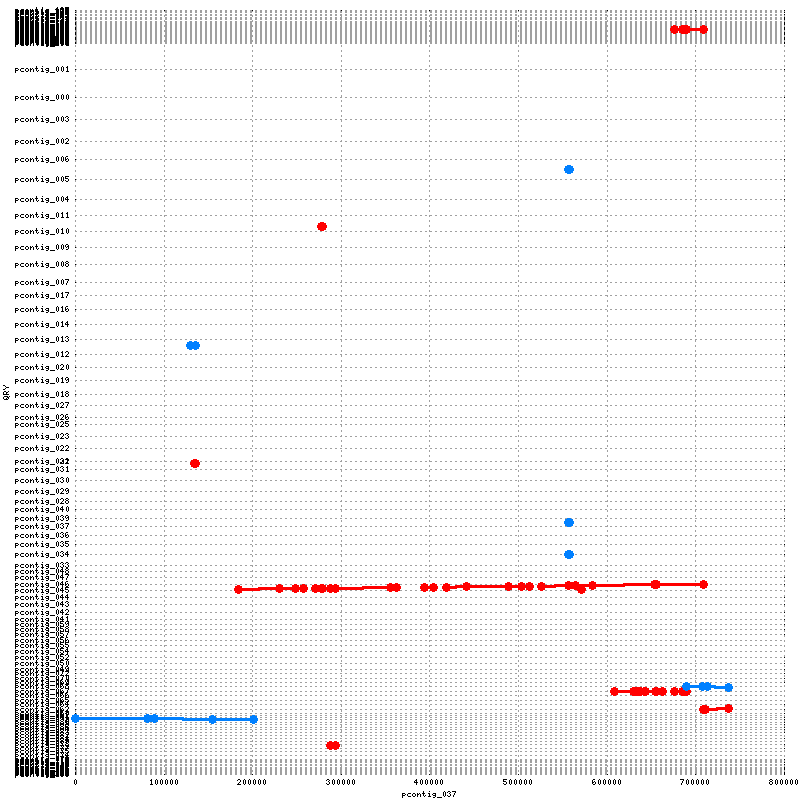

contig pcontig_038 of Pst_104_p with 722814 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_038.png!

##########



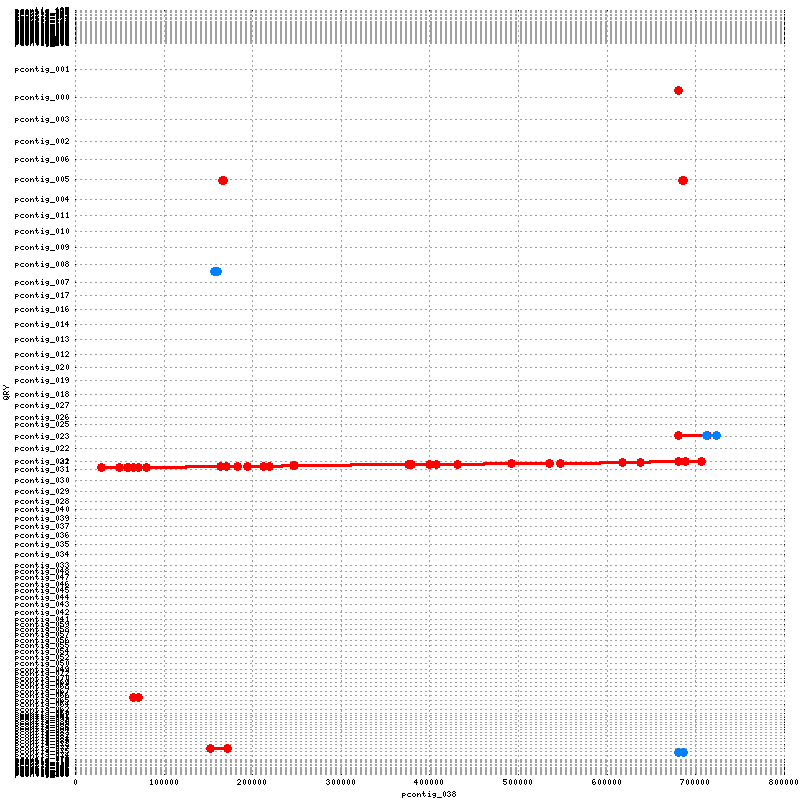

contig pcontig_039 of Pst_104_p with 738750 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_039.png!

##########



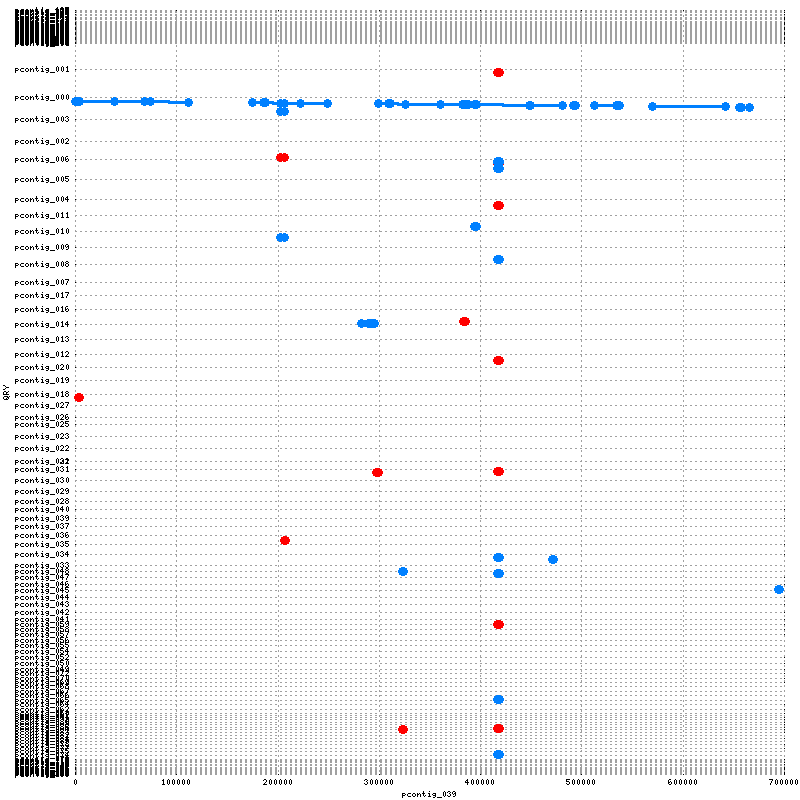

contig pcontig_040 of Pst_104_p with 737851 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_040.png!

##########



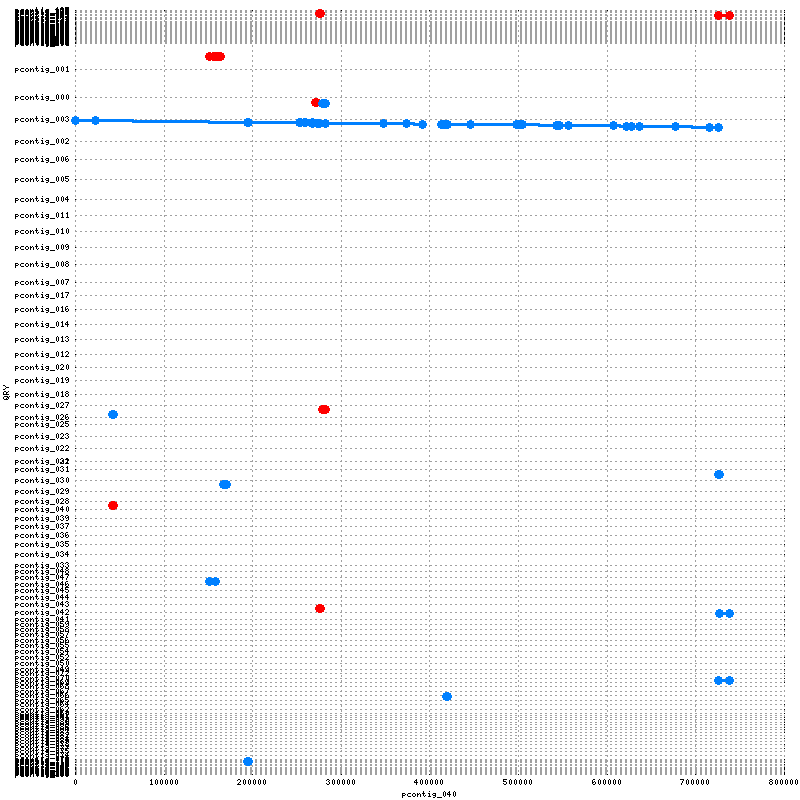

contig pcontig_041 of Pst_104_p with 716704 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_041.png!

##########



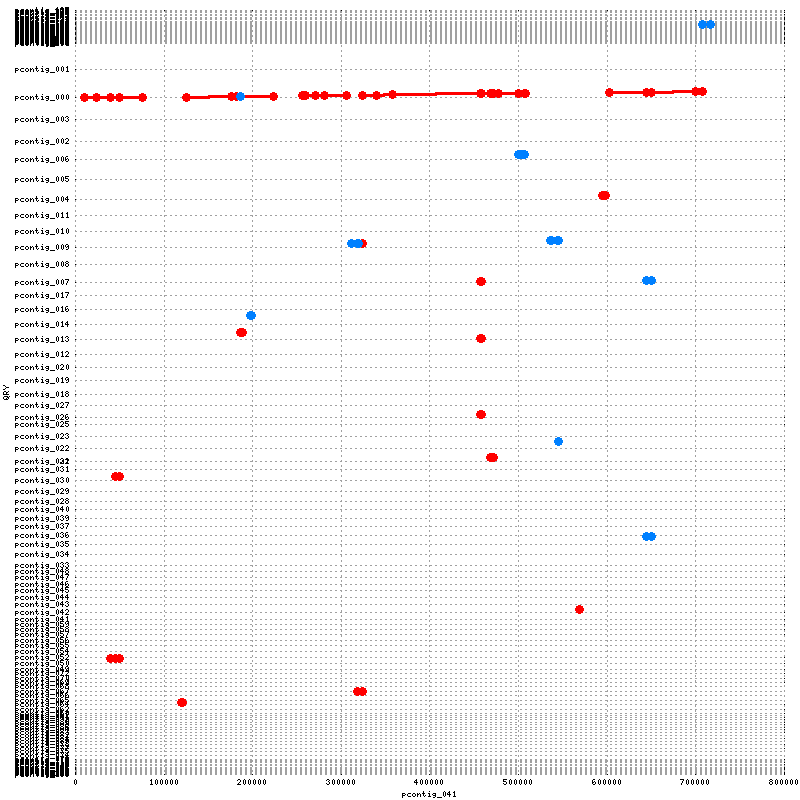

contig pcontig_042 of Pst_104_p with 628565 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_042.png!

##########



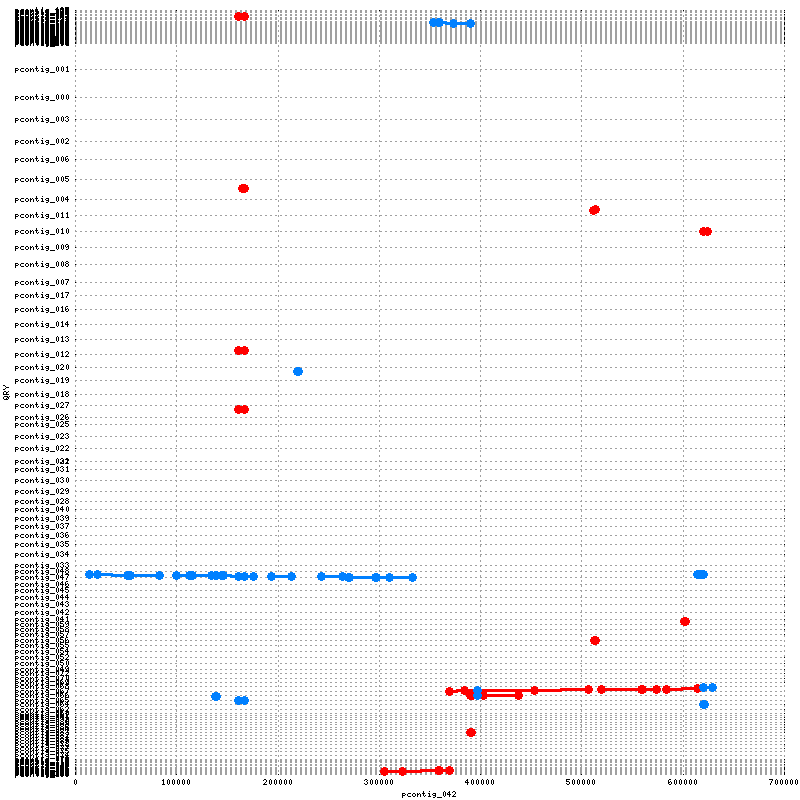

contig pcontig_043 of Pst_104_p with 55741 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_043.png!

##########



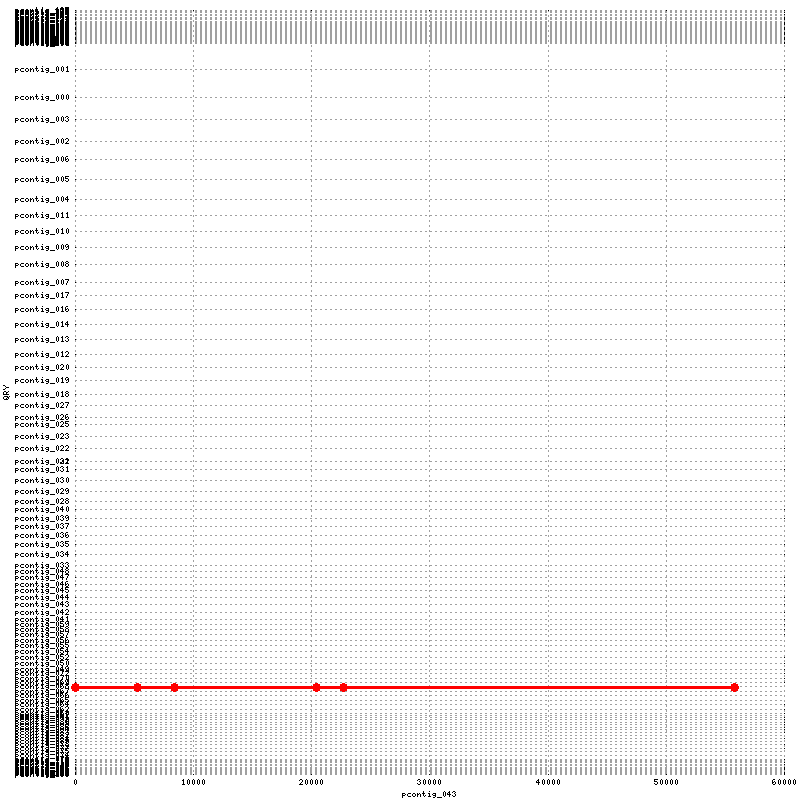

contig pcontig_045 of Pst_104_p with 589307 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_045.png!

##########



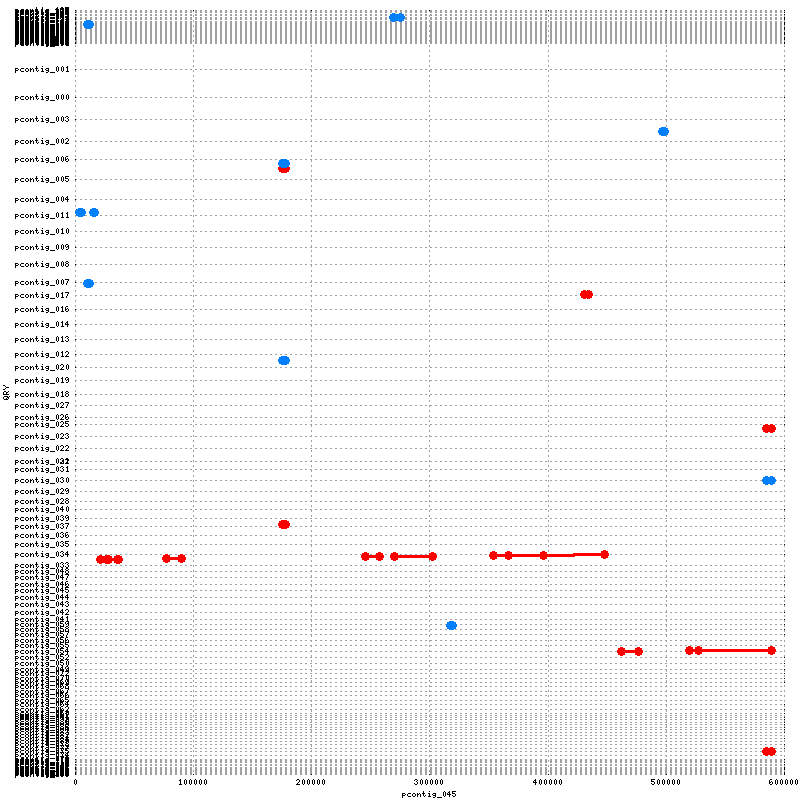

contig pcontig_046 of Pst_104_p with 605520 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_046.png!

##########



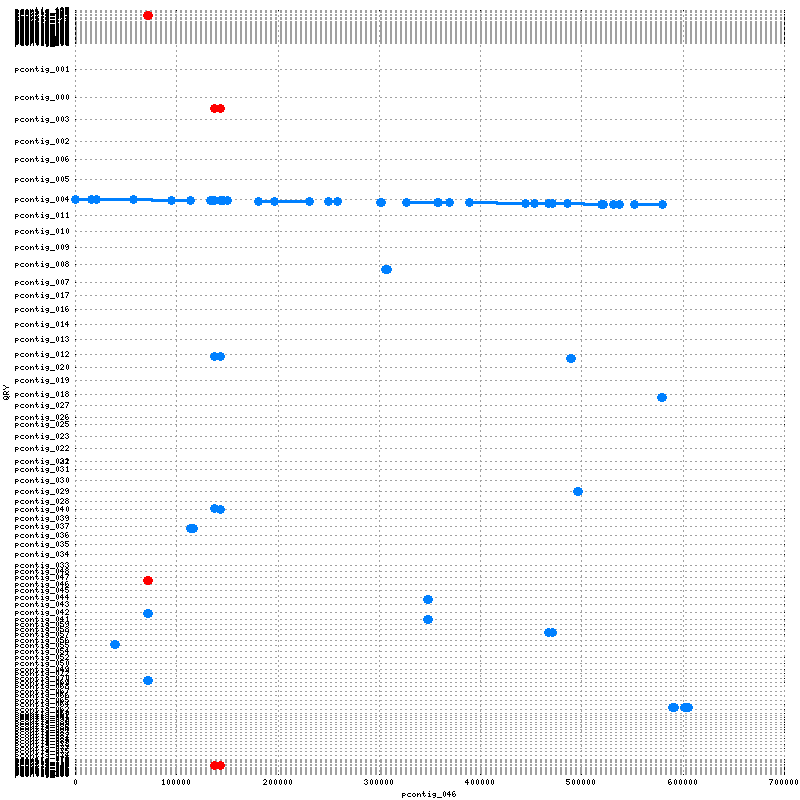

contig pcontig_047 of Pst_104_p with 587382 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_047.png!

##########



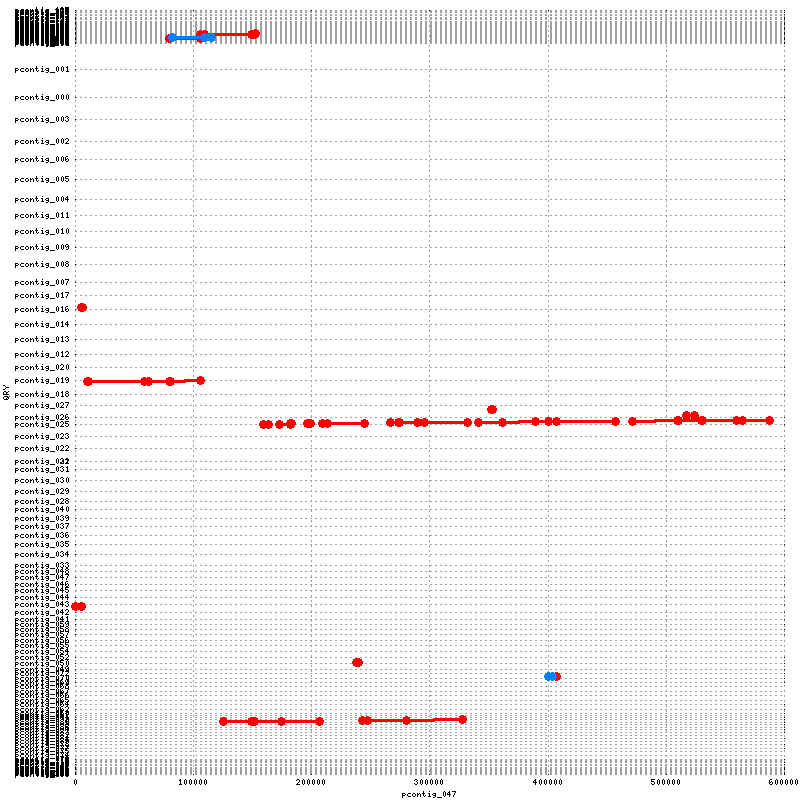

contig pcontig_048 of Pst_104_p with 555801 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_048.png!

##########



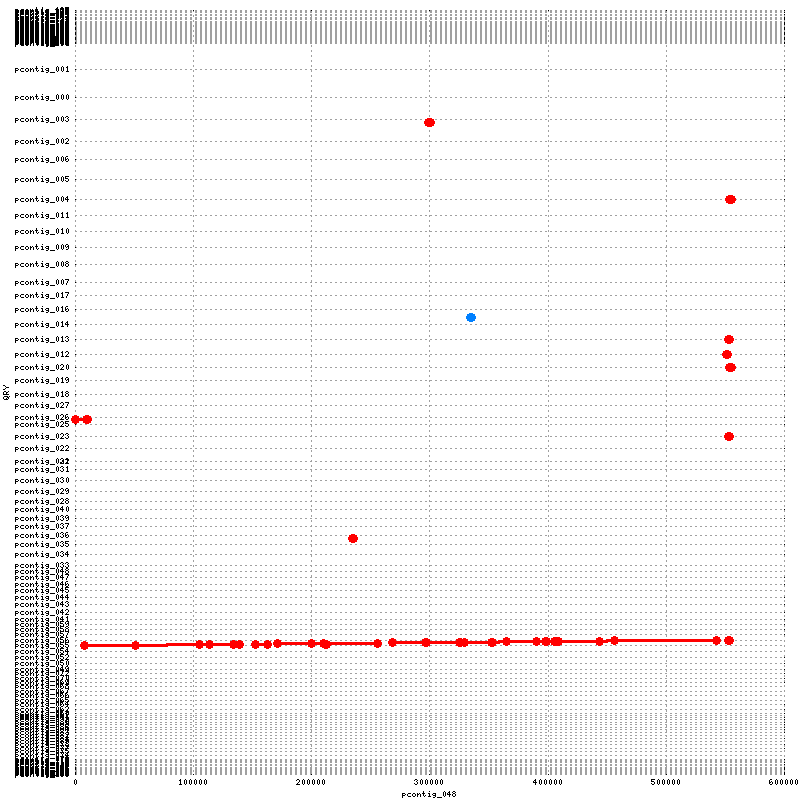

contig pcontig_049 of Pst_104_p with 549001 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_049.png!

##########



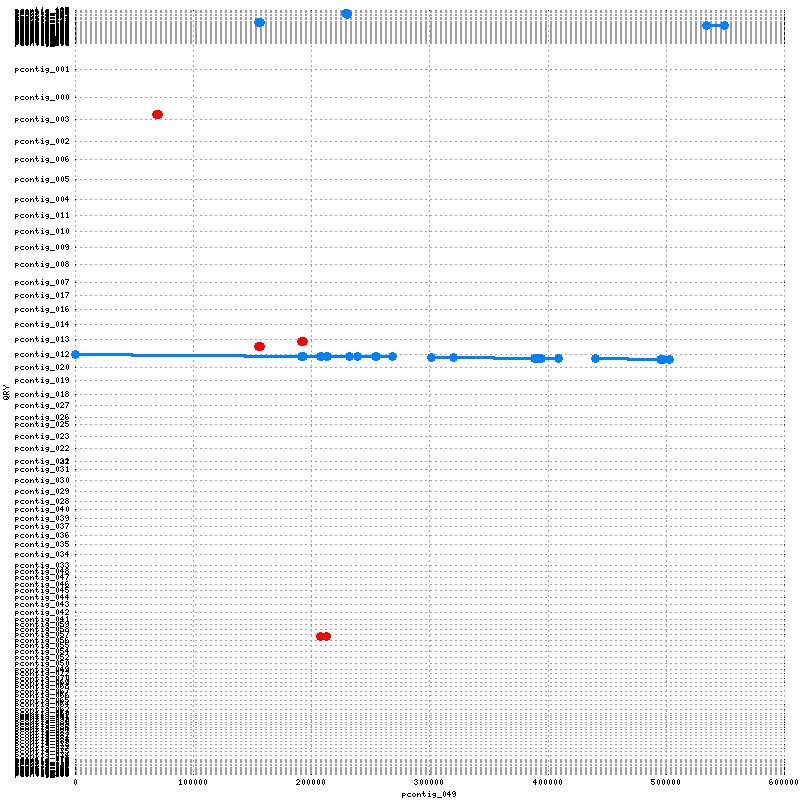

contig pcontig_050 of Pst_104_p with 555326 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_050.png!

##########



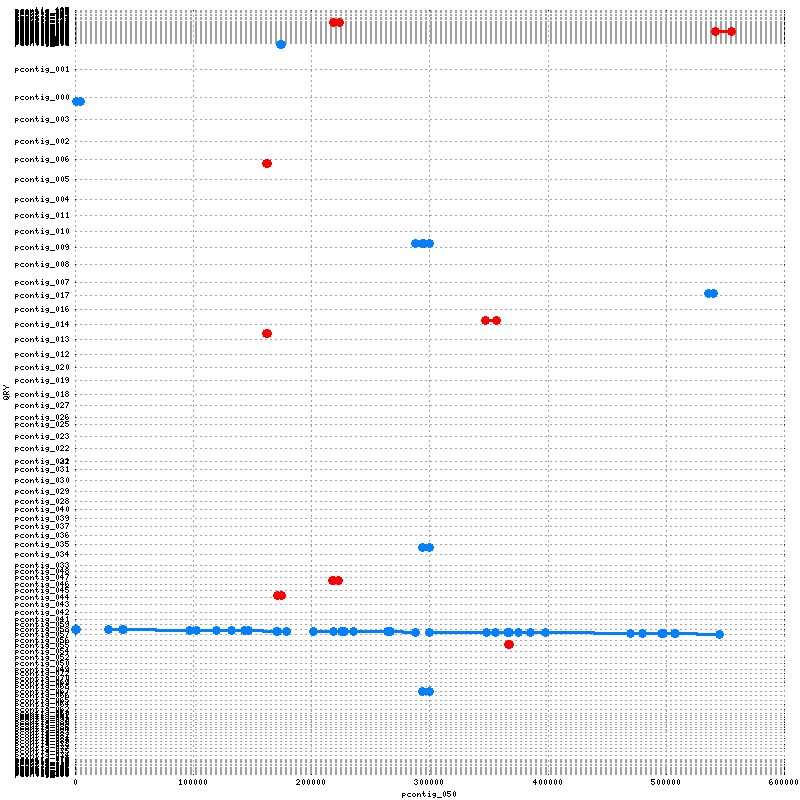

contig pcontig_051 of Pst_104_p with 523597 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_051.png!

##########



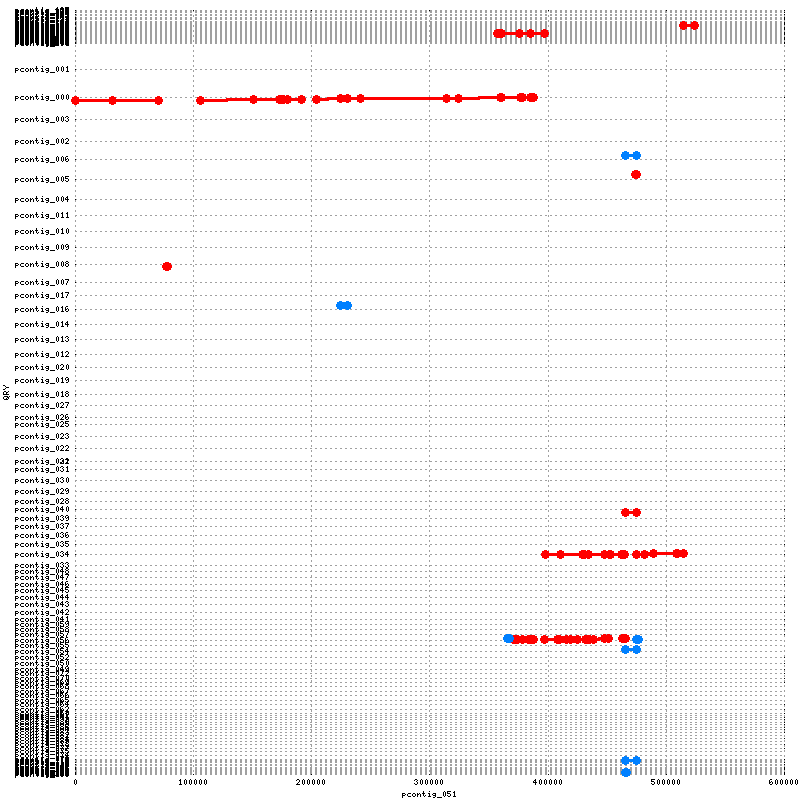

contig pcontig_052 of Pst_104_p with 493501 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_052.png!

##########



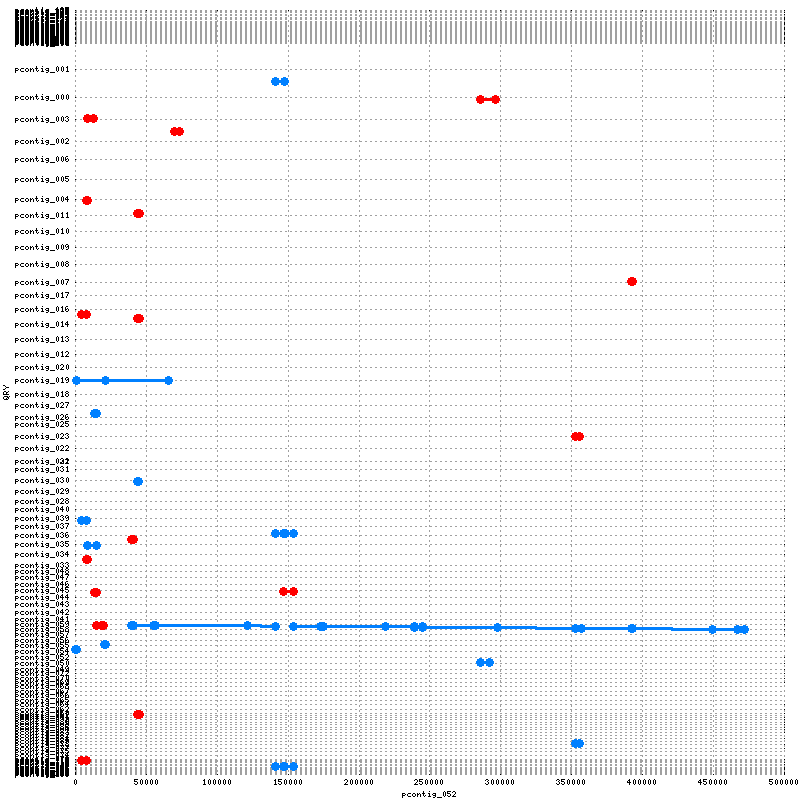

contig pcontig_053 of Pst_104_p with 490077 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_053.png!

##########



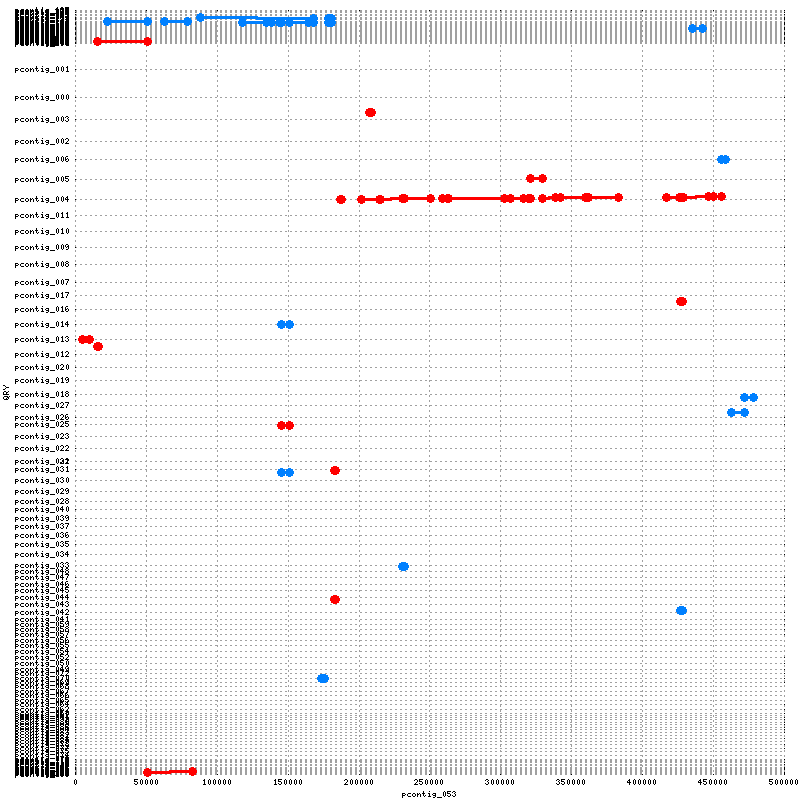

contig pcontig_054 of Pst_104_p with 468371 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_054.png!

##########



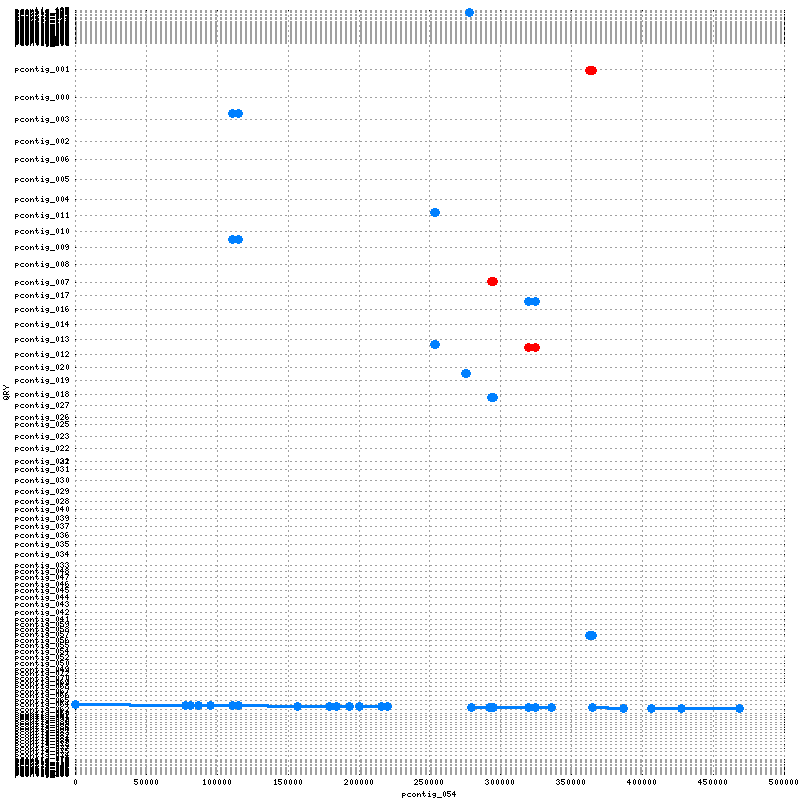

contig pcontig_055 of Pst_104_p with 424243 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_055.png!

##########



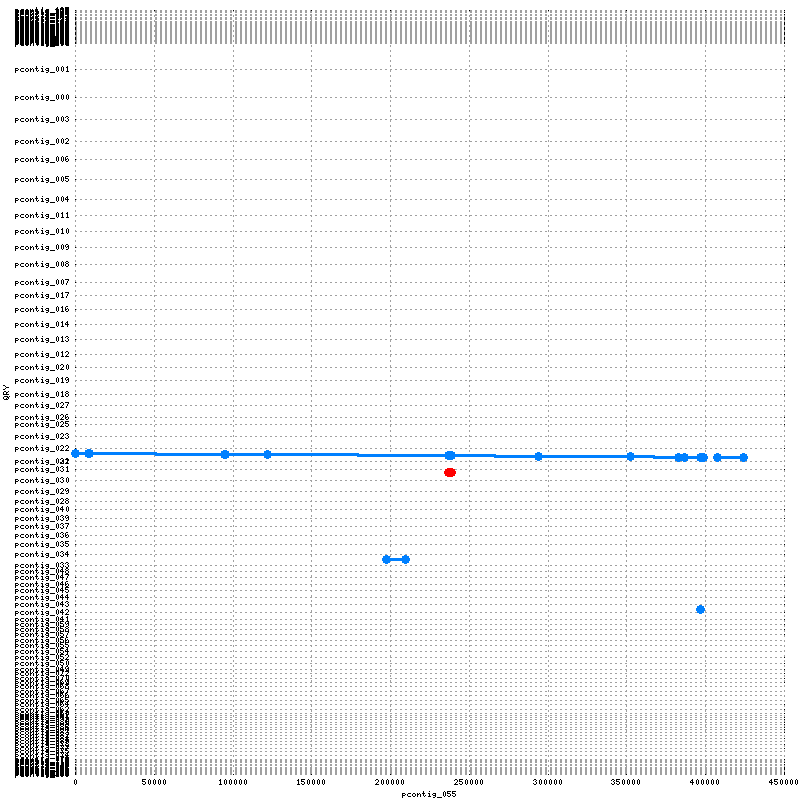

contig pcontig_057 of Pst_104_p with 425050 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_057.png!

##########



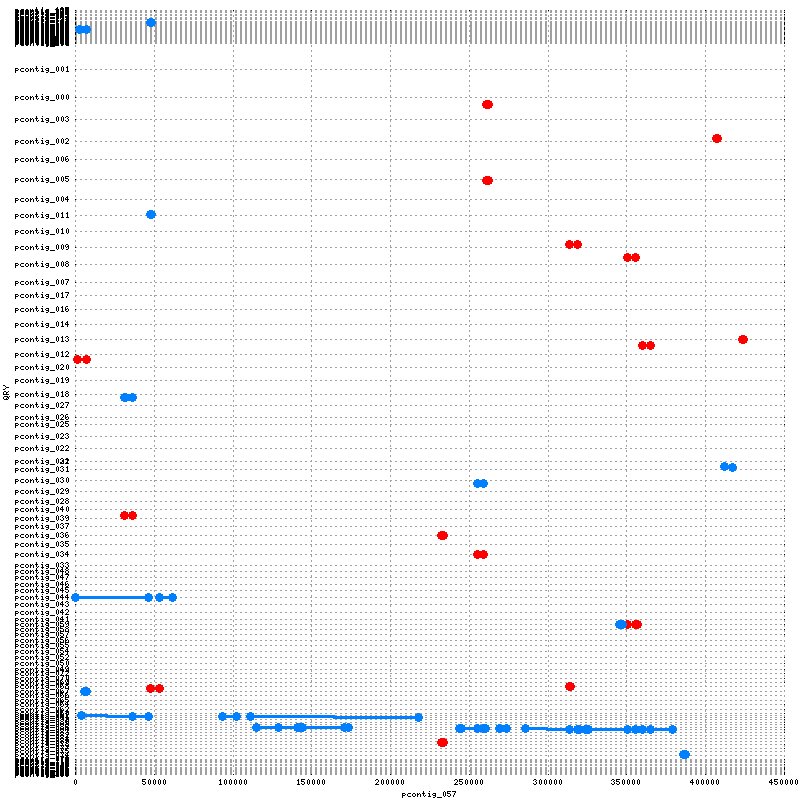

contig pcontig_058 of Pst_104_p with 450768 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_058.png!

##########



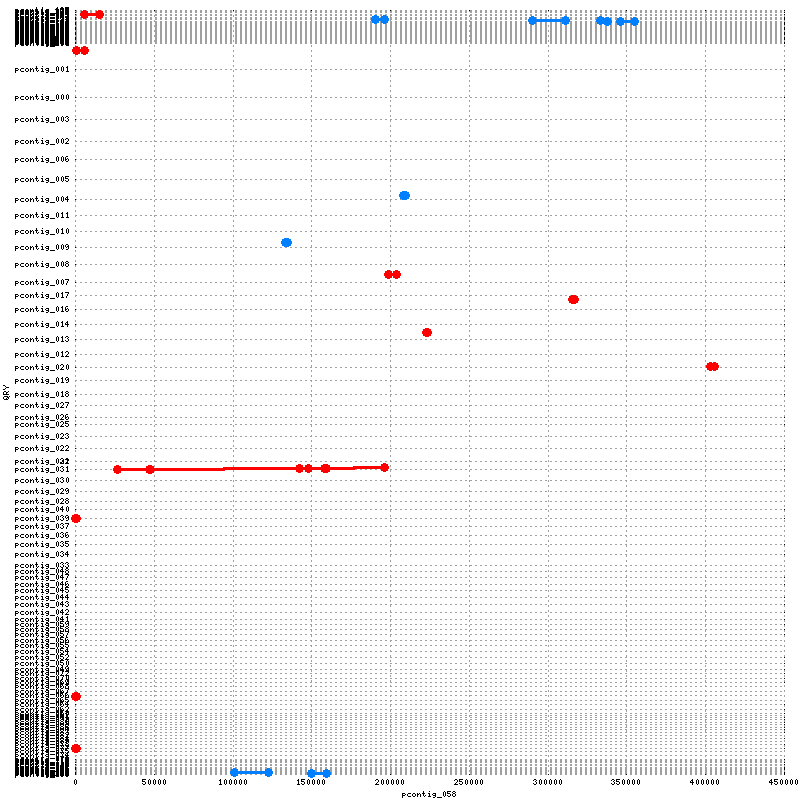

contig pcontig_060 of Pst_104_p with 389241 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_060.png!

##########



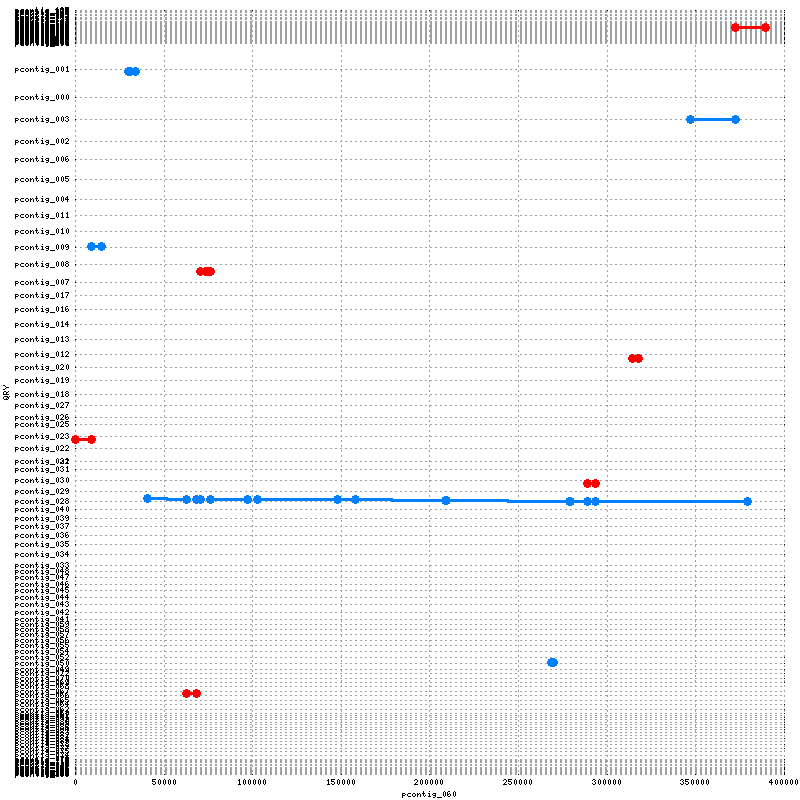

contig pcontig_061 of Pst_104_p with 116323 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_061.png!

##########



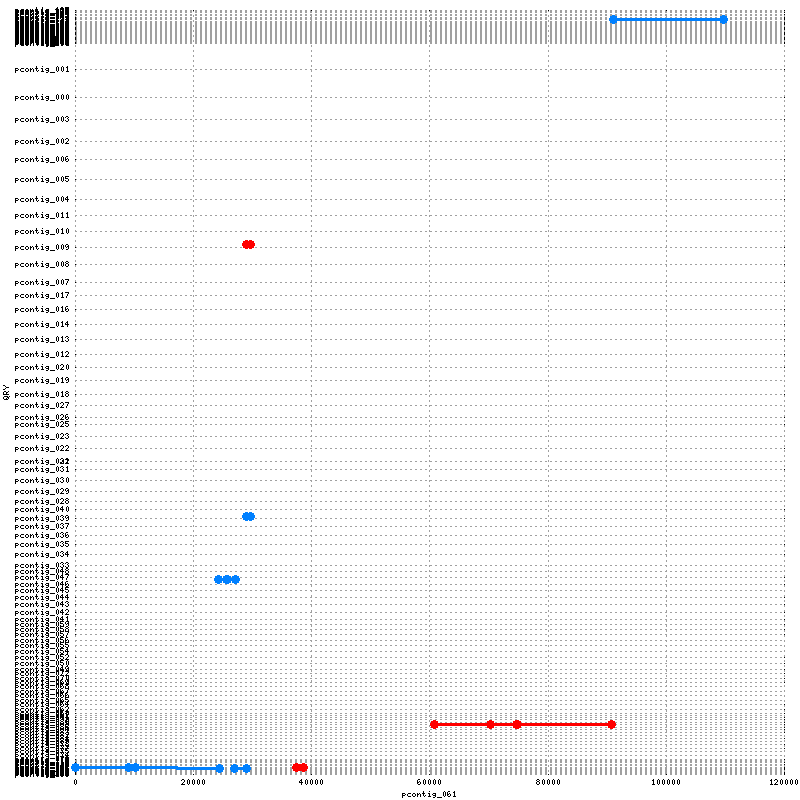

contig pcontig_063 of Pst_104_p with 319939 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_063.png!

##########



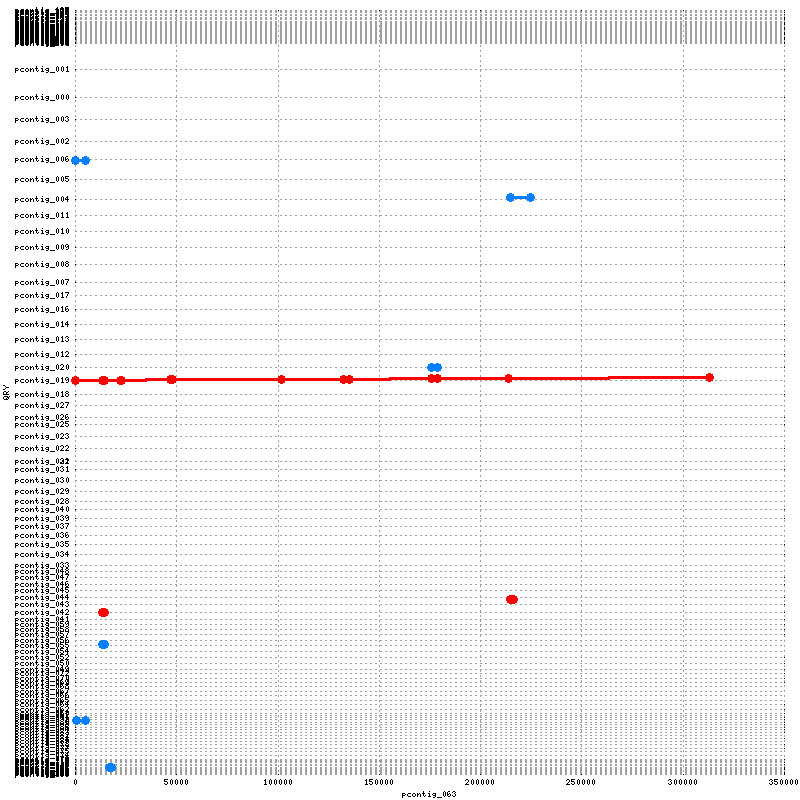

contig pcontig_064 of Pst_104_p with 300293 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_064.png!

##########



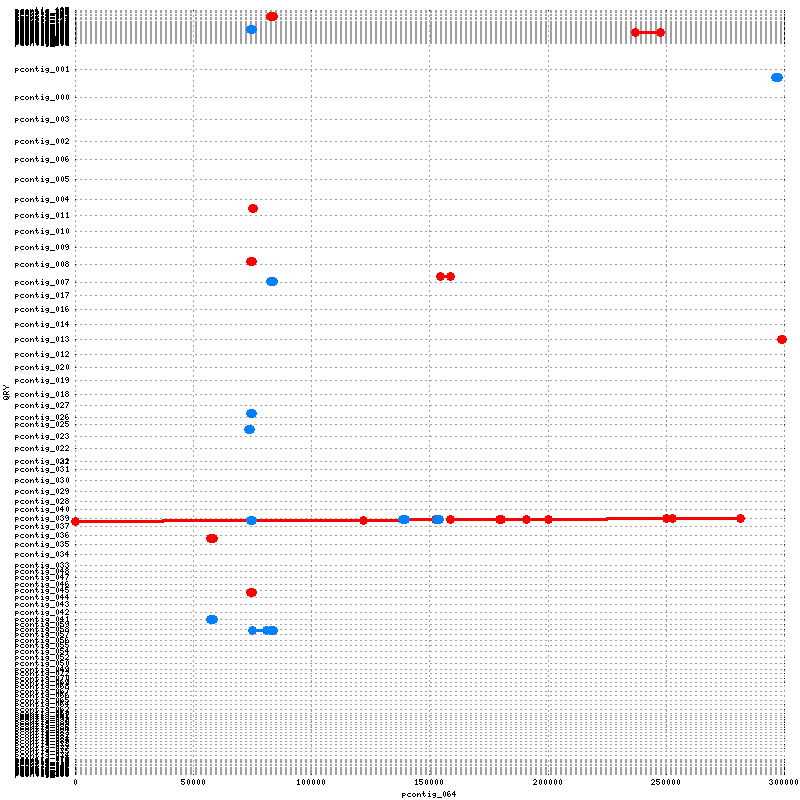

contig pcontig_065 of Pst_104_p with 270616 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_065.png!

##########



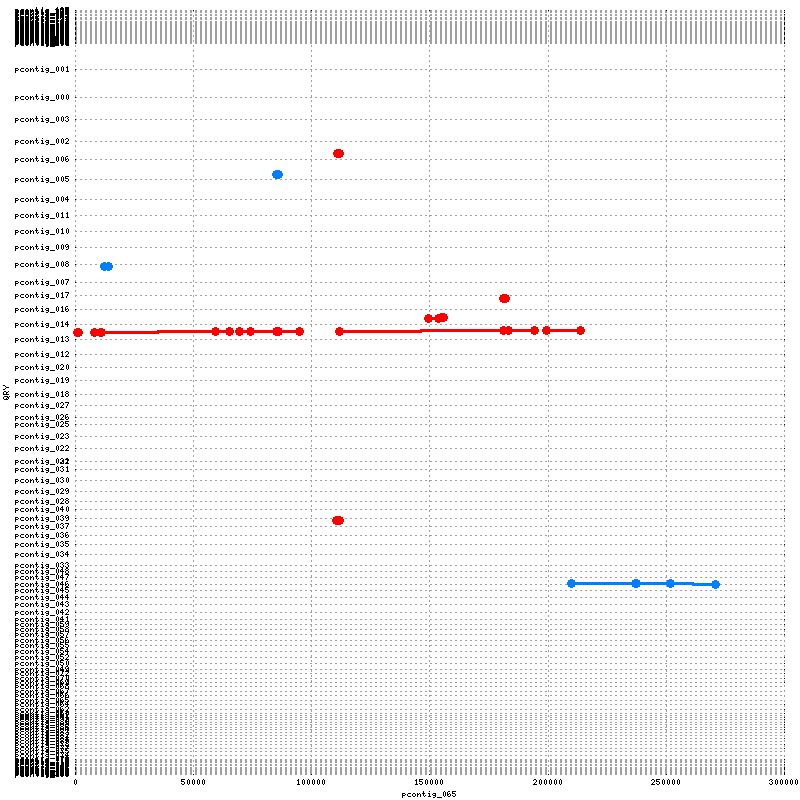

contig pcontig_066 of Pst_104_p with 255361 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_066.png!

##########



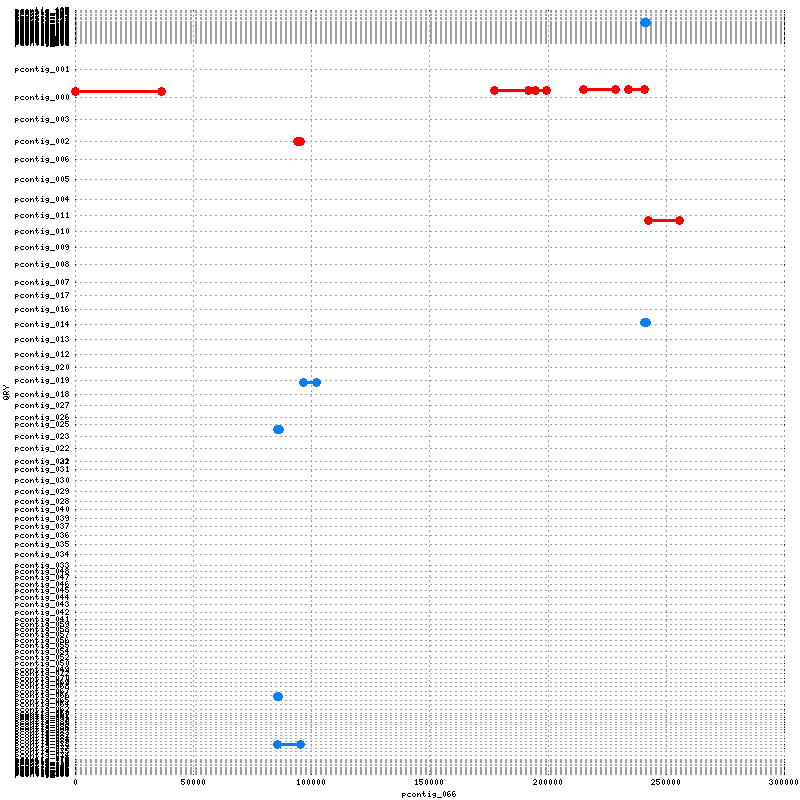

contig pcontig_067 of Pst_104_p with 254065 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_067.png!

##########



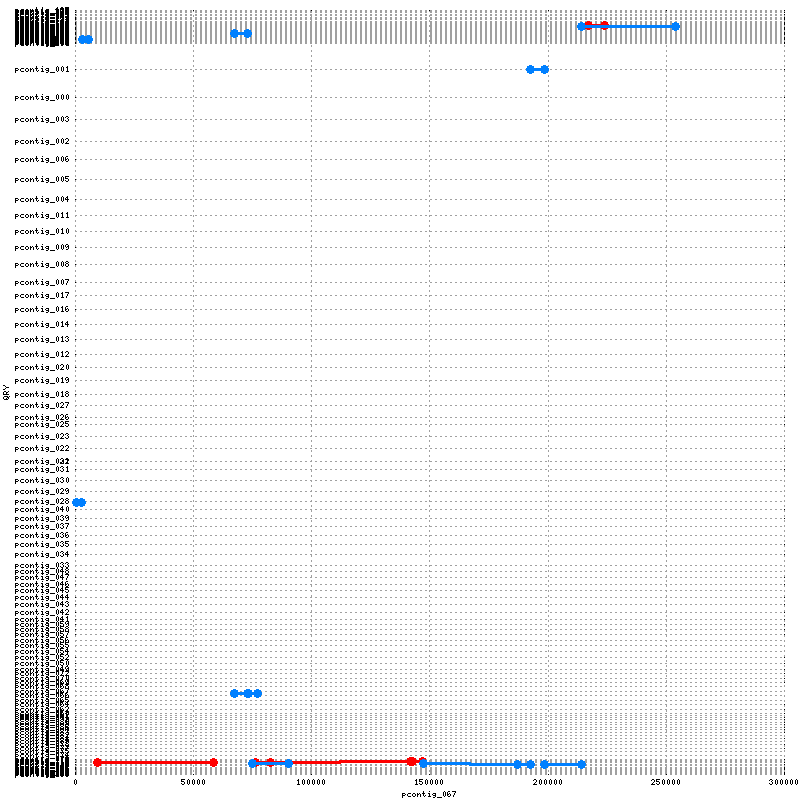

contig pcontig_068 of Pst_104_p with 251262 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_068.png!

##########



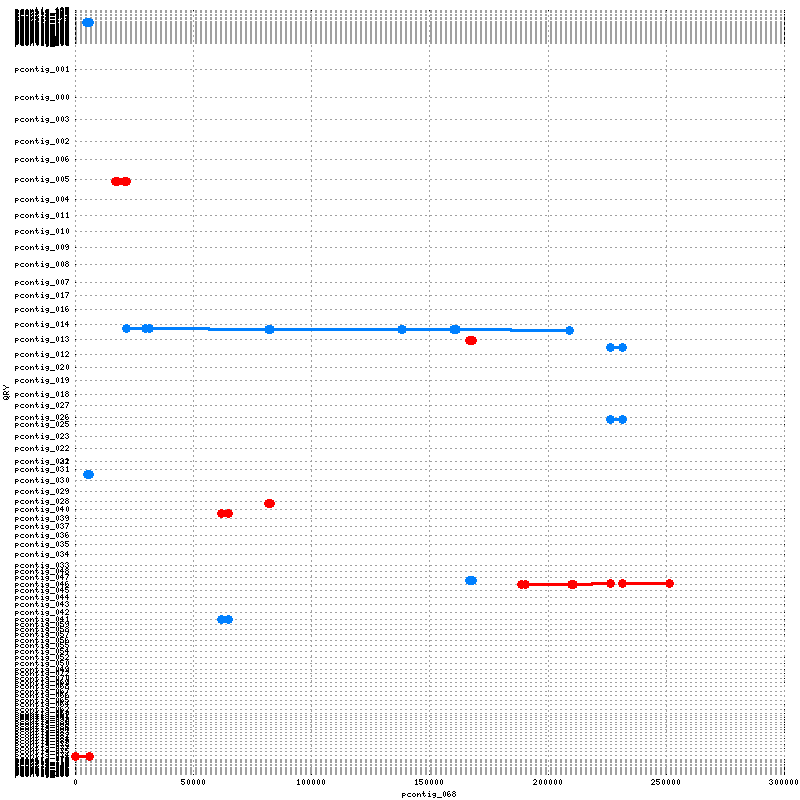

contig pcontig_069 of Pst_104_p with 230959 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_069.png!

##########



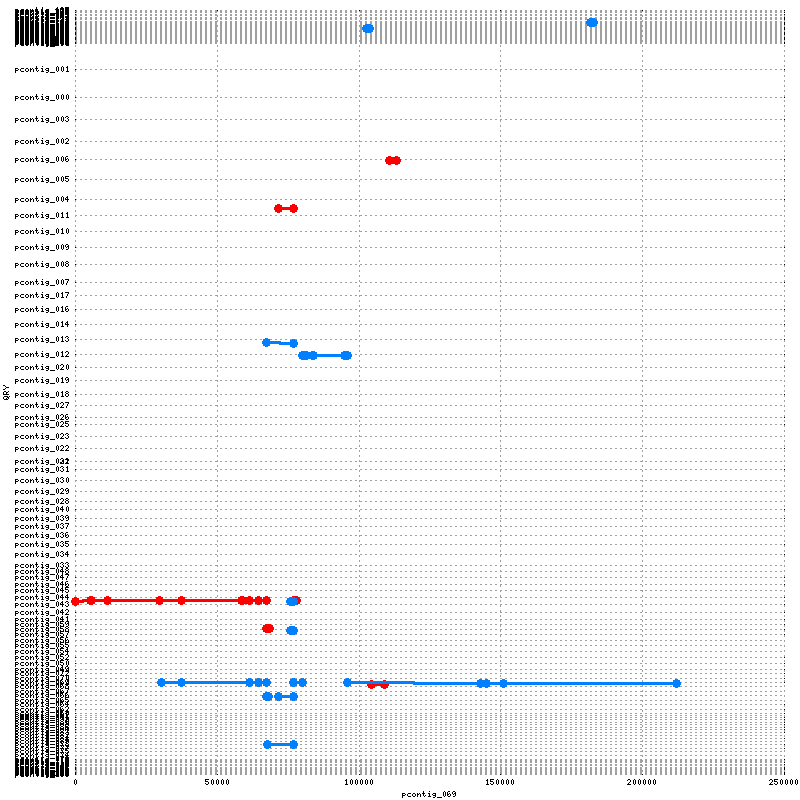

contig pcontig_070 of Pst_104_p with 242724 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_070.png!

##########



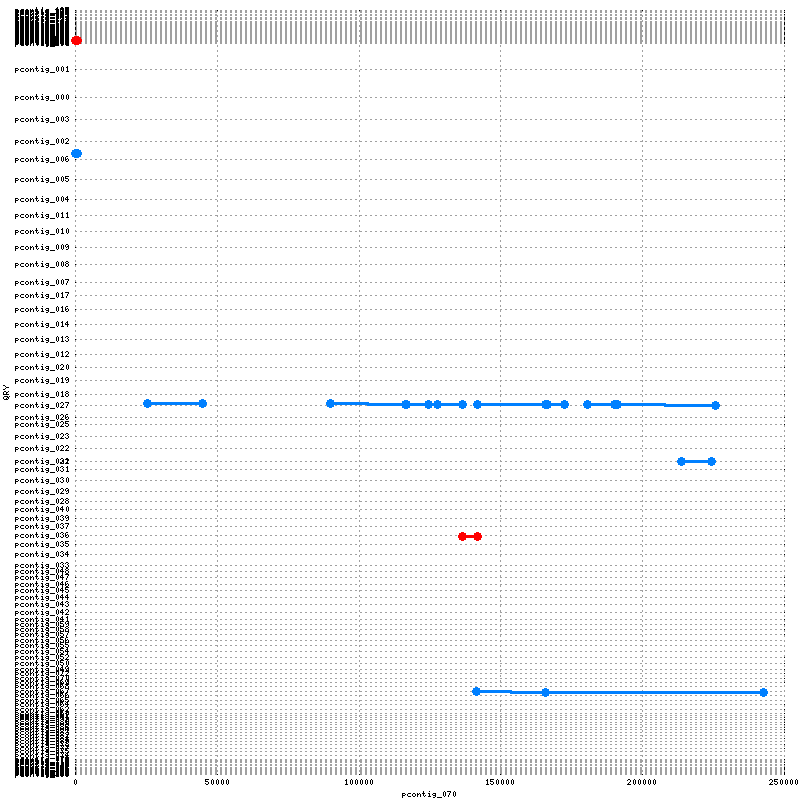

contig pcontig_072 of Pst_104_p with 188759 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_072.png!

##########



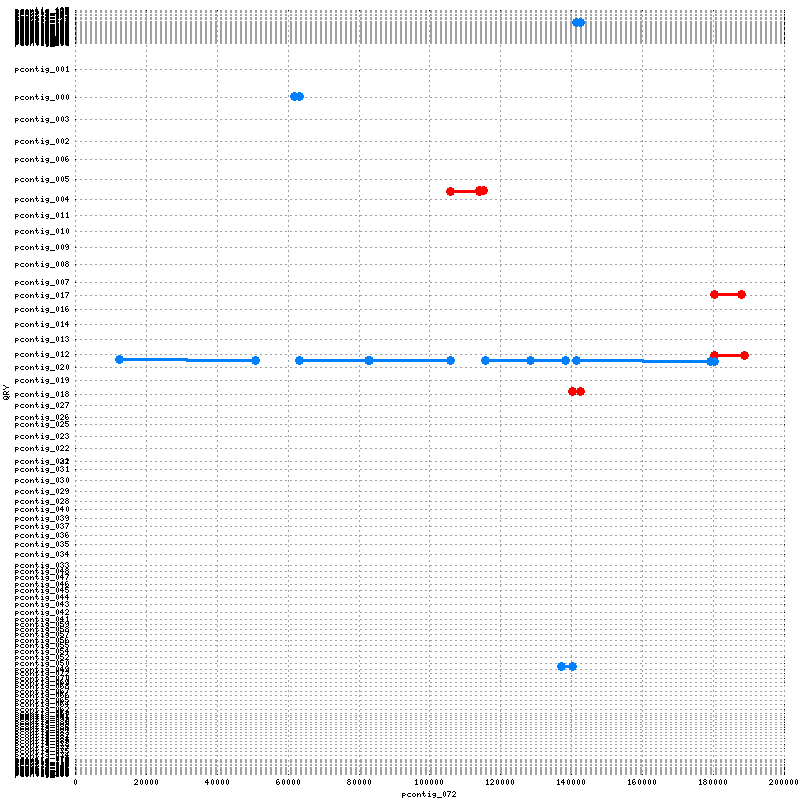

contig pcontig_073 of Pst_104_p with 181555 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_073.png!

##########



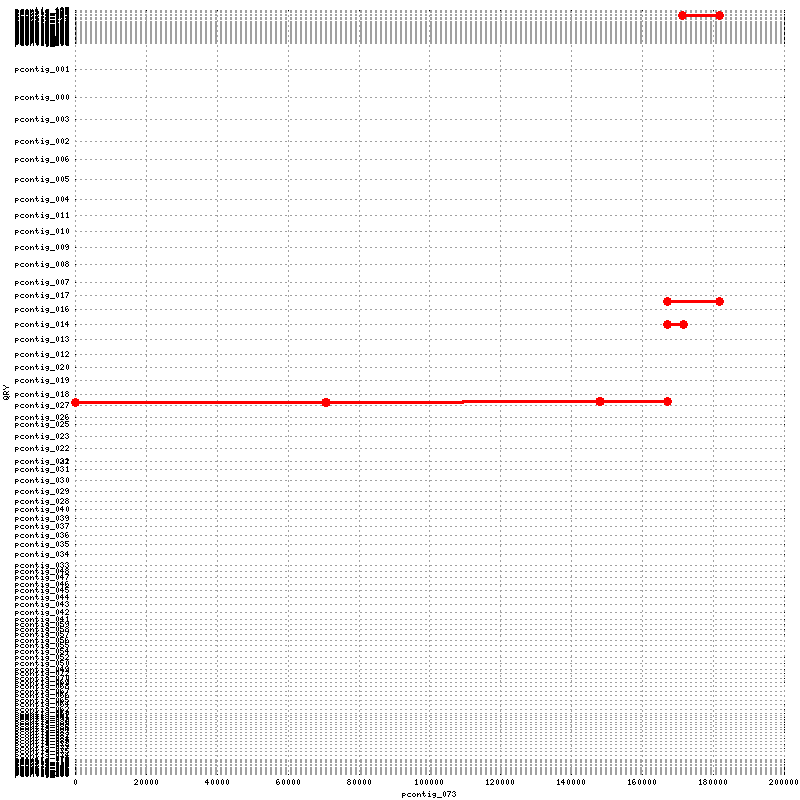

contig pcontig_074 of Pst_104_p with 173893 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_074.png!

##########



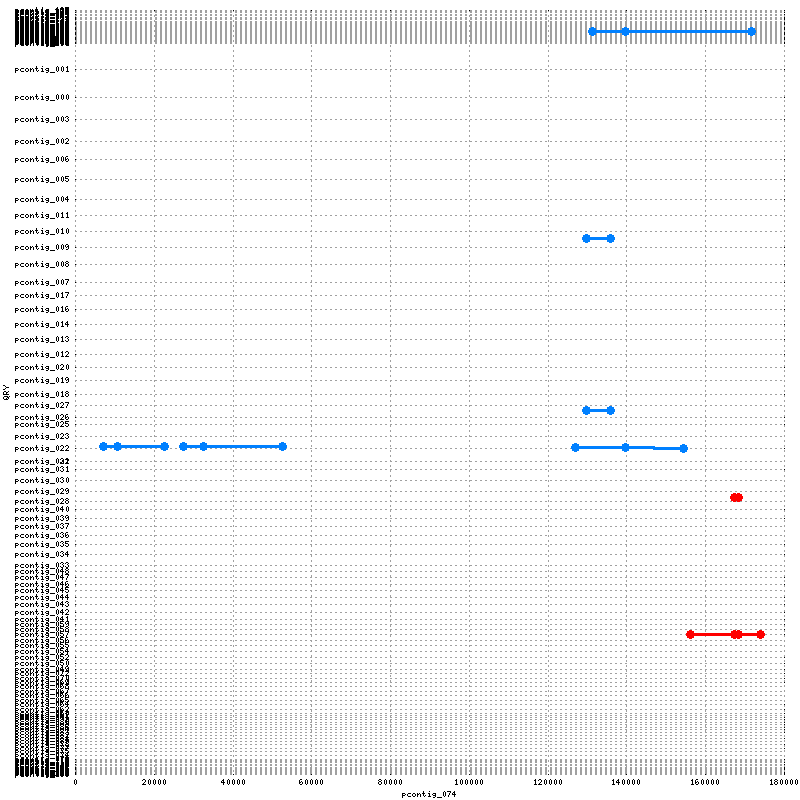

contig pcontig_075 of Pst_104_p with 169609 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_075.png!

##########



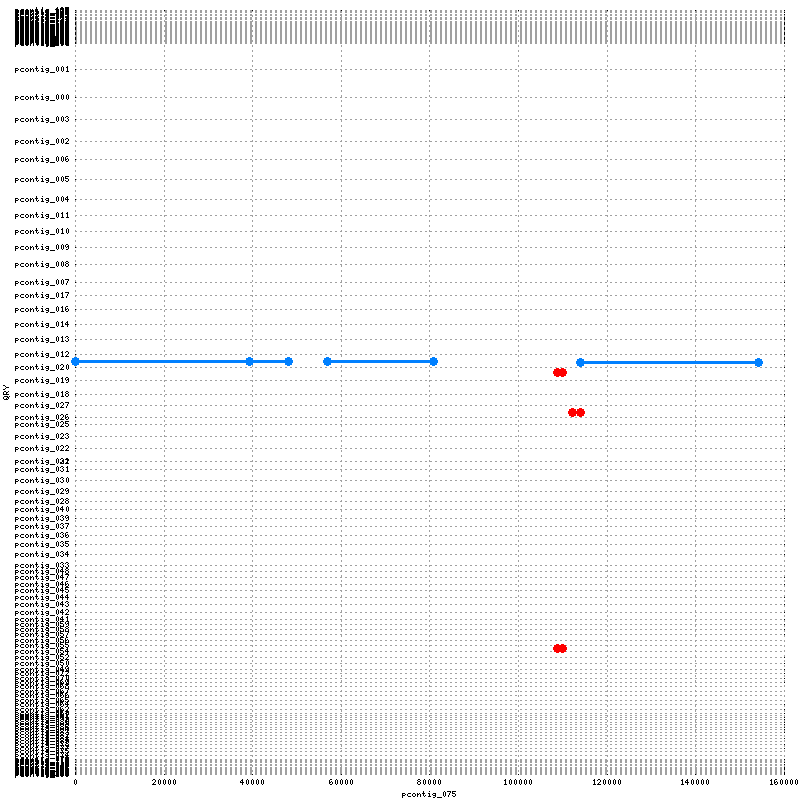

contig pcontig_076 of Pst_104_p with 152492 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_076.png!

##########



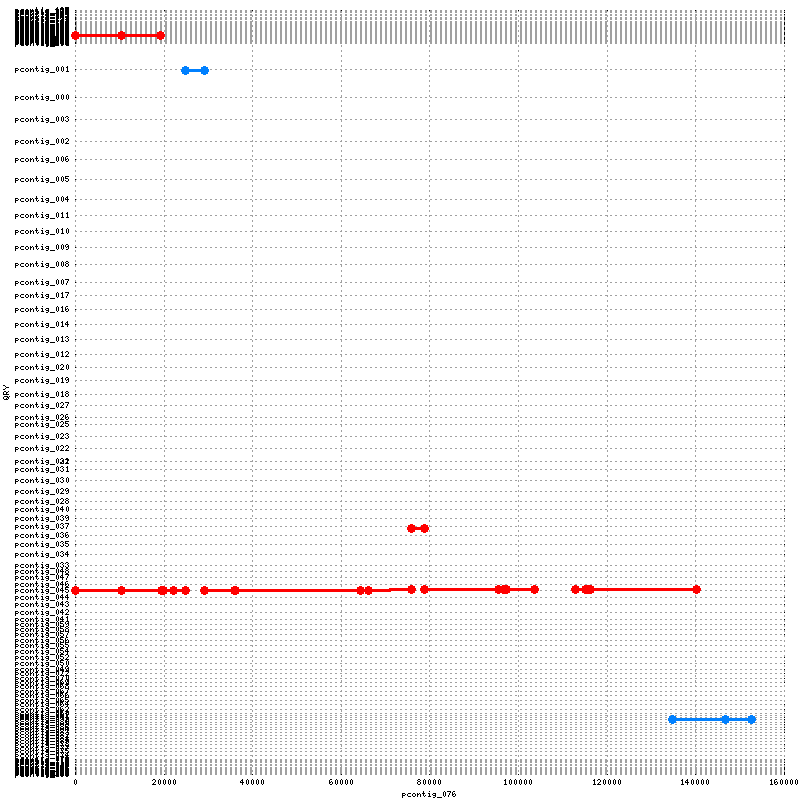

contig pcontig_077 of Pst_104_p with 138502 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_077.png!

##########



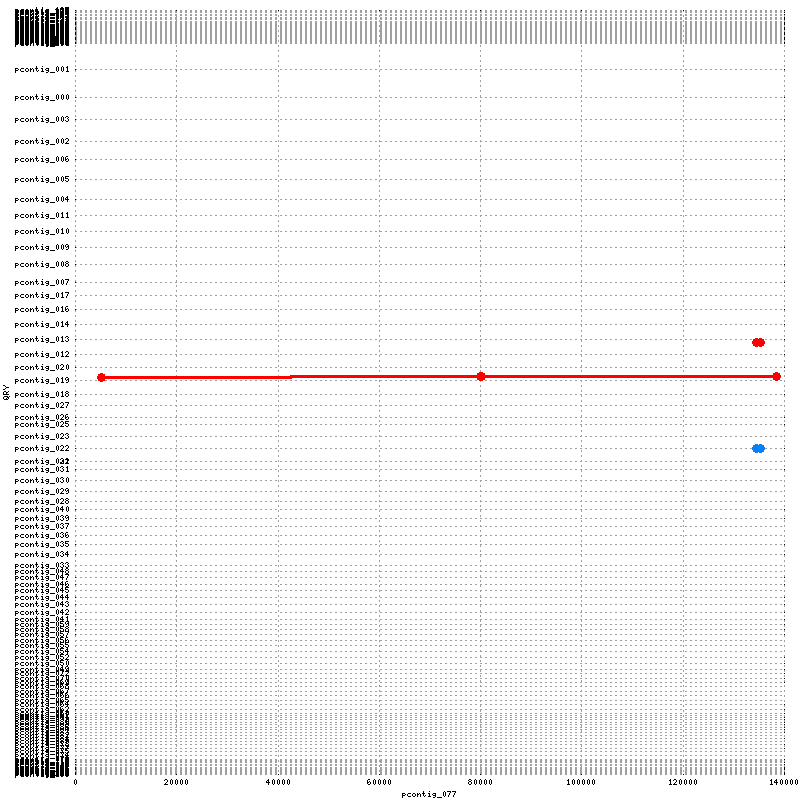

contig pcontig_078 of Pst_104_p with 137558 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_078.png!

##########



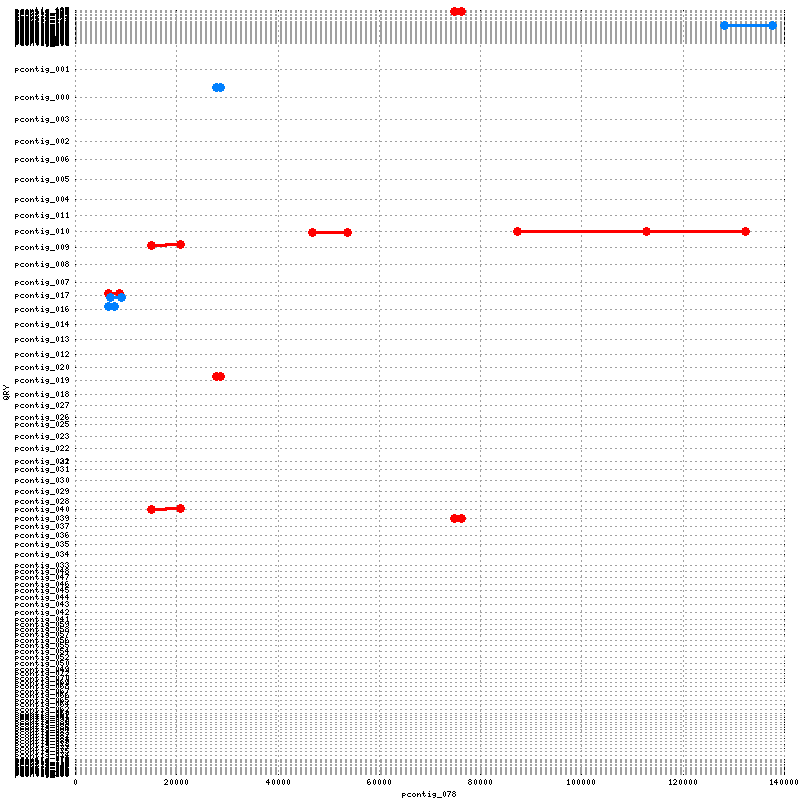

contig pcontig_079 of Pst_104_p with 117314 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_079.png!

##########



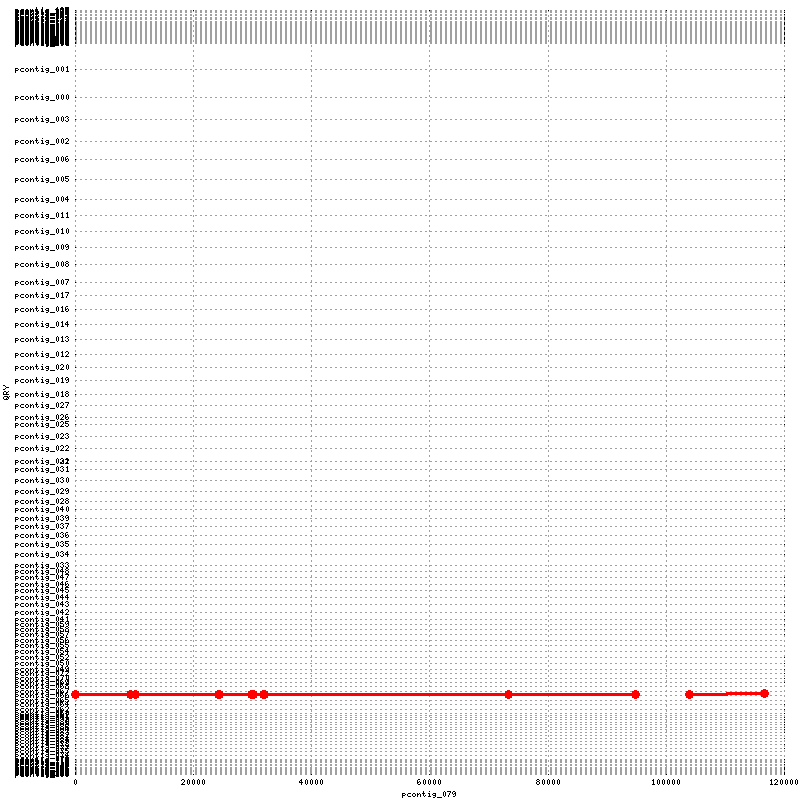

contig pcontig_080 of Pst_104_p with 109931 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_080.png!

##########



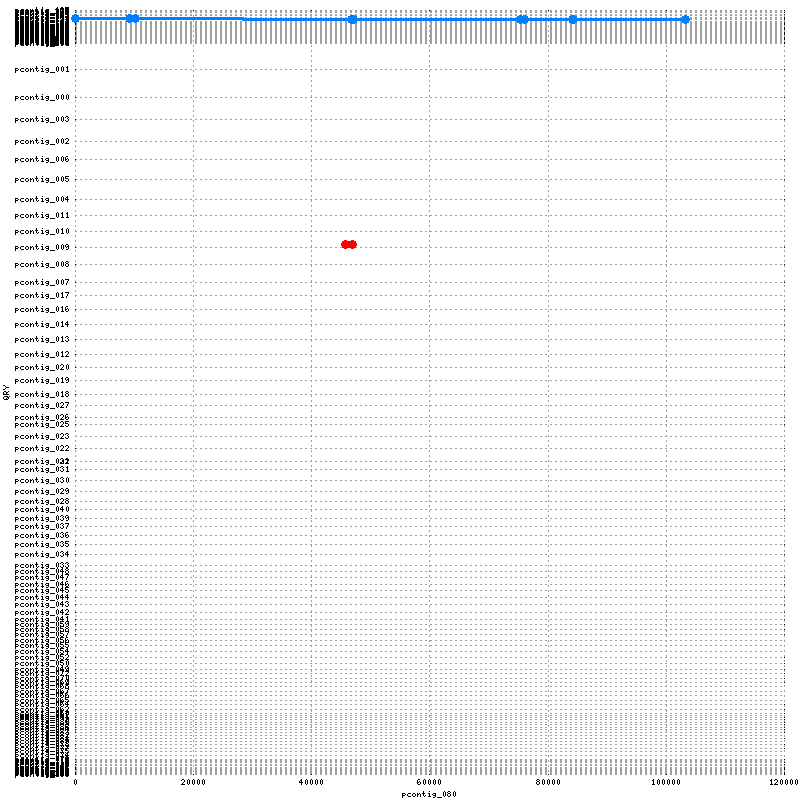

contig pcontig_081 of Pst_104_p with 100797 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_081.png!

##########



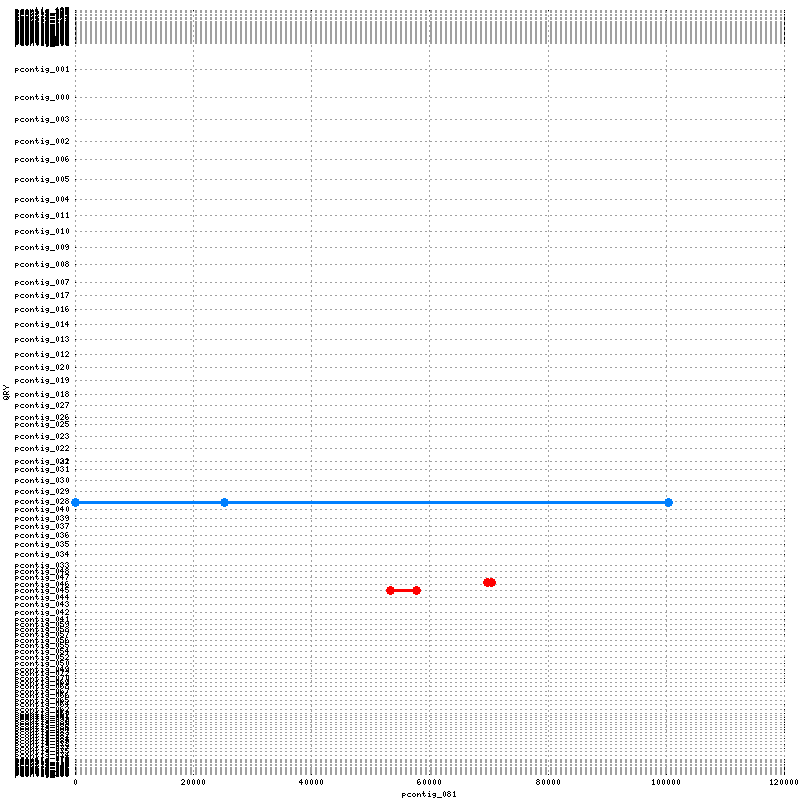

contig pcontig_082 of Pst_104_p with 98178 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_082.png!

##########



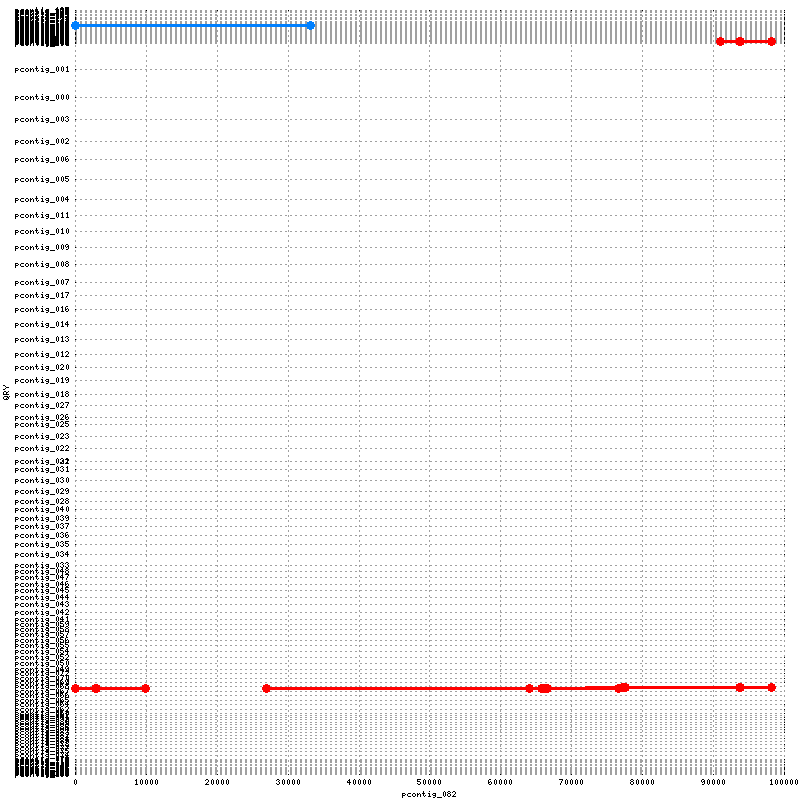

contig pcontig_083 of Pst_104_p with 81214 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_083.png!

##########



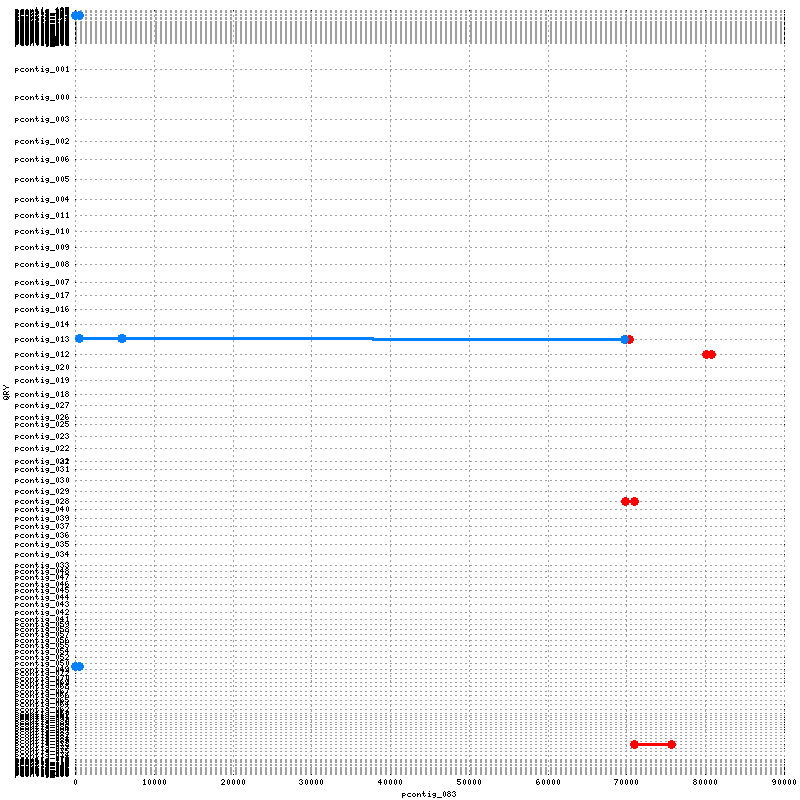

contig pcontig_084 of Pst_104_p with 80580 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_084.png!

##########



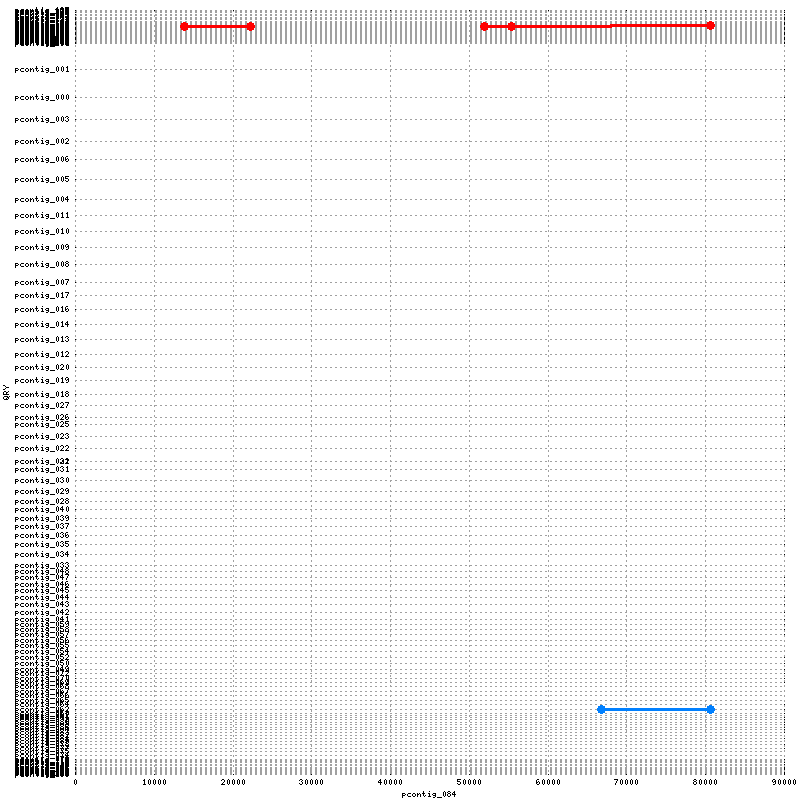

contig pcontig_087 of Pst_104_p with 72512 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_087.png!

##########



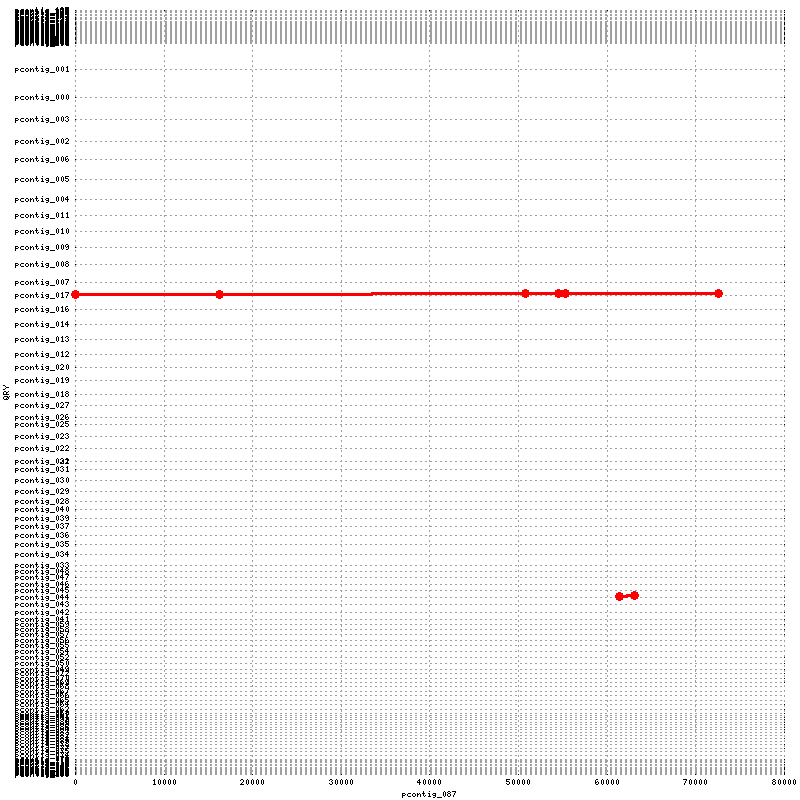

contig pcontig_088 of Pst_104_p with 70079 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_088.png!

##########



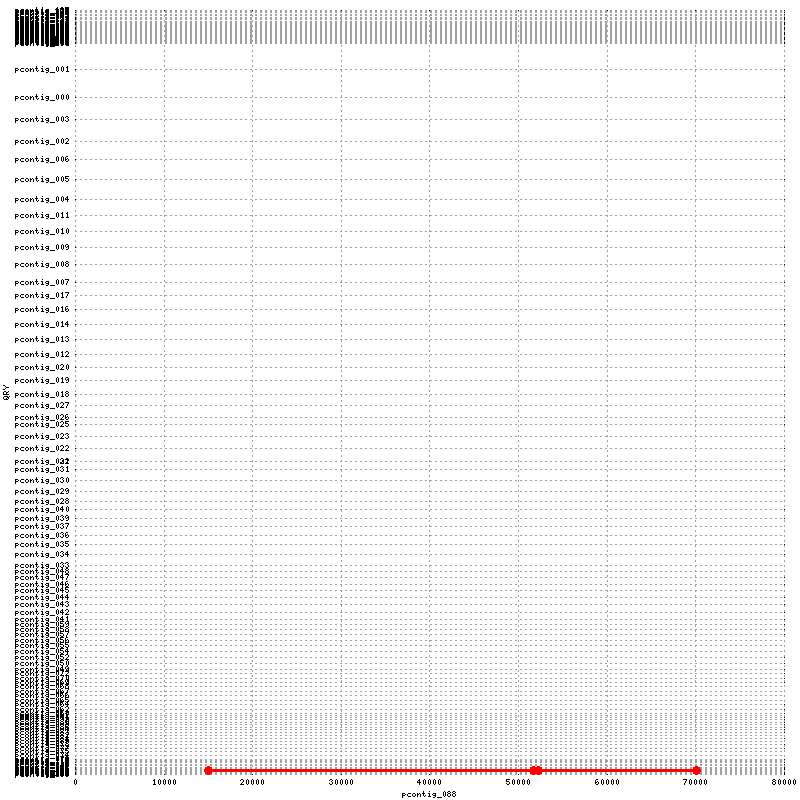

contig pcontig_089 of Pst_104_p with 70543 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_089.png!

##########



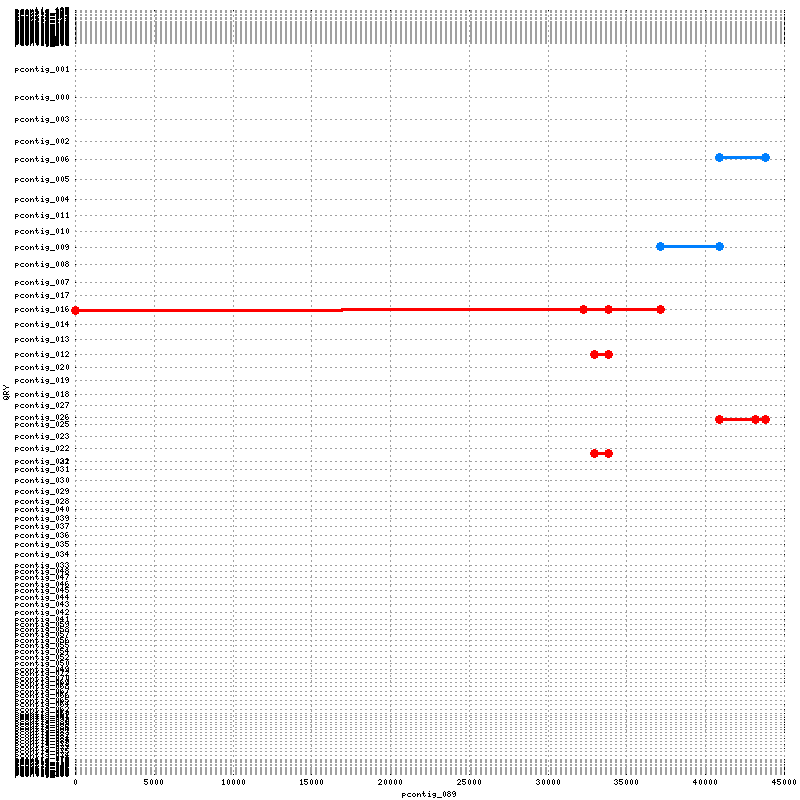

contig pcontig_090 of Pst_104_p with 56462 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_090.png!

##########



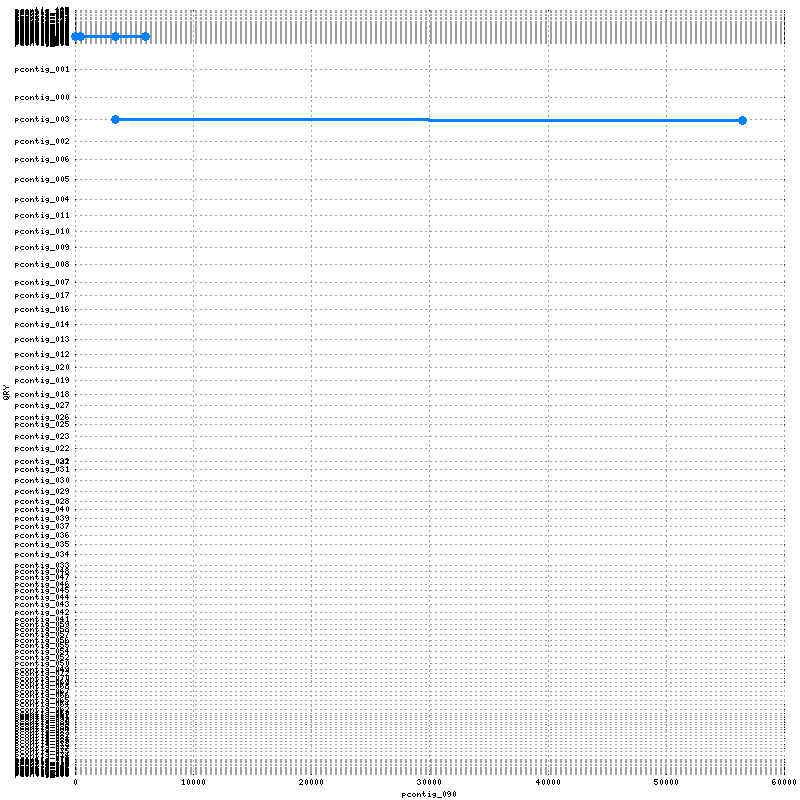

contig pcontig_093 of Pst_104_p with 40668 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_093.png!

##########



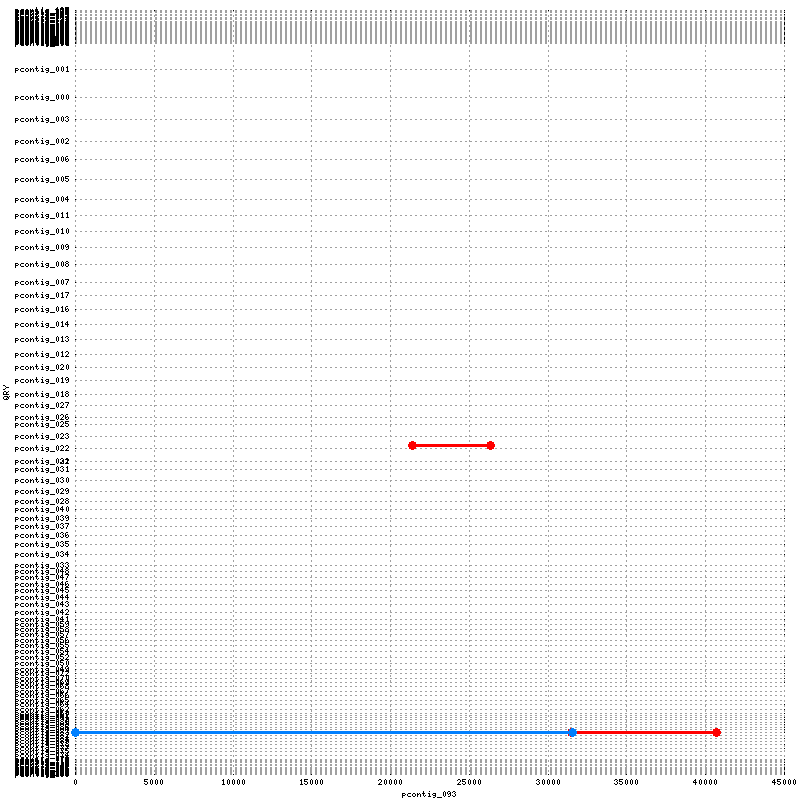

contig pcontig_094 of Pst_104_p with 48536 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_094.png!

##########



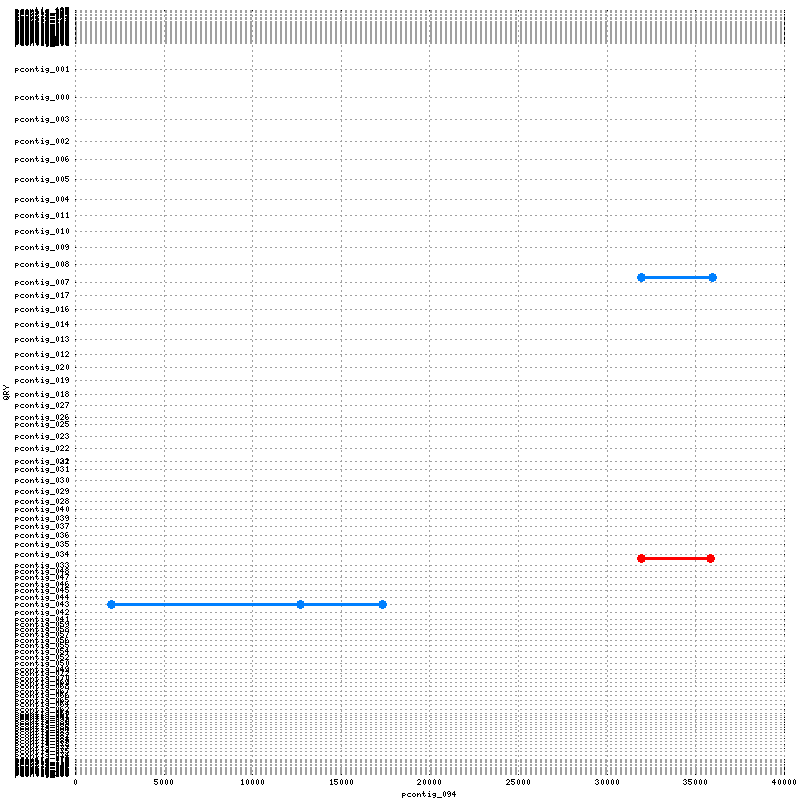

contig pcontig_095 of Pst_104_p with 44208 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_095.png!

##########



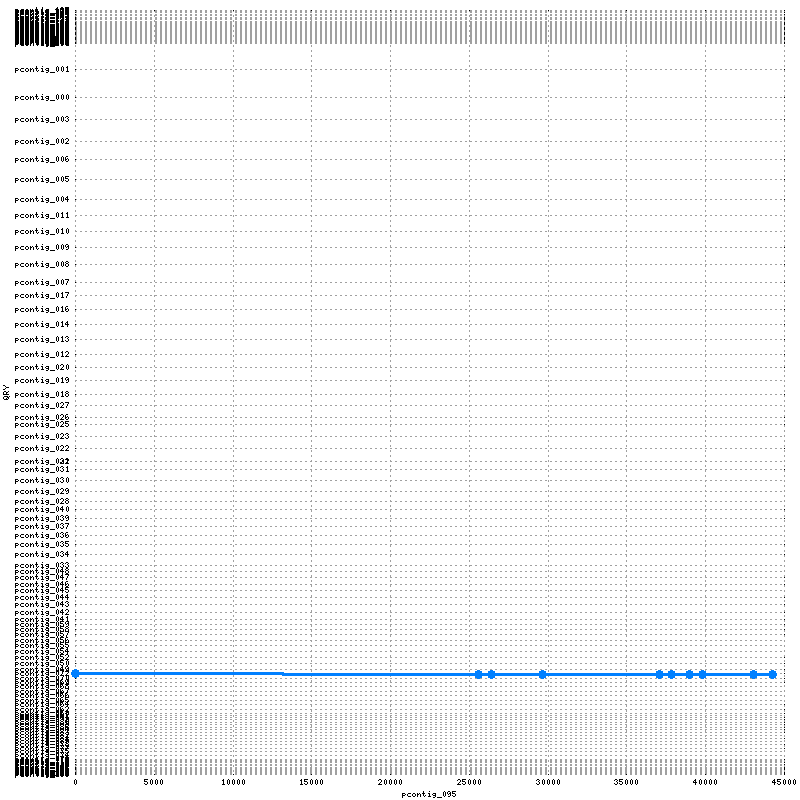

contig pcontig_099 of Pst_104_p with 30698 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_099.png!

##########



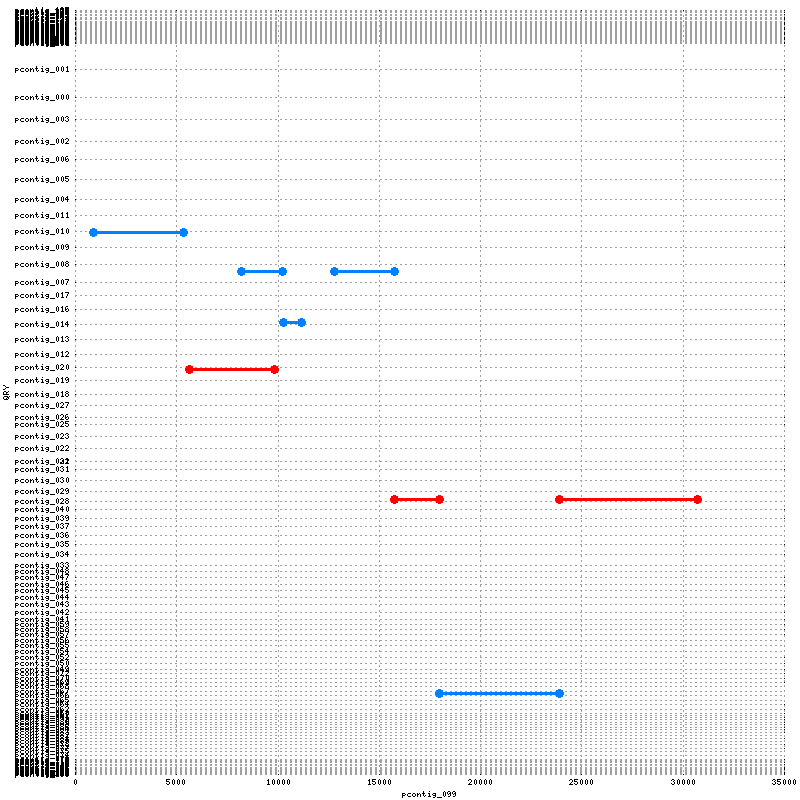

contig pcontig_101 of Pst_104_p with 29712 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_101.png!

##########



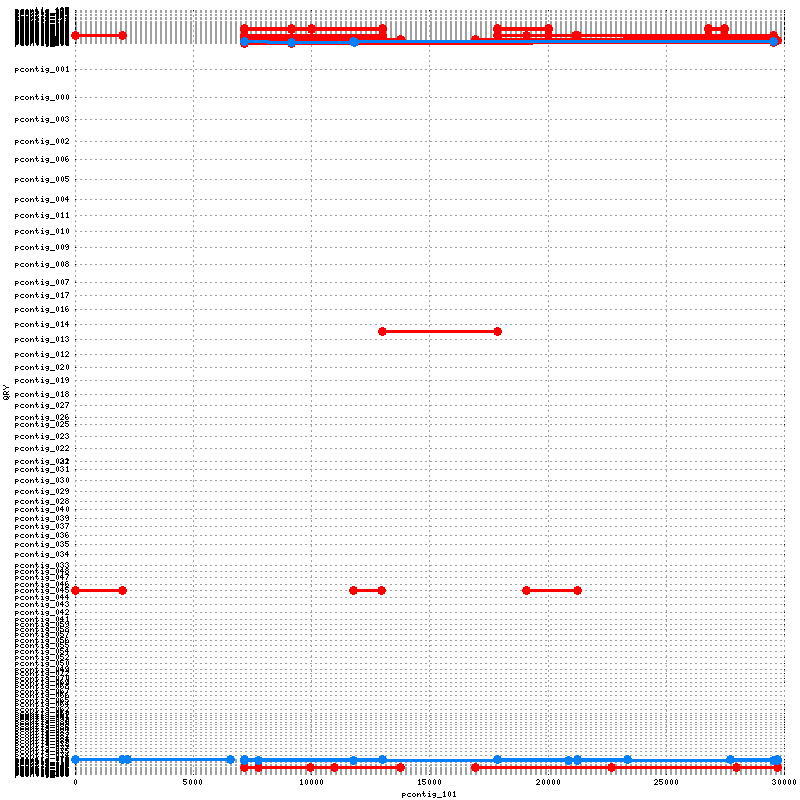

contig pcontig_104 of Pst_104_p with 23312 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_104.png!

##########



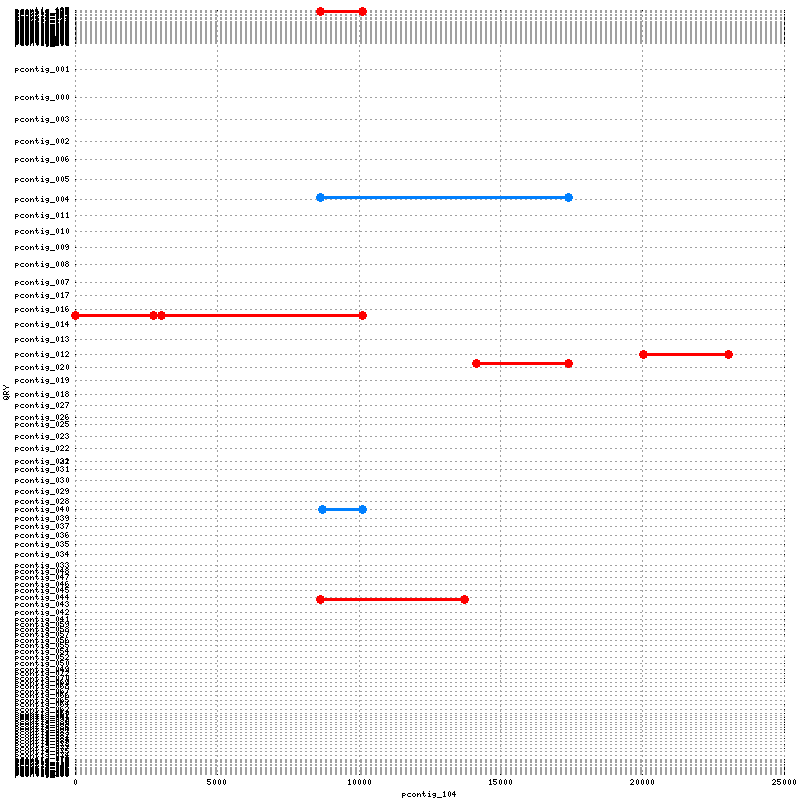

contig pcontig_105 of Pst_104_p with 23178 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_105.png!

##########



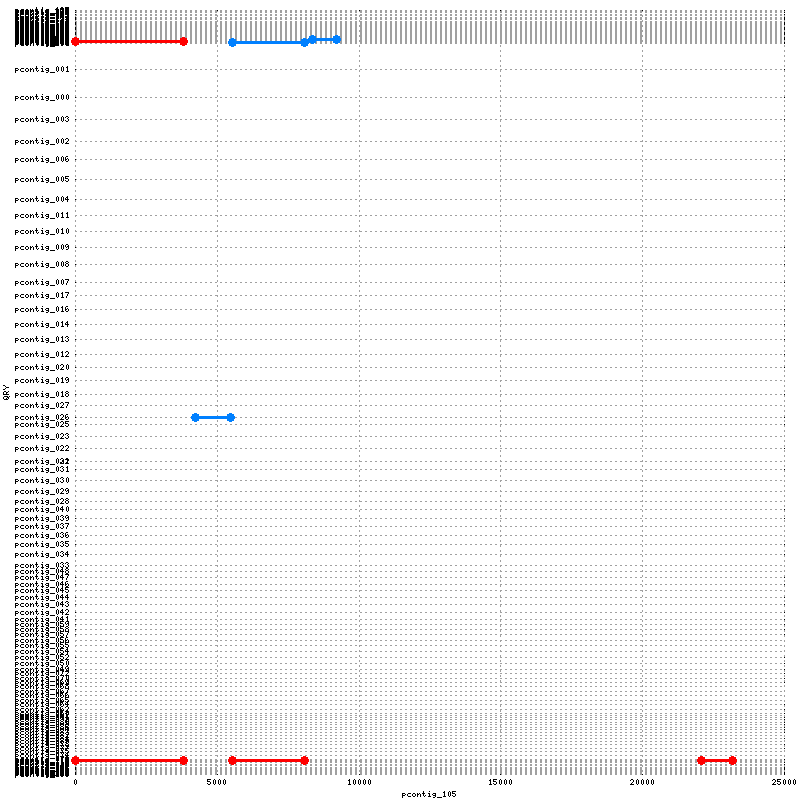

contig pcontig_106 of Pst_104_p with 23117 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_106.png!

##########



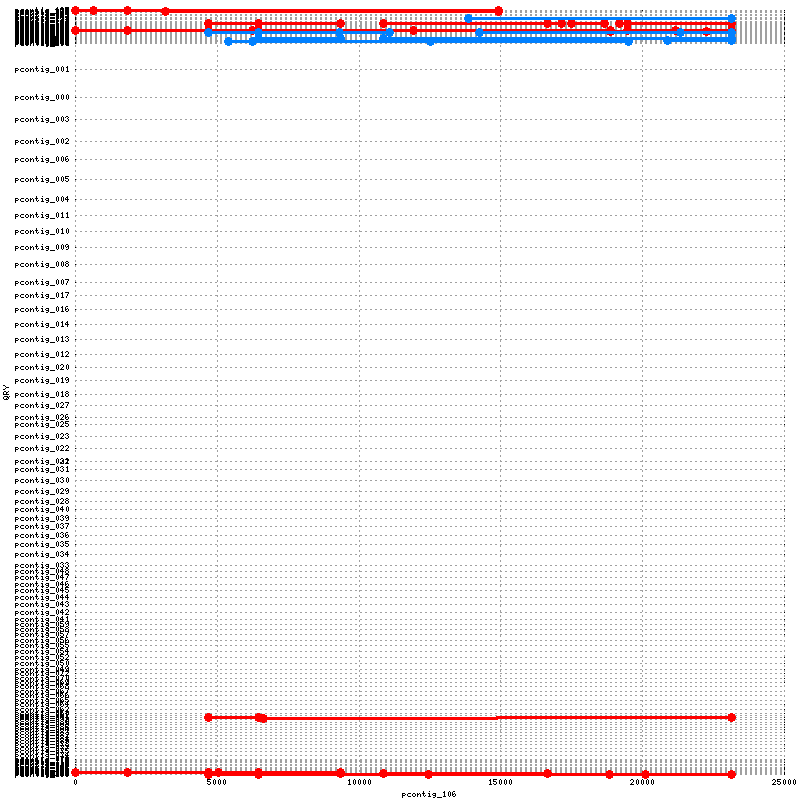

contig pcontig_107 of Pst_104_p with 22424 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_107.png!

##########



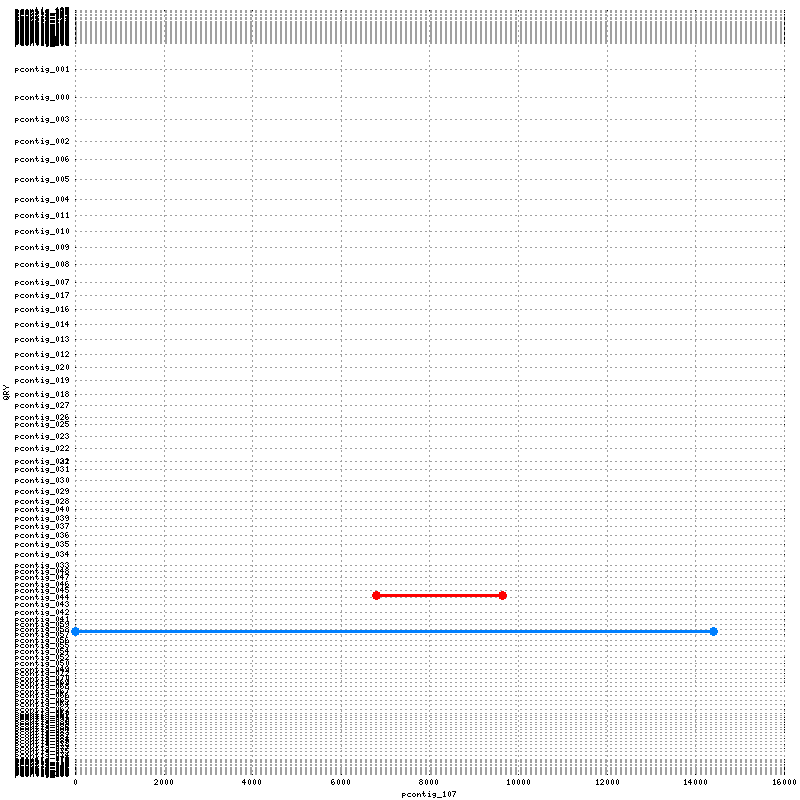

contig pcontig_109 of Pst_104_p with 20280 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_109.png!

##########



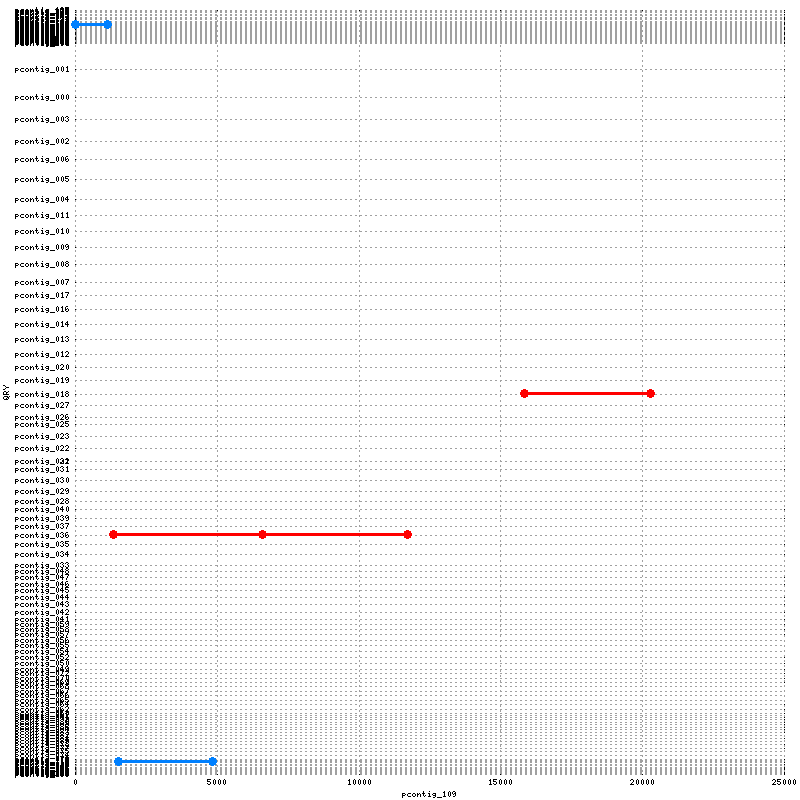

contig pcontig_110 of Pst_104_p with 20182 length.

##########

This is the alignment plot DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.l100.c500.mm.deltafilter_mu0i98_pcontig_110.png!

##########



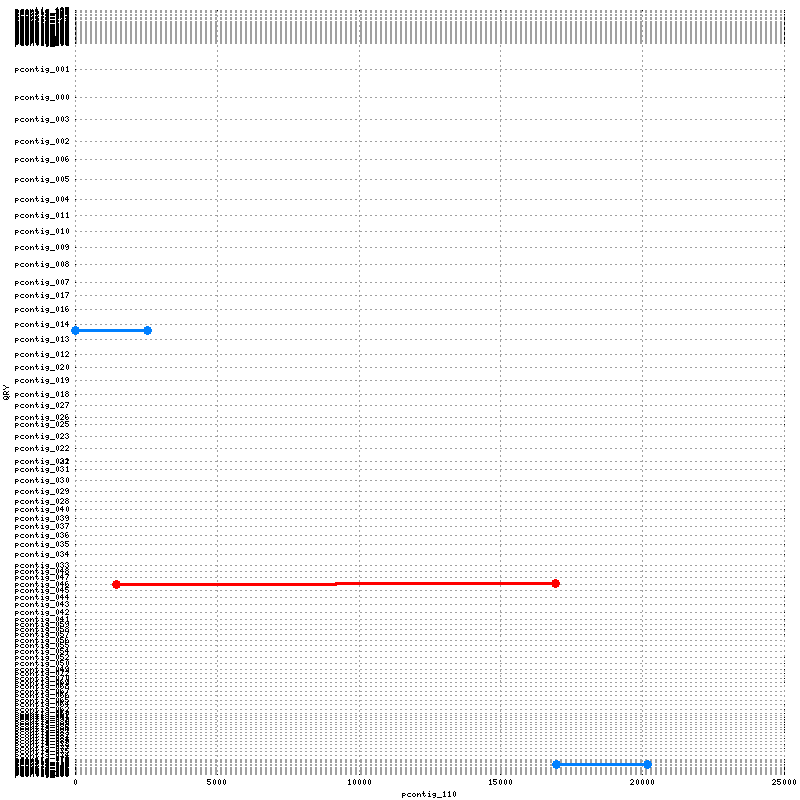

In [136]:
DK0911_p_contig_dict = {}
for seq in SeqIO.parse(os.path.join(GENOME_FOLDER, DK0911_p), 'fasta'):
    DK0911_p_contig_dict[seq.id] = len(seq.seq)
DK0911_p_contig_dict = OrderedDict(sorted(DK0911_p_contig_dict.items()))
for seq, length in DK0911_p_contig_dict.items():
    print('contig %s of Pst_104_p with %i length.' %(seq, length))
    image = show_align_plot(run_mummerplot(run_delta_filter(delta_DK0911_Pst_104Ep_mm, **{'m':'-m', 'i': '-i 98', 'u': '-u 0'}), **{ 'r': '-r %s' % seq }))
    display(image)

In [138]:
coords_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500_rl.coords'

In [204]:
coords_to_nrbed(run_show_coords(run_delta_filter(delta_Pst_104Eph_DK0911ph_mm, **{'m':'-m', 'i': '-i 98', 'u': '-u 0'})))

'/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/Pst_104E_v13_ph_ctg.DK_0911_v04_ph_ctg.l100.c500.mm.deltafilter_mu0i98_.nr.bed'

In [202]:
count_bases_in_bed(coords_to_nrbed(run_show_coords(run_delta_filter(delta_Pst_104Eph_DK0911ph_mm, **{'m':'-m', 'i': '-i 98', 'u': '-u 0'}))))

131859504

In [203]:
count_bases_in_bed(coords_to_nrbed(run_show_coords(run_delta_filter(delta_Pst_104E_DK0911ph_mm, **{'m':'-m', 'i': '-i 95', 'u': '-u 0'}))))

73680409

In [163]:
!head {coords_fn}

/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/genomes/DK_0911_v04_p_ctg.fa /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/genomes/DK_0911_v04_h_ctg.fa
NUCMER

[S1]	[E1]	[S2]	[E2]	[LEN 1]	[LEN 2]	[% IDY]	[LEN R]	[LEN Q]	[TAGS]
968	15341	1	14404	14374	14404	99.63	4476905	14404	pcontig_000	hcontig_000_024
22853	24256	15957	17360	1404	1404	99.29	4476905	69809	pcontig_000	hcontig_002_050
22854	23978	22272	23397	1125	1126	98.67	4476905	32170	pcontig_000	hcontig_050_005
22857	23999	26206	25063	1143	1144	97.55	4476905	33816	pcontig_000	hcontig_002_058
22857	23978	80200	79079	1122	1122	98.84	4476905	86286	pcontig_000	hcontig_015_026
22857	23978	5228	6348	1122	1121	98.13	4476905	55590	pcontig_000	hcontig_021_003


In [184]:
with open(coords_fn, 'r') as fh:
    counter = 0
    for line in fh:
        #if line.startswith('['):
            #counter = 1
        #if counter == 1:
        n_columns = len(line.split('\t'))
column_names = ['r_start','r_stop', 'q_start', 'q_stop', 'aln_len_r', 'aln_len_q', 'pc_id', 'len_r', 'len_q', 'ref_name', 'query_name']

if len(columns) != n_columns:
    column_names.remove('len_r' )
    column_names.remove('len_q')

df = pd.read_csv(coords_fn, sep='\t', skiprows=4, names=column_names )
tmp_bed_fn = coords_fn.replace('.coords', '.tmpbed')
df['r_bed_start'] = df.r_start - 1
df['r_bed_stop'] = df.r_stop - 1
df.loc[:, ['ref_name', 'r_bed_start', 'r_bed_stop']].to_csv(tmp_bed_fn, header=None, index=None, sep='\t')
BedTool(tmp_bed_fn).sort().merge().saveas(tmp_bed_fn.replace('.tmpbed', '.nr.bed'))
return tmp_bed_fn.replace('.tmpbed', '.nr.bed')

<BedTool(/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500_rl.nr.bed)>

In [179]:
df = pd.read_csv(coords_fn, sep='\t', skiprows=4, names=columns )

In [180]:
df

,s1_start,e1_start,s2_stop,e2_stop,len_1,len_2,pc_id,len_r,len_q,ref_name,query_name
0,968,15341,1,14404,14374,14404,99.63,4476905,14404,pcontig_000,hcontig_000_024
1,22853,24256,15957,17360,1404,1404,99.29,4476905,69809,pcontig_000,hcontig_002_050
2,22854,23978,22272,23397,1125,1126,98.67,4476905,32170,pcontig_000,hcontig_050_005
3,22857,23999,26206,25063,1143,1144,97.55,4476905,33816,pcontig_000,hcontig_002_058
4,22857,23978,80200,79079,1122,1122,98.84,4476905,86286,pcontig_000,hcontig_015_026
5,22857,23978,5228,6348,1122,1121,98.13,4476905,55590,pcontig_000,hcontig_021_003
6,22857,24253,153547,152151,1397,1397,99.14,4476905,196593,pcontig_000,hcontig_030_007
7,35876,55395,1,19523,19520,19523,99.81,4476905,67378,pcontig_000,hcontig_000_077
8,54149,63020,23383,32238,8872,8856,99.47,4476905,124650,pcontig_000,hcontig_001_032
9,54153,60895,2433,9180,6743,6748,99.85,4476905,137552,pcontig_000,hcontig_004_020


In [91]:
image = show_align_plot(run_mummerplot(run_delta_filter(delta_Pst_104E_DK0911p_mm, **{'m':'-m', 'i': '-i 90', 'u': '-u 0'}), **{ 'r': '-r pcontig_193'}))


##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i90_pcontig_193.png!

##########



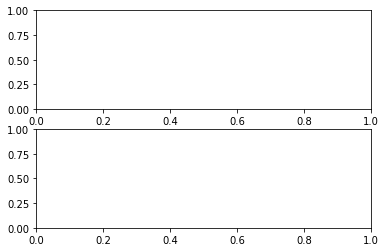

In [99]:
fig, ax = plt.subplots(2)
ax[1] = image


##########

This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu0i90_pcontig_193.png!

##########



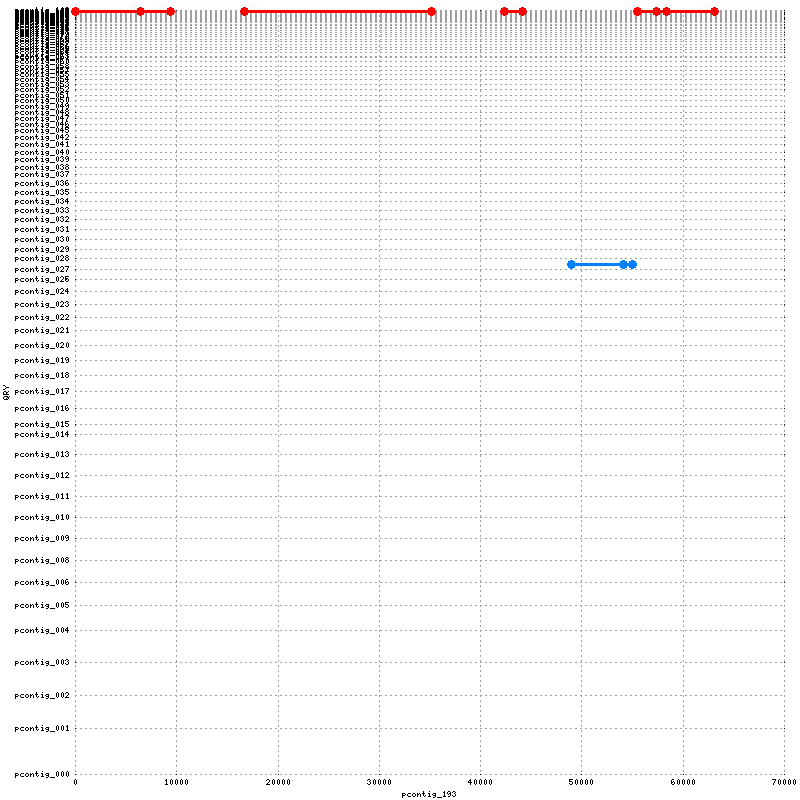

In [87]:
show_align_plot(run_mummerplot(run_delta_filter(delta_Pst_104E_DK0911p_mm, **{'m':'-m', 'i': '-i 90', 'u': '-u 0'}), **{ 'r': '-r pcontig_193'}))

Used following delta filter option: m -m
Used following delta filter option: u -u 0
Used following delta filter option: i -i 98
/home/benjamin/anaconda3/mummer-4.0.0/bin/delta-filter  -m -u 0 -i 98 /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/Pst_104E_v13_p_ctg.DK_0911_v04_ph_ctg.l100.c500.mm.delta > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/Pst_104E_v13_p_ctg.DK_0911_v04_ph_ctg.l100.c500.mm.deltafilter_mu0i98
Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_003
/home/benjamin/anaconda3/mummer-4.0.0/bin/mummerplot  -c -r pcontig_003 -p Pst_104E_v13_p_ctg.DK_0911_v04_ph_ctg.l100.c500.mm.deltafilter_mu0i98 --png /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/Pst_104E_v13_p_ctg.DK_0911_v04_ph_ctg.l100.c500.mm.deltafilter_mu0i98

##########

This is the c

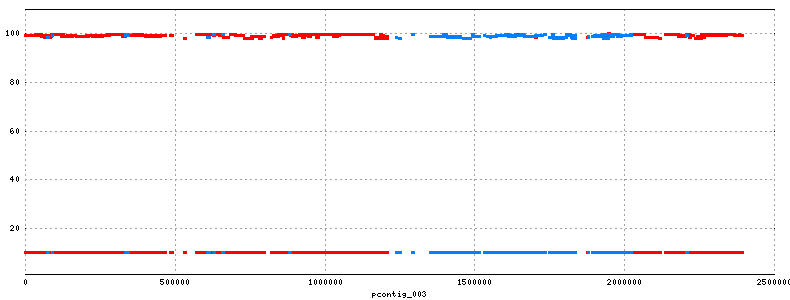

In [59]:
show_cov_plot(run_mummerplot(run_delta_filter(delta_Pst_104E_DK0911ph_mm, **{'m':'-m', 'i': '-i 98', 'u': '-u 0'}), **{'c': '-c', 'r': '-r pcontig_003'}))

Used following delta filter option: m -m
Used following delta filter option: u -u 90
Used following delta filter option: i -i 90
/home/benjamin/anaconda3/mummer-4.0.0/bin/delta-filter  -m -u 90 -i 90 /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.delta > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu90i90
Used following mummerplot option: r -r pcontig_000
/home/benjamin/anaconda3/mummer-4.0.0/bin/mummerplot  -r pcontig_000 -p Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu90i90 --png /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l100.c500.mm.deltafilter_mu90i90
This is the alignment plot Pst_104E_v13_p_ctg.DK_0911_v04_p_ctg.l10

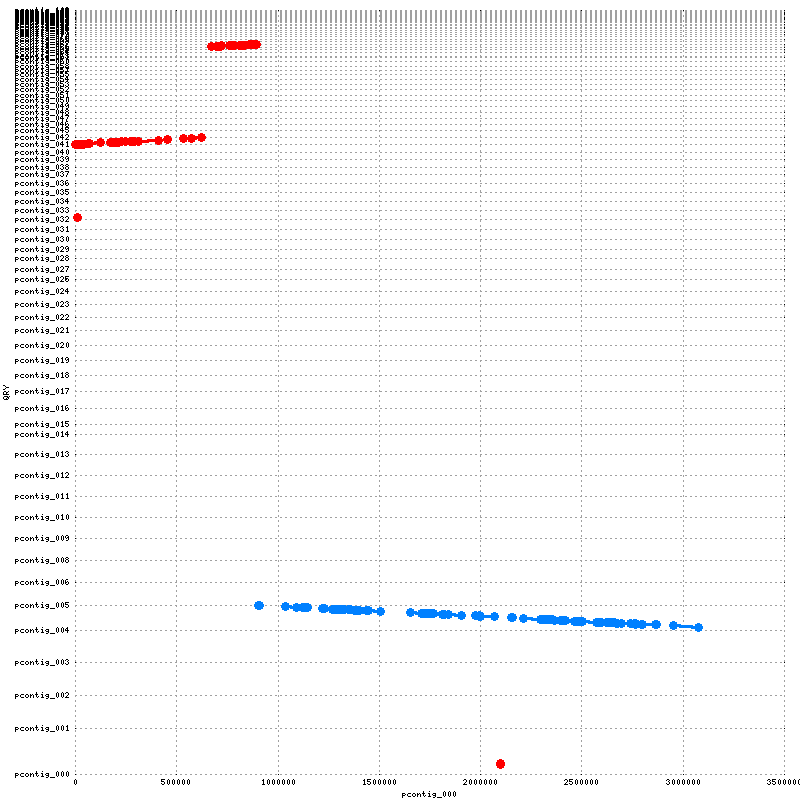

In [67]:
show_align_plot(run_mummerplot(run_delta_filter(delta_Pst_104E_DK0911p_mm, **{'m':'-m', 'i': '-i 90', 'u': '-u 90'}), **{'r': '-r pcontig_000'}))

In [ ]:
delta_filter = {'m':'-m'}
showcoords_fiter = {}
mummerplot_filter = {'c': '-c', 'r': '-r pcontig_000'}

In [ ]:
from PIL import Image

# we get the image

image = Image.open(run_mummerplot(run_delta_filter(delta_DK0911_self_mm, **{'m':'-m'}), **{'c': '-c', 'r': '-r pcontig_000'}))

In [ ]:
image.size

In [ ]:
image.crop((10,500,800,800))

Used following delta filter option: m -m
Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_000


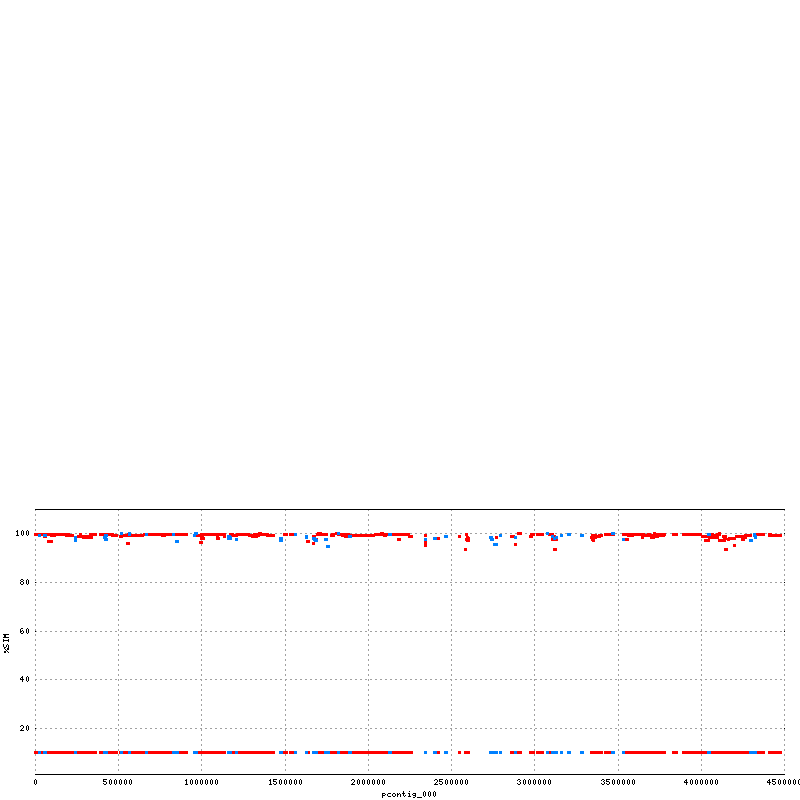

Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_000


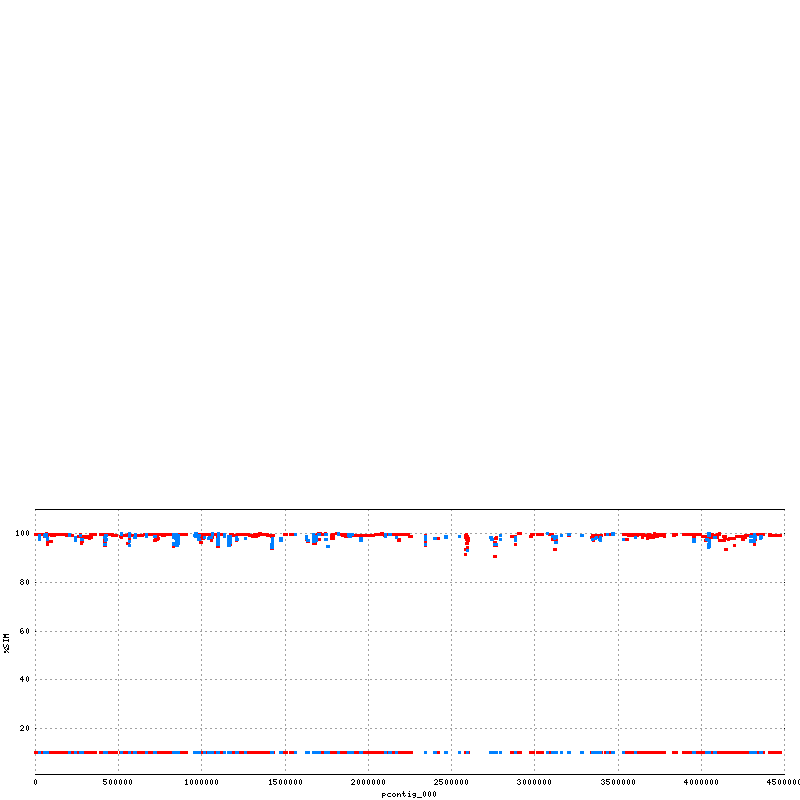

In [166]:
display(Image(run_mummerplot(run_delta_filter(delta_DK0911_self_mm, **{'m':'-m'}), **{'c': '-c', 'r': '-r pcontig_000'})))
display(Image(run_mummerplot(run_delta_filter(delta_DK0911_self_mm), **{'c': '-c', 'r': '-r pcontig_000'})))
display(Image(run_mummerplot(run_delta_filter(delta_DK0911_self_nmm), **{'c': '-c', 'r': '-r pcontig_000'})))

In [ ]:
os.


Runnning now!

delta-filter  /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.delta > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_
Done with it!
Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_000

Runnning now!

mummerplot  -c -r pcontig_000 -p DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_ --png /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_
Done with it!


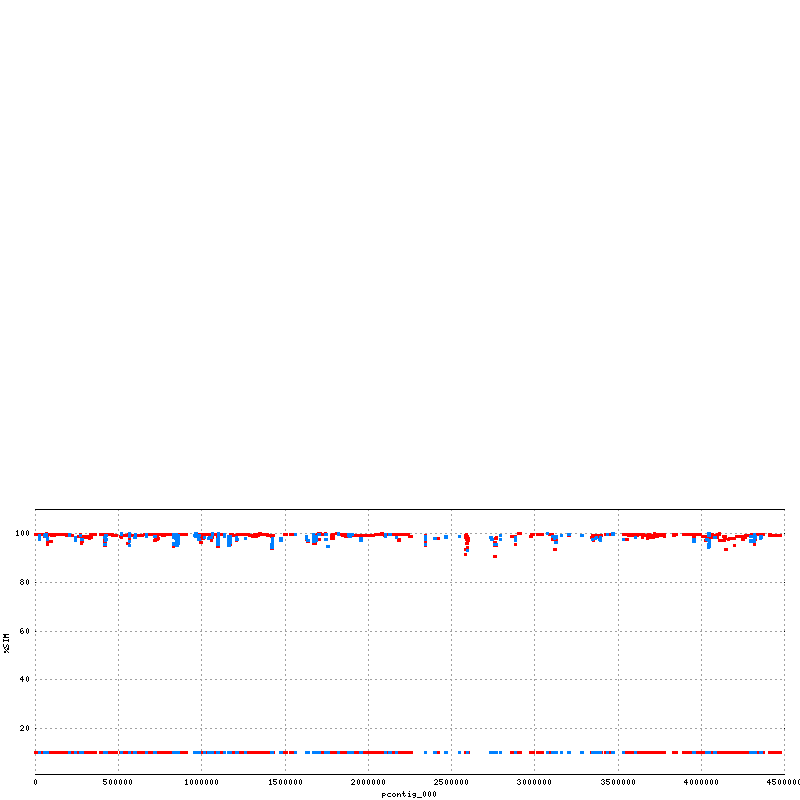

In [164]:
display(Image(run_mummerplot(run_delta_filter(delta_DK0911_self_mm), **{'c': '-c', 'r': '-r pcontig_000'})))

In [157]:
np_image = [img2array(im) for im in images]

In [160]:
np_image 

[]

In [159]:
for img in np_image:
    plt.figure()
    plt.imshow(img)

Used following delta filter option: m -m

Runnning now!

delta-filter  -m /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.delta > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m
Done with it!
Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_000

Runnning now!

mummerplot  -c -r pcontig_000 -p DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m --png /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m
Done with it!


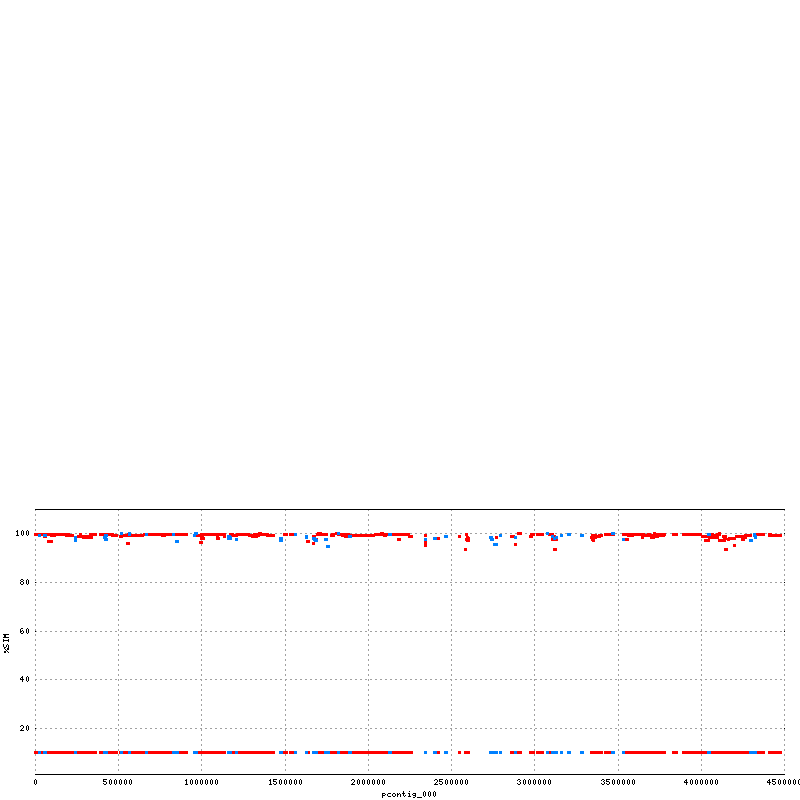

In [150]:
display(Image(run_mummerplot(run_delta_filter(delta_DK0911_self_mm, **{'m':'-m'}), **{'c': '-c', 'r': '-r pcontig_000'}), width=1000, height=300))

In [131]:
delta_filters = {'m':'-m'}
delta_filters = {}
show_coords_filter = {'l': '-l', 'r': '-r'}
mummerplot_filter = {'c': '-c', 'r': '-r pcontig_000'}

Used following delta filter option: m -m

Runnning now!

delta-filter  -m /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.delta > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m
Done with it!
Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_000

Runnning now!

mummerplot  -c -r pcontig_000 -p DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m --png /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m
Done with it!


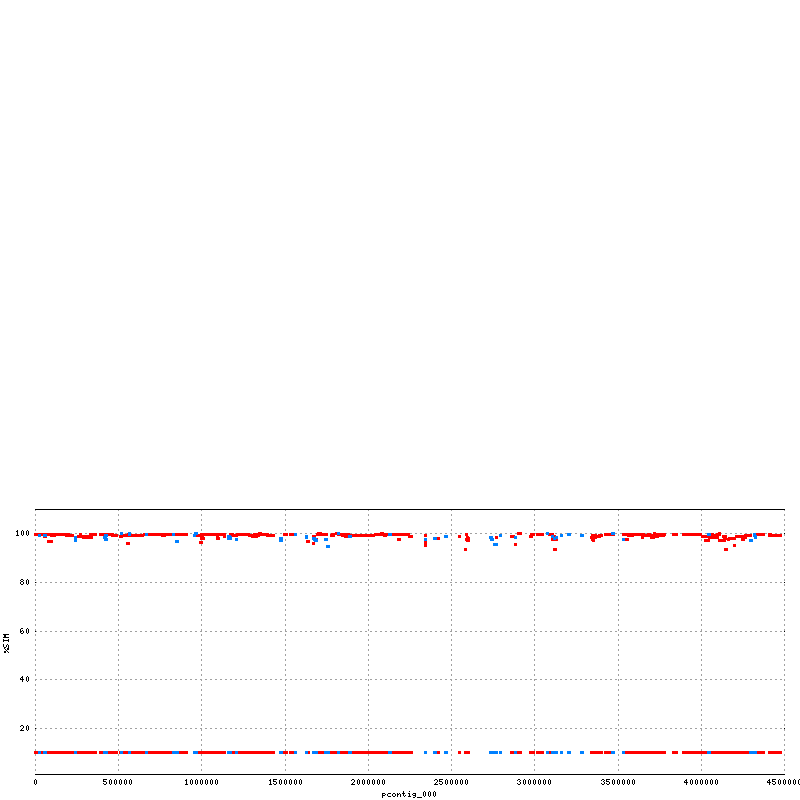

In [146]:
Image(run_mummerplot(run_delta_filter(delta_DK0911_self_mm, **{'m':'-m'}), **{'c': '-c', 'r': '-r pcontig_000'}), width=1000, height=300)

In [ ]:
Image(run_mummerplot(run_delta_filter(delta_DK0911_self_mm), **{'c': '-c', 'r': '-r pcontig_000'}))

In [120]:
showcoords = run_show_coords(delta_filter, **show_coords_filter)

Used following show-coords option: r -r
Used following show-coords option: l -l

Runnning now!

show-coords -T  -r -l /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm_rl.coords

Done
With ouput:
b''
b''


In [133]:
mummer_plot = run_mummerplot(delta_filter, **mummerplot_filter)

Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_000

Runnning now!

mummerplot  -c -r pcontig_000 -p DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_ --png /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_

Done
With ouput:
b'gnuplot 4.6 patchlevel 6\nReading delta file /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_\nWriting plot files DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_.fplot, DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_.rplot\nWriting gnuplot script DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_.gp\nRendering plot DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_.png\n'
b'gnuplot 4.6 patchlevel 6\nReading delta file /h

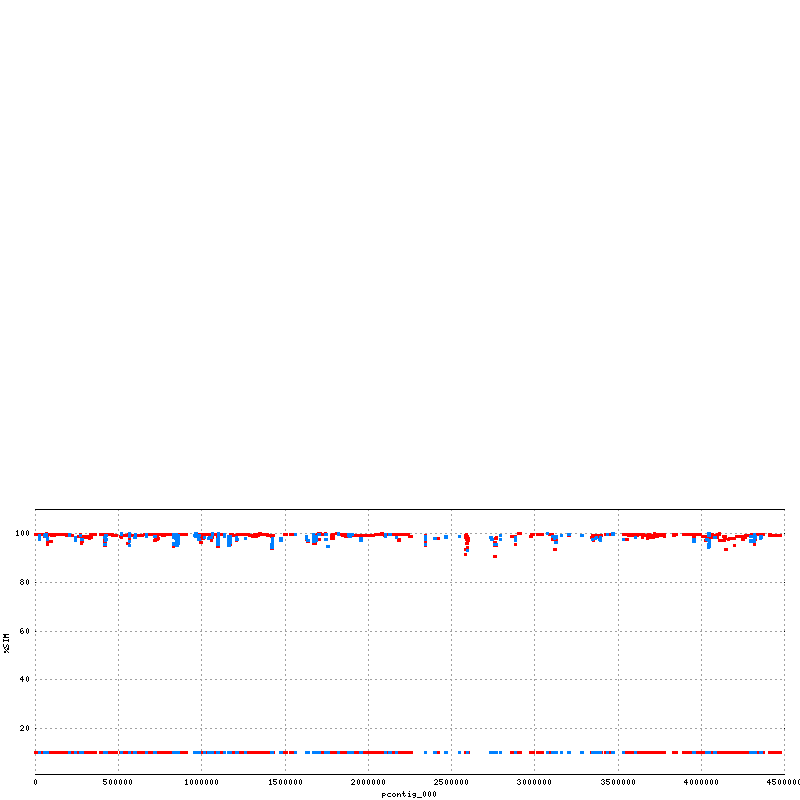

In [134]:
previous_dir = os.getcwd()
os.chdir(OUTFOLDER)
Image(mummer_plot)
#os.chdir(previous_dir)